Ce notebook a été préparé par Fabien Moutarde (MINES ParisTech) en modifiant/combinant 2 notebooks de Cambridge : http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits
http://online.cambridgecoding.com/notebooks/cca_admin/convolutional-neural-networks-with-keras


## Introduction

The goal of this practical session is to get you quickly up to speed with *deep learning*; from first principles, all the way to discussions of some of the intricate details, with the purposes of achieving respectable performance on one established machine learning benchmark: [MNIST](http://yann.lecun.com/exdb/mnist/) (classification of hand-written digits).


MNIST hand-written digits dataset                      
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  

By the end of this part of this practical session, you should be capable of understanding and producing a simple ConvNet (with a structure similar to LeNet architecture) in Keras, achieving a respectable level of accuracy on MNIST.


## Convolutions

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)

## Convolutional and pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a ConvNet. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks ([Keras included](https://keras.io/layers/convolutional/)) will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a ConvNet (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/pool.png)

## Putting it all together: a typical ConvNet architecture

Now that we got all the building blocks, let's see what a typical convolutional neural network might look like!

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/cnn.png)

A typical ConvNet architecture for a $k$-class image classification can be split into two distinct parts---a chain of repeating $\mathrm{Conv}\rightarrow\mathrm{Pool}$ layers (sometimes with more than one convolutional layer at once), followed by a few fully connected layers (taking each pixel of the computed images as an independent input), culminating in a $k$-way softmax layer, to which a cross-entropy loss is optimised. I did not draw the activation functions here to make the sketch clearer, but do keep in mind that typically after every convolutional or fully connected layer, an activation (e.g. ReLU) will be applied to all of the outputs.

Note the effect of a single $\mathrm{Conv}\rightarrow\mathrm{Pool}$ pass through the image: it reduces height and width of the individual channels in favour of their number, i.e. *depth*.

The softmax layer and cross-entropy loss are both introduced in more detail [in another tutorial](http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits). For summarisation purposes, a softmax layer's purpose is converting any vector of real numbers into a vector of *probabilities* (nonnegative real values that add up to 1). Within this context, the probabilities correspond to the likelihoods that an input image is a member of a particular class. Minimising the cross-entropy loss has the effect of maximising the model's confidence in the *correct* class, without being concerned for the probabilites for other classes---this makes it a more suitable choice for probabilistic tasks compared to, for example, the squared error loss.

## Detour: Overfitting, regularisation and dropout

This will be the first (and hopefully the only) time when I will divert your attention to a seemingly unrelated topic. It regards a very important pitfall of machine learning---**overfitting** a model to the training data. While this is primarily going to be a major topic of the next tutorial in the series, the negative effects of overfitting will tend to become quite noticeable on the networks like the one we are about to build, and we need to introduce a way to properly protect ourselves against it, before going any further. Luckily, there is a very simple technique we can use.

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a sine curve, with white additive noise applied to the data points: 

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/plotsin.png)

Here we have a training set (denoted by blue circles) derived from the original sine wave, along with some noise. If we fit a degree-3 polynomial to this data, we get a fairly good approximation to the original curve. Someone might argue that a degree-14 polynomial would do better; indeed, given we have 15 points, such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters, we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method I will introduce here is **dropout**---a technique that initially might seem like "dark magic", but actually helps to eliminate exactly the failure modes described above. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers. An illustration is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/drop.png)

## Applying a deep ConvNet to MNIST

As this post's objective, we will implement a deep convolutional neural network---and apply it on the MNIST digit recognition classification task.


As already mentioned, a ConvNet will typically have more hyperparameters than an MLP. For the purposes of this tutorial practical session, we will also stick to "sensible" hand-picked values for them, but do still keep in mind that later on I will introduce a more proper method for learning them.

The hyperparameters are:
- The *batch size*, representing the number of training examples being used simultaneously during a single iteration of the gradient descent algorithm;
- The number of *epochs*, representing the number of times the training algorithm will iterate over the entire training set before terminating\*;
- The *kernel sizes* in the convolutional layers;
- The *pooling size* in the pooling layers;
- The *number of kernels* in the convolutional layers;
- The *dropout probability* (we will apply dropout after each pooling, and after the fully connected layer);
- The *number of neurons* in the fully connected layer of the MLP.



Modelling time! Our network has an architecture similar to LeNet5 of LeCun (see figure below). It will consist of two consecutive groups of one `Convolution2D` followed by  a `MaxPooling2D` layer. After the first pooling layer, the number of kernels is rougly doubled (in line with the previously mentioned principle of sacrificing height and width for more depth). Afterwards, the output of the second pooling layer is flattened to 1D (via the `Flatten` layer), and passed through one or two fully connected (`Dense`) layers. ReLU activations will once again be used for all layers except the output dense layer, which will use a softmax activation (for purposes of probabilistic classification).

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lenet5.png)

To regularise our model, a `Dropout` layer is applied after each pooling layer, and after the first `Dense` layer. This is another area where Keras shines compared to other frameworks: it has an internal flag that automatically enables or disables dropout, depending on whether the model is currently used for training or testing.

The remainder of the model specification is the following:
- We use the *cross-entropy* loss function as the objective to optimise (as its derivation is more appropriate for probabilistic tasks);
- We use the [*Adam* optimiser for gradient descent](http://sebastianruder.com/optimizing-gradient-descent/);
- We report the *accuracy* of the model (as the dataset is balanced across the ten classes)\*;
- We hold out a significant proportion of the data for validation purposes.

\* To get a feeling for why accuracy might be inappropriate for unbalanced datasets, consider an extreme case where 90% of the test data belongs to class $x$ (this could be, for example, the task of diagnosing patients for an extremely rare disease). In this case, a classifier that just outputs $x$ achieves a seemingly impressive accuracy of 90% on the test data, without really doing any learning/generalisation.

This model, possibly after some tweaking of its architectural parameters, should be able to break $99\%$ accuracy on its **test set** with little to no effort.


## Conclusion

Throughout this post we have covered the essentials of convolutional neural networks, introduced the problem of overfitting, and made a very brief dent into how it could be rectified via regularisation (by applying dropout) and successfully implemented a two-layer deep ConvNet (with LeNet like architecture) in Keras, applying it to MNIST, all in under 50 lines of code. 


## Just show me the code!

In [10]:
import os
# FIRST CHOOSE WHICH "BACK-END" YOU WILL USE, BETWEEN tensorflow (preferable) OR theano
#    (depending on which you have managed to install)
os.environ['KERAS_BACKEND']="tensorflow"
import tensorflow
print("Version tensorflow :" + tensorflow.__version__)
#os.environ['KERAS_BACKEND']="theano"
#import theano
#print("Version Theano :" + theano.__version__)


# WHATEVER BACK-END YOU HAVE CHOSEN, YOU SHALL USE keras AS RONT-END
import keras
print("Version KERAS :" + keras.__version__)

from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras import regularizers
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
from numpy import newaxis

# CONVNET PARAMETERS
# ===================
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 5 # we iterate ?? times over the entire training set
kernel_size = 5 # we will use 5x5 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 6 # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.5# dropout after pooling with probability ??
drop_prob_2 = 0.5 # dropout in the FC layer with probability ??
hidden_size = 128 # the FC layer will have 128 neurons
weight_penalty = 1 # Factor for weights penalty

# DATASET CHARACTERISTICS
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000 # there are 10000 test examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 and *greyscale*
num_classes = 10 # there are 10 classes (1 per digit)

(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

# REFORMAT PROPERLY THE DATA
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range
X_train = X_train[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels
print(X_train.shape)
print(Y_train.shape)

# NOW, BUILD THE MODEL ARCHITECTURE
# =================================

model = Sequential()
# FIRST CONVOLUTION+POOLING LAYERS
#   Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), border_mode='same', activation='relu', 
                         data_format="channels_first", input_shape=( 1, 28, 28)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# FIRST CONVOLUTION+POOLING LAYERS
#    Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), border_mode='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# CLASSIFICATION PART: FULLY-CONNECTED LAYER + OUTPUT LAYER
#   Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) ) # Some Dropout regularization (if necessary)
model.add( Dense(num_classes, activation='softmax') )

# DISPLAY THE MODEL ARCHITECTURE INFORMATION
print(model.summary)

# DEFINE THE LOSS FUNCTION AND OPTIMIZER
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# TRAIN THE MODEL
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1, validation_split=0.6) # ...holding out 40% of the data for validation

# EVALUATE THE MODEL ON TEST SET
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!
print("\n EVALUATION [loss, accuracy] on TEST set:")
print(model.evaluate(X_test, Y_test, verbose=1))

Version tensorflow :1.12.0
Version KERAS :2.2.4


(60000, 1, 28, 28)
(60000, 10)
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x12ca40d68>>


/Users/yanis/venv/ApprentissageArtificiel/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28..., padding="same")`
/Users/yanis/venv/ApprentissageArtificiel/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
/Users/yanis/venv/ApprentissageArtificiel/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 24000 samples, validate on 36000 samples
Epoch 1/5


   32/24000 [..............................] - ETA: 8:12 - loss: 120.0699 - acc: 0.0625

   96/24000 [..............................] - ETA: 2:56 - loss: 117.8758 - acc: 0.0729

  192/24000 [..............................] - ETA: 1:36 - loss: 114.6956 - acc: 0.0938

  288/24000 [..............................] - ETA: 1:09 - loss: 111.5657 - acc: 0.1111

  384/24000 [..............................] - ETA: 56s - loss: 108.4964 - acc: 0.1224 

  480/24000 [..............................] - ETA: 48s - loss: 105.5058 - acc: 0.1271

  576/24000 [..............................] - ETA: 43s - loss: 102.6215 - acc: 0.1302

  672/24000 [..............................] - ETA: 39s - loss: 99.8212 - acc: 0.1176 

  768/24000 [..............................] - ETA: 36s - loss: 97.0986 - acc: 0.1172

  832/24000 [>.............................] - ETA: 35s - loss: 95.3310 - acc: 0.1190

  896/24000 [>.............................] - ETA: 34s - loss: 93.6000 - acc: 0.1217

  960/24000 [>.............................] - ETA: 32s - loss: 91.9099 - acc: 0.1177

 1056/24000 [>.............................] - ETA: 31s - loss: 89.4438 - acc: 0.1174

 1152/24000 [>.............................] - ETA: 30s - loss: 87.0589 - acc: 0.1155

 1248/24000 [>.............................] - ETA: 28s - loss: 84.7539 - acc: 0.1186

 1344/24000 [>.............................] - ETA: 27s - loss: 82.5281 - acc: 0.1190

 1408/24000 [>.............................] - ETA: 27s - loss: 81.0882 - acc: 0.1193

 1472/24000 [>.............................] - ETA: 26s - loss: 79.6802 - acc: 0.1216

 1568/24000 [>.............................] - ETA: 26s - loss: 77.6290 - acc: 0.1250

 1664/24000 [=>............................] - ETA: 25s - loss: 75.6475 - acc: 0.1286

 1760/24000 [=>............................] - ETA: 24s - loss: 73.7374 - acc: 0.1295

 1856/24000 [=>............................] - ETA: 24s - loss: 71.8937 - acc: 0.1298

 1952/24000 [=>............................] - ETA: 23s - loss: 70.1126 - acc: 0.1317

 2048/24000 [=>............................] - ETA: 23s - loss: 68.3942 - acc: 0.1313

 2112/24000 [=>............................] - ETA: 23s - loss: 67.2804 - acc: 0.1335

 2208/24000 [=>............................] - ETA: 22s - loss: 65.6588 - acc: 0.1354

 2272/24000 [=>............................] - ETA: 22s - loss: 64.6101 - acc: 0.1347

 2368/24000 [=>............................] - ETA: 22s - loss: 63.0814 - acc: 0.1360

 2464/24000 [==>...........................] - ETA: 21s - loss: 61.6054 - acc: 0.1368

 2528/24000 [==>...........................] - ETA: 21s - loss: 60.6494 - acc: 0.1381

 2592/24000 [==>...........................] - ETA: 21s - loss: 59.7151 - acc: 0.1427

 2688/24000 [==>...........................] - ETA: 21s - loss: 58.3561 - acc: 0.1425

 2784/24000 [==>...........................] - ETA: 20s - loss: 57.0430 - acc: 0.1444

 2880/24000 [==>...........................] - ETA: 20s - loss: 55.7743 - acc: 0.1469

 2976/24000 [==>...........................] - ETA: 20s - loss: 54.5491 - acc: 0.1472

 3072/24000 [==>...........................] - ETA: 20s - loss: 53.3660 - acc: 0.1488

 3168/24000 [==>...........................] - ETA: 19s - loss: 52.2226 - acc: 0.1499

 3264/24000 [===>..........................] - ETA: 19s - loss: 51.1181 - acc: 0.1507

 3360/24000 [===>..........................] - ETA: 19s - loss: 50.0506 - acc: 0.1533

 3456/24000 [===>..........................] - ETA: 19s - loss: 49.0195 - acc: 0.1525

 3552/24000 [===>..........................] - ETA: 19s - loss: 48.0222 - acc: 0.1529

 3648/24000 [===>..........................] - ETA: 18s - loss: 47.0574 - acc: 0.1538

 3744/24000 [===>..........................] - ETA: 18s - loss: 46.1246 - acc: 0.1552

 3808/24000 [===>..........................] - ETA: 18s - loss: 45.5197 - acc: 0.1552

 3872/24000 [===>..........................] - ETA: 18s - loss: 44.9274 - acc: 0.1555

 3968/24000 [===>..........................] - ETA: 18s - loss: 44.0647 - acc: 0.1552

 4064/24000 [====>.........................] - ETA: 18s - loss: 43.2304 - acc: 0.1553

 4160/24000 [====>.........................] - ETA: 17s - loss: 42.4218 - acc: 0.1577

 4256/24000 [====>.........................] - ETA: 17s - loss: 41.6392 - acc: 0.1598

 4352/24000 [====>.........................] - ETA: 17s - loss: 40.8821 - acc: 0.1590

 4416/24000 [====>.........................] - ETA: 17s - loss: 40.3901 - acc: 0.1596

 4512/24000 [====>.........................] - ETA: 17s - loss: 39.6715 - acc: 0.1625

 4608/24000 [====>.........................] - ETA: 17s - loss: 38.9752 - acc: 0.1654

 4704/24000 [====>.........................] - ETA: 17s - loss: 38.3007 - acc: 0.1675

 4800/24000 [=====>........................] - ETA: 16s - loss: 37.6465 - acc: 0.1692

 4896/24000 [=====>........................] - ETA: 16s - loss: 37.0132 - acc: 0.1703

 4992/24000 [=====>........................] - ETA: 16s - loss: 36.3991 - acc: 0.1717

 5088/24000 [=====>........................] - ETA: 16s - loss: 35.8031 - acc: 0.1728

 5184/24000 [=====>........................] - ETA: 16s - loss: 35.2254 - acc: 0.1746

 5280/24000 [=====>........................] - ETA: 16s - loss: 34.6645 - acc: 0.1767

 5376/24000 [=====>........................] - ETA: 16s - loss: 34.1218 - acc: 0.1773

 5472/24000 [=====>........................] - ETA: 15s - loss: 33.5931 - acc: 0.1796

 5568/24000 [=====>........................] - ETA: 15s - loss: 33.0807 - acc: 0.1827

 5664/24000 [======>.......................] - ETA: 15s - loss: 32.5824 - acc: 0.1849

 5760/24000 [======>.......................] - ETA: 15s - loss: 32.0987 - acc: 0.1887

 5856/24000 [======>.......................] - ETA: 15s - loss: 31.6288 - acc: 0.1918

 5952/24000 [======>.......................] - ETA: 15s - loss: 31.1723 - acc: 0.1937

 6048/24000 [======>.......................] - ETA: 15s - loss: 30.7278 - acc: 0.1958

 6144/24000 [======>.......................] - ETA: 15s - loss: 30.2961 - acc: 0.1978

 6240/24000 [======>.......................] - ETA: 14s - loss: 29.8756 - acc: 0.2008

 6304/24000 [======>.......................] - ETA: 14s - loss: 29.6025 - acc: 0.2021

 6368/24000 [======>.......................] - ETA: 14s - loss: 29.3334 - acc: 0.2045

 6464/24000 [=======>......................] - ETA: 14s - loss: 28.9378 - acc: 0.2071

 6560/24000 [=======>......................] - ETA: 14s - loss: 28.5546 - acc: 0.2085

 6624/24000 [=======>......................] - ETA: 14s - loss: 28.3039 - acc: 0.2104

 6720/24000 [=======>......................] - ETA: 14s - loss: 27.9360 - acc: 0.2132

 6816/24000 [=======>......................] - ETA: 14s - loss: 27.5780 - acc: 0.2161

 6880/24000 [=======>......................] - ETA: 14s - loss: 27.3452 - acc: 0.2179

 6944/24000 [=======>......................] - ETA: 14s - loss: 27.1160 - acc: 0.2192

 7008/24000 [=======>......................] - ETA: 14s - loss: 26.8922 - acc: 0.2196

 7072/24000 [=======>......................] - ETA: 14s - loss: 26.6702 - acc: 0.2210

 7168/24000 [=======>......................] - ETA: 14s - loss: 26.3431 - acc: 0.2241

 7232/24000 [========>.....................] - ETA: 14s - loss: 26.1298 - acc: 0.2262

 7328/24000 [========>.....................] - ETA: 13s - loss: 25.8168 - acc: 0.2288

 7424/24000 [========>.....................] - ETA: 13s - loss: 25.5106 - acc: 0.2322

 7520/24000 [========>.....................] - ETA: 13s - loss: 25.2135 - acc: 0.2346

 7584/24000 [========>.....................] - ETA: 13s - loss: 25.0185 - acc: 0.2359

 7680/24000 [========>.....................] - ETA: 13s - loss: 24.7321 - acc: 0.2392

 7744/24000 [========>.....................] - ETA: 13s - loss: 24.5451 - acc: 0.2410

 7840/24000 [========>.....................] - ETA: 13s - loss: 24.2677 - acc: 0.2448

 7936/24000 [========>.....................] - ETA: 13s - loss: 23.9997 - acc: 0.2472

 8032/24000 [=========>....................] - ETA: 13s - loss: 23.7357 - acc: 0.2507

 8128/24000 [=========>....................] - ETA: 13s - loss: 23.4779 - acc: 0.2528

 8224/24000 [=========>....................] - ETA: 13s - loss: 23.2283 - acc: 0.2541

 8320/24000 [=========>....................] - ETA: 12s - loss: 22.9820 - acc: 0.2570

 8416/24000 [=========>....................] - ETA: 12s - loss: 22.7431 - acc: 0.2591

 8512/24000 [=========>....................] - ETA: 12s - loss: 22.5089 - acc: 0.2607

 8608/24000 [=========>....................] - ETA: 12s - loss: 22.2782 - acc: 0.2637

 8704/24000 [=========>....................] - ETA: 12s - loss: 22.0538 - acc: 0.2657

 8800/24000 [==========>...................] - ETA: 12s - loss: 21.8348 - acc: 0.2683

 8864/24000 [==========>...................] - ETA: 12s - loss: 21.6910 - acc: 0.2693

 8960/24000 [==========>...................] - ETA: 12s - loss: 21.4796 - acc: 0.2712

 9056/24000 [==========>...................] - ETA: 12s - loss: 21.2712 - acc: 0.2740

 9152/24000 [==========>...................] - ETA: 12s - loss: 21.0680 - acc: 0.2759

 9248/24000 [==========>...................] - ETA: 12s - loss: 20.8674 - acc: 0.2784

 9344/24000 [==========>...................] - ETA: 11s - loss: 20.6732 - acc: 0.2800

 9440/24000 [==========>...................] - ETA: 11s - loss: 20.4803 - acc: 0.2826

 9536/24000 [==========>...................] - ETA: 11s - loss: 20.2931 - acc: 0.2846

 9632/24000 [===========>..................] - ETA: 11s - loss: 20.1079 - acc: 0.2873

 9728/24000 [===========>..................] - ETA: 11s - loss: 19.9262 - acc: 0.2894

 9824/24000 [===========>..................] - ETA: 11s - loss: 19.7489 - acc: 0.2909

 9920/24000 [===========>..................] - ETA: 11s - loss: 19.5752 - acc: 0.2932

10016/24000 [===========>..................] - ETA: 11s - loss: 19.4045 - acc: 0.2954

10112/24000 [===========>..................] - ETA: 11s - loss: 19.2371 - acc: 0.2983

10208/24000 [===========>..................] - ETA: 11s - loss: 19.0730 - acc: 0.3006

10304/24000 [===========>..................] - ETA: 11s - loss: 18.9102 - acc: 0.3034

10400/24000 [============>.................] - ETA: 10s - loss: 18.7508 - acc: 0.3056

10496/24000 [============>.................] - ETA: 10s - loss: 18.5947 - acc: 0.3078

10592/24000 [============>.................] - ETA: 10s - loss: 18.4415 - acc: 0.3097

10688/24000 [============>.................] - ETA: 10s - loss: 18.2908 - acc: 0.3122

10784/24000 [============>.................] - ETA: 10s - loss: 18.1437 - acc: 0.3139

10880/24000 [============>.................] - ETA: 10s - loss: 17.9978 - acc: 0.3164

10976/24000 [============>.................] - ETA: 10s - loss: 17.8553 - acc: 0.3189

11072/24000 [============>.................] - ETA: 10s - loss: 17.7144 - acc: 0.3210

11168/24000 [============>.................] - ETA: 10s - loss: 17.5772 - acc: 0.3231

11264/24000 [=============>................] - ETA: 10s - loss: 17.4415 - acc: 0.3252

11360/24000 [=============>................] - ETA: 10s - loss: 17.3074 - acc: 0.3275

11456/24000 [=============>................] - ETA: 9s - loss: 17.1761 - acc: 0.3299 

11552/24000 [=============>................] - ETA: 9s - loss: 17.0457 - acc: 0.3322

11648/24000 [=============>................] - ETA: 9s - loss: 16.9182 - acc: 0.3339

11744/24000 [=============>................] - ETA: 9s - loss: 16.7927 - acc: 0.3356

11840/24000 [=============>................] - ETA: 9s - loss: 16.6703 - acc: 0.3373

11936/24000 [=============>................] - ETA: 9s - loss: 16.5489 - acc: 0.3393

12032/24000 [==============>...............] - ETA: 9s - loss: 16.4299 - acc: 0.3416

12128/24000 [==============>...............] - ETA: 9s - loss: 16.3127 - acc: 0.3434

12224/24000 [==============>...............] - ETA: 9s - loss: 16.1968 - acc: 0.3458

12320/24000 [==============>...............] - ETA: 9s - loss: 16.0831 - acc: 0.3479

12416/24000 [==============>...............] - ETA: 9s - loss: 15.9727 - acc: 0.3492

12512/24000 [==============>...............] - ETA: 9s - loss: 15.8615 - acc: 0.3519

12608/24000 [==============>...............] - ETA: 8s - loss: 15.7542 - acc: 0.3529

12704/24000 [==============>...............] - ETA: 8s - loss: 15.6483 - acc: 0.3545

12800/24000 [===============>..............] - ETA: 8s - loss: 15.5427 - acc: 0.3567

12896/24000 [===============>..............] - ETA: 8s - loss: 15.4401 - acc: 0.3576

12992/24000 [===============>..............] - ETA: 8s - loss: 15.3378 - acc: 0.3596

13088/24000 [===============>..............] - ETA: 8s - loss: 15.2358 - acc: 0.3618

13184/24000 [===============>..............] - ETA: 8s - loss: 15.1363 - acc: 0.3640

13280/24000 [===============>..............] - ETA: 8s - loss: 15.0371 - acc: 0.3660

13376/24000 [===============>..............] - ETA: 8s - loss: 14.9406 - acc: 0.3673

13472/24000 [===============>..............] - ETA: 8s - loss: 14.8452 - acc: 0.3688

13568/24000 [===============>..............] - ETA: 8s - loss: 14.7509 - acc: 0.3704

13664/24000 [================>.............] - ETA: 8s - loss: 14.6592 - acc: 0.3713

13760/24000 [================>.............] - ETA: 8s - loss: 14.5690 - acc: 0.3725

13856/24000 [================>.............] - ETA: 7s - loss: 14.4795 - acc: 0.3740

13952/24000 [================>.............] - ETA: 7s - loss: 14.3910 - acc: 0.3751

14048/24000 [================>.............] - ETA: 7s - loss: 14.3035 - acc: 0.3766

14144/24000 [================>.............] - ETA: 7s - loss: 14.2172 - acc: 0.3778

14240/24000 [================>.............] - ETA: 7s - loss: 14.1329 - acc: 0.3790

14336/24000 [================>.............] - ETA: 7s - loss: 14.0495 - acc: 0.3804

14432/24000 [=================>............] - ETA: 7s - loss: 13.9668 - acc: 0.3816

14528/24000 [=================>............] - ETA: 7s - loss: 13.8846 - acc: 0.3833

14624/24000 [=================>............] - ETA: 7s - loss: 13.8043 - acc: 0.3844

14720/24000 [=================>............] - ETA: 7s - loss: 13.7234 - acc: 0.3863

14816/24000 [=================>............] - ETA: 7s - loss: 13.6452 - acc: 0.3871

14912/24000 [=================>............] - ETA: 7s - loss: 13.5679 - acc: 0.3885

15008/24000 [=================>............] - ETA: 7s - loss: 13.4920 - acc: 0.3898

15104/24000 [=================>............] - ETA: 6s - loss: 13.4160 - acc: 0.3916

15200/24000 [==================>...........] - ETA: 6s - loss: 13.3414 - acc: 0.3929

15296/24000 [==================>...........] - ETA: 6s - loss: 13.2680 - acc: 0.3940

15392/24000 [==================>...........] - ETA: 6s - loss: 13.1950 - acc: 0.3955

15488/24000 [==================>...........] - ETA: 6s - loss: 13.1233 - acc: 0.3968

15584/24000 [==================>...........] - ETA: 6s - loss: 13.0519 - acc: 0.3978

15680/24000 [==================>...........] - ETA: 6s - loss: 12.9821 - acc: 0.3988

15776/24000 [==================>...........] - ETA: 6s - loss: 12.9128 - acc: 0.3998

15872/24000 [==================>...........] - ETA: 6s - loss: 12.8434 - acc: 0.4011

15968/24000 [==================>...........] - ETA: 6s - loss: 12.7752 - acc: 0.4021

16064/24000 [===================>..........] - ETA: 6s - loss: 12.7079 - acc: 0.4038

16160/24000 [===================>..........] - ETA: 6s - loss: 12.6413 - acc: 0.4053

16256/24000 [===================>..........] - ETA: 6s - loss: 12.5750 - acc: 0.4067

16352/24000 [===================>..........] - ETA: 5s - loss: 12.5108 - acc: 0.4078

16448/24000 [===================>..........] - ETA: 5s - loss: 12.4461 - acc: 0.4094

16544/24000 [===================>..........] - ETA: 5s - loss: 12.3826 - acc: 0.4107

16640/24000 [===================>..........] - ETA: 5s - loss: 12.3190 - acc: 0.4120

16736/24000 [===================>..........] - ETA: 5s - loss: 12.2560 - acc: 0.4136

16832/24000 [====================>.........] - ETA: 5s - loss: 12.1949 - acc: 0.4146

16928/24000 [====================>.........] - ETA: 5s - loss: 12.1338 - acc: 0.4162

17024/24000 [====================>.........] - ETA: 5s - loss: 12.0728 - acc: 0.4175

17120/24000 [====================>.........] - ETA: 5s - loss: 12.0135 - acc: 0.4186

17216/24000 [====================>.........] - ETA: 5s - loss: 11.9543 - acc: 0.4198

17312/24000 [====================>.........] - ETA: 5s - loss: 11.8965 - acc: 0.4209

17408/24000 [====================>.........] - ETA: 5s - loss: 11.8386 - acc: 0.4223

17504/24000 [====================>.........] - ETA: 5s - loss: 11.7819 - acc: 0.4234

17600/24000 [=====================>........] - ETA: 4s - loss: 11.7252 - acc: 0.4245

17696/24000 [=====================>........] - ETA: 4s - loss: 11.6707 - acc: 0.4257

17792/24000 [=====================>........] - ETA: 4s - loss: 11.6160 - acc: 0.4268

17888/24000 [=====================>........] - ETA: 4s - loss: 11.5621 - acc: 0.4281

17984/24000 [=====================>........] - ETA: 4s - loss: 11.5091 - acc: 0.4288

18080/24000 [=====================>........] - ETA: 4s - loss: 11.4560 - acc: 0.4299

18176/24000 [=====================>........] - ETA: 4s - loss: 11.4042 - acc: 0.4311

18272/24000 [=====================>........] - ETA: 4s - loss: 11.3531 - acc: 0.4320

18368/24000 [=====================>........] - ETA: 4s - loss: 11.3008 - acc: 0.4335

18464/24000 [======================>.......] - ETA: 4s - loss: 11.2496 - acc: 0.4344

18560/24000 [======================>.......] - ETA: 4s - loss: 11.1996 - acc: 0.4351

18656/24000 [======================>.......] - ETA: 4s - loss: 11.1488 - acc: 0.4365

18752/24000 [======================>.......] - ETA: 4s - loss: 11.0989 - acc: 0.4377

18816/24000 [======================>.......] - ETA: 3s - loss: 11.0660 - acc: 0.4386

18912/24000 [======================>.......] - ETA: 3s - loss: 11.0174 - acc: 0.4395

19008/24000 [======================>.......] - ETA: 3s - loss: 10.9692 - acc: 0.4406

19104/24000 [======================>.......] - ETA: 3s - loss: 10.9214 - acc: 0.4418

19200/24000 [=======================>......] - ETA: 3s - loss: 10.8738 - acc: 0.4428

19296/24000 [=======================>......] - ETA: 3s - loss: 10.8278 - acc: 0.4434

19392/24000 [=======================>......] - ETA: 3s - loss: 10.7819 - acc: 0.4441

19488/24000 [=======================>......] - ETA: 3s - loss: 10.7364 - acc: 0.4450

19584/24000 [=======================>......] - ETA: 3s - loss: 10.6905 - acc: 0.4461

19680/24000 [=======================>......] - ETA: 3s - loss: 10.6453 - acc: 0.4472

19776/24000 [=======================>......] - ETA: 3s - loss: 10.5996 - acc: 0.4487

19872/24000 [=======================>......] - ETA: 3s - loss: 10.5559 - acc: 0.4496

19968/24000 [=======================>......] - ETA: 3s - loss: 10.5129 - acc: 0.4508

20064/24000 [========================>.....] - ETA: 3s - loss: 10.4697 - acc: 0.4515

20160/24000 [========================>.....] - ETA: 2s - loss: 10.4271 - acc: 0.4520

20256/24000 [========================>.....] - ETA: 2s - loss: 10.3842 - acc: 0.4531

20352/24000 [========================>.....] - ETA: 2s - loss: 10.3407 - acc: 0.4544

20448/24000 [========================>.....] - ETA: 2s - loss: 10.2990 - acc: 0.4553

20544/24000 [========================>.....] - ETA: 2s - loss: 10.2579 - acc: 0.4562

20640/24000 [========================>.....] - ETA: 2s - loss: 10.2167 - acc: 0.4571

20736/24000 [========================>.....] - ETA: 2s - loss: 10.1769 - acc: 0.4578

20832/24000 [=========================>....] - ETA: 2s - loss: 10.1366 - acc: 0.4589

20928/24000 [=========================>....] - ETA: 2s - loss: 10.0969 - acc: 0.4596

21024/24000 [=========================>....] - ETA: 2s - loss: 10.0566 - acc: 0.4608

21120/24000 [=========================>....] - ETA: 2s - loss: 10.0181 - acc: 0.4614

21216/24000 [=========================>....] - ETA: 2s - loss: 9.9792 - acc: 0.4624 

21312/24000 [=========================>....] - ETA: 2s - loss: 9.9410 - acc: 0.4628

21408/24000 [=========================>....] - ETA: 1s - loss: 9.9030 - acc: 0.4637

21504/24000 [=========================>....] - ETA: 1s - loss: 9.8650 - acc: 0.4647

21600/24000 [==========================>...] - ETA: 1s - loss: 9.8267 - acc: 0.4658

21664/24000 [==========================>...] - ETA: 1s - loss: 9.8015 - acc: 0.4666

21760/24000 [==========================>...] - ETA: 1s - loss: 9.7644 - acc: 0.4675

21856/24000 [==========================>...] - ETA: 1s - loss: 9.7277 - acc: 0.4684

21952/24000 [==========================>...] - ETA: 1s - loss: 9.6909 - acc: 0.4695

22048/24000 [==========================>...] - ETA: 1s - loss: 9.6545 - acc: 0.4705

22112/24000 [==========================>...] - ETA: 1s - loss: 9.6312 - acc: 0.4709

22176/24000 [==========================>...] - ETA: 1s - loss: 9.6077 - acc: 0.4712

22240/24000 [==========================>...] - ETA: 1s - loss: 9.5837 - acc: 0.4719

22304/24000 [==========================>...] - ETA: 1s - loss: 9.5604 - acc: 0.4724

22368/24000 [==========================>...] - ETA: 1s - loss: 9.5367 - acc: 0.4730

22432/24000 [===========================>..] - ETA: 1s - loss: 9.5137 - acc: 0.4736

22496/24000 [===========================>..] - ETA: 1s - loss: 9.4912 - acc: 0.4739

22560/24000 [===========================>..] - ETA: 1s - loss: 9.4686 - acc: 0.4744

22624/24000 [===========================>..] - ETA: 1s - loss: 9.4460 - acc: 0.4750

22688/24000 [===========================>..] - ETA: 1s - loss: 9.4235 - acc: 0.4755

22752/24000 [===========================>..] - ETA: 0s - loss: 9.4010 - acc: 0.4760

22816/24000 [===========================>..] - ETA: 0s - loss: 9.3793 - acc: 0.4765

22880/24000 [===========================>..] - ETA: 0s - loss: 9.3571 - acc: 0.4769

22944/24000 [===========================>..] - ETA: 0s - loss: 9.3348 - acc: 0.4775

23008/24000 [===========================>..] - ETA: 0s - loss: 9.3130 - acc: 0.4779

23072/24000 [===========================>..] - ETA: 0s - loss: 9.2916 - acc: 0.4782

23136/24000 [===========================>..] - ETA: 0s - loss: 9.2696 - acc: 0.4788

23200/24000 [============================>.] - ETA: 0s - loss: 9.2480 - acc: 0.4793

23296/24000 [============================>.] - ETA: 0s - loss: 9.2158 - acc: 0.4801

23360/24000 [============================>.] - ETA: 0s - loss: 9.1951 - acc: 0.4803

23424/24000 [============================>.] - ETA: 0s - loss: 9.1746 - acc: 0.4804

23488/24000 [============================>.] - ETA: 0s - loss: 9.1541 - acc: 0.4806

23552/24000 [============================>.] - ETA: 0s - loss: 9.1330 - acc: 0.4811

23616/24000 [============================>.] - ETA: 0s - loss: 9.1118 - acc: 0.4816

23712/24000 [============================>.] - ETA: 0s - loss: 9.0811 - acc: 0.4822

23808/24000 [============================>.] - ETA: 0s - loss: 9.0504 - acc: 0.4829

23872/24000 [============================>.] - ETA: 0s - loss: 9.0302 - acc: 0.4832

23968/24000 [============================>.] - ETA: 0s - loss: 8.9995 - acc: 0.4839

24000/24000 [==============================] - 31s 1ms/step - loss: 8.9905 - acc: 0.4839 - val_loss: 1.0460 - val_acc: 0.8400


Epoch 2/5
   32/24000 [..............................] - ETA: 22s - loss: 1.4415 - acc: 0.6875

   96/24000 [..............................] - ETA: 20s - loss: 1.6396 - acc: 0.5521

  160/24000 [..............................] - ETA: 19s - loss: 1.5917 - acc: 0.5687

  224/24000 [..............................] - ETA: 19s - loss: 1.5175 - acc: 0.6116

  288/24000 [..............................] - ETA: 19s - loss: 1.5190 - acc: 0.6250

  352/24000 [..............................] - ETA: 19s - loss: 1.5068 - acc: 0.6278

  416/24000 [..............................] - ETA: 19s - loss: 1.4790 - acc: 0.6346

  480/24000 [..............................] - ETA: 19s - loss: 1.5050 - acc: 0.6146

  576/24000 [..............................] - ETA: 18s - loss: 1.4423 - acc: 0.6406

  640/24000 [..............................] - ETA: 18s - loss: 1.4364 - acc: 0.6438

  704/24000 [..............................] - ETA: 18s - loss: 1.4149 - acc: 0.6548

  768/24000 [..............................] - ETA: 18s - loss: 1.4169 - acc: 0.6589

  832/24000 [>.............................] - ETA: 18s - loss: 1.4128 - acc: 0.6647

  896/24000 [>.............................] - ETA: 18s - loss: 1.4073 - acc: 0.6674

  960/24000 [>.............................] - ETA: 18s - loss: 1.4065 - acc: 0.6667

 1024/24000 [>.............................] - ETA: 18s - loss: 1.4057 - acc: 0.6699

 1088/24000 [>.............................] - ETA: 18s - loss: 1.3914 - acc: 0.6746

 1152/24000 [>.............................] - ETA: 18s - loss: 1.4191 - acc: 0.6675

 1216/24000 [>.............................] - ETA: 18s - loss: 1.4170 - acc: 0.6694

 1280/24000 [>.............................] - ETA: 18s - loss: 1.4184 - acc: 0.6680

 1376/24000 [>.............................] - ETA: 18s - loss: 1.4261 - acc: 0.6657

 1472/24000 [>.............................] - ETA: 17s - loss: 1.4232 - acc: 0.6644

 1536/24000 [>.............................] - ETA: 17s - loss: 1.4121 - acc: 0.6693

 1632/24000 [=>............................] - ETA: 17s - loss: 1.4152 - acc: 0.6661

 1728/24000 [=>............................] - ETA: 17s - loss: 1.4222 - acc: 0.6644

 1792/24000 [=>............................] - ETA: 17s - loss: 1.4249 - acc: 0.6624

 1856/24000 [=>............................] - ETA: 17s - loss: 1.4229 - acc: 0.6616

 1920/24000 [=>............................] - ETA: 17s - loss: 1.4157 - acc: 0.6661

 1984/24000 [=>............................] - ETA: 17s - loss: 1.4065 - acc: 0.6709

 2048/24000 [=>............................] - ETA: 17s - loss: 1.4086 - acc: 0.6704

 2112/24000 [=>............................] - ETA: 17s - loss: 1.4013 - acc: 0.6728

 2176/24000 [=>............................] - ETA: 17s - loss: 1.4051 - acc: 0.6700

 2240/24000 [=>............................] - ETA: 17s - loss: 1.4052 - acc: 0.6679

 2304/24000 [=>............................] - ETA: 17s - loss: 1.3972 - acc: 0.6706



 2368/24000 [=>............................] - ETA: 17s - loss: 1.3901 - acc: 0.6736

 2432/24000 [==>...........................] - ETA: 17s - loss: 1.3932 - acc: 0.6715

 2496/24000 [==>...........................] - ETA: 17s - loss: 1.3882 - acc: 0.6735

 2560/24000 [==>...........................] - ETA: 17s - loss: 1.3889 - acc: 0.6730

 2624/24000 [==>...........................] - ETA: 17s - loss: 1.3906 - acc: 0.6723

 2688/24000 [==>...........................] - ETA: 17s - loss: 1.3877 - acc: 0.6730

 2752/24000 [==>...........................] - ETA: 17s - loss: 1.3913 - acc: 0.6726

 2816/24000 [==>...........................] - ETA: 17s - loss: 1.3910 - acc: 0.6729

 2880/24000 [==>...........................] - ETA: 17s - loss: 1.3902 - acc: 0.6740

 2976/24000 [==>...........................] - ETA: 17s - loss: 1.3824 - acc: 0.6764

 3040/24000 [==>...........................] - ETA: 17s - loss: 1.3788 - acc: 0.6776

 3104/24000 [==>...........................] - ETA: 17s - loss: 1.3744 - acc: 0.6798

 3200/24000 [===>..........................] - ETA: 17s - loss: 1.3762 - acc: 0.6784

 3296/24000 [===>..........................] - ETA: 17s - loss: 1.3755 - acc: 0.6790

 3392/24000 [===>..........................] - ETA: 17s - loss: 1.3726 - acc: 0.6804

 3456/24000 [===>..........................] - ETA: 16s - loss: 1.3761 - acc: 0.6797

 3552/24000 [===>..........................] - ETA: 16s - loss: 1.3756 - acc: 0.6805

 3616/24000 [===>..........................] - ETA: 16s - loss: 1.3804 - acc: 0.6789

 3712/24000 [===>..........................] - ETA: 16s - loss: 1.3766 - acc: 0.6791

 3776/24000 [===>..........................] - ETA: 16s - loss: 1.3701 - acc: 0.6809

 3840/24000 [===>..........................] - ETA: 16s - loss: 1.3680 - acc: 0.6820

 3904/24000 [===>..........................] - ETA: 16s - loss: 1.3683 - acc: 0.6811

 3968/24000 [===>..........................] - ETA: 16s - loss: 1.3683 - acc: 0.6815

 4032/24000 [====>.........................] - ETA: 16s - loss: 1.3682 - acc: 0.6806

 4096/24000 [====>.........................] - ETA: 16s - loss: 1.3655 - acc: 0.6819

 4192/24000 [====>.........................] - ETA: 16s - loss: 1.3626 - acc: 0.6825

 4288/24000 [====>.........................] - ETA: 16s - loss: 1.3624 - acc: 0.6824

 4384/24000 [====>.........................] - ETA: 16s - loss: 1.3580 - acc: 0.6836

 4448/24000 [====>.........................] - ETA: 16s - loss: 1.3604 - acc: 0.6823

 4512/24000 [====>.........................] - ETA: 16s - loss: 1.3588 - acc: 0.6828

 4576/24000 [====>.........................] - ETA: 16s - loss: 1.3572 - acc: 0.6831

 4640/24000 [====>.........................] - ETA: 16s - loss: 1.3557 - acc: 0.6830

 4704/24000 [====>.........................] - ETA: 16s - loss: 1.3561 - acc: 0.6832

 4768/24000 [====>.........................] - ETA: 16s - loss: 1.3560 - acc: 0.6827

 4832/24000 [=====>........................] - ETA: 16s - loss: 1.3555 - acc: 0.6825

 4896/24000 [=====>........................] - ETA: 16s - loss: 1.3524 - acc: 0.6836

 4960/24000 [=====>........................] - ETA: 16s - loss: 1.3526 - acc: 0.6847

 5024/24000 [=====>........................] - ETA: 16s - loss: 1.3529 - acc: 0.6841

 5088/24000 [=====>........................] - ETA: 16s - loss: 1.3509 - acc: 0.6849

 5184/24000 [=====>........................] - ETA: 16s - loss: 1.3495 - acc: 0.6852

 5280/24000 [=====>........................] - ETA: 16s - loss: 1.3461 - acc: 0.6860

 5376/24000 [=====>........................] - ETA: 15s - loss: 1.3523 - acc: 0.6847

 5472/24000 [=====>........................] - ETA: 15s - loss: 1.3528 - acc: 0.6844

 5568/24000 [=====>........................] - ETA: 15s - loss: 1.3545 - acc: 0.6837

 5664/24000 [======>.......................] - ETA: 15s - loss: 1.3540 - acc: 0.6836

 5760/24000 [======>.......................] - ETA: 15s - loss: 1.3543 - acc: 0.6839

 5856/24000 [======>.......................] - ETA: 15s - loss: 1.3545 - acc: 0.6827

 5952/24000 [======>.......................] - ETA: 15s - loss: 1.3534 - acc: 0.6830

 6048/24000 [======>.......................] - ETA: 15s - loss: 1.3527 - acc: 0.6832

 6112/24000 [======>.......................] - ETA: 14s - loss: 1.3543 - acc: 0.6828

 6176/24000 [======>.......................] - ETA: 14s - loss: 1.3544 - acc: 0.6828

 6240/24000 [======>.......................] - ETA: 14s - loss: 1.3544 - acc: 0.6825

 6304/24000 [======>.......................] - ETA: 14s - loss: 1.3529 - acc: 0.6839

 6368/24000 [======>.......................] - ETA: 14s - loss: 1.3527 - acc: 0.6844

 6432/24000 [=======>......................] - ETA: 14s - loss: 1.3533 - acc: 0.6838

 6496/24000 [=======>......................] - ETA: 14s - loss: 1.3525 - acc: 0.6840

 6560/24000 [=======>......................] - ETA: 14s - loss: 1.3530 - acc: 0.6838

 6624/24000 [=======>......................] - ETA: 14s - loss: 1.3500 - acc: 0.6851

 6688/24000 [=======>......................] - ETA: 14s - loss: 1.3485 - acc: 0.6859

 6752/24000 [=======>......................] - ETA: 14s - loss: 1.3481 - acc: 0.6860

 6816/24000 [=======>......................] - ETA: 14s - loss: 1.3493 - acc: 0.6856

 6880/24000 [=======>......................] - ETA: 14s - loss: 1.3498 - acc: 0.6852

 6944/24000 [=======>......................] - ETA: 14s - loss: 1.3511 - acc: 0.6849

 7008/24000 [=======>......................] - ETA: 14s - loss: 1.3521 - acc: 0.6842

 7072/24000 [=======>......................] - ETA: 14s - loss: 1.3523 - acc: 0.6841

 7136/24000 [=======>......................] - ETA: 14s - loss: 1.3535 - acc: 0.6841

 7200/24000 [========>.....................] - ETA: 14s - loss: 1.3546 - acc: 0.6840

 7264/24000 [========>.....................] - ETA: 13s - loss: 1.3540 - acc: 0.6841

 7360/24000 [========>.....................] - ETA: 13s - loss: 1.3533 - acc: 0.6845

 7456/24000 [========>.....................] - ETA: 13s - loss: 1.3511 - acc: 0.6852

 7552/24000 [========>.....................] - ETA: 13s - loss: 1.3519 - acc: 0.6847

 7616/24000 [========>.....................] - ETA: 13s - loss: 1.3504 - acc: 0.6851

 7712/24000 [========>.....................] - ETA: 13s - loss: 1.3491 - acc: 0.6859

 7776/24000 [========>.....................] - ETA: 13s - loss: 1.3497 - acc: 0.6866

 7840/24000 [========>.....................] - ETA: 13s - loss: 1.3515 - acc: 0.6857

 7904/24000 [========>.....................] - ETA: 13s - loss: 1.3529 - acc: 0.6851

 7968/24000 [========>.....................] - ETA: 13s - loss: 1.3512 - acc: 0.6857

 8064/24000 [=========>....................] - ETA: 13s - loss: 1.3530 - acc: 0.6853

 8160/24000 [=========>....................] - ETA: 13s - loss: 1.3491 - acc: 0.6873

 8256/24000 [=========>....................] - ETA: 12s - loss: 1.3519 - acc: 0.6863

 8320/24000 [=========>....................] - ETA: 12s - loss: 1.3518 - acc: 0.6862

 8384/24000 [=========>....................] - ETA: 12s - loss: 1.3513 - acc: 0.6862

 8448/24000 [=========>....................] - ETA: 12s - loss: 1.3522 - acc: 0.6864

 8544/24000 [=========>....................] - ETA: 12s - loss: 1.3512 - acc: 0.6867

 8640/24000 [=========>....................] - ETA: 12s - loss: 1.3516 - acc: 0.6862

 8736/24000 [=========>....................] - ETA: 12s - loss: 1.3506 - acc: 0.6865

 8832/24000 [==========>...................] - ETA: 12s - loss: 1.3488 - acc: 0.6877

 8928/24000 [==========>...................] - ETA: 12s - loss: 1.3504 - acc: 0.6876

 9024/24000 [==========>...................] - ETA: 12s - loss: 1.3489 - acc: 0.6878

 9120/24000 [==========>...................] - ETA: 12s - loss: 1.3475 - acc: 0.6887

 9216/24000 [==========>...................] - ETA: 12s - loss: 1.3471 - acc: 0.6893

 9280/24000 [==========>...................] - ETA: 12s - loss: 1.3461 - acc: 0.6901

 9376/24000 [==========>...................] - ETA: 11s - loss: 1.3457 - acc: 0.6902

 9440/24000 [==========>...................] - ETA: 11s - loss: 1.3467 - acc: 0.6897

 9536/24000 [==========>...................] - ETA: 11s - loss: 1.3456 - acc: 0.6904

 9632/24000 [===========>..................] - ETA: 11s - loss: 1.3448 - acc: 0.6908

 9696/24000 [===========>..................] - ETA: 11s - loss: 1.3434 - acc: 0.6911

 9760/24000 [===========>..................] - ETA: 11s - loss: 1.3439 - acc: 0.6912

 9824/24000 [===========>..................] - ETA: 11s - loss: 1.3433 - acc: 0.6917

 9888/24000 [===========>..................] - ETA: 11s - loss: 1.3434 - acc: 0.6915

 9952/24000 [===========>..................] - ETA: 11s - loss: 1.3446 - acc: 0.6910

10016/24000 [===========>..................] - ETA: 11s - loss: 1.3436 - acc: 0.6912

10080/24000 [===========>..................] - ETA: 11s - loss: 1.3446 - acc: 0.6910

10176/24000 [===========>..................] - ETA: 11s - loss: 1.3444 - acc: 0.6911

10272/24000 [===========>..................] - ETA: 11s - loss: 1.3433 - acc: 0.6914

10336/24000 [===========>..................] - ETA: 11s - loss: 1.3437 - acc: 0.6914

10432/24000 [============>.................] - ETA: 11s - loss: 1.3443 - acc: 0.6911

10528/24000 [============>.................] - ETA: 10s - loss: 1.3447 - acc: 0.6918

10624/24000 [============>.................] - ETA: 10s - loss: 1.3436 - acc: 0.6921

10688/24000 [============>.................] - ETA: 10s - loss: 1.3449 - acc: 0.6919

10752/24000 [============>.................] - ETA: 10s - loss: 1.3447 - acc: 0.6921

10816/24000 [============>.................] - ETA: 10s - loss: 1.3433 - acc: 0.6928

10880/24000 [============>.................] - ETA: 10s - loss: 1.3436 - acc: 0.6928

10944/24000 [============>.................] - ETA: 10s - loss: 1.3452 - acc: 0.6926

11008/24000 [============>.................] - ETA: 10s - loss: 1.3456 - acc: 0.6923

11072/24000 [============>.................] - ETA: 10s - loss: 1.3470 - acc: 0.6917

11136/24000 [============>.................] - ETA: 10s - loss: 1.3480 - acc: 0.6916

11200/24000 [=============>................] - ETA: 10s - loss: 1.3482 - acc: 0.6915

11264/24000 [=============>................] - ETA: 10s - loss: 1.3470 - acc: 0.6917

11328/24000 [=============>................] - ETA: 10s - loss: 1.3460 - acc: 0.6920

11392/24000 [=============>................] - ETA: 10s - loss: 1.3462 - acc: 0.6918

11456/24000 [=============>................] - ETA: 10s - loss: 1.3468 - acc: 0.6918

11520/24000 [=============>................] - ETA: 10s - loss: 1.3447 - acc: 0.6926

11584/24000 [=============>................] - ETA: 10s - loss: 1.3453 - acc: 0.6919

11648/24000 [=============>................] - ETA: 10s - loss: 1.3449 - acc: 0.6919

11680/24000 [=============>................] - ETA: 10s - loss: 1.3448 - acc: 0.6920

11712/24000 [=============>................] - ETA: 10s - loss: 1.3449 - acc: 0.6920

11776/24000 [=============>................] - ETA: 10s - loss: 1.3456 - acc: 0.6918

11840/24000 [=============>................] - ETA: 10s - loss: 1.3449 - acc: 0.6920

11904/24000 [=============>................] - ETA: 9s - loss: 1.3448 - acc: 0.6921 

11968/24000 [=============>................] - ETA: 9s - loss: 1.3457 - acc: 0.6918

12032/24000 [==============>...............] - ETA: 9s - loss: 1.3459 - acc: 0.6919

12096/24000 [==============>...............] - ETA: 9s - loss: 1.3475 - acc: 0.6912

12160/24000 [==============>...............] - ETA: 9s - loss: 1.3479 - acc: 0.6914

12224/24000 [==============>...............] - ETA: 9s - loss: 1.3486 - acc: 0.6912

12288/24000 [==============>...............] - ETA: 9s - loss: 1.3500 - acc: 0.6912

12352/24000 [==============>...............] - ETA: 9s - loss: 1.3499 - acc: 0.6913

12416/24000 [==============>...............] - ETA: 9s - loss: 1.3495 - acc: 0.6915

12512/24000 [==============>...............] - ETA: 9s - loss: 1.3496 - acc: 0.6912

12576/24000 [==============>...............] - ETA: 9s - loss: 1.3493 - acc: 0.6914

12640/24000 [==============>...............] - ETA: 9s - loss: 1.3484 - acc: 0.6919

12704/24000 [==============>...............] - ETA: 9s - loss: 1.3487 - acc: 0.6918

12768/24000 [==============>...............] - ETA: 9s - loss: 1.3477 - acc: 0.6923

12832/24000 [===============>..............] - ETA: 9s - loss: 1.3486 - acc: 0.6923

12896/24000 [===============>..............] - ETA: 9s - loss: 1.3480 - acc: 0.6925

12960/24000 [===============>..............] - ETA: 9s - loss: 1.3483 - acc: 0.6923

13024/24000 [===============>..............] - ETA: 9s - loss: 1.3476 - acc: 0.6926

13088/24000 [===============>..............] - ETA: 9s - loss: 1.3471 - acc: 0.6928

13152/24000 [===============>..............] - ETA: 9s - loss: 1.3472 - acc: 0.6927

13248/24000 [===============>..............] - ETA: 8s - loss: 1.3484 - acc: 0.6923

13312/24000 [===============>..............] - ETA: 8s - loss: 1.3491 - acc: 0.6918

13408/24000 [===============>..............] - ETA: 8s - loss: 1.3485 - acc: 0.6925

13472/24000 [===============>..............] - ETA: 8s - loss: 1.3473 - acc: 0.6929

13536/24000 [===============>..............] - ETA: 8s - loss: 1.3475 - acc: 0.6930

13600/24000 [================>.............] - ETA: 8s - loss: 1.3476 - acc: 0.6932

13664/24000 [================>.............] - ETA: 8s - loss: 1.3470 - acc: 0.6934

13696/24000 [================>.............] - ETA: 8s - loss: 1.3466 - acc: 0.6935

13760/24000 [================>.............] - ETA: 8s - loss: 1.3460 - acc: 0.6937

13824/24000 [================>.............] - ETA: 8s - loss: 1.3466 - acc: 0.6935

13920/24000 [================>.............] - ETA: 8s - loss: 1.3457 - acc: 0.6942

13984/24000 [================>.............] - ETA: 8s - loss: 1.3447 - acc: 0.6946

14048/24000 [================>.............] - ETA: 8s - loss: 1.3444 - acc: 0.6948

14112/24000 [================>.............] - ETA: 8s - loss: 1.3446 - acc: 0.6947

14176/24000 [================>.............] - ETA: 8s - loss: 1.3438 - acc: 0.6947

14240/24000 [================>.............] - ETA: 8s - loss: 1.3442 - acc: 0.6944

14304/24000 [================>.............] - ETA: 8s - loss: 1.3441 - acc: 0.6944

14368/24000 [================>.............] - ETA: 8s - loss: 1.3441 - acc: 0.6944

14432/24000 [=================>............] - ETA: 8s - loss: 1.3431 - acc: 0.6948

14496/24000 [=================>............] - ETA: 8s - loss: 1.3435 - acc: 0.6943

14560/24000 [=================>............] - ETA: 7s - loss: 1.3440 - acc: 0.6940

14624/24000 [=================>............] - ETA: 7s - loss: 1.3441 - acc: 0.6939

14688/24000 [=================>............] - ETA: 7s - loss: 1.3442 - acc: 0.6940

14784/24000 [=================>............] - ETA: 7s - loss: 1.3432 - acc: 0.6945

14848/24000 [=================>............] - ETA: 7s - loss: 1.3431 - acc: 0.6947

14912/24000 [=================>............] - ETA: 7s - loss: 1.3443 - acc: 0.6941

15008/24000 [=================>............] - ETA: 7s - loss: 1.3440 - acc: 0.6942

15104/24000 [=================>............] - ETA: 7s - loss: 1.3431 - acc: 0.6947

15168/24000 [=================>............] - ETA: 7s - loss: 1.3430 - acc: 0.6948

15264/24000 [==================>...........] - ETA: 7s - loss: 1.3428 - acc: 0.6949

15360/24000 [==================>...........] - ETA: 7s - loss: 1.3429 - acc: 0.6950

15424/24000 [==================>...........] - ETA: 7s - loss: 1.3414 - acc: 0.6954

15520/24000 [==================>...........] - ETA: 7s - loss: 1.3407 - acc: 0.6956

15584/24000 [==================>...........] - ETA: 7s - loss: 1.3399 - acc: 0.6958

15648/24000 [==================>...........] - ETA: 7s - loss: 1.3403 - acc: 0.6955

15712/24000 [==================>...........] - ETA: 6s - loss: 1.3399 - acc: 0.6956

15776/24000 [==================>...........] - ETA: 6s - loss: 1.3401 - acc: 0.6956

15840/24000 [==================>...........] - ETA: 6s - loss: 1.3403 - acc: 0.6956

15904/24000 [==================>...........] - ETA: 6s - loss: 1.3418 - acc: 0.6954

16000/24000 [===================>..........] - ETA: 6s - loss: 1.3410 - acc: 0.6953

16064/24000 [===================>..........] - ETA: 6s - loss: 1.3404 - acc: 0.6956

16160/24000 [===================>..........] - ETA: 6s - loss: 1.3418 - acc: 0.6951

16224/24000 [===================>..........] - ETA: 6s - loss: 1.3417 - acc: 0.6954

16288/24000 [===================>..........] - ETA: 6s - loss: 1.3417 - acc: 0.6954

16352/24000 [===================>..........] - ETA: 6s - loss: 1.3407 - acc: 0.6957

16416/24000 [===================>..........] - ETA: 6s - loss: 1.3401 - acc: 0.6959

16480/24000 [===================>..........] - ETA: 6s - loss: 1.3396 - acc: 0.6962

16544/24000 [===================>..........] - ETA: 6s - loss: 1.3389 - acc: 0.6964

16608/24000 [===================>..........] - ETA: 6s - loss: 1.3384 - acc: 0.6965

16672/24000 [===================>..........] - ETA: 6s - loss: 1.3381 - acc: 0.6964

16736/24000 [===================>..........] - ETA: 6s - loss: 1.3387 - acc: 0.6966

16800/24000 [====================>.........] - ETA: 6s - loss: 1.3390 - acc: 0.6965

16864/24000 [====================>.........] - ETA: 6s - loss: 1.3394 - acc: 0.6963

16960/24000 [====================>.........] - ETA: 5s - loss: 1.3386 - acc: 0.6969

17056/24000 [====================>.........] - ETA: 5s - loss: 1.3378 - acc: 0.6971

17152/24000 [====================>.........] - ETA: 5s - loss: 1.3375 - acc: 0.6972

17248/24000 [====================>.........] - ETA: 5s - loss: 1.3377 - acc: 0.6969

17344/24000 [====================>.........] - ETA: 5s - loss: 1.3366 - acc: 0.6972

17408/24000 [====================>.........] - ETA: 5s - loss: 1.3365 - acc: 0.6973

17472/24000 [====================>.........] - ETA: 5s - loss: 1.3367 - acc: 0.6973

17536/24000 [====================>.........] - ETA: 5s - loss: 1.3361 - acc: 0.6973

17600/24000 [=====================>........] - ETA: 5s - loss: 1.3358 - acc: 0.6973

17664/24000 [=====================>........] - ETA: 5s - loss: 1.3358 - acc: 0.6972

17760/24000 [=====================>........] - ETA: 5s - loss: 1.3357 - acc: 0.6971

17824/24000 [=====================>........] - ETA: 5s - loss: 1.3355 - acc: 0.6972

17920/24000 [=====================>........] - ETA: 5s - loss: 1.3338 - acc: 0.6976

18016/24000 [=====================>........] - ETA: 5s - loss: 1.3332 - acc: 0.6980

18112/24000 [=====================>........] - ETA: 4s - loss: 1.3330 - acc: 0.6978

18208/24000 [=====================>........] - ETA: 4s - loss: 1.3335 - acc: 0.6978

18272/24000 [=====================>........] - ETA: 4s - loss: 1.3342 - acc: 0.6977

18368/24000 [=====================>........] - ETA: 4s - loss: 1.3339 - acc: 0.6976

18464/24000 [======================>.......] - ETA: 4s - loss: 1.3343 - acc: 0.6973

18560/24000 [======================>.......] - ETA: 4s - loss: 1.3348 - acc: 0.6974

18624/24000 [======================>.......] - ETA: 4s - loss: 1.3348 - acc: 0.6973

18688/24000 [======================>.......] - ETA: 4s - loss: 1.3343 - acc: 0.6976

18752/24000 [======================>.......] - ETA: 4s - loss: 1.3343 - acc: 0.6977

18816/24000 [======================>.......] - ETA: 4s - loss: 1.3349 - acc: 0.6976

18912/24000 [======================>.......] - ETA: 4s - loss: 1.3344 - acc: 0.6977

18976/24000 [======================>.......] - ETA: 4s - loss: 1.3342 - acc: 0.6978

19072/24000 [======================>.......] - ETA: 4s - loss: 1.3337 - acc: 0.6981

19168/24000 [======================>.......] - ETA: 4s - loss: 1.3345 - acc: 0.6979

19232/24000 [=======================>......] - ETA: 3s - loss: 1.3340 - acc: 0.6981

19328/24000 [=======================>......] - ETA: 3s - loss: 1.3336 - acc: 0.6983

19392/24000 [=======================>......] - ETA: 3s - loss: 1.3325 - acc: 0.6988

19456/24000 [=======================>......] - ETA: 3s - loss: 1.3329 - acc: 0.6986

19552/24000 [=======================>......] - ETA: 3s - loss: 1.3323 - acc: 0.6988

19648/24000 [=======================>......] - ETA: 3s - loss: 1.3324 - acc: 0.6984

19744/24000 [=======================>......] - ETA: 3s - loss: 1.3324 - acc: 0.6984

19808/24000 [=======================>......] - ETA: 3s - loss: 1.3322 - acc: 0.6985

19904/24000 [=======================>......] - ETA: 3s - loss: 1.3319 - acc: 0.6987

19968/24000 [=======================>......] - ETA: 3s - loss: 1.3314 - acc: 0.6988

20032/24000 [========================>.....] - ETA: 3s - loss: 1.3312 - acc: 0.6987

20128/24000 [========================>.....] - ETA: 3s - loss: 1.3314 - acc: 0.6986

20224/24000 [========================>.....] - ETA: 3s - loss: 1.3315 - acc: 0.6986

20320/24000 [========================>.....] - ETA: 3s - loss: 1.3323 - acc: 0.6985

20416/24000 [========================>.....] - ETA: 2s - loss: 1.3321 - acc: 0.6983

20512/24000 [========================>.....] - ETA: 2s - loss: 1.3320 - acc: 0.6982

20608/24000 [========================>.....] - ETA: 2s - loss: 1.3310 - acc: 0.6986

20704/24000 [========================>.....] - ETA: 2s - loss: 1.3302 - acc: 0.6988

20768/24000 [========================>.....] - ETA: 2s - loss: 1.3306 - acc: 0.6986

20864/24000 [=========================>....] - ETA: 2s - loss: 1.3302 - acc: 0.6985

20928/24000 [=========================>....] - ETA: 2s - loss: 1.3299 - acc: 0.6986

21024/24000 [=========================>....] - ETA: 2s - loss: 1.3293 - acc: 0.6990

21120/24000 [=========================>....] - ETA: 2s - loss: 1.3287 - acc: 0.6993

21216/24000 [=========================>....] - ETA: 2s - loss: 1.3284 - acc: 0.6996

21312/24000 [=========================>....] - ETA: 2s - loss: 1.3282 - acc: 0.6996

21408/24000 [=========================>....] - ETA: 2s - loss: 1.3281 - acc: 0.6997

21504/24000 [=========================>....] - ETA: 2s - loss: 1.3281 - acc: 0.6996

21568/24000 [=========================>....] - ETA: 2s - loss: 1.3282 - acc: 0.6997

21664/24000 [==========================>...] - ETA: 1s - loss: 1.3279 - acc: 0.7000

21760/24000 [==========================>...] - ETA: 1s - loss: 1.3272 - acc: 0.7002

21856/24000 [==========================>...] - ETA: 1s - loss: 1.3269 - acc: 0.7003

21952/24000 [==========================>...] - ETA: 1s - loss: 1.3262 - acc: 0.7005

22048/24000 [==========================>...] - ETA: 1s - loss: 1.3264 - acc: 0.7005

22112/24000 [==========================>...] - ETA: 1s - loss: 1.3268 - acc: 0.7002

22208/24000 [==========================>...] - ETA: 1s - loss: 1.3277 - acc: 0.7000

22304/24000 [==========================>...] - ETA: 1s - loss: 1.3280 - acc: 0.6999

22400/24000 [===========================>..] - ETA: 1s - loss: 1.3278 - acc: 0.6999

22496/24000 [===========================>..] - ETA: 1s - loss: 1.3275 - acc: 0.7001

22592/24000 [===========================>..] - ETA: 1s - loss: 1.3270 - acc: 0.7002

22656/24000 [===========================>..] - ETA: 1s - loss: 1.3269 - acc: 0.7003

22752/24000 [===========================>..] - ETA: 1s - loss: 1.3264 - acc: 0.7005

22848/24000 [===========================>..] - ETA: 0s - loss: 1.3255 - acc: 0.7005

22912/24000 [===========================>..] - ETA: 0s - loss: 1.3250 - acc: 0.7007

23008/24000 [===========================>..] - ETA: 0s - loss: 1.3250 - acc: 0.7006

23104/24000 [===========================>..] - ETA: 0s - loss: 1.3240 - acc: 0.7008

23200/24000 [============================>.] - ETA: 0s - loss: 1.3240 - acc: 0.7007

23296/24000 [============================>.] - ETA: 0s - loss: 1.3237 - acc: 0.7009

23392/24000 [============================>.] - ETA: 0s - loss: 1.3235 - acc: 0.7008

23456/24000 [============================>.] - ETA: 0s - loss: 1.3238 - acc: 0.7007

23552/24000 [============================>.] - ETA: 0s - loss: 1.3236 - acc: 0.7008

23648/24000 [============================>.] - ETA: 0s - loss: 1.3228 - acc: 0.7011

23744/24000 [============================>.] - ETA: 0s - loss: 1.3235 - acc: 0.7007

23840/24000 [============================>.] - ETA: 0s - loss: 1.3239 - acc: 0.7008

23936/24000 [============================>.] - ETA: 0s - loss: 1.3236 - acc: 0.7007

24000/24000 [==============================] - 33s 1ms/step - loss: 1.3235 - acc: 0.7007 - val_loss: 0.9535 - val_acc: 0.8598


Epoch 3/5
   32/24000 [..............................] - ETA: 20s - loss: 1.2465 - acc: 0.7500

   96/24000 [..............................] - ETA: 20s - loss: 1.1588 - acc: 0.7500

  160/24000 [..............................] - ETA: 19s - loss: 1.2807 - acc: 0.6937

  224/24000 [..............................] - ETA: 19s - loss: 1.2809 - acc: 0.6920

  320/24000 [..............................] - ETA: 18s - loss: 1.2638 - acc: 0.6969

  416/24000 [..............................] - ETA: 18s - loss: 1.2498 - acc: 0.6995

  480/24000 [..............................] - ETA: 18s - loss: 1.2364 - acc: 0.7042

  576/24000 [..............................] - ETA: 18s - loss: 1.2102 - acc: 0.7205

  640/24000 [..............................] - ETA: 18s - loss: 1.2087 - acc: 0.7250

  704/24000 [..............................] - ETA: 18s - loss: 1.2213 - acc: 0.7159

  768/24000 [..............................] - ETA: 18s - loss: 1.2033 - acc: 0.7214

  832/24000 [>.............................] - ETA: 18s - loss: 1.1980 - acc: 0.7236

  928/24000 [>.............................] - ETA: 17s - loss: 1.2046 - acc: 0.7241

 1024/24000 [>.............................] - ETA: 17s - loss: 1.2063 - acc: 0.7246

 1088/24000 [>.............................] - ETA: 17s - loss: 1.2115 - acc: 0.7261

 1184/24000 [>.............................] - ETA: 17s - loss: 1.2184 - acc: 0.7280

 1248/24000 [>.............................] - ETA: 17s - loss: 1.2151 - acc: 0.7292

 1312/24000 [>.............................] - ETA: 17s - loss: 1.2134 - acc: 0.7302

 1376/24000 [>.............................] - ETA: 17s - loss: 1.2219 - acc: 0.7289

 1440/24000 [>.............................] - ETA: 17s - loss: 1.2304 - acc: 0.7299

 1504/24000 [>.............................] - ETA: 17s - loss: 1.2285 - acc: 0.7287

 1600/24000 [=>............................] - ETA: 17s - loss: 1.2312 - acc: 0.7306

 1664/24000 [=>............................] - ETA: 17s - loss: 1.2256 - acc: 0.7314

 1728/24000 [=>............................] - ETA: 17s - loss: 1.2306 - acc: 0.7315

 1824/24000 [=>............................] - ETA: 17s - loss: 1.2294 - acc: 0.7308

 1888/24000 [=>............................] - ETA: 17s - loss: 1.2362 - acc: 0.7288

 1952/24000 [=>............................] - ETA: 17s - loss: 1.2371 - acc: 0.7290

 2016/24000 [=>............................] - ETA: 17s - loss: 1.2460 - acc: 0.7242

 2080/24000 [=>............................] - ETA: 16s - loss: 1.2430 - acc: 0.7250

 2144/24000 [=>............................] - ETA: 16s - loss: 1.2431 - acc: 0.7243

 2208/24000 [=>............................] - ETA: 16s - loss: 1.2402 - acc: 0.7260

 2272/24000 [=>............................] - ETA: 16s - loss: 1.2434 - acc: 0.7245

 2336/24000 [=>............................] - ETA: 16s - loss: 1.2440 - acc: 0.7247

 2400/24000 [==>...........................] - ETA: 16s - loss: 1.2531 - acc: 0.7212

 2464/24000 [==>...........................] - ETA: 16s - loss: 1.2527 - acc: 0.7204

 2528/24000 [==>...........................] - ETA: 16s - loss: 1.2516 - acc: 0.7215

 2624/24000 [==>...........................] - ETA: 16s - loss: 1.2555 - acc: 0.7207

 2720/24000 [==>...........................] - ETA: 16s - loss: 1.2521 - acc: 0.7210

 2816/24000 [==>...........................] - ETA: 16s - loss: 1.2462 - acc: 0.7223

 2880/24000 [==>...........................] - ETA: 16s - loss: 1.2448 - acc: 0.7243

 2976/24000 [==>...........................] - ETA: 16s - loss: 1.2463 - acc: 0.7241

 3072/24000 [==>...........................] - ETA: 16s - loss: 1.2503 - acc: 0.7233

 3136/24000 [==>...........................] - ETA: 16s - loss: 1.2503 - acc: 0.7232

 3200/24000 [===>..........................] - ETA: 16s - loss: 1.2502 - acc: 0.7234

 3264/24000 [===>..........................] - ETA: 16s - loss: 1.2516 - acc: 0.7230

 3328/24000 [===>..........................] - ETA: 15s - loss: 1.2502 - acc: 0.7227

 3424/24000 [===>..........................] - ETA: 15s - loss: 1.2508 - acc: 0.7217

 3520/24000 [===>..........................] - ETA: 15s - loss: 1.2525 - acc: 0.7205

 3584/24000 [===>..........................] - ETA: 15s - loss: 1.2538 - acc: 0.7199

 3648/24000 [===>..........................] - ETA: 15s - loss: 1.2547 - acc: 0.7193

 3712/24000 [===>..........................] - ETA: 15s - loss: 1.2534 - acc: 0.7185

 3776/24000 [===>..........................] - ETA: 15s - loss: 1.2523 - acc: 0.7190

 3872/24000 [===>..........................] - ETA: 15s - loss: 1.2498 - acc: 0.7198

 3936/24000 [===>..........................] - ETA: 15s - loss: 1.2519 - acc: 0.7193

 4000/24000 [====>.........................] - ETA: 15s - loss: 1.2537 - acc: 0.7183

 4064/24000 [====>.........................] - ETA: 15s - loss: 1.2515 - acc: 0.7185

 4160/24000 [====>.........................] - ETA: 15s - loss: 1.2491 - acc: 0.7192

 4224/24000 [====>.........................] - ETA: 15s - loss: 1.2498 - acc: 0.7176

 4288/24000 [====>.........................] - ETA: 15s - loss: 1.2458 - acc: 0.7192

 4352/24000 [====>.........................] - ETA: 15s - loss: 1.2435 - acc: 0.7192

 4448/24000 [====>.........................] - ETA: 15s - loss: 1.2426 - acc: 0.7196

 4544/24000 [====>.........................] - ETA: 15s - loss: 1.2369 - acc: 0.7214

 4640/24000 [====>.........................] - ETA: 14s - loss: 1.2380 - acc: 0.7207

 4704/24000 [====>.........................] - ETA: 14s - loss: 1.2369 - acc: 0.7217

 4768/24000 [====>.........................] - ETA: 14s - loss: 1.2344 - acc: 0.7227

 4832/24000 [=====>........................] - ETA: 14s - loss: 1.2376 - acc: 0.7219

 4896/24000 [=====>........................] - ETA: 14s - loss: 1.2372 - acc: 0.7220

 4960/24000 [=====>........................] - ETA: 14s - loss: 1.2372 - acc: 0.7222

 5056/24000 [=====>........................] - ETA: 14s - loss: 1.2342 - acc: 0.7229

 5152/24000 [=====>........................] - ETA: 14s - loss: 1.2371 - acc: 0.7222

 5248/24000 [=====>........................] - ETA: 14s - loss: 1.2366 - acc: 0.7220

 5312/24000 [=====>........................] - ETA: 14s - loss: 1.2357 - acc: 0.7225

 5376/24000 [=====>........................] - ETA: 14s - loss: 1.2353 - acc: 0.7228

 5472/24000 [=====>........................] - ETA: 14s - loss: 1.2353 - acc: 0.7224

 5568/24000 [=====>........................] - ETA: 14s - loss: 1.2356 - acc: 0.7227

 5664/24000 [======>.......................] - ETA: 14s - loss: 1.2353 - acc: 0.7223

 5728/24000 [======>.......................] - ETA: 14s - loss: 1.2352 - acc: 0.7222

 5824/24000 [======>.......................] - ETA: 13s - loss: 1.2339 - acc: 0.7230

 5888/24000 [======>.......................] - ETA: 13s - loss: 1.2320 - acc: 0.7230

 5952/24000 [======>.......................] - ETA: 13s - loss: 1.2324 - acc: 0.7233

 6016/24000 [======>.......................] - ETA: 13s - loss: 1.2330 - acc: 0.7232

 6080/24000 [======>.......................] - ETA: 13s - loss: 1.2328 - acc: 0.7235

 6144/24000 [======>.......................] - ETA: 13s - loss: 1.2339 - acc: 0.7231

 6240/24000 [======>.......................] - ETA: 13s - loss: 1.2342 - acc: 0.7234

 6336/24000 [======>.......................] - ETA: 13s - loss: 1.2359 - acc: 0.7235

 6400/24000 [=======>......................] - ETA: 13s - loss: 1.2356 - acc: 0.7239

 6496/24000 [=======>......................] - ETA: 13s - loss: 1.2345 - acc: 0.7244

 6560/24000 [=======>......................] - ETA: 13s - loss: 1.2353 - acc: 0.7236

 6624/24000 [=======>......................] - ETA: 13s - loss: 1.2341 - acc: 0.7237

 6688/24000 [=======>......................] - ETA: 13s - loss: 1.2348 - acc: 0.7237

 6752/24000 [=======>......................] - ETA: 13s - loss: 1.2353 - acc: 0.7232

 6816/24000 [=======>......................] - ETA: 13s - loss: 1.2371 - acc: 0.7230

 6880/24000 [=======>......................] - ETA: 13s - loss: 1.2348 - acc: 0.7240

 6944/24000 [=======>......................] - ETA: 13s - loss: 1.2342 - acc: 0.7245

 7040/24000 [=======>......................] - ETA: 13s - loss: 1.2372 - acc: 0.7236

 7136/24000 [=======>......................] - ETA: 12s - loss: 1.2382 - acc: 0.7231

 7200/24000 [========>.....................] - ETA: 12s - loss: 1.2383 - acc: 0.7229

 7264/24000 [========>.....................] - ETA: 12s - loss: 1.2397 - acc: 0.7225

 7328/24000 [========>.....................] - ETA: 12s - loss: 1.2413 - acc: 0.7222

 7392/24000 [========>.....................] - ETA: 12s - loss: 1.2410 - acc: 0.7224

 7456/24000 [========>.....................] - ETA: 12s - loss: 1.2388 - acc: 0.7234

 7520/24000 [========>.....................] - ETA: 12s - loss: 1.2389 - acc: 0.7234

 7584/24000 [========>.....................] - ETA: 12s - loss: 1.2393 - acc: 0.7232

 7680/24000 [========>.....................] - ETA: 12s - loss: 1.2388 - acc: 0.7232

 7744/24000 [========>.....................] - ETA: 12s - loss: 1.2404 - acc: 0.7230

 7840/24000 [========>.....................] - ETA: 12s - loss: 1.2390 - acc: 0.7235

 7904/24000 [========>.....................] - ETA: 12s - loss: 1.2392 - acc: 0.7239

 8000/24000 [=========>....................] - ETA: 12s - loss: 1.2381 - acc: 0.7240

 8096/24000 [=========>....................] - ETA: 12s - loss: 1.2356 - acc: 0.7249

 8160/24000 [=========>....................] - ETA: 12s - loss: 1.2340 - acc: 0.7259

 8224/24000 [=========>....................] - ETA: 12s - loss: 1.2342 - acc: 0.7258

 8320/24000 [=========>....................] - ETA: 12s - loss: 1.2311 - acc: 0.7269

 8416/24000 [=========>....................] - ETA: 11s - loss: 1.2299 - acc: 0.7273

 8480/24000 [=========>....................] - ETA: 11s - loss: 1.2283 - acc: 0.7281

 8576/24000 [=========>....................] - ETA: 11s - loss: 1.2286 - acc: 0.7277

 8640/24000 [=========>....................] - ETA: 11s - loss: 1.2272 - acc: 0.7280

 8736/24000 [=========>....................] - ETA: 11s - loss: 1.2271 - acc: 0.7279

 8832/24000 [==========>...................] - ETA: 11s - loss: 1.2284 - acc: 0.7278

 8896/24000 [==========>...................] - ETA: 11s - loss: 1.2282 - acc: 0.7281

 8992/24000 [==========>...................] - ETA: 11s - loss: 1.2265 - acc: 0.7283

 9056/24000 [==========>...................] - ETA: 11s - loss: 1.2267 - acc: 0.7285

 9120/24000 [==========>...................] - ETA: 11s - loss: 1.2263 - acc: 0.7281

 9184/24000 [==========>...................] - ETA: 11s - loss: 1.2261 - acc: 0.7279

 9248/24000 [==========>...................] - ETA: 11s - loss: 1.2241 - acc: 0.7286

 9344/24000 [==========>...................] - ETA: 11s - loss: 1.2239 - acc: 0.7287

 9440/24000 [==========>...................] - ETA: 11s - loss: 1.2246 - acc: 0.7287

 9536/24000 [==========>...................] - ETA: 11s - loss: 1.2252 - acc: 0.7285

 9632/24000 [===========>..................] - ETA: 11s - loss: 1.2266 - acc: 0.7280

 9696/24000 [===========>..................] - ETA: 10s - loss: 1.2262 - acc: 0.7282

 9760/24000 [===========>..................] - ETA: 10s - loss: 1.2258 - acc: 0.7284

 9856/24000 [===========>..................] - ETA: 10s - loss: 1.2252 - acc: 0.7284

 9952/24000 [===========>..................] - ETA: 10s - loss: 1.2275 - acc: 0.7278

10048/24000 [===========>..................] - ETA: 10s - loss: 1.2270 - acc: 0.7279

10112/24000 [===========>..................] - ETA: 10s - loss: 1.2272 - acc: 0.7277

10176/24000 [===========>..................] - ETA: 10s - loss: 1.2270 - acc: 0.7278

10240/24000 [===========>..................] - ETA: 10s - loss: 1.2261 - acc: 0.7279

10304/24000 [===========>..................] - ETA: 10s - loss: 1.2261 - acc: 0.7278

10368/24000 [===========>..................] - ETA: 10s - loss: 1.2251 - acc: 0.7282

10464/24000 [============>.................] - ETA: 10s - loss: 1.2254 - acc: 0.7278

10528/24000 [============>.................] - ETA: 10s - loss: 1.2258 - acc: 0.7279

10592/24000 [============>.................] - ETA: 10s - loss: 1.2270 - acc: 0.7278

10656/24000 [============>.................] - ETA: 10s - loss: 1.2268 - acc: 0.7278

10720/24000 [============>.................] - ETA: 10s - loss: 1.2265 - acc: 0.7280

10816/24000 [============>.................] - ETA: 10s - loss: 1.2259 - acc: 0.7284

10912/24000 [============>.................] - ETA: 10s - loss: 1.2254 - acc: 0.7282

11008/24000 [============>.................] - ETA: 9s - loss: 1.2243 - acc: 0.7289 

11104/24000 [============>.................] - ETA: 9s - loss: 1.2248 - acc: 0.7287

11200/24000 [=============>................] - ETA: 9s - loss: 1.2248 - acc: 0.7292

11296/24000 [=============>................] - ETA: 9s - loss: 1.2251 - acc: 0.7291

11392/24000 [=============>................] - ETA: 9s - loss: 1.2251 - acc: 0.7291

11488/24000 [=============>................] - ETA: 9s - loss: 1.2241 - acc: 0.7292

11584/24000 [=============>................] - ETA: 9s - loss: 1.2232 - acc: 0.7298

11680/24000 [=============>................] - ETA: 9s - loss: 1.2238 - acc: 0.7292

11776/24000 [=============>................] - ETA: 9s - loss: 1.2246 - acc: 0.7289

11872/24000 [=============>................] - ETA: 9s - loss: 1.2249 - acc: 0.7289

11968/24000 [=============>................] - ETA: 9s - loss: 1.2249 - acc: 0.7291

12064/24000 [==============>...............] - ETA: 9s - loss: 1.2239 - acc: 0.7296

12160/24000 [==============>...............] - ETA: 9s - loss: 1.2258 - acc: 0.7285

12256/24000 [==============>...............] - ETA: 8s - loss: 1.2255 - acc: 0.7286

12320/24000 [==============>...............] - ETA: 8s - loss: 1.2259 - acc: 0.7279

12416/24000 [==============>...............] - ETA: 8s - loss: 1.2256 - acc: 0.7282

12512/24000 [==============>...............] - ETA: 8s - loss: 1.2248 - acc: 0.7283

12608/24000 [==============>...............] - ETA: 8s - loss: 1.2249 - acc: 0.7287

12704/24000 [==============>...............] - ETA: 8s - loss: 1.2247 - acc: 0.7292

12800/24000 [===============>..............] - ETA: 8s - loss: 1.2234 - acc: 0.7297

12896/24000 [===============>..............] - ETA: 8s - loss: 1.2235 - acc: 0.7299

12992/24000 [===============>..............] - ETA: 8s - loss: 1.2232 - acc: 0.7301

13088/24000 [===============>..............] - ETA: 8s - loss: 1.2229 - acc: 0.7304

13184/24000 [===============>..............] - ETA: 8s - loss: 1.2234 - acc: 0.7298

13280/24000 [===============>..............] - ETA: 8s - loss: 1.2232 - acc: 0.7299

13376/24000 [===============>..............] - ETA: 8s - loss: 1.2225 - acc: 0.7302

13472/24000 [===============>..............] - ETA: 7s - loss: 1.2208 - acc: 0.7308

13568/24000 [===============>..............] - ETA: 7s - loss: 1.2205 - acc: 0.7306

13664/24000 [================>.............] - ETA: 7s - loss: 1.2214 - acc: 0.7305

13760/24000 [================>.............] - ETA: 7s - loss: 1.2224 - acc: 0.7303

13856/24000 [================>.............] - ETA: 7s - loss: 1.2232 - acc: 0.7302

13952/24000 [================>.............] - ETA: 7s - loss: 1.2230 - acc: 0.7301

14048/24000 [================>.............] - ETA: 7s - loss: 1.2220 - acc: 0.7305

14144/24000 [================>.............] - ETA: 7s - loss: 1.2220 - acc: 0.7303

14240/24000 [================>.............] - ETA: 7s - loss: 1.2226 - acc: 0.7299

14336/24000 [================>.............] - ETA: 7s - loss: 1.2227 - acc: 0.7303

14400/24000 [=================>............] - ETA: 7s - loss: 1.2224 - acc: 0.7303

14496/24000 [=================>............] - ETA: 7s - loss: 1.2231 - acc: 0.7301

14560/24000 [=================>............] - ETA: 7s - loss: 1.2220 - acc: 0.7306

14656/24000 [=================>............] - ETA: 7s - loss: 1.2220 - acc: 0.7305

14752/24000 [=================>............] - ETA: 7s - loss: 1.2213 - acc: 0.7306

14848/24000 [=================>............] - ETA: 6s - loss: 1.2214 - acc: 0.7304

14944/24000 [=================>............] - ETA: 6s - loss: 1.2213 - acc: 0.7307

15040/24000 [=================>............] - ETA: 6s - loss: 1.2204 - acc: 0.7309

15136/24000 [=================>............] - ETA: 6s - loss: 1.2201 - acc: 0.7309

15232/24000 [==================>...........] - ETA: 6s - loss: 1.2191 - acc: 0.7312

15328/24000 [==================>...........] - ETA: 6s - loss: 1.2183 - acc: 0.7317

15424/24000 [==================>...........] - ETA: 6s - loss: 1.2174 - acc: 0.7319

15520/24000 [==================>...........] - ETA: 6s - loss: 1.2176 - acc: 0.7317

15616/24000 [==================>...........] - ETA: 6s - loss: 1.2184 - acc: 0.7316

15712/24000 [==================>...........] - ETA: 6s - loss: 1.2192 - acc: 0.7313

15808/24000 [==================>...........] - ETA: 6s - loss: 1.2195 - acc: 0.7313

15904/24000 [==================>...........] - ETA: 6s - loss: 1.2199 - acc: 0.7311

16000/24000 [===================>..........] - ETA: 6s - loss: 1.2196 - acc: 0.7314

16096/24000 [===================>..........] - ETA: 5s - loss: 1.2197 - acc: 0.7315

16192/24000 [===================>..........] - ETA: 5s - loss: 1.2187 - acc: 0.7319

16288/24000 [===================>..........] - ETA: 5s - loss: 1.2179 - acc: 0.7324

16384/24000 [===================>..........] - ETA: 5s - loss: 1.2176 - acc: 0.7325

16480/24000 [===================>..........] - ETA: 5s - loss: 1.2185 - acc: 0.7323

16576/24000 [===================>..........] - ETA: 5s - loss: 1.2196 - acc: 0.7321

16672/24000 [===================>..........] - ETA: 5s - loss: 1.2187 - acc: 0.7323

16768/24000 [===================>..........] - ETA: 5s - loss: 1.2189 - acc: 0.7325

16864/24000 [====================>.........] - ETA: 5s - loss: 1.2183 - acc: 0.7326

16960/24000 [====================>.........] - ETA: 5s - loss: 1.2181 - acc: 0.7328

17056/24000 [====================>.........] - ETA: 5s - loss: 1.2178 - acc: 0.7332

17152/24000 [====================>.........] - ETA: 5s - loss: 1.2174 - acc: 0.7334

17248/24000 [====================>.........] - ETA: 5s - loss: 1.2177 - acc: 0.7333

17344/24000 [====================>.........] - ETA: 5s - loss: 1.2178 - acc: 0.7335

17408/24000 [====================>.........] - ETA: 4s - loss: 1.2166 - acc: 0.7340

17504/24000 [====================>.........] - ETA: 4s - loss: 1.2158 - acc: 0.7342

17600/24000 [=====================>........] - ETA: 4s - loss: 1.2159 - acc: 0.7342

17696/24000 [=====================>........] - ETA: 4s - loss: 1.2160 - acc: 0.7343

17792/24000 [=====================>........] - ETA: 4s - loss: 1.2166 - acc: 0.7343

17888/24000 [=====================>........] - ETA: 4s - loss: 1.2160 - acc: 0.7342

17984/24000 [=====================>........] - ETA: 4s - loss: 1.2165 - acc: 0.7340

18080/24000 [=====================>........] - ETA: 4s - loss: 1.2165 - acc: 0.7340

18176/24000 [=====================>........] - ETA: 4s - loss: 1.2153 - acc: 0.7342

18240/24000 [=====================>........] - ETA: 4s - loss: 1.2148 - acc: 0.7340

18336/24000 [=====================>........] - ETA: 4s - loss: 1.2150 - acc: 0.7337

18432/24000 [======================>.......] - ETA: 4s - loss: 1.2146 - acc: 0.7338

18528/24000 [======================>.......] - ETA: 4s - loss: 1.2139 - acc: 0.7339

18624/24000 [======================>.......] - ETA: 4s - loss: 1.2143 - acc: 0.7338

18720/24000 [======================>.......] - ETA: 3s - loss: 1.2140 - acc: 0.7338

18816/24000 [======================>.......] - ETA: 3s - loss: 1.2139 - acc: 0.7336

18912/24000 [======================>.......] - ETA: 3s - loss: 1.2134 - acc: 0.7338

19008/24000 [======================>.......] - ETA: 3s - loss: 1.2137 - acc: 0.7338

19104/24000 [======================>.......] - ETA: 3s - loss: 1.2137 - acc: 0.7340

19200/24000 [=======================>......] - ETA: 3s - loss: 1.2142 - acc: 0.7338

19296/24000 [=======================>......] - ETA: 3s - loss: 1.2131 - acc: 0.7341

19392/24000 [=======================>......] - ETA: 3s - loss: 1.2140 - acc: 0.7339

19488/24000 [=======================>......] - ETA: 3s - loss: 1.2133 - acc: 0.7340

19584/24000 [=======================>......] - ETA: 3s - loss: 1.2135 - acc: 0.7339

19680/24000 [=======================>......] - ETA: 3s - loss: 1.2142 - acc: 0.7333

19744/24000 [=======================>......] - ETA: 3s - loss: 1.2144 - acc: 0.7331

19840/24000 [=======================>......] - ETA: 3s - loss: 1.2149 - acc: 0.7330

19904/24000 [=======================>......] - ETA: 3s - loss: 1.2145 - acc: 0.7333

20000/24000 [========================>.....] - ETA: 3s - loss: 1.2149 - acc: 0.7336

20096/24000 [========================>.....] - ETA: 2s - loss: 1.2151 - acc: 0.7336

20160/24000 [========================>.....] - ETA: 2s - loss: 1.2164 - acc: 0.7332

20256/24000 [========================>.....] - ETA: 2s - loss: 1.2160 - acc: 0.7334

20352/24000 [========================>.....] - ETA: 2s - loss: 1.2161 - acc: 0.7333

20416/24000 [========================>.....] - ETA: 2s - loss: 1.2163 - acc: 0.7333

20512/24000 [========================>.....] - ETA: 2s - loss: 1.2165 - acc: 0.7332

20608/24000 [========================>.....] - ETA: 2s - loss: 1.2159 - acc: 0.7336

20704/24000 [========================>.....] - ETA: 2s - loss: 1.2162 - acc: 0.7336

20800/24000 [=========================>....] - ETA: 2s - loss: 1.2157 - acc: 0.7339

20896/24000 [=========================>....] - ETA: 2s - loss: 1.2170 - acc: 0.7337

20992/24000 [=========================>....] - ETA: 2s - loss: 1.2159 - acc: 0.7342

21056/24000 [=========================>....] - ETA: 2s - loss: 1.2158 - acc: 0.7342

21120/24000 [=========================>....] - ETA: 2s - loss: 1.2153 - acc: 0.7343

21184/24000 [=========================>....] - ETA: 2s - loss: 1.2145 - acc: 0.7346

21280/24000 [=========================>....] - ETA: 2s - loss: 1.2138 - acc: 0.7349

21376/24000 [=========================>....] - ETA: 1s - loss: 1.2140 - acc: 0.7349

21472/24000 [=========================>....] - ETA: 1s - loss: 1.2141 - acc: 0.7351

21568/24000 [=========================>....] - ETA: 1s - loss: 1.2144 - acc: 0.7349

21664/24000 [==========================>...] - ETA: 1s - loss: 1.2144 - acc: 0.7349

21760/24000 [==========================>...] - ETA: 1s - loss: 1.2135 - acc: 0.7352

21856/24000 [==========================>...] - ETA: 1s - loss: 1.2129 - acc: 0.7355

21952/24000 [==========================>...] - ETA: 1s - loss: 1.2128 - acc: 0.7355

22048/24000 [==========================>...] - ETA: 1s - loss: 1.2125 - acc: 0.7355

22144/24000 [==========================>...] - ETA: 1s - loss: 1.2123 - acc: 0.7356

22240/24000 [==========================>...] - ETA: 1s - loss: 1.2117 - acc: 0.7358

22336/24000 [==========================>...] - ETA: 1s - loss: 1.2112 - acc: 0.7361

22432/24000 [===========================>..] - ETA: 1s - loss: 1.2107 - acc: 0.7361

22528/24000 [===========================>..] - ETA: 1s - loss: 1.2108 - acc: 0.7361

22592/24000 [===========================>..] - ETA: 1s - loss: 1.2096 - acc: 0.7364

22688/24000 [===========================>..] - ETA: 0s - loss: 1.2093 - acc: 0.7364

22784/24000 [===========================>..] - ETA: 0s - loss: 1.2093 - acc: 0.7364

22880/24000 [===========================>..] - ETA: 0s - loss: 1.2089 - acc: 0.7364

22976/24000 [===========================>..] - ETA: 0s - loss: 1.2087 - acc: 0.7364

23072/24000 [===========================>..] - ETA: 0s - loss: 1.2083 - acc: 0.7364

23168/24000 [===========================>..] - ETA: 0s - loss: 1.2079 - acc: 0.7367

23264/24000 [============================>.] - ETA: 0s - loss: 1.2074 - acc: 0.7369

23360/24000 [============================>.] - ETA: 0s - loss: 1.2074 - acc: 0.7369

23456/24000 [============================>.] - ETA: 0s - loss: 1.2071 - acc: 0.7367

23552/24000 [============================>.] - ETA: 0s - loss: 1.2068 - acc: 0.7368

23648/24000 [============================>.] - ETA: 0s - loss: 1.2076 - acc: 0.7366

23744/24000 [============================>.] - ETA: 0s - loss: 1.2078 - acc: 0.7364

23808/24000 [============================>.] - ETA: 0s - loss: 1.2076 - acc: 0.7363

23904/24000 [============================>.] - ETA: 0s - loss: 1.2074 - acc: 0.7362

24000/24000 [==============================] - 30s 1ms/step - loss: 1.2079 - acc: 0.7361 - val_loss: 0.8212 - val_acc: 0.8916


Epoch 4/5
   32/24000 [..............................] - ETA: 21s - loss: 1.1536 - acc: 0.8125

   96/24000 [..............................] - ETA: 20s - loss: 1.1257 - acc: 0.8021

  192/24000 [..............................] - ETA: 19s - loss: 1.1677 - acc: 0.7969

  288/24000 [..............................] - ETA: 18s - loss: 1.2170 - acc: 0.7500

  384/24000 [..............................] - ETA: 18s - loss: 1.2122 - acc: 0.7500

  448/24000 [..............................] - ETA: 18s - loss: 1.2007 - acc: 0.7455

  512/24000 [..............................] - ETA: 18s - loss: 1.2490 - acc: 0.7402

  608/24000 [..............................] - ETA: 17s - loss: 1.2743 - acc: 0.7319

  704/24000 [..............................] - ETA: 17s - loss: 1.2722 - acc: 0.7287

  800/24000 [>.............................] - ETA: 17s - loss: 1.2754 - acc: 0.7238

  896/24000 [>.............................] - ETA: 17s - loss: 1.2557 - acc: 0.7254

  992/24000 [>.............................] - ETA: 17s - loss: 1.2457 - acc: 0.7238

 1088/24000 [>.............................] - ETA: 17s - loss: 1.2461 - acc: 0.7270

 1184/24000 [>.............................] - ETA: 16s - loss: 1.2282 - acc: 0.7340

 1280/24000 [>.............................] - ETA: 16s - loss: 1.2133 - acc: 0.7391

 1376/24000 [>.............................] - ETA: 16s - loss: 1.2068 - acc: 0.7427

 1472/24000 [>.............................] - ETA: 16s - loss: 1.2126 - acc: 0.7425

 1568/24000 [>.............................] - ETA: 16s - loss: 1.2130 - acc: 0.7436

 1664/24000 [=>............................] - ETA: 16s - loss: 1.2188 - acc: 0.7422

 1760/24000 [=>............................] - ETA: 16s - loss: 1.2100 - acc: 0.7455

 1856/24000 [=>............................] - ETA: 16s - loss: 1.2171 - acc: 0.7441

 1952/24000 [=>............................] - ETA: 16s - loss: 1.2180 - acc: 0.7449

 2048/24000 [=>............................] - ETA: 16s - loss: 1.2135 - acc: 0.7490

 2144/24000 [=>............................] - ETA: 16s - loss: 1.2049 - acc: 0.7519

 2240/24000 [=>............................] - ETA: 16s - loss: 1.2027 - acc: 0.7531

 2336/24000 [=>............................] - ETA: 15s - loss: 1.2000 - acc: 0.7547

 2400/24000 [==>...........................] - ETA: 15s - loss: 1.2016 - acc: 0.7538

 2464/24000 [==>...........................] - ETA: 15s - loss: 1.1972 - acc: 0.7541

 2560/24000 [==>...........................] - ETA: 15s - loss: 1.1894 - acc: 0.7559

 2656/24000 [==>...........................] - ETA: 15s - loss: 1.1918 - acc: 0.7534

 2752/24000 [==>...........................] - ETA: 15s - loss: 1.1927 - acc: 0.7500

 2848/24000 [==>...........................] - ETA: 15s - loss: 1.1872 - acc: 0.7514

 2912/24000 [==>...........................] - ETA: 15s - loss: 1.1872 - acc: 0.7527

 3008/24000 [==>...........................] - ETA: 15s - loss: 1.1846 - acc: 0.7530

 3104/24000 [==>...........................] - ETA: 15s - loss: 1.1846 - acc: 0.7523

 3200/24000 [===>..........................] - ETA: 15s - loss: 1.1852 - acc: 0.7525

 3296/24000 [===>..........................] - ETA: 15s - loss: 1.1790 - acc: 0.7549

 3392/24000 [===>..........................] - ETA: 15s - loss: 1.1753 - acc: 0.7562

 3488/24000 [===>..........................] - ETA: 15s - loss: 1.1796 - acc: 0.7552

 3552/24000 [===>..........................] - ETA: 15s - loss: 1.1783 - acc: 0.7553

 3616/24000 [===>..........................] - ETA: 15s - loss: 1.1786 - acc: 0.7547

 3712/24000 [===>..........................] - ETA: 15s - loss: 1.1824 - acc: 0.7538

 3808/24000 [===>..........................] - ETA: 14s - loss: 1.1834 - acc: 0.7532

 3904/24000 [===>..........................] - ETA: 14s - loss: 1.1810 - acc: 0.7533

 4000/24000 [====>.........................] - ETA: 14s - loss: 1.1825 - acc: 0.7532

 4096/24000 [====>.........................] - ETA: 14s - loss: 1.1809 - acc: 0.7524

 4160/24000 [====>.........................] - ETA: 14s - loss: 1.1798 - acc: 0.7529

 4256/24000 [====>.........................] - ETA: 14s - loss: 1.1847 - acc: 0.7505

 4352/24000 [====>.........................] - ETA: 14s - loss: 1.1819 - acc: 0.7514

 4448/24000 [====>.........................] - ETA: 14s - loss: 1.1759 - acc: 0.7536

 4512/24000 [====>.........................] - ETA: 14s - loss: 1.1757 - acc: 0.7531

 4608/24000 [====>.........................] - ETA: 14s - loss: 1.1746 - acc: 0.7524

 4704/24000 [====>.........................] - ETA: 14s - loss: 1.1746 - acc: 0.7519

 4768/24000 [====>.........................] - ETA: 14s - loss: 1.1755 - acc: 0.7513

 4832/24000 [=====>........................] - ETA: 14s - loss: 1.1756 - acc: 0.7510

 4896/24000 [=====>........................] - ETA: 14s - loss: 1.1736 - acc: 0.7516

 4960/24000 [=====>........................] - ETA: 14s - loss: 1.1748 - acc: 0.7512

 5056/24000 [=====>........................] - ETA: 14s - loss: 1.1743 - acc: 0.7510

 5152/24000 [=====>........................] - ETA: 13s - loss: 1.1698 - acc: 0.7516

 5248/24000 [=====>........................] - ETA: 13s - loss: 1.1728 - acc: 0.7510

 5312/24000 [=====>........................] - ETA: 13s - loss: 1.1714 - acc: 0.7517

 5376/24000 [=====>........................] - ETA: 13s - loss: 1.1721 - acc: 0.7522

 5440/24000 [=====>........................] - ETA: 13s - loss: 1.1710 - acc: 0.7529

 5504/24000 [=====>........................] - ETA: 13s - loss: 1.1718 - acc: 0.7524

 5568/24000 [=====>........................] - ETA: 13s - loss: 1.1689 - acc: 0.7536

 5632/24000 [======>.......................] - ETA: 13s - loss: 1.1704 - acc: 0.7534

 5696/24000 [======>.......................] - ETA: 13s - loss: 1.1694 - acc: 0.7532

 5760/24000 [======>.......................] - ETA: 13s - loss: 1.1694 - acc: 0.7535

 5856/24000 [======>.......................] - ETA: 13s - loss: 1.1682 - acc: 0.7539

 5920/24000 [======>.......................] - ETA: 13s - loss: 1.1672 - acc: 0.7542

 5984/24000 [======>.......................] - ETA: 13s - loss: 1.1650 - acc: 0.7555

 6048/24000 [======>.......................] - ETA: 13s - loss: 1.1664 - acc: 0.7548

 6112/24000 [======>.......................] - ETA: 13s - loss: 1.1672 - acc: 0.7544

 6176/24000 [======>.......................] - ETA: 13s - loss: 1.1677 - acc: 0.7545

 6240/24000 [======>.......................] - ETA: 13s - loss: 1.1714 - acc: 0.7535

 6304/24000 [======>.......................] - ETA: 13s - loss: 1.1730 - acc: 0.7517

 6400/24000 [=======>......................] - ETA: 13s - loss: 1.1746 - acc: 0.7502

 6464/24000 [=======>......................] - ETA: 13s - loss: 1.1778 - acc: 0.7488

 6528/24000 [=======>......................] - ETA: 13s - loss: 1.1782 - acc: 0.7483

 6624/24000 [=======>......................] - ETA: 13s - loss: 1.1771 - acc: 0.7477

 6720/24000 [=======>......................] - ETA: 12s - loss: 1.1756 - acc: 0.7482

 6816/24000 [=======>......................] - ETA: 12s - loss: 1.1753 - acc: 0.7482

 6912/24000 [=======>......................] - ETA: 12s - loss: 1.1741 - acc: 0.7486

 7008/24000 [=======>......................] - ETA: 12s - loss: 1.1716 - acc: 0.7493

 7104/24000 [=======>......................] - ETA: 12s - loss: 1.1675 - acc: 0.7507

 7200/24000 [========>.....................] - ETA: 12s - loss: 1.1680 - acc: 0.7508

 7296/24000 [========>.....................] - ETA: 12s - loss: 1.1690 - acc: 0.7500

 7392/24000 [========>.....................] - ETA: 12s - loss: 1.1677 - acc: 0.7507

 7488/24000 [========>.....................] - ETA: 12s - loss: 1.1673 - acc: 0.7512

 7552/24000 [========>.....................] - ETA: 12s - loss: 1.1650 - acc: 0.7517

 7616/24000 [========>.....................] - ETA: 12s - loss: 1.1638 - acc: 0.7525

 7712/24000 [========>.....................] - ETA: 12s - loss: 1.1618 - acc: 0.7530

 7808/24000 [========>.....................] - ETA: 12s - loss: 1.1612 - acc: 0.7536

 7872/24000 [========>.....................] - ETA: 12s - loss: 1.1599 - acc: 0.7539

 7936/24000 [========>.....................] - ETA: 12s - loss: 1.1595 - acc: 0.7540

 8000/24000 [=========>....................] - ETA: 12s - loss: 1.1588 - acc: 0.7545

 8064/24000 [=========>....................] - ETA: 12s - loss: 1.1600 - acc: 0.7541

 8128/24000 [=========>....................] - ETA: 11s - loss: 1.1584 - acc: 0.7544

 8192/24000 [=========>....................] - ETA: 11s - loss: 1.1571 - acc: 0.7549

 8256/24000 [=========>....................] - ETA: 11s - loss: 1.1580 - acc: 0.7547

 8320/24000 [=========>....................] - ETA: 11s - loss: 1.1582 - acc: 0.7541

 8384/24000 [=========>....................] - ETA: 11s - loss: 1.1586 - acc: 0.7538

 8448/24000 [=========>....................] - ETA: 11s - loss: 1.1571 - acc: 0.7541

 8512/24000 [=========>....................] - ETA: 11s - loss: 1.1590 - acc: 0.7527

 8576/24000 [=========>....................] - ETA: 11s - loss: 1.1577 - acc: 0.7530

 8640/24000 [=========>....................] - ETA: 11s - loss: 1.1574 - acc: 0.7535

 8704/24000 [=========>....................] - ETA: 11s - loss: 1.1584 - acc: 0.7533

 8768/24000 [=========>....................] - ETA: 11s - loss: 1.1566 - acc: 0.7540

 8832/24000 [==========>...................] - ETA: 11s - loss: 1.1561 - acc: 0.7538

 8896/24000 [==========>...................] - ETA: 11s - loss: 1.1550 - acc: 0.7542

 8960/24000 [==========>...................] - ETA: 11s - loss: 1.1564 - acc: 0.7532

 9024/24000 [==========>...................] - ETA: 11s - loss: 1.1568 - acc: 0.7532

 9088/24000 [==========>...................] - ETA: 11s - loss: 1.1559 - acc: 0.7533

 9152/24000 [==========>...................] - ETA: 11s - loss: 1.1553 - acc: 0.7533

 9216/24000 [==========>...................] - ETA: 11s - loss: 1.1540 - acc: 0.7540

 9280/24000 [==========>...................] - ETA: 11s - loss: 1.1537 - acc: 0.7542

 9344/24000 [==========>...................] - ETA: 11s - loss: 1.1532 - acc: 0.7542

 9440/24000 [==========>...................] - ETA: 11s - loss: 1.1540 - acc: 0.7537

 9504/24000 [==========>...................] - ETA: 11s - loss: 1.1540 - acc: 0.7536

 9600/24000 [===========>..................] - ETA: 10s - loss: 1.1540 - acc: 0.7536

 9696/24000 [===========>..................] - ETA: 10s - loss: 1.1539 - acc: 0.7542

 9792/24000 [===========>..................] - ETA: 10s - loss: 1.1531 - acc: 0.7546

 9888/24000 [===========>..................] - ETA: 10s - loss: 1.1538 - acc: 0.7546

 9952/24000 [===========>..................] - ETA: 10s - loss: 1.1554 - acc: 0.7542

10048/24000 [===========>..................] - ETA: 10s - loss: 1.1568 - acc: 0.7539

10112/24000 [===========>..................] - ETA: 10s - loss: 1.1593 - acc: 0.7538

10208/24000 [===========>..................] - ETA: 10s - loss: 1.1583 - acc: 0.7547

10272/24000 [===========>..................] - ETA: 10s - loss: 1.1603 - acc: 0.7540

10368/24000 [===========>..................] - ETA: 10s - loss: 1.1614 - acc: 0.7538

10464/24000 [============>.................] - ETA: 10s - loss: 1.1608 - acc: 0.7538

10560/24000 [============>.................] - ETA: 10s - loss: 1.1608 - acc: 0.7538

10624/24000 [============>.................] - ETA: 10s - loss: 1.1609 - acc: 0.7540

10720/24000 [============>.................] - ETA: 10s - loss: 1.1596 - acc: 0.7550

10816/24000 [============>.................] - ETA: 10s - loss: 1.1609 - acc: 0.7548

10880/24000 [============>.................] - ETA: 9s - loss: 1.1607 - acc: 0.7545 

10944/24000 [============>.................] - ETA: 9s - loss: 1.1611 - acc: 0.7545

11008/24000 [============>.................] - ETA: 9s - loss: 1.1625 - acc: 0.7542

11104/24000 [============>.................] - ETA: 9s - loss: 1.1621 - acc: 0.7541

11200/24000 [=============>................] - ETA: 9s - loss: 1.1637 - acc: 0.7542

11296/24000 [=============>................] - ETA: 9s - loss: 1.1634 - acc: 0.7539

11392/24000 [=============>................] - ETA: 9s - loss: 1.1622 - acc: 0.7543

11488/24000 [=============>................] - ETA: 9s - loss: 1.1613 - acc: 0.7546

11584/24000 [=============>................] - ETA: 9s - loss: 1.1613 - acc: 0.7545

11680/24000 [=============>................] - ETA: 9s - loss: 1.1600 - acc: 0.7548

11776/24000 [=============>................] - ETA: 9s - loss: 1.1589 - acc: 0.7553

11840/24000 [=============>................] - ETA: 9s - loss: 1.1600 - acc: 0.7549

11904/24000 [=============>................] - ETA: 9s - loss: 1.1615 - acc: 0.7547

12000/24000 [==============>...............] - ETA: 9s - loss: 1.1614 - acc: 0.7546

12096/24000 [==============>...............] - ETA: 9s - loss: 1.1607 - acc: 0.7546

12192/24000 [==============>...............] - ETA: 8s - loss: 1.1599 - acc: 0.7548

12288/24000 [==============>...............] - ETA: 8s - loss: 1.1599 - acc: 0.7550

12384/24000 [==============>...............] - ETA: 8s - loss: 1.1591 - acc: 0.7552

12448/24000 [==============>...............] - ETA: 8s - loss: 1.1579 - acc: 0.7555

12512/24000 [==============>...............] - ETA: 8s - loss: 1.1573 - acc: 0.7556

12576/24000 [==============>...............] - ETA: 8s - loss: 1.1565 - acc: 0.7558

12672/24000 [==============>...............] - ETA: 8s - loss: 1.1564 - acc: 0.7558

12768/24000 [==============>...............] - ETA: 8s - loss: 1.1556 - acc: 0.7561

12864/24000 [===============>..............] - ETA: 8s - loss: 1.1554 - acc: 0.7561

12960/24000 [===============>..............] - ETA: 8s - loss: 1.1560 - acc: 0.7559

13056/24000 [===============>..............] - ETA: 8s - loss: 1.1559 - acc: 0.7552

13120/24000 [===============>..............] - ETA: 8s - loss: 1.1567 - acc: 0.7551

13216/24000 [===============>..............] - ETA: 8s - loss: 1.1556 - acc: 0.7552

13312/24000 [===============>..............] - ETA: 8s - loss: 1.1554 - acc: 0.7555

13408/24000 [===============>..............] - ETA: 8s - loss: 1.1556 - acc: 0.7554

13504/24000 [===============>..............] - ETA: 7s - loss: 1.1554 - acc: 0.7552

13600/24000 [================>.............] - ETA: 7s - loss: 1.1576 - acc: 0.7551

13696/24000 [================>.............] - ETA: 7s - loss: 1.1573 - acc: 0.7550

13792/24000 [================>.............] - ETA: 7s - loss: 1.1567 - acc: 0.7554

13888/24000 [================>.............] - ETA: 7s - loss: 1.1576 - acc: 0.7550

13984/24000 [================>.............] - ETA: 7s - loss: 1.1572 - acc: 0.7552

14080/24000 [================>.............] - ETA: 7s - loss: 1.1573 - acc: 0.7552

14176/24000 [================>.............] - ETA: 7s - loss: 1.1565 - acc: 0.7554

14272/24000 [================>.............] - ETA: 7s - loss: 1.1554 - acc: 0.7559

14368/24000 [================>.............] - ETA: 7s - loss: 1.1553 - acc: 0.7557

14432/24000 [=================>............] - ETA: 7s - loss: 1.1546 - acc: 0.7559

14528/24000 [=================>............] - ETA: 7s - loss: 1.1551 - acc: 0.7556

14592/24000 [=================>............] - ETA: 7s - loss: 1.1557 - acc: 0.7555

14656/24000 [=================>............] - ETA: 7s - loss: 1.1555 - acc: 0.7556

14752/24000 [=================>............] - ETA: 6s - loss: 1.1556 - acc: 0.7553

14848/24000 [=================>............] - ETA: 6s - loss: 1.1553 - acc: 0.7554

14944/24000 [=================>............] - ETA: 6s - loss: 1.1553 - acc: 0.7554

15040/24000 [=================>............] - ETA: 6s - loss: 1.1543 - acc: 0.7557

15136/24000 [=================>............] - ETA: 6s - loss: 1.1552 - acc: 0.7557

15232/24000 [==================>...........] - ETA: 6s - loss: 1.1552 - acc: 0.7556

15328/24000 [==================>...........] - ETA: 6s - loss: 1.1539 - acc: 0.7560

15424/24000 [==================>...........] - ETA: 6s - loss: 1.1532 - acc: 0.7563

15520/24000 [==================>...........] - ETA: 6s - loss: 1.1520 - acc: 0.7563

15616/24000 [==================>...........] - ETA: 6s - loss: 1.1526 - acc: 0.7561

15712/24000 [==================>...........] - ETA: 6s - loss: 1.1525 - acc: 0.7561

15808/24000 [==================>...........] - ETA: 6s - loss: 1.1527 - acc: 0.7561

15904/24000 [==================>...........] - ETA: 6s - loss: 1.1521 - acc: 0.7562

15968/24000 [==================>...........] - ETA: 6s - loss: 1.1516 - acc: 0.7565

16064/24000 [===================>..........] - ETA: 5s - loss: 1.1521 - acc: 0.7561

16160/24000 [===================>..........] - ETA: 5s - loss: 1.1526 - acc: 0.7558

16256/24000 [===================>..........] - ETA: 5s - loss: 1.1520 - acc: 0.7557

16352/24000 [===================>..........] - ETA: 5s - loss: 1.1518 - acc: 0.7556

16448/24000 [===================>..........] - ETA: 5s - loss: 1.1530 - acc: 0.7552

16544/24000 [===================>..........] - ETA: 5s - loss: 1.1525 - acc: 0.7554

16640/24000 [===================>..........] - ETA: 5s - loss: 1.1519 - acc: 0.7557

16736/24000 [===================>..........] - ETA: 5s - loss: 1.1528 - acc: 0.7553

16832/24000 [====================>.........] - ETA: 5s - loss: 1.1520 - acc: 0.7555

16928/24000 [====================>.........] - ETA: 5s - loss: 1.1521 - acc: 0.7556

17024/24000 [====================>.........] - ETA: 5s - loss: 1.1528 - acc: 0.7553

17120/24000 [====================>.........] - ETA: 5s - loss: 1.1522 - acc: 0.7555

17184/24000 [====================>.........] - ETA: 5s - loss: 1.1533 - acc: 0.7551

17248/24000 [====================>.........] - ETA: 5s - loss: 1.1533 - acc: 0.7552

17344/24000 [====================>.........] - ETA: 4s - loss: 1.1534 - acc: 0.7551

17440/24000 [====================>.........] - ETA: 4s - loss: 1.1547 - acc: 0.7546

17536/24000 [====================>.........] - ETA: 4s - loss: 1.1552 - acc: 0.7540

17632/24000 [=====================>........] - ETA: 4s - loss: 1.1544 - acc: 0.7542

17728/24000 [=====================>........] - ETA: 4s - loss: 1.1532 - acc: 0.7546

17824/24000 [=====================>........] - ETA: 4s - loss: 1.1531 - acc: 0.7548

17920/24000 [=====================>........] - ETA: 4s - loss: 1.1524 - acc: 0.7549

18016/24000 [=====================>........] - ETA: 4s - loss: 1.1520 - acc: 0.7551

18112/24000 [=====================>........] - ETA: 4s - loss: 1.1514 - acc: 0.7551

18208/24000 [=====================>........] - ETA: 4s - loss: 1.1503 - acc: 0.7554

18304/24000 [=====================>........] - ETA: 4s - loss: 1.1510 - acc: 0.7553

18368/24000 [=====================>........] - ETA: 4s - loss: 1.1506 - acc: 0.7554

18464/24000 [======================>.......] - ETA: 4s - loss: 1.1510 - acc: 0.7553

18560/24000 [======================>.......] - ETA: 4s - loss: 1.1504 - acc: 0.7554

18656/24000 [======================>.......] - ETA: 4s - loss: 1.1507 - acc: 0.7553

18752/24000 [======================>.......] - ETA: 3s - loss: 1.1509 - acc: 0.7553

18848/24000 [======================>.......] - ETA: 3s - loss: 1.1514 - acc: 0.7554

18944/24000 [======================>.......] - ETA: 3s - loss: 1.1517 - acc: 0.7551

19040/24000 [======================>.......] - ETA: 3s - loss: 1.1507 - acc: 0.7555

19136/24000 [======================>.......] - ETA: 3s - loss: 1.1503 - acc: 0.7555

19232/24000 [=======================>......] - ETA: 3s - loss: 1.1503 - acc: 0.7555

19328/24000 [=======================>......] - ETA: 3s - loss: 1.1505 - acc: 0.7554

19392/24000 [=======================>......] - ETA: 3s - loss: 1.1504 - acc: 0.7555

19488/24000 [=======================>......] - ETA: 3s - loss: 1.1510 - acc: 0.7550

19584/24000 [=======================>......] - ETA: 3s - loss: 1.1509 - acc: 0.7550

19680/24000 [=======================>......] - ETA: 3s - loss: 1.1506 - acc: 0.7550

19776/24000 [=======================>......] - ETA: 3s - loss: 1.1508 - acc: 0.7549

19872/24000 [=======================>......] - ETA: 3s - loss: 1.1503 - acc: 0.7550

19968/24000 [=======================>......] - ETA: 3s - loss: 1.1500 - acc: 0.7552

20064/24000 [========================>.....] - ETA: 2s - loss: 1.1496 - acc: 0.7554

20160/24000 [========================>.....] - ETA: 2s - loss: 1.1490 - acc: 0.7555

20256/24000 [========================>.....] - ETA: 2s - loss: 1.1485 - acc: 0.7555

20352/24000 [========================>.....] - ETA: 2s - loss: 1.1477 - acc: 0.7557

20448/24000 [========================>.....] - ETA: 2s - loss: 1.1481 - acc: 0.7556

20544/24000 [========================>.....] - ETA: 2s - loss: 1.1479 - acc: 0.7556

20640/24000 [========================>.....] - ETA: 2s - loss: 1.1485 - acc: 0.7554

20736/24000 [========================>.....] - ETA: 2s - loss: 1.1483 - acc: 0.7554

20800/24000 [=========================>....] - ETA: 2s - loss: 1.1486 - acc: 0.7555

20896/24000 [=========================>....] - ETA: 2s - loss: 1.1491 - acc: 0.7553

20992/24000 [=========================>....] - ETA: 2s - loss: 1.1494 - acc: 0.7553

21088/24000 [=========================>....] - ETA: 2s - loss: 1.1488 - acc: 0.7555

21184/24000 [=========================>....] - ETA: 2s - loss: 1.1480 - acc: 0.7558

21280/24000 [=========================>....] - ETA: 2s - loss: 1.1479 - acc: 0.7560

21376/24000 [=========================>....] - ETA: 1s - loss: 1.1476 - acc: 0.7561

21472/24000 [=========================>....] - ETA: 1s - loss: 1.1478 - acc: 0.7560

21536/24000 [=========================>....] - ETA: 1s - loss: 1.1471 - acc: 0.7563

21632/24000 [==========================>...] - ETA: 1s - loss: 1.1469 - acc: 0.7564

21728/24000 [==========================>...] - ETA: 1s - loss: 1.1480 - acc: 0.7564

21824/24000 [==========================>...] - ETA: 1s - loss: 1.1473 - acc: 0.7565

21920/24000 [==========================>...] - ETA: 1s - loss: 1.1479 - acc: 0.7563

22016/24000 [==========================>...] - ETA: 1s - loss: 1.1484 - acc: 0.7561

22112/24000 [==========================>...] - ETA: 1s - loss: 1.1479 - acc: 0.7562

22208/24000 [==========================>...] - ETA: 1s - loss: 1.1474 - acc: 0.7563

22304/24000 [==========================>...] - ETA: 1s - loss: 1.1464 - acc: 0.7566

22400/24000 [===========================>..] - ETA: 1s - loss: 1.1465 - acc: 0.7567

22496/24000 [===========================>..] - ETA: 1s - loss: 1.1464 - acc: 0.7568

22592/24000 [===========================>..] - ETA: 1s - loss: 1.1463 - acc: 0.7568

22688/24000 [===========================>..] - ETA: 0s - loss: 1.1455 - acc: 0.7571

22784/24000 [===========================>..] - ETA: 0s - loss: 1.1450 - acc: 0.7572

22880/24000 [===========================>..] - ETA: 0s - loss: 1.1451 - acc: 0.7574

22976/24000 [===========================>..] - ETA: 0s - loss: 1.1444 - acc: 0.7576

23072/24000 [===========================>..] - ETA: 0s - loss: 1.1440 - acc: 0.7578

23168/24000 [===========================>..] - ETA: 0s - loss: 1.1444 - acc: 0.7578

23264/24000 [============================>.] - ETA: 0s - loss: 1.1447 - acc: 0.7578

23360/24000 [============================>.] - ETA: 0s - loss: 1.1447 - acc: 0.7578

23456/24000 [============================>.] - ETA: 0s - loss: 1.1445 - acc: 0.7579

23552/24000 [============================>.] - ETA: 0s - loss: 1.1453 - acc: 0.7575

23648/24000 [============================>.] - ETA: 0s - loss: 1.1452 - acc: 0.7575

23744/24000 [============================>.] - ETA: 0s - loss: 1.1445 - acc: 0.7578

23840/24000 [============================>.] - ETA: 0s - loss: 1.1447 - acc: 0.7578

23936/24000 [============================>.] - ETA: 0s - loss: 1.1448 - acc: 0.7579

24000/24000 [==============================] - 32s 1ms/step - loss: 1.1450 - acc: 0.7580 - val_loss: 0.7532 - val_acc: 0.9145


Epoch 5/5
   32/24000 [..............................] - ETA: 28s - loss: 1.1358 - acc: 0.7812

   96/24000 [..............................] - ETA: 23s - loss: 1.1597 - acc: 0.7604

  160/24000 [..............................] - ETA: 21s - loss: 1.1049 - acc: 0.7750

  224/24000 [..............................] - ETA: 21s - loss: 1.0632 - acc: 0.7768

  288/24000 [..............................] - ETA: 20s - loss: 1.1107 - acc: 0.7674

  384/24000 [..............................] - ETA: 19s - loss: 1.0931 - acc: 0.7734

  448/24000 [..............................] - ETA: 19s - loss: 1.1011 - acc: 0.7723

  512/24000 [..............................] - ETA: 19s - loss: 1.0864 - acc: 0.7793

  576/24000 [..............................] - ETA: 19s - loss: 1.0675 - acc: 0.7865

  640/24000 [..............................] - ETA: 19s - loss: 1.0452 - acc: 0.7937

  704/24000 [..............................] - ETA: 19s - loss: 1.0471 - acc: 0.7926

  800/24000 [>.............................] - ETA: 18s - loss: 1.0620 - acc: 0.7812

  896/24000 [>.............................] - ETA: 18s - loss: 1.0536 - acc: 0.7846

  992/24000 [>.............................] - ETA: 18s - loss: 1.0850 - acc: 0.7802

 1056/24000 [>.............................] - ETA: 18s - loss: 1.1048 - acc: 0.7784

 1120/24000 [>.............................] - ETA: 18s - loss: 1.1088 - acc: 0.7750

 1216/24000 [>.............................] - ETA: 17s - loss: 1.1013 - acc: 0.7755

 1280/24000 [>.............................] - ETA: 17s - loss: 1.1030 - acc: 0.7719

 1344/24000 [>.............................] - ETA: 18s - loss: 1.1051 - acc: 0.7716

 1408/24000 [>.............................] - ETA: 18s - loss: 1.1063 - acc: 0.7685

 1472/24000 [>.............................] - ETA: 18s - loss: 1.1052 - acc: 0.7670

 1536/24000 [>.............................] - ETA: 18s - loss: 1.1048 - acc: 0.7669

 1600/24000 [=>............................] - ETA: 18s - loss: 1.1016 - acc: 0.7694

 1664/24000 [=>............................] - ETA: 18s - loss: 1.1084 - acc: 0.7680

 1728/24000 [=>............................] - ETA: 19s - loss: 1.1094 - acc: 0.7679

 1792/24000 [=>............................] - ETA: 19s - loss: 1.1045 - acc: 0.7690

 1856/24000 [=>............................] - ETA: 19s - loss: 1.1065 - acc: 0.7710

 1920/24000 [=>............................] - ETA: 19s - loss: 1.1044 - acc: 0.7714

 1984/24000 [=>............................] - ETA: 19s - loss: 1.1064 - acc: 0.7707

 2048/24000 [=>............................] - ETA: 19s - loss: 1.1110 - acc: 0.7690

 2112/24000 [=>............................] - ETA: 19s - loss: 1.1128 - acc: 0.7689

 2176/24000 [=>............................] - ETA: 19s - loss: 1.1137 - acc: 0.7688

 2240/24000 [=>............................] - ETA: 19s - loss: 1.1071 - acc: 0.7714

 2304/24000 [=>............................] - ETA: 19s - loss: 1.1068 - acc: 0.7713

 2400/24000 [==>...........................] - ETA: 19s - loss: 1.1089 - acc: 0.7712

 2496/24000 [==>...........................] - ETA: 18s - loss: 1.1081 - acc: 0.7712

 2560/24000 [==>...........................] - ETA: 18s - loss: 1.1051 - acc: 0.7715

 2624/24000 [==>...........................] - ETA: 18s - loss: 1.1007 - acc: 0.7732

 2688/24000 [==>...........................] - ETA: 18s - loss: 1.1041 - acc: 0.7719

 2784/24000 [==>...........................] - ETA: 18s - loss: 1.1040 - acc: 0.7719

 2848/24000 [==>...........................] - ETA: 18s - loss: 1.0996 - acc: 0.7735

 2912/24000 [==>...........................] - ETA: 18s - loss: 1.0981 - acc: 0.7734

 3008/24000 [==>...........................] - ETA: 18s - loss: 1.0966 - acc: 0.7743

 3072/24000 [==>...........................] - ETA: 17s - loss: 1.0939 - acc: 0.7757

 3136/24000 [==>...........................] - ETA: 17s - loss: 1.0920 - acc: 0.7765

 3232/24000 [===>..........................] - ETA: 17s - loss: 1.0896 - acc: 0.7763

 3296/24000 [===>..........................] - ETA: 17s - loss: 1.0897 - acc: 0.7752

 3360/24000 [===>..........................] - ETA: 17s - loss: 1.0899 - acc: 0.7768

 3424/24000 [===>..........................] - ETA: 17s - loss: 1.0877 - acc: 0.7780

 3488/24000 [===>..........................] - ETA: 17s - loss: 1.0883 - acc: 0.7787

 3552/24000 [===>..........................] - ETA: 17s - loss: 1.0861 - acc: 0.7798

 3616/24000 [===>..........................] - ETA: 17s - loss: 1.0839 - acc: 0.7804

 3712/24000 [===>..........................] - ETA: 17s - loss: 1.0858 - acc: 0.7788

 3776/24000 [===>..........................] - ETA: 17s - loss: 1.0822 - acc: 0.7799

 3840/24000 [===>..........................] - ETA: 17s - loss: 1.0852 - acc: 0.7794

 3904/24000 [===>..........................] - ETA: 16s - loss: 1.0862 - acc: 0.7779

 3968/24000 [===>..........................] - ETA: 16s - loss: 1.0937 - acc: 0.7760

 4032/24000 [====>.........................] - ETA: 16s - loss: 1.0903 - acc: 0.7775

 4096/24000 [====>.........................] - ETA: 16s - loss: 1.0925 - acc: 0.7764

 4160/24000 [====>.........................] - ETA: 16s - loss: 1.0900 - acc: 0.7767

 4224/24000 [====>.........................] - ETA: 16s - loss: 1.0894 - acc: 0.7760

 4288/24000 [====>.........................] - ETA: 16s - loss: 1.0886 - acc: 0.7754

 4352/24000 [====>.........................] - ETA: 16s - loss: 1.0878 - acc: 0.7750

 4416/24000 [====>.........................] - ETA: 16s - loss: 1.0866 - acc: 0.7745

 4480/24000 [====>.........................] - ETA: 16s - loss: 1.0881 - acc: 0.7741

 4544/24000 [====>.........................] - ETA: 16s - loss: 1.0897 - acc: 0.7738

 4608/24000 [====>.........................] - ETA: 16s - loss: 1.0874 - acc: 0.7750

 4672/24000 [====>.........................] - ETA: 16s - loss: 1.0878 - acc: 0.7746

 4736/24000 [====>.........................] - ETA: 16s - loss: 1.0899 - acc: 0.7736

 4800/24000 [=====>........................] - ETA: 16s - loss: 1.0906 - acc: 0.7738

 4864/24000 [=====>........................] - ETA: 16s - loss: 1.0934 - acc: 0.7743

 4928/24000 [=====>........................] - ETA: 16s - loss: 1.0951 - acc: 0.7737

 4992/24000 [=====>........................] - ETA: 15s - loss: 1.0932 - acc: 0.7746

 5056/24000 [=====>........................] - ETA: 15s - loss: 1.0927 - acc: 0.7749

 5120/24000 [=====>........................] - ETA: 15s - loss: 1.0959 - acc: 0.7744

 5184/24000 [=====>........................] - ETA: 15s - loss: 1.0968 - acc: 0.7741

 5248/24000 [=====>........................] - ETA: 15s - loss: 1.0975 - acc: 0.7738

 5344/24000 [=====>........................] - ETA: 15s - loss: 1.0989 - acc: 0.7736

 5408/24000 [=====>........................] - ETA: 15s - loss: 1.0972 - acc: 0.7748

 5472/24000 [=====>........................] - ETA: 15s - loss: 1.0961 - acc: 0.7756

 5568/24000 [=====>........................] - ETA: 15s - loss: 1.0958 - acc: 0.7744

 5632/24000 [======>.......................] - ETA: 15s - loss: 1.0950 - acc: 0.7747

 5728/24000 [======>.......................] - ETA: 15s - loss: 1.0987 - acc: 0.7730

 5824/24000 [======>.......................] - ETA: 15s - loss: 1.0994 - acc: 0.7720

 5888/24000 [======>.......................] - ETA: 15s - loss: 1.0975 - acc: 0.7726

 5952/24000 [======>.......................] - ETA: 14s - loss: 1.0979 - acc: 0.7720

 6016/24000 [======>.......................] - ETA: 14s - loss: 1.0984 - acc: 0.7716

 6080/24000 [======>.......................] - ETA: 14s - loss: 1.0967 - acc: 0.7722

 6144/24000 [======>.......................] - ETA: 14s - loss: 1.0948 - acc: 0.7729

 6208/24000 [======>.......................] - ETA: 14s - loss: 1.0954 - acc: 0.7724

 6272/24000 [======>.......................] - ETA: 14s - loss: 1.0925 - acc: 0.7734

 6368/24000 [======>.......................] - ETA: 14s - loss: 1.0929 - acc: 0.7734

 6432/24000 [=======>......................] - ETA: 14s - loss: 1.0914 - acc: 0.7736

 6496/24000 [=======>......................] - ETA: 14s - loss: 1.0926 - acc: 0.7728

 6560/24000 [=======>......................] - ETA: 14s - loss: 1.0920 - acc: 0.7729

 6624/24000 [=======>......................] - ETA: 14s - loss: 1.0942 - acc: 0.7717

 6688/24000 [=======>......................] - ETA: 14s - loss: 1.0924 - acc: 0.7724

 6752/24000 [=======>......................] - ETA: 14s - loss: 1.0914 - acc: 0.7725

 6816/24000 [=======>......................] - ETA: 14s - loss: 1.0901 - acc: 0.7724

 6880/24000 [=======>......................] - ETA: 14s - loss: 1.0921 - acc: 0.7715

 6944/24000 [=======>......................] - ETA: 14s - loss: 1.0924 - acc: 0.7716

 7008/24000 [=======>......................] - ETA: 13s - loss: 1.0919 - acc: 0.7721

 7072/24000 [=======>......................] - ETA: 13s - loss: 1.0925 - acc: 0.7723

 7136/24000 [=======>......................] - ETA: 13s - loss: 1.0913 - acc: 0.7724

 7232/24000 [========>.....................] - ETA: 13s - loss: 1.0886 - acc: 0.7738

 7328/24000 [========>.....................] - ETA: 13s - loss: 1.0913 - acc: 0.7729

 7392/24000 [========>.....................] - ETA: 13s - loss: 1.0930 - acc: 0.7726

 7456/24000 [========>.....................] - ETA: 13s - loss: 1.0922 - acc: 0.7727

 7520/24000 [========>.....................] - ETA: 13s - loss: 1.0928 - acc: 0.7722

 7584/24000 [========>.....................] - ETA: 13s - loss: 1.0922 - acc: 0.7728

 7648/24000 [========>.....................] - ETA: 13s - loss: 1.0914 - acc: 0.7733

 7712/24000 [========>.....................] - ETA: 13s - loss: 1.0914 - acc: 0.7733

 7776/24000 [========>.....................] - ETA: 13s - loss: 1.0929 - acc: 0.7734

 7872/24000 [========>.....................] - ETA: 13s - loss: 1.0914 - acc: 0.7741

 7936/24000 [========>.....................] - ETA: 13s - loss: 1.0943 - acc: 0.7729

 8000/24000 [=========>....................] - ETA: 13s - loss: 1.0938 - acc: 0.7725

 8064/24000 [=========>....................] - ETA: 13s - loss: 1.0932 - acc: 0.7728

 8128/24000 [=========>....................] - ETA: 12s - loss: 1.0927 - acc: 0.7728

 8192/24000 [=========>....................] - ETA: 12s - loss: 1.0923 - acc: 0.7727

 8256/24000 [=========>....................] - ETA: 12s - loss: 1.0915 - acc: 0.7725

 8320/24000 [=========>....................] - ETA: 12s - loss: 1.0907 - acc: 0.7725

 8384/24000 [=========>....................] - ETA: 12s - loss: 1.0918 - acc: 0.7722

 8448/24000 [=========>....................] - ETA: 12s - loss: 1.0927 - acc: 0.7718

 8512/24000 [=========>....................] - ETA: 12s - loss: 1.0928 - acc: 0.7717

 8608/24000 [=========>....................] - ETA: 12s - loss: 1.0923 - acc: 0.7722

 8672/24000 [=========>....................] - ETA: 12s - loss: 1.0935 - acc: 0.7717

 8736/24000 [=========>....................] - ETA: 12s - loss: 1.0945 - acc: 0.7716

 8832/24000 [==========>...................] - ETA: 12s - loss: 1.0923 - acc: 0.7719

 8896/24000 [==========>...................] - ETA: 12s - loss: 1.0927 - acc: 0.7719

 8960/24000 [==========>...................] - ETA: 12s - loss: 1.0933 - acc: 0.7717

 9056/24000 [==========>...................] - ETA: 12s - loss: 1.0925 - acc: 0.7720

 9120/24000 [==========>...................] - ETA: 12s - loss: 1.0932 - acc: 0.7714

 9184/24000 [==========>...................] - ETA: 12s - loss: 1.0939 - acc: 0.7710

 9248/24000 [==========>...................] - ETA: 12s - loss: 1.0924 - acc: 0.7716

 9312/24000 [==========>...................] - ETA: 11s - loss: 1.0936 - acc: 0.7713

 9376/24000 [==========>...................] - ETA: 11s - loss: 1.0935 - acc: 0.7713

 9440/24000 [==========>...................] - ETA: 11s - loss: 1.0943 - acc: 0.7713

 9504/24000 [==========>...................] - ETA: 11s - loss: 1.0943 - acc: 0.7713

 9568/24000 [==========>...................] - ETA: 11s - loss: 1.0947 - acc: 0.7709

 9664/24000 [===========>..................] - ETA: 11s - loss: 1.0946 - acc: 0.7713

 9728/24000 [===========>..................] - ETA: 11s - loss: 1.0953 - acc: 0.7709

 9792/24000 [===========>..................] - ETA: 11s - loss: 1.0944 - acc: 0.7713

 9856/24000 [===========>..................] - ETA: 11s - loss: 1.0936 - acc: 0.7715

 9920/24000 [===========>..................] - ETA: 11s - loss: 1.0950 - acc: 0.7710

10016/24000 [===========>..................] - ETA: 11s - loss: 1.0954 - acc: 0.7706

10080/24000 [===========>..................] - ETA: 11s - loss: 1.0958 - acc: 0.7704

10144/24000 [===========>..................] - ETA: 11s - loss: 1.0948 - acc: 0.7709

10240/24000 [===========>..................] - ETA: 11s - loss: 1.0942 - acc: 0.7711

10304/24000 [===========>..................] - ETA: 11s - loss: 1.0948 - acc: 0.7715

10368/24000 [===========>..................] - ETA: 11s - loss: 1.0961 - acc: 0.7714

10432/24000 [============>.................] - ETA: 10s - loss: 1.0959 - acc: 0.7714

10496/24000 [============>.................] - ETA: 10s - loss: 1.0947 - acc: 0.7718

10560/24000 [============>.................] - ETA: 10s - loss: 1.0944 - acc: 0.7719

10624/24000 [============>.................] - ETA: 10s - loss: 1.0949 - acc: 0.7716

10688/24000 [============>.................] - ETA: 10s - loss: 1.0945 - acc: 0.7720

10752/24000 [============>.................] - ETA: 10s - loss: 1.0945 - acc: 0.7715

10816/24000 [============>.................] - ETA: 10s - loss: 1.0936 - acc: 0.7717

10880/24000 [============>.................] - ETA: 10s - loss: 1.0932 - acc: 0.7718

10976/24000 [============>.................] - ETA: 10s - loss: 1.0928 - acc: 0.7719

11040/24000 [============>.................] - ETA: 10s - loss: 1.0929 - acc: 0.7716

11104/24000 [============>.................] - ETA: 10s - loss: 1.0923 - acc: 0.7718

11168/24000 [============>.................] - ETA: 10s - loss: 1.0915 - acc: 0.7717

11264/24000 [=============>................] - ETA: 10s - loss: 1.0911 - acc: 0.7724

11328/24000 [=============>................] - ETA: 10s - loss: 1.0923 - acc: 0.7722

11392/24000 [=============>................] - ETA: 10s - loss: 1.0936 - acc: 0.7717

11488/24000 [=============>................] - ETA: 10s - loss: 1.0940 - acc: 0.7714

11552/24000 [=============>................] - ETA: 10s - loss: 1.0929 - acc: 0.7717

11616/24000 [=============>................] - ETA: 9s - loss: 1.0932 - acc: 0.7719 

11680/24000 [=============>................] - ETA: 9s - loss: 1.0922 - acc: 0.7723

11744/24000 [=============>................] - ETA: 9s - loss: 1.0921 - acc: 0.7721

11808/24000 [=============>................] - ETA: 9s - loss: 1.0927 - acc: 0.7720

11872/24000 [=============>................] - ETA: 9s - loss: 1.0930 - acc: 0.7716

11968/24000 [=============>................] - ETA: 9s - loss: 1.0930 - acc: 0.7716

12032/24000 [==============>...............] - ETA: 9s - loss: 1.0920 - acc: 0.7719

12096/24000 [==============>...............] - ETA: 9s - loss: 1.0917 - acc: 0.7717

12160/24000 [==============>...............] - ETA: 9s - loss: 1.0909 - acc: 0.7723

12224/24000 [==============>...............] - ETA: 9s - loss: 1.0909 - acc: 0.7724

12288/24000 [==============>...............] - ETA: 9s - loss: 1.0914 - acc: 0.7723

12352/24000 [==============>...............] - ETA: 9s - loss: 1.0912 - acc: 0.7723

12448/24000 [==============>...............] - ETA: 9s - loss: 1.0901 - acc: 0.7727

12512/24000 [==============>...............] - ETA: 9s - loss: 1.0907 - acc: 0.7724

12576/24000 [==============>...............] - ETA: 9s - loss: 1.0905 - acc: 0.7725

12640/24000 [==============>...............] - ETA: 9s - loss: 1.0906 - acc: 0.7725

12736/24000 [==============>...............] - ETA: 9s - loss: 1.0927 - acc: 0.7720

12800/24000 [===============>..............] - ETA: 9s - loss: 1.0947 - acc: 0.7717

12864/24000 [===============>..............] - ETA: 8s - loss: 1.0954 - acc: 0.7715

12928/24000 [===============>..............] - ETA: 8s - loss: 1.0945 - acc: 0.7715

12992/24000 [===============>..............] - ETA: 8s - loss: 1.0956 - acc: 0.7711

13056/24000 [===============>..............] - ETA: 8s - loss: 1.0955 - acc: 0.7710

13120/24000 [===============>..............] - ETA: 8s - loss: 1.0962 - acc: 0.7711

13184/24000 [===============>..............] - ETA: 8s - loss: 1.0976 - acc: 0.7709

13248/24000 [===============>..............] - ETA: 8s - loss: 1.0977 - acc: 0.7707

13312/24000 [===============>..............] - ETA: 8s - loss: 1.0975 - acc: 0.7707

13376/24000 [===============>..............] - ETA: 8s - loss: 1.0981 - acc: 0.7704

13440/24000 [===============>..............] - ETA: 8s - loss: 1.0980 - acc: 0.7705

13536/24000 [===============>..............] - ETA: 8s - loss: 1.0993 - acc: 0.7702

13600/24000 [================>.............] - ETA: 8s - loss: 1.0990 - acc: 0.7705

13664/24000 [================>.............] - ETA: 8s - loss: 1.1004 - acc: 0.7703

13728/24000 [================>.............] - ETA: 8s - loss: 1.1000 - acc: 0.7703

13824/24000 [================>.............] - ETA: 8s - loss: 1.0994 - acc: 0.7705

13888/24000 [================>.............] - ETA: 8s - loss: 1.0993 - acc: 0.7707

13952/24000 [================>.............] - ETA: 8s - loss: 1.0989 - acc: 0.7708

14016/24000 [================>.............] - ETA: 8s - loss: 1.0992 - acc: 0.7707

14080/24000 [================>.............] - ETA: 7s - loss: 1.0989 - acc: 0.7711

14144/24000 [================>.............] - ETA: 7s - loss: 1.0980 - acc: 0.7715

14208/24000 [================>.............] - ETA: 7s - loss: 1.0976 - acc: 0.7716

14272/24000 [================>.............] - ETA: 7s - loss: 1.0976 - acc: 0.7720

14336/24000 [================>.............] - ETA: 7s - loss: 1.0975 - acc: 0.7722

14400/24000 [=================>............] - ETA: 7s - loss: 1.0972 - acc: 0.7723

14464/24000 [=================>............] - ETA: 7s - loss: 1.0969 - acc: 0.7725

14528/24000 [=================>............] - ETA: 7s - loss: 1.0966 - acc: 0.7726

14624/24000 [=================>............] - ETA: 7s - loss: 1.0975 - acc: 0.7720

14688/24000 [=================>............] - ETA: 7s - loss: 1.0966 - acc: 0.7722

14752/24000 [=================>............] - ETA: 7s - loss: 1.0959 - acc: 0.7722

14848/24000 [=================>............] - ETA: 7s - loss: 1.0963 - acc: 0.7719

14944/24000 [=================>............] - ETA: 7s - loss: 1.0968 - acc: 0.7717

15008/24000 [=================>............] - ETA: 7s - loss: 1.0964 - acc: 0.7718

15072/24000 [=================>............] - ETA: 7s - loss: 1.0968 - acc: 0.7717

15168/24000 [=================>............] - ETA: 7s - loss: 1.0965 - acc: 0.7717

15264/24000 [==================>...........] - ETA: 6s - loss: 1.0972 - acc: 0.7717

15328/24000 [==================>...........] - ETA: 6s - loss: 1.0972 - acc: 0.7718

15392/24000 [==================>...........] - ETA: 6s - loss: 1.0970 - acc: 0.7718

15456/24000 [==================>...........] - ETA: 6s - loss: 1.0970 - acc: 0.7720

15520/24000 [==================>...........] - ETA: 6s - loss: 1.0968 - acc: 0.7721

15584/24000 [==================>...........] - ETA: 6s - loss: 1.0964 - acc: 0.7721

15648/24000 [==================>...........] - ETA: 6s - loss: 1.0959 - acc: 0.7722

15712/24000 [==================>...........] - ETA: 6s - loss: 1.0964 - acc: 0.7720

15776/24000 [==================>...........] - ETA: 6s - loss: 1.0968 - acc: 0.7717

15840/24000 [==================>...........] - ETA: 6s - loss: 1.0966 - acc: 0.7717

15904/24000 [==================>...........] - ETA: 6s - loss: 1.0979 - acc: 0.7714

15968/24000 [==================>...........] - ETA: 6s - loss: 1.0977 - acc: 0.7712

16032/24000 [===================>..........] - ETA: 6s - loss: 1.0974 - acc: 0.7715

16096/24000 [===================>..........] - ETA: 6s - loss: 1.0974 - acc: 0.7716

16160/24000 [===================>..........] - ETA: 6s - loss: 1.0979 - acc: 0.7716

16224/24000 [===================>..........] - ETA: 6s - loss: 1.0986 - acc: 0.7713

16288/24000 [===================>..........] - ETA: 6s - loss: 1.0978 - acc: 0.7717

16384/24000 [===================>..........] - ETA: 6s - loss: 1.0985 - acc: 0.7716

16448/24000 [===================>..........] - ETA: 6s - loss: 1.0982 - acc: 0.7718

16512/24000 [===================>..........] - ETA: 5s - loss: 1.0976 - acc: 0.7720

16576/24000 [===================>..........] - ETA: 5s - loss: 1.0971 - acc: 0.7721

16640/24000 [===================>..........] - ETA: 5s - loss: 1.0977 - acc: 0.7719

16704/24000 [===================>..........] - ETA: 5s - loss: 1.0980 - acc: 0.7720

16768/24000 [===================>..........] - ETA: 5s - loss: 1.0978 - acc: 0.7720

16832/24000 [====================>.........] - ETA: 5s - loss: 1.0971 - acc: 0.7722

16896/24000 [====================>.........] - ETA: 5s - loss: 1.0972 - acc: 0.7721

16992/24000 [====================>.........] - ETA: 5s - loss: 1.0963 - acc: 0.7722

17088/24000 [====================>.........] - ETA: 5s - loss: 1.0951 - acc: 0.7725

17152/24000 [====================>.........] - ETA: 5s - loss: 1.0949 - acc: 0.7727

17216/24000 [====================>.........] - ETA: 5s - loss: 1.0953 - acc: 0.7724

17312/24000 [====================>.........] - ETA: 5s - loss: 1.0959 - acc: 0.7722

17408/24000 [====================>.........] - ETA: 5s - loss: 1.0968 - acc: 0.7718

17472/24000 [====================>.........] - ETA: 5s - loss: 1.0971 - acc: 0.7716

17536/24000 [====================>.........] - ETA: 5s - loss: 1.0959 - acc: 0.7721

17600/24000 [=====================>........] - ETA: 5s - loss: 1.0962 - acc: 0.7721

17664/24000 [=====================>........] - ETA: 5s - loss: 1.0963 - acc: 0.7720

17760/24000 [=====================>........] - ETA: 4s - loss: 1.0959 - acc: 0.7720

17824/24000 [=====================>........] - ETA: 4s - loss: 1.0956 - acc: 0.7720

17888/24000 [=====================>........] - ETA: 4s - loss: 1.0959 - acc: 0.7716

17952/24000 [=====================>........] - ETA: 4s - loss: 1.0951 - acc: 0.7721

18016/24000 [=====================>........] - ETA: 4s - loss: 1.0960 - acc: 0.7720

18112/24000 [=====================>........] - ETA: 4s - loss: 1.0956 - acc: 0.7723

18208/24000 [=====================>........] - ETA: 4s - loss: 1.0949 - acc: 0.7726

18272/24000 [=====================>........] - ETA: 4s - loss: 1.0942 - acc: 0.7731

18336/24000 [=====================>........] - ETA: 4s - loss: 1.0936 - acc: 0.7731

18400/24000 [======================>.......] - ETA: 4s - loss: 1.0944 - acc: 0.7727

18464/24000 [======================>.......] - ETA: 4s - loss: 1.0947 - acc: 0.7725

18560/24000 [======================>.......] - ETA: 4s - loss: 1.0938 - acc: 0.7728

18624/24000 [======================>.......] - ETA: 4s - loss: 1.0930 - acc: 0.7731

18720/24000 [======================>.......] - ETA: 4s - loss: 1.0923 - acc: 0.7733

18784/24000 [======================>.......] - ETA: 4s - loss: 1.0919 - acc: 0.7736

18848/24000 [======================>.......] - ETA: 4s - loss: 1.0910 - acc: 0.7739

18912/24000 [======================>.......] - ETA: 4s - loss: 1.0903 - acc: 0.7743

18976/24000 [======================>.......] - ETA: 4s - loss: 1.0898 - acc: 0.7745

19040/24000 [======================>.......] - ETA: 3s - loss: 1.0892 - acc: 0.7746

19104/24000 [======================>.......] - ETA: 3s - loss: 1.0884 - acc: 0.7749

19168/24000 [======================>.......] - ETA: 3s - loss: 1.0884 - acc: 0.7747

19232/24000 [=======================>......] - ETA: 3s - loss: 1.0885 - acc: 0.7745

19296/24000 [=======================>......] - ETA: 3s - loss: 1.0888 - acc: 0.7744

19360/24000 [=======================>......] - ETA: 3s - loss: 1.0887 - acc: 0.7745

19424/24000 [=======================>......] - ETA: 3s - loss: 1.0891 - acc: 0.7744

19488/24000 [=======================>......] - ETA: 3s - loss: 1.0892 - acc: 0.7746

19584/24000 [=======================>......] - ETA: 3s - loss: 1.0891 - acc: 0.7746

19680/24000 [=======================>......] - ETA: 3s - loss: 1.0887 - acc: 0.7745

19744/24000 [=======================>......] - ETA: 3s - loss: 1.0883 - acc: 0.7747

19840/24000 [=======================>......] - ETA: 3s - loss: 1.0889 - acc: 0.7745

19904/24000 [=======================>......] - ETA: 3s - loss: 1.0886 - acc: 0.7746

19968/24000 [=======================>......] - ETA: 3s - loss: 1.0893 - acc: 0.7743

20032/24000 [========================>.....] - ETA: 3s - loss: 1.0885 - acc: 0.7747

20096/24000 [========================>.....] - ETA: 3s - loss: 1.0885 - acc: 0.7747

20160/24000 [========================>.....] - ETA: 3s - loss: 1.0890 - acc: 0.7744

20224/24000 [========================>.....] - ETA: 3s - loss: 1.0889 - acc: 0.7744

20288/24000 [========================>.....] - ETA: 2s - loss: 1.0887 - acc: 0.7744

20352/24000 [========================>.....] - ETA: 2s - loss: 1.0885 - acc: 0.7745

20448/24000 [========================>.....] - ETA: 2s - loss: 1.0879 - acc: 0.7748

20544/24000 [========================>.....] - ETA: 2s - loss: 1.0879 - acc: 0.7750

20608/24000 [========================>.....] - ETA: 2s - loss: 1.0884 - acc: 0.7747

20704/24000 [========================>.....] - ETA: 2s - loss: 1.0876 - acc: 0.7750

20768/24000 [========================>.....] - ETA: 2s - loss: 1.0879 - acc: 0.7747

20832/24000 [=========================>....] - ETA: 2s - loss: 1.0881 - acc: 0.7747

20896/24000 [=========================>....] - ETA: 2s - loss: 1.0882 - acc: 0.7747

20960/24000 [=========================>....] - ETA: 2s - loss: 1.0885 - acc: 0.7747

21056/24000 [=========================>....] - ETA: 2s - loss: 1.0886 - acc: 0.7745

21120/24000 [=========================>....] - ETA: 2s - loss: 1.0888 - acc: 0.7745

21184/24000 [=========================>....] - ETA: 2s - loss: 1.0887 - acc: 0.7745

21248/24000 [=========================>....] - ETA: 2s - loss: 1.0886 - acc: 0.7744

21312/24000 [=========================>....] - ETA: 2s - loss: 1.0890 - acc: 0.7744

21376/24000 [=========================>....] - ETA: 2s - loss: 1.0895 - acc: 0.7742

21440/24000 [=========================>....] - ETA: 2s - loss: 1.0893 - acc: 0.7743

21504/24000 [=========================>....] - ETA: 1s - loss: 1.0894 - acc: 0.7742

21568/24000 [=========================>....] - ETA: 1s - loss: 1.0890 - acc: 0.7743

21632/24000 [==========================>...] - ETA: 1s - loss: 1.0887 - acc: 0.7744

21696/24000 [==========================>...] - ETA: 1s - loss: 1.0885 - acc: 0.7746

21792/24000 [==========================>...] - ETA: 1s - loss: 1.0886 - acc: 0.7743

21856/24000 [==========================>...] - ETA: 1s - loss: 1.0886 - acc: 0.7742

21952/24000 [==========================>...] - ETA: 1s - loss: 1.0882 - acc: 0.7744

22016/24000 [==========================>...] - ETA: 1s - loss: 1.0882 - acc: 0.7745

22080/24000 [==========================>...] - ETA: 1s - loss: 1.0885 - acc: 0.7743

22144/24000 [==========================>...] - ETA: 1s - loss: 1.0884 - acc: 0.7743

22208/24000 [==========================>...] - ETA: 1s - loss: 1.0890 - acc: 0.7739

22304/24000 [==========================>...] - ETA: 1s - loss: 1.0885 - acc: 0.7739

22368/24000 [==========================>...] - ETA: 1s - loss: 1.0888 - acc: 0.7740

22432/24000 [===========================>..] - ETA: 1s - loss: 1.0883 - acc: 0.7742

22496/24000 [===========================>..] - ETA: 1s - loss: 1.0881 - acc: 0.7742

22560/24000 [===========================>..] - ETA: 1s - loss: 1.0885 - acc: 0.7742

22624/24000 [===========================>..] - ETA: 1s - loss: 1.0892 - acc: 0.7740

22688/24000 [===========================>..] - ETA: 1s - loss: 1.0894 - acc: 0.7741

22752/24000 [===========================>..] - ETA: 0s - loss: 1.0890 - acc: 0.7744

22816/24000 [===========================>..] - ETA: 0s - loss: 1.0886 - acc: 0.7745

22880/24000 [===========================>..] - ETA: 0s - loss: 1.0893 - acc: 0.7745

22976/24000 [===========================>..] - ETA: 0s - loss: 1.0892 - acc: 0.7747

23040/24000 [===========================>..] - ETA: 0s - loss: 1.0889 - acc: 0.7747

23104/24000 [===========================>..] - ETA: 0s - loss: 1.0887 - acc: 0.7749

23168/24000 [===========================>..] - ETA: 0s - loss: 1.0883 - acc: 0.7751

23264/24000 [============================>.] - ETA: 0s - loss: 1.0884 - acc: 0.7751

23328/24000 [============================>.] - ETA: 0s - loss: 1.0882 - acc: 0.7752

23392/24000 [============================>.] - ETA: 0s - loss: 1.0877 - acc: 0.7752

23456/24000 [============================>.] - ETA: 0s - loss: 1.0875 - acc: 0.7751

23552/24000 [============================>.] - ETA: 0s - loss: 1.0878 - acc: 0.7750

23616/24000 [============================>.] - ETA: 0s - loss: 1.0873 - acc: 0.7752

23712/24000 [============================>.] - ETA: 0s - loss: 1.0870 - acc: 0.7752

23776/24000 [============================>.] - ETA: 0s - loss: 1.0880 - acc: 0.7750

23872/24000 [============================>.] - ETA: 0s - loss: 1.0872 - acc: 0.7753

23968/24000 [============================>.] - ETA: 0s - loss: 1.0876 - acc: 0.7750

24000/24000 [==============================] - 32s 1ms/step - loss: 1.0876 - acc: 0.7750 - val_loss: 0.7103 - val_acc: 0.9106


   32/10000 [..............................] - ETA: 4s

  160/10000 [..............................] - ETA: 4s

  288/10000 [..............................] - ETA: 4s

  448/10000 [>.............................] - ETA: 3s

  608/10000 [>.............................] - ETA: 3s

  768/10000 [=>............................] - ETA: 3s

  928/10000 [=>............................] - ETA: 3s

 1088/10000 [==>...........................] - ETA: 3s

 1248/10000 [==>...........................] - ETA: 3s

 1408/10000 [===>..........................] - ETA: 3s

 1568/10000 [===>..........................] - ETA: 3s

 1728/10000 [====>.........................] - ETA: 3s

 1888/10000 [====>.........................] - ETA: 3s

 2048/10000 [=====>........................] - ETA: 3s

 2208/10000 [=====>........................] - ETA: 2s

 2368/10000 [======>.......................] - ETA: 2s

 2528/10000 [======>.......................] - ETA: 2s

 2656/10000 [======>.......................] - ETA: 2s

 2816/10000 [=======>......................] - ETA: 2s

 2976/10000 [=======>......................] - ETA: 2s

 3136/10000 [========>.....................] - ETA: 2s

 3296/10000 [========>.....................] - ETA: 2s

 3456/10000 [=========>....................] - ETA: 2s

 3616/10000 [=========>....................] - ETA: 2s

 3776/10000 [==========>...................] - ETA: 2s

 3936/10000 [==========>...................] - ETA: 2s

 4096/10000 [===========>..................] - ETA: 2s

 4224/10000 [===========>..................] - ETA: 2s

 4384/10000 [============>.................] - ETA: 2s

 4544/10000 [============>.................] - ETA: 2s

 4704/10000 [=============>................] - ETA: 1s

 4864/10000 [=============>................] - ETA: 1s

 5024/10000 [==============>...............] - ETA: 1s

 5184/10000 [==============>...............] - ETA: 1s

 5344/10000 [===============>..............] - ETA: 1s

 5504/10000 [===============>..............] - ETA: 1s

 5664/10000 [===============>..............] - ETA: 1s

 5824/10000 [================>.............] - ETA: 1s

 5984/10000 [================>.............] - ETA: 1s

 6144/10000 [=================>............] - ETA: 1s

 6304/10000 [=================>............] - ETA: 1s

 6464/10000 [==================>...........] - ETA: 1s

 6624/10000 [==================>...........] - ETA: 1s

 6784/10000 [===================>..........] - ETA: 1s

 6944/10000 [===================>..........] - ETA: 1s

 7104/10000 [====================>.........] - ETA: 1s

 7264/10000 [====================>.........] - ETA: 1s

 7424/10000 [=====================>........] - ETA: 0s

 7584/10000 [=====================>........] - ETA: 0s

 7744/10000 [======================>.......] - ETA: 0s

 7904/10000 [======================>.......] - ETA: 0s

 8064/10000 [=======================>......] - ETA: 0s

 8224/10000 [=======================>......] - ETA: 0s

 8320/10000 [=======================>......] - ETA: 0s

 8448/10000 [========================>.....] - ETA: 0s

 8576/10000 [========================>.....] - ETA: 0s

 8704/10000 [=========================>....] - ETA: 0s

 8832/10000 [=========================>....] - ETA: 0s

 8992/10000 [=========================>....] - ETA: 0s

 9152/10000 [==========================>...] - ETA: 0s

 9312/10000 [==========================>...] - ETA: 0s

 9472/10000 [===========================>..] - ETA: 0s

 9632/10000 [===========================>..] - ETA: 0s

 9792/10000 [============================>.] - ETA: 0s

 9952/10000 [============================>.] - ETA: 0s

10000/10000 [==============================] - 4s 379us/step



 EVALUATION [loss, accuracy] on TEST set:
   32/10000 [..............................] - ETA: 4s

  160/10000 [..............................] - ETA: 4s

  320/10000 [..............................] - ETA: 3s

  480/10000 [>.............................] - ETA: 3s

  640/10000 [>.............................] - ETA: 3s

  800/10000 [=>............................] - ETA: 3s

  960/10000 [=>............................] - ETA: 3s

 1120/10000 [==>...........................] - ETA: 3s

 1280/10000 [==>...........................] - ETA: 3s

 1440/10000 [===>..........................] - ETA: 3s

 1600/10000 [===>..........................] - ETA: 3s

 1760/10000 [====>.........................] - ETA: 3s

 1920/10000 [====>.........................] - ETA: 3s

 2080/10000 [=====>........................] - ETA: 2s

 2240/10000 [=====>........................] - ETA: 2s

 2400/10000 [======>.......................] - ETA: 2s

 2528/10000 [======>.......................] - ETA: 2s

 2656/10000 [======>.......................] - ETA: 2s

 2816/10000 [=======>......................] - ETA: 2s

 2976/10000 [=======>......................] - ETA: 2s

 3136/10000 [========>.....................] - ETA: 2s

 3296/10000 [========>.....................] - ETA: 2s

 3456/10000 [=========>....................] - ETA: 2s

 3616/10000 [=========>....................] - ETA: 2s

 3776/10000 [==========>...................] - ETA: 2s

 3936/10000 [==========>...................] - ETA: 2s

 4096/10000 [===========>..................] - ETA: 2s

 4256/10000 [===========>..................] - ETA: 2s

 4416/10000 [============>.................] - ETA: 2s

 4576/10000 [============>.................] - ETA: 2s

 4736/10000 [=============>................] - ETA: 1s

 4864/10000 [=============>................] - ETA: 1s

 4992/10000 [=============>................] - ETA: 1s

 5152/10000 [==============>...............] - ETA: 1s

 5312/10000 [==============>...............] - ETA: 1s

 5472/10000 [===============>..............] - ETA: 1s

 5632/10000 [===============>..............] - ETA: 1s

 5792/10000 [================>.............] - ETA: 1s

 5952/10000 [================>.............] - ETA: 1s

 6112/10000 [=================>............] - ETA: 1s

 6272/10000 [=================>............] - ETA: 1s

 6400/10000 [==================>...........] - ETA: 1s

 6528/10000 [==================>...........] - ETA: 1s

 6656/10000 [==================>...........] - ETA: 1s

 6816/10000 [===================>..........] - ETA: 1s

 6976/10000 [===================>..........] - ETA: 1s

 7136/10000 [====================>.........] - ETA: 1s

 7296/10000 [====================>.........] - ETA: 1s

 7424/10000 [=====================>........] - ETA: 0s

 7552/10000 [=====================>........] - ETA: 0s

 7712/10000 [======================>.......] - ETA: 0s

 7872/10000 [======================>.......] - ETA: 0s

 8032/10000 [=======================>......] - ETA: 0s

 8192/10000 [=======================>......] - ETA: 0s

 8352/10000 [========================>.....] - ETA: 0s

 8512/10000 [========================>.....] - ETA: 0s

 8672/10000 [=========================>....] - ETA: 0s

 8800/10000 [=========================>....] - ETA: 0s

 8960/10000 [=========================>....] - ETA: 0s

 9088/10000 [==========================>...] - ETA: 0s

 9248/10000 [==========================>...] - ETA: 0s

 9408/10000 [===========================>..] - ETA: 0s

 9568/10000 [===========================>..] - ETA: 0s

 9728/10000 [============================>.] - ETA: 0s

 9888/10000 [============================>.] - ETA: 0s

10000/10000 [==============================] - 4s 378us/step


[0.6949122901916504, 0.92]

**Plot the training history, in order to check if overfitting seems to have occured or not, and if more training epochs could be performed.**

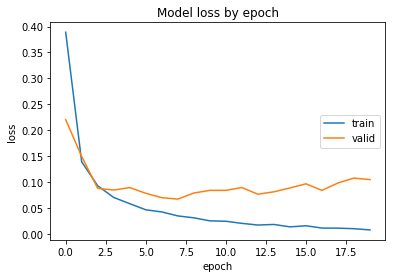

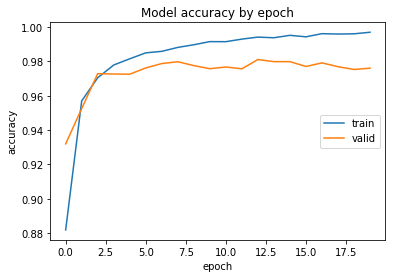

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()

**You should see that over-fitting begins to occur.<br> 
Question 1: WHAT IS THE SIGN OF OVER-FITTING ON ABOVE GRAPH?<br>
Answer: <br>
<br>
There are 2 different methods that can be used to prevent over-fitting.<br>
Question 2: WHAT ARE THOSE 2 OVER-FITTING PREVENTION METHODS?<br>
Answer :<br>
<br>drop out and regularization
Test those 2 methods SEPARATELY below, by copy-pasting the original code, modifying it, and running it. <br>**

In [18]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 20 # we iterate ?? times over the entire training set
kernel_size = 5 # we will use 5x5 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 6 # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.09# dropout after pooling with probability ??
drop_prob_2 = 0.1 # dropout in the FC layer with probability ??
hidden_size = 128 # the FC layer will have 128 neurons
weight_penalty = 0.005 # Factor for weights penalty
model = Sequential()
# FIRST CONVOLUTION+POOLING LAYERS
#   Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), border_mode='same', activation='relu', 
                         data_format="channels_first", input_shape=( 1, 28, 28)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# FIRST CONVOLUTION+POOLING LAYERS
#    Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), border_mode='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# CLASSIFICATION PART: FULLY-CONNECTED LAYER + OUTPUT LAYER
#   Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) ) # Some Dropout regularization (if necessary)
model.add( Dense(num_classes, activation='softmax') )

# DISPLAY THE MODEL ARCHITECTURE INFORMATION
print(model.summary)

# DEFINE THE LOSS FUNCTION AND OPTIMIZER
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# TRAIN THE MODEL
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1, validation_split=0.8) # ...holding out 40% of the data for validation

# EVALUATE THE MODEL ON TEST SET
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!
print("\n EVALUATION [loss, accuracy] on TEST set:")
print(model.evaluate(X_test, Y_test, verbose=1))

/Users/yanis/venv/ApprentissageArtificiel/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28..., padding="same")`
  from ipykernel import kernelapp as app
/Users/yanis/venv/ApprentissageArtificiel/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
/Users/yanis/venv/ApprentissageArtificiel/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x12e969390>>


Train on 11999 samples, validate on 48001 samples
Epoch 1/20


   32/11999 [..............................] - ETA: 7:22 - loss: 2.8407 - acc: 0.0938

   96/11999 [..............................] - ETA: 2:33 - loss: 2.8915 - acc: 0.0625

  192/11999 [..............................] - ETA: 1:20 - loss: 2.8695 - acc: 0.1250

  288/11999 [..............................] - ETA: 55s - loss: 2.8425 - acc: 0.1528 

  352/11999 [..............................] - ETA: 47s - loss: 2.8228 - acc: 0.1534

  416/11999 [>.............................] - ETA: 41s - loss: 2.8111 - acc: 0.1562

  480/11999 [>.............................] - ETA: 36s - loss: 2.7888 - acc: 0.1896

  576/11999 [>.............................] - ETA: 31s - loss: 2.7459 - acc: 0.2292

  672/11999 [>.............................] - ETA: 28s - loss: 2.7112 - acc: 0.2470

  768/11999 [>.............................] - ETA: 25s - loss: 2.6823 - acc: 0.2591

  864/11999 [=>............................] - ETA: 23s - loss: 2.6423 - acc: 0.2801

  960/11999 [=>............................] - ETA: 21s - loss: 2.6028 - acc: 0.2990

 1024/11999 [=>............................] - ETA: 20s - loss: 2.5719 - acc: 0.3135

 1088/11999 [=>............................] - ETA: 19s - loss: 2.5420 - acc: 0.3244

 1152/11999 [=>............................] - ETA: 19s - loss: 2.5173 - acc: 0.3316

 1216/11999 [==>...........................] - ETA: 18s - loss: 2.4842 - acc: 0.3470

 1280/11999 [==>...........................] - ETA: 18s - loss: 2.4509 - acc: 0.3594

 1344/11999 [==>...........................] - ETA: 17s - loss: 2.4203 - acc: 0.3690

 1408/11999 [==>...........................] - ETA: 16s - loss: 2.3829 - acc: 0.3821

 1472/11999 [==>...........................] - ETA: 16s - loss: 2.3437 - acc: 0.3967

 1536/11999 [==>...........................] - ETA: 16s - loss: 2.3180 - acc: 0.4043

 1600/11999 [===>..........................] - ETA: 15s - loss: 2.2856 - acc: 0.4131

 1696/11999 [===>..........................] - ETA: 15s - loss: 2.2318 - acc: 0.4322

 1760/11999 [===>..........................] - ETA: 14s - loss: 2.1947 - acc: 0.4460

 1856/11999 [===>..........................] - ETA: 14s - loss: 2.1555 - acc: 0.4569

 1920/11999 [===>..........................] - ETA: 13s - loss: 2.1256 - acc: 0.4677

 1984/11999 [===>..........................] - ETA: 13s - loss: 2.0980 - acc: 0.4758

 2048/11999 [====>.........................] - ETA: 13s - loss: 2.0734 - acc: 0.4824

 2112/11999 [====>.........................] - ETA: 13s - loss: 2.0435 - acc: 0.4910

 2176/11999 [====>.........................] - ETA: 12s - loss: 2.0218 - acc: 0.4972

 2240/11999 [====>.........................] - ETA: 12s - loss: 1.9981 - acc: 0.5036

 2304/11999 [====>.........................] - ETA: 12s - loss: 1.9774 - acc: 0.5091

 2400/11999 [=====>........................] - ETA: 12s - loss: 1.9500 - acc: 0.5154

 2496/11999 [=====>........................] - ETA: 11s - loss: 1.9192 - acc: 0.5240

 2560/11999 [=====>........................] - ETA: 11s - loss: 1.9003 - acc: 0.5293

 2624/11999 [=====>........................] - ETA: 11s - loss: 1.8810 - acc: 0.5354

 2688/11999 [=====>........................] - ETA: 11s - loss: 1.8636 - acc: 0.5406

 2752/11999 [=====>........................] - ETA: 11s - loss: 1.8467 - acc: 0.5451

 2848/11999 [======>.......................] - ETA: 10s - loss: 1.8251 - acc: 0.5523

 2944/11999 [======>.......................] - ETA: 10s - loss: 1.8126 - acc: 0.5557

 3040/11999 [======>.......................] - ETA: 10s - loss: 1.7864 - acc: 0.5645

 3136/11999 [======>.......................] - ETA: 10s - loss: 1.7686 - acc: 0.5705

 3200/11999 [=======>......................] - ETA: 10s - loss: 1.7518 - acc: 0.5756

 3264/11999 [=======>......................] - ETA: 9s - loss: 1.7357 - acc: 0.5806 

 3328/11999 [=======>......................] - ETA: 9s - loss: 1.7188 - acc: 0.5865

 3424/11999 [=======>......................] - ETA: 9s - loss: 1.7049 - acc: 0.5905

 3488/11999 [=======>......................] - ETA: 9s - loss: 1.6907 - acc: 0.5949

 3552/11999 [=======>......................] - ETA: 9s - loss: 1.6755 - acc: 0.5997

 3616/11999 [========>.....................] - ETA: 9s - loss: 1.6602 - acc: 0.6045

 3680/11999 [========>.....................] - ETA: 9s - loss: 1.6499 - acc: 0.6082

 3744/11999 [========>.....................] - ETA: 8s - loss: 1.6393 - acc: 0.6114

 3808/11999 [========>.....................] - ETA: 8s - loss: 1.6251 - acc: 0.6148

 3872/11999 [========>.....................] - ETA: 8s - loss: 1.6128 - acc: 0.6183

 3936/11999 [========>.....................] - ETA: 8s - loss: 1.6054 - acc: 0.6212

 4000/11999 [=========>....................] - ETA: 8s - loss: 1.5913 - acc: 0.6258

 4064/11999 [=========>....................] - ETA: 8s - loss: 1.5844 - acc: 0.6280

 4128/11999 [=========>....................] - ETA: 8s - loss: 1.5741 - acc: 0.6315

 4192/11999 [=========>....................] - ETA: 8s - loss: 1.5641 - acc: 0.6336

 4288/11999 [=========>....................] - ETA: 8s - loss: 1.5503 - acc: 0.6381

 4352/11999 [=========>....................] - ETA: 7s - loss: 1.5402 - acc: 0.6409

 4416/11999 [==========>...................] - ETA: 7s - loss: 1.5305 - acc: 0.6433

 4480/11999 [==========>...................] - ETA: 7s - loss: 1.5228 - acc: 0.6458

 4544/11999 [==========>...................] - ETA: 7s - loss: 1.5133 - acc: 0.6494

 4608/11999 [==========>...................] - ETA: 7s - loss: 1.5069 - acc: 0.6508

 4672/11999 [==========>...................] - ETA: 7s - loss: 1.4966 - acc: 0.6539

 4736/11999 [==========>...................] - ETA: 7s - loss: 1.4883 - acc: 0.6565

 4832/11999 [===========>..................] - ETA: 7s - loss: 1.4752 - acc: 0.6608

 4896/11999 [===========>..................] - ETA: 7s - loss: 1.4712 - acc: 0.6628

 4992/11999 [===========>..................] - ETA: 7s - loss: 1.4649 - acc: 0.6639

 5088/11999 [===========>..................] - ETA: 6s - loss: 1.4544 - acc: 0.6667

 5184/11999 [===========>..................] - ETA: 6s - loss: 1.4423 - acc: 0.6696

 5280/11999 [============>.................] - ETA: 6s - loss: 1.4331 - acc: 0.6727

 5376/11999 [============>.................] - ETA: 6s - loss: 1.4225 - acc: 0.6758

 5472/11999 [============>.................] - ETA: 6s - loss: 1.4137 - acc: 0.6782

 5536/11999 [============>.................] - ETA: 6s - loss: 1.4065 - acc: 0.6797

 5632/11999 [=============>................] - ETA: 6s - loss: 1.3959 - acc: 0.6829

 5728/11999 [=============>................] - ETA: 6s - loss: 1.3867 - acc: 0.6856

 5792/11999 [=============>................] - ETA: 6s - loss: 1.3824 - acc: 0.6868

 5856/11999 [=============>................] - ETA: 5s - loss: 1.3754 - acc: 0.6895

 5920/11999 [=============>................] - ETA: 5s - loss: 1.3697 - acc: 0.6912

 5984/11999 [=============>................] - ETA: 5s - loss: 1.3638 - acc: 0.6927

 6048/11999 [==============>...............] - ETA: 5s - loss: 1.3596 - acc: 0.6938

 6112/11999 [==============>...............] - ETA: 5s - loss: 1.3546 - acc: 0.6947

 6208/11999 [==============>...............] - ETA: 5s - loss: 1.3482 - acc: 0.6964

 6304/11999 [==============>...............] - ETA: 5s - loss: 1.3416 - acc: 0.6986

 6400/11999 [===============>..............] - ETA: 5s - loss: 1.3337 - acc: 0.7009

 6496/11999 [===============>..............] - ETA: 5s - loss: 1.3256 - acc: 0.7034

 6560/11999 [===============>..............] - ETA: 5s - loss: 1.3193 - acc: 0.7050

 6656/11999 [===============>..............] - ETA: 5s - loss: 1.3107 - acc: 0.7076

 6720/11999 [===============>..............] - ETA: 5s - loss: 1.3061 - acc: 0.7091

 6784/11999 [===============>..............] - ETA: 4s - loss: 1.3009 - acc: 0.7105

 6848/11999 [================>.............] - ETA: 4s - loss: 1.2967 - acc: 0.7116

 6944/11999 [================>.............] - ETA: 4s - loss: 1.2893 - acc: 0.7130

 7008/11999 [================>.............] - ETA: 4s - loss: 1.2846 - acc: 0.7135

 7072/11999 [================>.............] - ETA: 4s - loss: 1.2803 - acc: 0.7151

 7168/11999 [================>.............] - ETA: 4s - loss: 1.2729 - acc: 0.7174

 7264/11999 [=================>............] - ETA: 4s - loss: 1.2645 - acc: 0.7204

 7328/11999 [=================>............] - ETA: 4s - loss: 1.2586 - acc: 0.7220

 7424/11999 [=================>............] - ETA: 4s - loss: 1.2529 - acc: 0.7233

 7520/11999 [=================>............] - ETA: 4s - loss: 1.2448 - acc: 0.7258

 7584/11999 [=================>............] - ETA: 4s - loss: 1.2421 - acc: 0.7267

 7680/11999 [==================>...........] - ETA: 3s - loss: 1.2358 - acc: 0.7285

 7744/11999 [==================>...........] - ETA: 3s - loss: 1.2329 - acc: 0.7288

 7808/11999 [==================>...........] - ETA: 3s - loss: 1.2300 - acc: 0.7293

 7872/11999 [==================>...........] - ETA: 3s - loss: 1.2264 - acc: 0.7302

 7936/11999 [==================>...........] - ETA: 3s - loss: 1.2226 - acc: 0.7310

 8000/11999 [===================>..........] - ETA: 3s - loss: 1.2186 - acc: 0.7321

 8064/11999 [===================>..........] - ETA: 3s - loss: 1.2149 - acc: 0.7331

 8128/11999 [===================>..........] - ETA: 3s - loss: 1.2112 - acc: 0.7344

 8192/11999 [===================>..........] - ETA: 3s - loss: 1.2090 - acc: 0.7350

 8256/11999 [===================>..........] - ETA: 3s - loss: 1.2044 - acc: 0.7362

 8320/11999 [===================>..........] - ETA: 3s - loss: 1.2011 - acc: 0.7373

 8384/11999 [===================>..........] - ETA: 3s - loss: 1.1966 - acc: 0.7388

 8480/11999 [====================>.........] - ETA: 3s - loss: 1.1908 - acc: 0.7400

 8544/11999 [====================>.........] - ETA: 3s - loss: 1.1868 - acc: 0.7411

 8608/11999 [====================>.........] - ETA: 3s - loss: 1.1844 - acc: 0.7416

 8672/11999 [====================>.........] - ETA: 3s - loss: 1.1811 - acc: 0.7423

 8768/11999 [====================>.........] - ETA: 2s - loss: 1.1753 - acc: 0.7441

 8864/11999 [=====================>........] - ETA: 2s - loss: 1.1693 - acc: 0.7459

 8928/11999 [=====================>........] - ETA: 2s - loss: 1.1649 - acc: 0.7472

 8992/11999 [=====================>........] - ETA: 2s - loss: 1.1606 - acc: 0.7484

 9056/11999 [=====================>........] - ETA: 2s - loss: 1.1585 - acc: 0.7489

 9120/11999 [=====================>........] - ETA: 2s - loss: 1.1547 - acc: 0.7502

 9184/11999 [=====================>........] - ETA: 2s - loss: 1.1502 - acc: 0.7514

 9248/11999 [======================>.......] - ETA: 2s - loss: 1.1468 - acc: 0.7524

 9312/11999 [======================>.......] - ETA: 2s - loss: 1.1429 - acc: 0.7535

 9376/11999 [======================>.......] - ETA: 2s - loss: 1.1398 - acc: 0.7545

 9440/11999 [======================>.......] - ETA: 2s - loss: 1.1365 - acc: 0.7553

 9536/11999 [======================>.......] - ETA: 2s - loss: 1.1308 - acc: 0.7567

 9600/11999 [=======================>......] - ETA: 2s - loss: 1.1289 - acc: 0.7572

 9664/11999 [=======================>......] - ETA: 2s - loss: 1.1250 - acc: 0.7583

 9760/11999 [=======================>......] - ETA: 2s - loss: 1.1202 - acc: 0.7593

 9856/11999 [=======================>......] - ETA: 1s - loss: 1.1146 - acc: 0.7611

 9952/11999 [=======================>......] - ETA: 1s - loss: 1.1099 - acc: 0.7626

10016/11999 [========================>.....] - ETA: 1s - loss: 1.1079 - acc: 0.7631

10112/11999 [========================>.....] - ETA: 1s - loss: 1.1042 - acc: 0.7641

10176/11999 [========================>.....] - ETA: 1s - loss: 1.1013 - acc: 0.7649

10240/11999 [========================>.....] - ETA: 1s - loss: 1.0988 - acc: 0.7654

10304/11999 [========================>.....] - ETA: 1s - loss: 1.0959 - acc: 0.7660

10368/11999 [========================>.....] - ETA: 1s - loss: 1.0928 - acc: 0.7668

10464/11999 [=========================>....] - ETA: 1s - loss: 1.0898 - acc: 0.7677

10528/11999 [=========================>....] - ETA: 1s - loss: 1.0872 - acc: 0.7684

10624/11999 [=========================>....] - ETA: 1s - loss: 1.0825 - acc: 0.7698

10688/11999 [=========================>....] - ETA: 1s - loss: 1.0793 - acc: 0.7705

10752/11999 [=========================>....] - ETA: 1s - loss: 1.0774 - acc: 0.7708

10816/11999 [==========================>...] - ETA: 1s - loss: 1.0753 - acc: 0.7715

10912/11999 [==========================>...] - ETA: 0s - loss: 1.0710 - acc: 0.7728

10976/11999 [==========================>...] - ETA: 0s - loss: 1.0683 - acc: 0.7733

11072/11999 [==========================>...] - ETA: 0s - loss: 1.0640 - acc: 0.7744

11136/11999 [==========================>...] - ETA: 0s - loss: 1.0627 - acc: 0.7750

11200/11999 [===========================>..] - ETA: 0s - loss: 1.0600 - acc: 0.7757

11264/11999 [===========================>..] - ETA: 0s - loss: 1.0586 - acc: 0.7761

11328/11999 [===========================>..] - ETA: 0s - loss: 1.0557 - acc: 0.7769

11392/11999 [===========================>..] - ETA: 0s - loss: 1.0535 - acc: 0.7774

11456/11999 [===========================>..] - ETA: 0s - loss: 1.0524 - acc: 0.7776

11520/11999 [===========================>..] - ETA: 0s - loss: 1.0497 - acc: 0.7783

11584/11999 [===========================>..] - ETA: 0s - loss: 1.0474 - acc: 0.7787

11648/11999 [============================>.] - ETA: 0s - loss: 1.0452 - acc: 0.7792

11744/11999 [============================>.] - ETA: 0s - loss: 1.0410 - acc: 0.7803

11840/11999 [============================>.] - ETA: 0s - loss: 1.0379 - acc: 0.7811

11936/11999 [============================>.] - ETA: 0s - loss: 1.0339 - acc: 0.7822

11999/11999 [==============================] - 28s 2ms/step - loss: 1.0321 - acc: 0.7827 - val_loss: 0.5441 - val_acc: 0.9138


Epoch 2/20
   32/11999 [..............................] - ETA: 11s - loss: 0.4868 - acc: 0.9375

   96/11999 [..............................] - ETA: 11s - loss: 0.5458 - acc: 0.9271

  160/11999 [..............................] - ETA: 10s - loss: 0.5740 - acc: 0.9000

  224/11999 [..............................] - ETA: 10s - loss: 0.6101 - acc: 0.8839

  288/11999 [..............................] - ETA: 9s - loss: 0.6335 - acc: 0.8819 

  352/11999 [..............................] - ETA: 9s - loss: 0.6159 - acc: 0.8835

  416/11999 [>.............................] - ETA: 9s - loss: 0.6295 - acc: 0.8702

  480/11999 [>.............................] - ETA: 9s - loss: 0.6203 - acc: 0.8812

  544/11999 [>.............................] - ETA: 9s - loss: 0.6007 - acc: 0.8879

  608/11999 [>.............................] - ETA: 9s - loss: 0.6120 - acc: 0.8832

  672/11999 [>.............................] - ETA: 9s - loss: 0.6037 - acc: 0.8869

  736/11999 [>.............................] - ETA: 9s - loss: 0.6006 - acc: 0.8913

  800/11999 [=>............................] - ETA: 9s - loss: 0.5934 - acc: 0.8925

  864/11999 [=>............................] - ETA: 9s - loss: 0.5984 - acc: 0.8877

  928/11999 [=>............................] - ETA: 9s - loss: 0.5983 - acc: 0.8890

 1024/11999 [=>............................] - ETA: 8s - loss: 0.6025 - acc: 0.8887

 1088/11999 [=>............................] - ETA: 8s - loss: 0.6045 - acc: 0.8888

 1152/11999 [=>............................] - ETA: 8s - loss: 0.5956 - acc: 0.8906

 1216/11999 [==>...........................] - ETA: 8s - loss: 0.5920 - acc: 0.8906

 1280/11999 [==>...........................] - ETA: 8s - loss: 0.6021 - acc: 0.8867

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.5907 - acc: 0.8910

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.5862 - acc: 0.8931

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.5822 - acc: 0.8936

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.5772 - acc: 0.8954

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.5772 - acc: 0.8946

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.5807 - acc: 0.8956

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.5912 - acc: 0.8955

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.5925 - acc: 0.8931

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.5935 - acc: 0.8914

 1984/11999 [===>..........................] - ETA: 7s - loss: 0.5896 - acc: 0.8921

 2048/11999 [====>.........................] - ETA: 7s - loss: 0.5880 - acc: 0.8931

 2144/11999 [====>.........................] - ETA: 7s - loss: 0.5821 - acc: 0.8941

 2208/11999 [====>.........................] - ETA: 7s - loss: 0.5843 - acc: 0.8936

 2272/11999 [====>.........................] - ETA: 7s - loss: 0.5813 - acc: 0.8952

 2336/11999 [====>.........................] - ETA: 7s - loss: 0.5858 - acc: 0.8938

 2400/11999 [=====>........................] - ETA: 7s - loss: 0.5863 - acc: 0.8938

 2464/11999 [=====>........................] - ETA: 7s - loss: 0.5935 - acc: 0.8916

 2528/11999 [=====>........................] - ETA: 7s - loss: 0.5911 - acc: 0.8916

 2592/11999 [=====>........................] - ETA: 7s - loss: 0.5903 - acc: 0.8912

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.5866 - acc: 0.8923

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.5839 - acc: 0.8934

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.5808 - acc: 0.8944

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.5810 - acc: 0.8940

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.5799 - acc: 0.8949

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.5794 - acc: 0.8948

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.5832 - acc: 0.8931

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.5817 - acc: 0.8940

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.5838 - acc: 0.8939

 3232/11999 [=======>......................] - ETA: 6s - loss: 0.5837 - acc: 0.8929

 3296/11999 [=======>......................] - ETA: 6s - loss: 0.5817 - acc: 0.8938

 3392/11999 [=======>......................] - ETA: 6s - loss: 0.5801 - acc: 0.8936

 3488/11999 [=======>......................] - ETA: 6s - loss: 0.5782 - acc: 0.8939

 3552/11999 [=======>......................] - ETA: 6s - loss: 0.5741 - acc: 0.8953

 3616/11999 [========>.....................] - ETA: 6s - loss: 0.5715 - acc: 0.8963

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.5716 - acc: 0.8962

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.5707 - acc: 0.8964

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.5678 - acc: 0.8973

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.5696 - acc: 0.8970

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.5669 - acc: 0.8979

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.5646 - acc: 0.8982

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.5630 - acc: 0.8986

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.5613 - acc: 0.8990

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.5607 - acc: 0.8989

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.5632 - acc: 0.8976

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.5628 - acc: 0.8977

 4416/11999 [==========>...................] - ETA: 6s - loss: 0.5588 - acc: 0.8988

 4480/11999 [==========>...................] - ETA: 5s - loss: 0.5594 - acc: 0.8978

 4544/11999 [==========>...................] - ETA: 5s - loss: 0.5584 - acc: 0.8985

 4608/11999 [==========>...................] - ETA: 5s - loss: 0.5582 - acc: 0.8989

 4704/11999 [==========>...................] - ETA: 5s - loss: 0.5568 - acc: 0.8994

 4768/11999 [==========>...................] - ETA: 5s - loss: 0.5557 - acc: 0.8997

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.5535 - acc: 0.9005

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.5529 - acc: 0.9007

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.5533 - acc: 0.9004

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.5511 - acc: 0.9009

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.5500 - acc: 0.9013

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.5501 - acc: 0.9010

 5248/11999 [============>.................] - ETA: 5s - loss: 0.5473 - acc: 0.9021

 5344/11999 [============>.................] - ETA: 5s - loss: 0.5493 - acc: 0.9016

 5408/11999 [============>.................] - ETA: 5s - loss: 0.5483 - acc: 0.9024

 5472/11999 [============>.................] - ETA: 5s - loss: 0.5475 - acc: 0.9022

 5536/11999 [============>.................] - ETA: 5s - loss: 0.5473 - acc: 0.9026

 5600/11999 [=============>................] - ETA: 5s - loss: 0.5446 - acc: 0.9034

 5664/11999 [=============>................] - ETA: 5s - loss: 0.5427 - acc: 0.9038

 5728/11999 [=============>................] - ETA: 4s - loss: 0.5426 - acc: 0.9036

 5824/11999 [=============>................] - ETA: 4s - loss: 0.5410 - acc: 0.9038

 5888/11999 [=============>................] - ETA: 4s - loss: 0.5400 - acc: 0.9040

 5984/11999 [=============>................] - ETA: 4s - loss: 0.5386 - acc: 0.9044

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.5386 - acc: 0.9043

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.5394 - acc: 0.9041

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.5393 - acc: 0.9040

 6272/11999 [==============>...............] - ETA: 4s - loss: 0.5413 - acc: 0.9034

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.5398 - acc: 0.9036

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.5394 - acc: 0.9039

 6528/11999 [===============>..............] - ETA: 4s - loss: 0.5377 - acc: 0.9046

 6592/11999 [===============>..............] - ETA: 4s - loss: 0.5372 - acc: 0.9046

 6656/11999 [===============>..............] - ETA: 4s - loss: 0.5366 - acc: 0.9046

 6720/11999 [===============>..............] - ETA: 4s - loss: 0.5377 - acc: 0.9043

 6784/11999 [===============>..............] - ETA: 4s - loss: 0.5392 - acc: 0.9039

 6848/11999 [================>.............] - ETA: 4s - loss: 0.5387 - acc: 0.9039

 6912/11999 [================>.............] - ETA: 4s - loss: 0.5386 - acc: 0.9039

 6976/11999 [================>.............] - ETA: 3s - loss: 0.5391 - acc: 0.9034

 7040/11999 [================>.............] - ETA: 3s - loss: 0.5386 - acc: 0.9033

 7104/11999 [================>.............] - ETA: 3s - loss: 0.5383 - acc: 0.9036

 7168/11999 [================>.............] - ETA: 3s - loss: 0.5367 - acc: 0.9039

 7232/11999 [=================>............] - ETA: 3s - loss: 0.5389 - acc: 0.9036

 7296/11999 [=================>............] - ETA: 3s - loss: 0.5394 - acc: 0.9035

 7360/11999 [=================>............] - ETA: 3s - loss: 0.5385 - acc: 0.9038

 7424/11999 [=================>............] - ETA: 3s - loss: 0.5378 - acc: 0.9038

 7488/11999 [=================>............] - ETA: 3s - loss: 0.5382 - acc: 0.9037

 7552/11999 [=================>............] - ETA: 3s - loss: 0.5363 - acc: 0.9041

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.5360 - acc: 0.9040

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.5350 - acc: 0.9043

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.5351 - acc: 0.9043

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.5333 - acc: 0.9047

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.5321 - acc: 0.9051

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.5311 - acc: 0.9052

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.5309 - acc: 0.9051

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.5297 - acc: 0.9053

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.5294 - acc: 0.9053

 8256/11999 [===================>..........] - ETA: 2s - loss: 0.5290 - acc: 0.9054

 8320/11999 [===================>..........] - ETA: 2s - loss: 0.5285 - acc: 0.9055

 8384/11999 [===================>..........] - ETA: 2s - loss: 0.5274 - acc: 0.9059

 8448/11999 [====================>.........] - ETA: 2s - loss: 0.5270 - acc: 0.9059

 8512/11999 [====================>.........] - ETA: 2s - loss: 0.5261 - acc: 0.9060

 8576/11999 [====================>.........] - ETA: 2s - loss: 0.5245 - acc: 0.9065

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.5238 - acc: 0.9064

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.5236 - acc: 0.9061

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.5223 - acc: 0.9066

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.5208 - acc: 0.9072

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.5203 - acc: 0.9071

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.5196 - acc: 0.9071

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.5187 - acc: 0.9074

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.5183 - acc: 0.9075

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.5186 - acc: 0.9074

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.5177 - acc: 0.9075

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.5168 - acc: 0.9076

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.5158 - acc: 0.9077

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.5160 - acc: 0.9075

 9504/11999 [======================>.......] - ETA: 1s - loss: 0.5162 - acc: 0.9075

 9568/11999 [======================>.......] - ETA: 1s - loss: 0.5156 - acc: 0.9076

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.5146 - acc: 0.9077

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.5134 - acc: 0.9079

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.5135 - acc: 0.9080

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.5132 - acc: 0.9080

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.5133 - acc: 0.9078

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.5129 - acc: 0.9079

10016/11999 [========================>.....] - ETA: 1s - loss: 0.5130 - acc: 0.9078

10080/11999 [========================>.....] - ETA: 1s - loss: 0.5128 - acc: 0.9078

10144/11999 [========================>.....] - ETA: 1s - loss: 0.5123 - acc: 0.9078

10208/11999 [========================>.....] - ETA: 1s - loss: 0.5122 - acc: 0.9078

10272/11999 [========================>.....] - ETA: 1s - loss: 0.5114 - acc: 0.9080

10336/11999 [========================>.....] - ETA: 1s - loss: 0.5112 - acc: 0.9081

10432/11999 [=========================>....] - ETA: 1s - loss: 0.5103 - acc: 0.9083

10496/11999 [=========================>....] - ETA: 1s - loss: 0.5101 - acc: 0.9083

10560/11999 [=========================>....] - ETA: 1s - loss: 0.5099 - acc: 0.9083

10624/11999 [=========================>....] - ETA: 1s - loss: 0.5091 - acc: 0.9085

10688/11999 [=========================>....] - ETA: 1s - loss: 0.5101 - acc: 0.9079

10752/11999 [=========================>....] - ETA: 0s - loss: 0.5098 - acc: 0.9080

10848/11999 [==========================>...] - ETA: 0s - loss: 0.5093 - acc: 0.9082

10912/11999 [==========================>...] - ETA: 0s - loss: 0.5091 - acc: 0.9083

10976/11999 [==========================>...] - ETA: 0s - loss: 0.5087 - acc: 0.9083

11040/11999 [==========================>...] - ETA: 0s - loss: 0.5080 - acc: 0.9083

11104/11999 [==========================>...] - ETA: 0s - loss: 0.5075 - acc: 0.9083

11200/11999 [===========================>..] - ETA: 0s - loss: 0.5075 - acc: 0.9085

11264/11999 [===========================>..] - ETA: 0s - loss: 0.5074 - acc: 0.9086

11328/11999 [===========================>..] - ETA: 0s - loss: 0.5067 - acc: 0.9088

11392/11999 [===========================>..] - ETA: 0s - loss: 0.5066 - acc: 0.9087

11456/11999 [===========================>..] - ETA: 0s - loss: 0.5056 - acc: 0.9090

11552/11999 [===========================>..] - ETA: 0s - loss: 0.5047 - acc: 0.9092

11616/11999 [============================>.] - ETA: 0s - loss: 0.5038 - acc: 0.9094

11680/11999 [============================>.] - ETA: 0s - loss: 0.5033 - acc: 0.9095

11744/11999 [============================>.] - ETA: 0s - loss: 0.5024 - acc: 0.9097

11808/11999 [============================>.] - ETA: 0s - loss: 0.5018 - acc: 0.9097

11872/11999 [============================>.] - ETA: 0s - loss: 0.5016 - acc: 0.9097

11936/11999 [============================>.] - ETA: 0s - loss: 0.5016 - acc: 0.9094

11999/11999 [==============================] - 28s 2ms/step - loss: 0.5017 - acc: 0.9093 - val_loss: 0.3697 - val_acc: 0.9401


Epoch 3/20
   32/11999 [..............................] - ETA: 11s - loss: 0.2627 - acc: 1.0000

   96/11999 [..............................] - ETA: 10s - loss: 0.3048 - acc: 0.9479

  192/11999 [..............................] - ETA: 9s - loss: 0.3066 - acc: 0.9531 

  256/11999 [..............................] - ETA: 9s - loss: 0.3470 - acc: 0.9414

  320/11999 [..............................] - ETA: 9s - loss: 0.3617 - acc: 0.9375

  384/11999 [..............................] - ETA: 9s - loss: 0.3644 - acc: 0.9349

  448/11999 [>.............................] - ETA: 9s - loss: 0.3648 - acc: 0.9353

  512/11999 [>.............................] - ETA: 9s - loss: 0.3728 - acc: 0.9336

  576/11999 [>.............................] - ETA: 9s - loss: 0.3711 - acc: 0.9323

  672/11999 [>.............................] - ETA: 8s - loss: 0.3855 - acc: 0.9256

  768/11999 [>.............................] - ETA: 8s - loss: 0.3768 - acc: 0.9284

  864/11999 [=>............................] - ETA: 8s - loss: 0.3786 - acc: 0.9271

  960/11999 [=>............................] - ETA: 8s - loss: 0.3885 - acc: 0.9281

 1024/11999 [=>............................] - ETA: 8s - loss: 0.3919 - acc: 0.9268

 1120/11999 [=>............................] - ETA: 8s - loss: 0.4073 - acc: 0.9268

 1216/11999 [==>...........................] - ETA: 8s - loss: 0.4125 - acc: 0.9260

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.4095 - acc: 0.9268

 1408/11999 [==>...........................] - ETA: 8s - loss: 0.4018 - acc: 0.9297

 1472/11999 [==>...........................] - ETA: 8s - loss: 0.3986 - acc: 0.9300

 1536/11999 [==>...........................] - ETA: 8s - loss: 0.4040 - acc: 0.9277

 1600/11999 [===>..........................] - ETA: 7s - loss: 0.4038 - acc: 0.9269

 1664/11999 [===>..........................] - ETA: 7s - loss: 0.4021 - acc: 0.9279

 1728/11999 [===>..........................] - ETA: 7s - loss: 0.3988 - acc: 0.9288

 1824/11999 [===>..........................] - ETA: 7s - loss: 0.3992 - acc: 0.9304

 1888/11999 [===>..........................] - ETA: 7s - loss: 0.3941 - acc: 0.9327

 1952/11999 [===>..........................] - ETA: 7s - loss: 0.3974 - acc: 0.9319

 2048/11999 [====>.........................] - ETA: 7s - loss: 0.3965 - acc: 0.9321

 2144/11999 [====>.........................] - ETA: 7s - loss: 0.4000 - acc: 0.9305

 2240/11999 [====>.........................] - ETA: 7s - loss: 0.4014 - acc: 0.9286

 2336/11999 [====>.........................] - ETA: 7s - loss: 0.4005 - acc: 0.9281

 2400/11999 [=====>........................] - ETA: 7s - loss: 0.3985 - acc: 0.9287

 2496/11999 [=====>........................] - ETA: 7s - loss: 0.3997 - acc: 0.9267

 2592/11999 [=====>........................] - ETA: 7s - loss: 0.3997 - acc: 0.9259

 2688/11999 [=====>........................] - ETA: 7s - loss: 0.4002 - acc: 0.9252

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.3990 - acc: 0.9256

 2880/11999 [======>.......................] - ETA: 6s - loss: 0.3997 - acc: 0.9253

 2976/11999 [======>.......................] - ETA: 6s - loss: 0.3986 - acc: 0.9254

 3072/11999 [======>.......................] - ETA: 6s - loss: 0.4008 - acc: 0.9245

 3168/11999 [======>.......................] - ETA: 6s - loss: 0.4045 - acc: 0.9242

 3264/11999 [=======>......................] - ETA: 6s - loss: 0.4012 - acc: 0.9256

 3328/11999 [=======>......................] - ETA: 6s - loss: 0.4009 - acc: 0.9258

 3392/11999 [=======>......................] - ETA: 6s - loss: 0.4041 - acc: 0.9245

 3456/11999 [=======>......................] - ETA: 6s - loss: 0.4037 - acc: 0.9245

 3552/11999 [=======>......................] - ETA: 6s - loss: 0.4036 - acc: 0.9245

 3648/11999 [========>.....................] - ETA: 6s - loss: 0.4021 - acc: 0.9249

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.4012 - acc: 0.9257

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.4006 - acc: 0.9259

 3904/11999 [========>.....................] - ETA: 6s - loss: 0.4000 - acc: 0.9260

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.4009 - acc: 0.9257

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.4012 - acc: 0.9252

 4160/11999 [=========>....................] - ETA: 5s - loss: 0.4036 - acc: 0.9248

 4224/11999 [=========>....................] - ETA: 5s - loss: 0.4021 - acc: 0.9252

 4320/11999 [=========>....................] - ETA: 5s - loss: 0.4005 - acc: 0.9259

 4416/11999 [==========>...................] - ETA: 5s - loss: 0.4017 - acc: 0.9255

 4512/11999 [==========>...................] - ETA: 5s - loss: 0.4017 - acc: 0.9253

 4608/11999 [==========>...................] - ETA: 5s - loss: 0.4004 - acc: 0.9256

 4704/11999 [==========>...................] - ETA: 5s - loss: 0.3987 - acc: 0.9262

 4800/11999 [===========>..................] - ETA: 5s - loss: 0.4001 - acc: 0.9258

 4864/11999 [===========>..................] - ETA: 5s - loss: 0.3989 - acc: 0.9262

 4928/11999 [===========>..................] - ETA: 5s - loss: 0.3989 - acc: 0.9263

 4992/11999 [===========>..................] - ETA: 5s - loss: 0.3994 - acc: 0.9261

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.3971 - acc: 0.9267

 5184/11999 [===========>..................] - ETA: 5s - loss: 0.3959 - acc: 0.9267

 5280/11999 [============>.................] - ETA: 5s - loss: 0.3951 - acc: 0.9269

 5376/11999 [============>.................] - ETA: 5s - loss: 0.3961 - acc: 0.9263

 5472/11999 [============>.................] - ETA: 4s - loss: 0.3992 - acc: 0.9256

 5536/11999 [============>.................] - ETA: 4s - loss: 0.3997 - acc: 0.9256

 5600/11999 [=============>................] - ETA: 4s - loss: 0.3979 - acc: 0.9261

 5696/11999 [=============>................] - ETA: 4s - loss: 0.3980 - acc: 0.9261

 5792/11999 [=============>................] - ETA: 4s - loss: 0.3985 - acc: 0.9259

 5888/11999 [=============>................] - ETA: 4s - loss: 0.3988 - acc: 0.9254

 5952/11999 [=============>................] - ETA: 4s - loss: 0.3974 - acc: 0.9261

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.3997 - acc: 0.9254

 6144/11999 [==============>...............] - ETA: 4s - loss: 0.3999 - acc: 0.9256

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.4000 - acc: 0.9255

 6336/11999 [==============>...............] - ETA: 4s - loss: 0.3979 - acc: 0.9265

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.3986 - acc: 0.9266

 6528/11999 [===============>..............] - ETA: 4s - loss: 0.3985 - acc: 0.9266

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.3984 - acc: 0.9268

 6720/11999 [===============>..............] - ETA: 3s - loss: 0.3962 - acc: 0.9275

 6816/11999 [================>.............] - ETA: 3s - loss: 0.3958 - acc: 0.9275

 6880/11999 [================>.............] - ETA: 3s - loss: 0.3956 - acc: 0.9272

 6976/11999 [================>.............] - ETA: 3s - loss: 0.3964 - acc: 0.9269

 7072/11999 [================>.............] - ETA: 3s - loss: 0.3960 - acc: 0.9272

 7136/11999 [================>.............] - ETA: 3s - loss: 0.3969 - acc: 0.9271

 7200/11999 [=================>............] - ETA: 3s - loss: 0.3962 - acc: 0.9271

 7264/11999 [=================>............] - ETA: 3s - loss: 0.3953 - acc: 0.9272

 7328/11999 [=================>............] - ETA: 3s - loss: 0.3960 - acc: 0.9267

 7392/11999 [=================>............] - ETA: 3s - loss: 0.3955 - acc: 0.9268

 7488/11999 [=================>............] - ETA: 3s - loss: 0.3945 - acc: 0.9269

 7552/11999 [=================>............] - ETA: 3s - loss: 0.3946 - acc: 0.9268

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.3946 - acc: 0.9270

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.3936 - acc: 0.9273

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.3924 - acc: 0.9274

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.3916 - acc: 0.9275

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.3906 - acc: 0.9277

 8128/11999 [===================>..........] - ETA: 2s - loss: 0.3901 - acc: 0.9277

 8224/11999 [===================>..........] - ETA: 2s - loss: 0.3900 - acc: 0.9279

 8320/11999 [===================>..........] - ETA: 2s - loss: 0.3903 - acc: 0.9275

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.3889 - acc: 0.9281

 8512/11999 [====================>.........] - ETA: 2s - loss: 0.3879 - acc: 0.9283

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.3871 - acc: 0.9284

 8704/11999 [====================>.........] - ETA: 2s - loss: 0.3864 - acc: 0.9285

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.3853 - acc: 0.9285

 8896/11999 [=====================>........] - ETA: 2s - loss: 0.3839 - acc: 0.9290

 8960/11999 [=====================>........] - ETA: 2s - loss: 0.3831 - acc: 0.9292

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.3824 - acc: 0.9294

 9152/11999 [=====================>........] - ETA: 2s - loss: 0.3813 - acc: 0.9297

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.3807 - acc: 0.9298

 9344/11999 [======================>.......] - ETA: 2s - loss: 0.3804 - acc: 0.9297

 9440/11999 [======================>.......] - ETA: 1s - loss: 0.3789 - acc: 0.9299

 9536/11999 [======================>.......] - ETA: 1s - loss: 0.3782 - acc: 0.9299

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.3773 - acc: 0.9302

 9728/11999 [=======================>......] - ETA: 1s - loss: 0.3776 - acc: 0.9304

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.3771 - acc: 0.9304

 9920/11999 [=======================>......] - ETA: 1s - loss: 0.3757 - acc: 0.9308

10016/11999 [========================>.....] - ETA: 1s - loss: 0.3759 - acc: 0.9307

10112/11999 [========================>.....] - ETA: 1s - loss: 0.3757 - acc: 0.9307

10208/11999 [========================>.....] - ETA: 1s - loss: 0.3746 - acc: 0.9310

10304/11999 [========================>.....] - ETA: 1s - loss: 0.3753 - acc: 0.9306

10400/11999 [=========================>....] - ETA: 1s - loss: 0.3754 - acc: 0.9306

10464/11999 [=========================>....] - ETA: 1s - loss: 0.3749 - acc: 0.9306

10560/11999 [=========================>....] - ETA: 1s - loss: 0.3746 - acc: 0.9305

10656/11999 [=========================>....] - ETA: 1s - loss: 0.3757 - acc: 0.9305

10752/11999 [=========================>....] - ETA: 0s - loss: 0.3746 - acc: 0.9308

10816/11999 [==========================>...] - ETA: 0s - loss: 0.3739 - acc: 0.9310

10912/11999 [==========================>...] - ETA: 0s - loss: 0.3728 - acc: 0.9314

11008/11999 [==========================>...] - ETA: 0s - loss: 0.3723 - acc: 0.9313

11104/11999 [==========================>...] - ETA: 0s - loss: 0.3718 - acc: 0.9313

11200/11999 [===========================>..] - ETA: 0s - loss: 0.3713 - acc: 0.9312

11264/11999 [===========================>..] - ETA: 0s - loss: 0.3711 - acc: 0.9310

11328/11999 [===========================>..] - ETA: 0s - loss: 0.3704 - acc: 0.9312

11424/11999 [===========================>..] - ETA: 0s - loss: 0.3700 - acc: 0.9315

11520/11999 [===========================>..] - ETA: 0s - loss: 0.3701 - acc: 0.9313

11584/11999 [===========================>..] - ETA: 0s - loss: 0.3704 - acc: 0.9309

11648/11999 [============================>.] - ETA: 0s - loss: 0.3706 - acc: 0.9307

11744/11999 [============================>.] - ETA: 0s - loss: 0.3698 - acc: 0.9309

11840/11999 [============================>.] - ETA: 0s - loss: 0.3695 - acc: 0.9310

11936/11999 [============================>.] - ETA: 0s - loss: 0.3705 - acc: 0.9306

11999/11999 [==============================] - 26s 2ms/step - loss: 0.3704 - acc: 0.9307 - val_loss: 0.3025 - val_acc: 0.9443


Epoch 4/20
   32/11999 [..............................] - ETA: 11s - loss: 0.2578 - acc: 0.9375

   96/11999 [..............................] - ETA: 10s - loss: 0.2842 - acc: 0.9375

  160/11999 [..............................] - ETA: 9s - loss: 0.2774 - acc: 0.9313 

  256/11999 [..............................] - ETA: 9s - loss: 0.2549 - acc: 0.9570

  320/11999 [..............................] - ETA: 9s - loss: 0.2501 - acc: 0.9594

  384/11999 [..............................] - ETA: 9s - loss: 0.2726 - acc: 0.9505

  448/11999 [>.............................] - ETA: 9s - loss: 0.2751 - acc: 0.9531

  512/11999 [>.............................] - ETA: 9s - loss: 0.2839 - acc: 0.9512

  576/11999 [>.............................] - ETA: 9s - loss: 0.2729 - acc: 0.9549

  640/11999 [>.............................] - ETA: 9s - loss: 0.2673 - acc: 0.9547

  704/11999 [>.............................] - ETA: 9s - loss: 0.2819 - acc: 0.9474

  768/11999 [>.............................] - ETA: 9s - loss: 0.2823 - acc: 0.9479

  832/11999 [=>............................] - ETA: 9s - loss: 0.2988 - acc: 0.9447

  896/11999 [=>............................] - ETA: 9s - loss: 0.2967 - acc: 0.9453

  960/11999 [=>............................] - ETA: 9s - loss: 0.3070 - acc: 0.9427

 1024/11999 [=>............................] - ETA: 9s - loss: 0.3024 - acc: 0.9453

 1088/11999 [=>............................] - ETA: 9s - loss: 0.2986 - acc: 0.9476

 1152/11999 [=>............................] - ETA: 9s - loss: 0.2923 - acc: 0.9497

 1216/11999 [==>...........................] - ETA: 9s - loss: 0.2946 - acc: 0.9465

 1280/11999 [==>...........................] - ETA: 8s - loss: 0.3011 - acc: 0.9437

 1344/11999 [==>...........................] - ETA: 8s - loss: 0.3012 - acc: 0.9442

 1408/11999 [==>...........................] - ETA: 8s - loss: 0.3022 - acc: 0.9446

 1472/11999 [==>...........................] - ETA: 8s - loss: 0.3044 - acc: 0.9450

 1536/11999 [==>...........................] - ETA: 8s - loss: 0.3031 - acc: 0.9453

 1600/11999 [===>..........................] - ETA: 8s - loss: 0.3018 - acc: 0.9450

 1664/11999 [===>..........................] - ETA: 8s - loss: 0.3028 - acc: 0.9447

 1728/11999 [===>..........................] - ETA: 8s - loss: 0.3001 - acc: 0.9456

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.3006 - acc: 0.9449

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.3005 - acc: 0.9441

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.2970 - acc: 0.9449

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.3021 - acc: 0.9431

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.3041 - acc: 0.9420

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.3050 - acc: 0.9418

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.3046 - acc: 0.9412

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.3090 - acc: 0.9402

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.3096 - acc: 0.9393

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.3082 - acc: 0.9392

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.3071 - acc: 0.9400

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.3067 - acc: 0.9403

 2528/11999 [=====>........................] - ETA: 8s - loss: 0.3115 - acc: 0.9399

 2592/11999 [=====>........................] - ETA: 8s - loss: 0.3138 - acc: 0.9394

 2656/11999 [=====>........................] - ETA: 8s - loss: 0.3159 - acc: 0.9390

 2720/11999 [=====>........................] - ETA: 8s - loss: 0.3130 - acc: 0.9401

 2784/11999 [=====>........................] - ETA: 8s - loss: 0.3153 - acc: 0.9397

 2848/11999 [======>.......................] - ETA: 8s - loss: 0.3176 - acc: 0.9382

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.3185 - acc: 0.9382

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.3160 - acc: 0.9392

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.3141 - acc: 0.9395

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.3155 - acc: 0.9381

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.3149 - acc: 0.9381

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.3159 - acc: 0.9381

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.3144 - acc: 0.9387

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.3180 - acc: 0.9384

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.3170 - acc: 0.9393

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.3176 - acc: 0.9389

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.3168 - acc: 0.9392

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.3188 - acc: 0.9392

 3680/11999 [========>.....................] - ETA: 7s - loss: 0.3171 - acc: 0.9397

 3776/11999 [========>.....................] - ETA: 7s - loss: 0.3166 - acc: 0.9401

 3840/11999 [========>.....................] - ETA: 7s - loss: 0.3146 - acc: 0.9411

 3904/11999 [========>.....................] - ETA: 6s - loss: 0.3178 - acc: 0.9408

 3968/11999 [========>.....................] - ETA: 6s - loss: 0.3166 - acc: 0.9413

 4032/11999 [=========>....................] - ETA: 6s - loss: 0.3158 - acc: 0.9417

 4096/11999 [=========>....................] - ETA: 6s - loss: 0.3137 - acc: 0.9426

 4160/11999 [=========>....................] - ETA: 6s - loss: 0.3136 - acc: 0.9430

 4224/11999 [=========>....................] - ETA: 6s - loss: 0.3121 - acc: 0.9437

 4288/11999 [=========>....................] - ETA: 6s - loss: 0.3130 - acc: 0.9431

 4352/11999 [=========>....................] - ETA: 6s - loss: 0.3142 - acc: 0.9426

 4416/11999 [==========>...................] - ETA: 6s - loss: 0.3139 - acc: 0.9420

 4480/11999 [==========>...................] - ETA: 6s - loss: 0.3135 - acc: 0.9420

 4544/11999 [==========>...................] - ETA: 6s - loss: 0.3140 - acc: 0.9412

 4608/11999 [==========>...................] - ETA: 6s - loss: 0.3150 - acc: 0.9405

 4672/11999 [==========>...................] - ETA: 6s - loss: 0.3144 - acc: 0.9405

 4736/11999 [==========>...................] - ETA: 6s - loss: 0.3154 - acc: 0.9402

 4800/11999 [===========>..................] - ETA: 6s - loss: 0.3174 - acc: 0.9390

 4864/11999 [===========>..................] - ETA: 6s - loss: 0.3169 - acc: 0.9389

 4928/11999 [===========>..................] - ETA: 6s - loss: 0.3177 - acc: 0.9389

 4992/11999 [===========>..................] - ETA: 5s - loss: 0.3163 - acc: 0.9391

 5056/11999 [===========>..................] - ETA: 5s - loss: 0.3186 - acc: 0.9387

 5120/11999 [===========>..................] - ETA: 5s - loss: 0.3188 - acc: 0.9381

 5184/11999 [===========>..................] - ETA: 5s - loss: 0.3183 - acc: 0.9379

 5248/11999 [============>.................] - ETA: 5s - loss: 0.3175 - acc: 0.9385

 5312/11999 [============>.................] - ETA: 5s - loss: 0.3165 - acc: 0.9390

 5376/11999 [============>.................] - ETA: 5s - loss: 0.3165 - acc: 0.9390

 5440/11999 [============>.................] - ETA: 5s - loss: 0.3170 - acc: 0.9390

 5504/11999 [============>.................] - ETA: 5s - loss: 0.3162 - acc: 0.9390

 5568/11999 [============>.................] - ETA: 5s - loss: 0.3158 - acc: 0.9389

 5632/11999 [=============>................] - ETA: 5s - loss: 0.3147 - acc: 0.9393

 5696/11999 [=============>................] - ETA: 5s - loss: 0.3139 - acc: 0.9394

 5760/11999 [=============>................] - ETA: 5s - loss: 0.3128 - acc: 0.9398

 5824/11999 [=============>................] - ETA: 5s - loss: 0.3115 - acc: 0.9402

 5888/11999 [=============>................] - ETA: 5s - loss: 0.3110 - acc: 0.9402

 5952/11999 [=============>................] - ETA: 5s - loss: 0.3098 - acc: 0.9407

 6016/11999 [==============>...............] - ETA: 5s - loss: 0.3110 - acc: 0.9405

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.3110 - acc: 0.9403

 6208/11999 [==============>...............] - ETA: 4s - loss: 0.3108 - acc: 0.9399

 6272/11999 [==============>...............] - ETA: 4s - loss: 0.3095 - acc: 0.9404

 6336/11999 [==============>...............] - ETA: 4s - loss: 0.3105 - acc: 0.9400

 6400/11999 [===============>..............] - ETA: 4s - loss: 0.3101 - acc: 0.9400

 6464/11999 [===============>..............] - ETA: 4s - loss: 0.3094 - acc: 0.9401

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.3090 - acc: 0.9401

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.3100 - acc: 0.9396

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.3094 - acc: 0.9396

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.3092 - acc: 0.9394

 6816/11999 [================>.............] - ETA: 4s - loss: 0.3082 - acc: 0.9396

 6880/11999 [================>.............] - ETA: 4s - loss: 0.3093 - acc: 0.9395

 6944/11999 [================>.............] - ETA: 4s - loss: 0.3091 - acc: 0.9395

 7008/11999 [================>.............] - ETA: 4s - loss: 0.3091 - acc: 0.9395

 7072/11999 [================>.............] - ETA: 4s - loss: 0.3085 - acc: 0.9395

 7136/11999 [================>.............] - ETA: 4s - loss: 0.3087 - acc: 0.9395

 7232/11999 [=================>............] - ETA: 4s - loss: 0.3073 - acc: 0.9399

 7296/11999 [=================>............] - ETA: 3s - loss: 0.3072 - acc: 0.9397

 7360/11999 [=================>............] - ETA: 3s - loss: 0.3069 - acc: 0.9397

 7424/11999 [=================>............] - ETA: 3s - loss: 0.3057 - acc: 0.9401

 7488/11999 [=================>............] - ETA: 3s - loss: 0.3051 - acc: 0.9400

 7552/11999 [=================>............] - ETA: 3s - loss: 0.3046 - acc: 0.9400

 7616/11999 [==================>...........] - ETA: 3s - loss: 0.3041 - acc: 0.9400

 7680/11999 [==================>...........] - ETA: 3s - loss: 0.3051 - acc: 0.9398

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.3050 - acc: 0.9400

 7808/11999 [==================>...........] - ETA: 3s - loss: 0.3051 - acc: 0.9399

 7872/11999 [==================>...........] - ETA: 3s - loss: 0.3048 - acc: 0.9400

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.3045 - acc: 0.9400

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.3048 - acc: 0.9400

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.3052 - acc: 0.9400

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.3050 - acc: 0.9401

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.3048 - acc: 0.9402

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.3041 - acc: 0.9404

 8320/11999 [===================>..........] - ETA: 3s - loss: 0.3030 - acc: 0.9409

 8384/11999 [===================>..........] - ETA: 3s - loss: 0.3024 - acc: 0.9411

 8448/11999 [====================>.........] - ETA: 2s - loss: 0.3027 - acc: 0.9412

 8512/11999 [====================>.........] - ETA: 2s - loss: 0.3032 - acc: 0.9410

 8576/11999 [====================>.........] - ETA: 2s - loss: 0.3029 - acc: 0.9411

 8640/11999 [====================>.........] - ETA: 2s - loss: 0.3025 - acc: 0.9412

 8704/11999 [====================>.........] - ETA: 2s - loss: 0.3019 - acc: 0.9413

 8768/11999 [====================>.........] - ETA: 2s - loss: 0.3015 - acc: 0.9413

 8832/11999 [=====================>........] - ETA: 2s - loss: 0.3011 - acc: 0.9413

 8896/11999 [=====================>........] - ETA: 2s - loss: 0.3012 - acc: 0.9411

 8960/11999 [=====================>........] - ETA: 2s - loss: 0.3019 - acc: 0.9410

 9024/11999 [=====================>........] - ETA: 2s - loss: 0.3011 - acc: 0.9413

 9088/11999 [=====================>........] - ETA: 2s - loss: 0.3010 - acc: 0.9412

 9152/11999 [=====================>........] - ETA: 2s - loss: 0.3012 - acc: 0.9414

 9216/11999 [======================>.......] - ETA: 2s - loss: 0.3019 - acc: 0.9410

 9280/11999 [======================>.......] - ETA: 2s - loss: 0.3016 - acc: 0.9408

 9344/11999 [======================>.......] - ETA: 2s - loss: 0.3014 - acc: 0.9409

 9408/11999 [======================>.......] - ETA: 2s - loss: 0.3012 - acc: 0.9409

 9472/11999 [======================>.......] - ETA: 2s - loss: 0.3009 - acc: 0.9409

 9536/11999 [======================>.......] - ETA: 2s - loss: 0.3007 - acc: 0.9410

 9600/11999 [=======================>......] - ETA: 1s - loss: 0.2995 - acc: 0.9414

 9664/11999 [=======================>......] - ETA: 1s - loss: 0.2989 - acc: 0.9414

 9728/11999 [=======================>......] - ETA: 1s - loss: 0.2987 - acc: 0.9416

 9792/11999 [=======================>......] - ETA: 1s - loss: 0.2981 - acc: 0.9418

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.2982 - acc: 0.9416

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.2979 - acc: 0.9418

10016/11999 [========================>.....] - ETA: 1s - loss: 0.2983 - acc: 0.9416

10080/11999 [========================>.....] - ETA: 1s - loss: 0.2981 - acc: 0.9417

10144/11999 [========================>.....] - ETA: 1s - loss: 0.2982 - acc: 0.9416

10208/11999 [========================>.....] - ETA: 1s - loss: 0.2983 - acc: 0.9415

10272/11999 [========================>.....] - ETA: 1s - loss: 0.2987 - acc: 0.9414

10336/11999 [========================>.....] - ETA: 1s - loss: 0.2984 - acc: 0.9415

10400/11999 [=========================>....] - ETA: 1s - loss: 0.2984 - acc: 0.9414

10464/11999 [=========================>....] - ETA: 1s - loss: 0.2986 - acc: 0.9415

10528/11999 [=========================>....] - ETA: 1s - loss: 0.2985 - acc: 0.9414

10592/11999 [=========================>....] - ETA: 1s - loss: 0.2984 - acc: 0.9415

10656/11999 [=========================>....] - ETA: 1s - loss: 0.2979 - acc: 0.9415

10720/11999 [=========================>....] - ETA: 1s - loss: 0.2971 - acc: 0.9417

10784/11999 [=========================>....] - ETA: 1s - loss: 0.2969 - acc: 0.9418

10848/11999 [==========================>...] - ETA: 0s - loss: 0.2965 - acc: 0.9418

10912/11999 [==========================>...] - ETA: 0s - loss: 0.2957 - acc: 0.9420

10976/11999 [==========================>...] - ETA: 0s - loss: 0.2952 - acc: 0.9421

11040/11999 [==========================>...] - ETA: 0s - loss: 0.2949 - acc: 0.9422

11104/11999 [==========================>...] - ETA: 0s - loss: 0.2952 - acc: 0.9419

11168/11999 [==========================>...] - ETA: 0s - loss: 0.2951 - acc: 0.9420

11232/11999 [===========================>..] - ETA: 0s - loss: 0.2944 - acc: 0.9421

11296/11999 [===========================>..] - ETA: 0s - loss: 0.2938 - acc: 0.9422

11360/11999 [===========================>..] - ETA: 0s - loss: 0.2939 - acc: 0.9423

11424/11999 [===========================>..] - ETA: 0s - loss: 0.2933 - acc: 0.9424

11488/11999 [===========================>..] - ETA: 0s - loss: 0.2934 - acc: 0.9424

11552/11999 [===========================>..] - ETA: 0s - loss: 0.2937 - acc: 0.9423

11616/11999 [============================>.] - ETA: 0s - loss: 0.2937 - acc: 0.9422

11680/11999 [============================>.] - ETA: 0s - loss: 0.2932 - acc: 0.9424

11744/11999 [============================>.] - ETA: 0s - loss: 0.2934 - acc: 0.9424

11808/11999 [============================>.] - ETA: 0s - loss: 0.2929 - acc: 0.9426

11872/11999 [============================>.] - ETA: 0s - loss: 0.2928 - acc: 0.9426

11936/11999 [============================>.] - ETA: 0s - loss: 0.2924 - acc: 0.9427

11999/11999 [==============================] - 29s 2ms/step - loss: 0.2920 - acc: 0.9427 - val_loss: 0.2533 - val_acc: 0.9516


Epoch 5/20
   32/11999 [..............................] - ETA: 15s - loss: 0.3231 - acc: 0.9062

   96/11999 [..............................] - ETA: 13s - loss: 0.2605 - acc: 0.9479

  160/11999 [..............................] - ETA: 13s - loss: 0.2759 - acc: 0.9437

  224/11999 [..............................] - ETA: 13s - loss: 0.2663 - acc: 0.9509

  288/11999 [..............................] - ETA: 13s - loss: 0.2747 - acc: 0.9479

  352/11999 [..............................] - ETA: 13s - loss: 0.2694 - acc: 0.9460

  416/11999 [>.............................] - ETA: 13s - loss: 0.2707 - acc: 0.9471

  480/11999 [>.............................] - ETA: 13s - loss: 0.2635 - acc: 0.9500

  544/11999 [>.............................] - ETA: 13s - loss: 0.2655 - acc: 0.9485

  608/11999 [>.............................] - ETA: 12s - loss: 0.2620 - acc: 0.9490

  672/11999 [>.............................] - ETA: 12s - loss: 0.2624 - acc: 0.9479

  736/11999 [>.............................] - ETA: 12s - loss: 0.2651 - acc: 0.9470

  800/11999 [=>............................] - ETA: 12s - loss: 0.2694 - acc: 0.9463

  864/11999 [=>............................] - ETA: 12s - loss: 0.2682 - acc: 0.9468

  928/11999 [=>............................] - ETA: 12s - loss: 0.2698 - acc: 0.9450

  992/11999 [=>............................] - ETA: 12s - loss: 0.2644 - acc: 0.9456

 1056/11999 [=>............................] - ETA: 12s - loss: 0.2558 - acc: 0.9489

 1120/11999 [=>............................] - ETA: 12s - loss: 0.2543 - acc: 0.9500

 1184/11999 [=>............................] - ETA: 12s - loss: 0.2527 - acc: 0.9510

 1248/11999 [==>...........................] - ETA: 11s - loss: 0.2507 - acc: 0.9511

 1312/11999 [==>...........................] - ETA: 11s - loss: 0.2520 - acc: 0.9489

 1376/11999 [==>...........................] - ETA: 11s - loss: 0.2566 - acc: 0.9469

 1440/11999 [==>...........................] - ETA: 11s - loss: 0.2562 - acc: 0.9479

 1536/11999 [==>...........................] - ETA: 11s - loss: 0.2585 - acc: 0.9479

 1600/11999 [===>..........................] - ETA: 10s - loss: 0.2617 - acc: 0.9481

 1664/11999 [===>..........................] - ETA: 10s - loss: 0.2636 - acc: 0.9471

 1728/11999 [===>..........................] - ETA: 10s - loss: 0.2642 - acc: 0.9462

 1792/11999 [===>..........................] - ETA: 10s - loss: 0.2670 - acc: 0.9448

 1856/11999 [===>..........................] - ETA: 10s - loss: 0.2649 - acc: 0.9456

 1920/11999 [===>..........................] - ETA: 10s - loss: 0.2633 - acc: 0.9448

 1984/11999 [===>..........................] - ETA: 10s - loss: 0.2602 - acc: 0.9461

 2048/11999 [====>.........................] - ETA: 9s - loss: 0.2614 - acc: 0.9448 

 2112/11999 [====>.........................] - ETA: 9s - loss: 0.2670 - acc: 0.9446

 2176/11999 [====>.........................] - ETA: 9s - loss: 0.2666 - acc: 0.9444

 2240/11999 [====>.........................] - ETA: 9s - loss: 0.2675 - acc: 0.9433

 2304/11999 [====>.........................] - ETA: 9s - loss: 0.2680 - acc: 0.9427

 2368/11999 [====>.........................] - ETA: 9s - loss: 0.2662 - acc: 0.9430

 2432/11999 [=====>........................] - ETA: 9s - loss: 0.2676 - acc: 0.9412

 2496/11999 [=====>........................] - ETA: 9s - loss: 0.2678 - acc: 0.9415

 2560/11999 [=====>........................] - ETA: 9s - loss: 0.2651 - acc: 0.9426

 2624/11999 [=====>........................] - ETA: 9s - loss: 0.2636 - acc: 0.9436

 2688/11999 [=====>........................] - ETA: 9s - loss: 0.2680 - acc: 0.9431

 2752/11999 [=====>........................] - ETA: 8s - loss: 0.2661 - acc: 0.9437

 2816/11999 [======>.......................] - ETA: 8s - loss: 0.2676 - acc: 0.9432

 2880/11999 [======>.......................] - ETA: 8s - loss: 0.2653 - acc: 0.9441

 2944/11999 [======>.......................] - ETA: 8s - loss: 0.2689 - acc: 0.9426

 3008/11999 [======>.......................] - ETA: 8s - loss: 0.2684 - acc: 0.9428

 3072/11999 [======>.......................] - ETA: 8s - loss: 0.2676 - acc: 0.9434

 3136/11999 [======>.......................] - ETA: 8s - loss: 0.2685 - acc: 0.9429

 3200/11999 [=======>......................] - ETA: 8s - loss: 0.2668 - acc: 0.9437

 3264/11999 [=======>......................] - ETA: 8s - loss: 0.2668 - acc: 0.9433

 3328/11999 [=======>......................] - ETA: 8s - loss: 0.2657 - acc: 0.9441

 3392/11999 [=======>......................] - ETA: 8s - loss: 0.2660 - acc: 0.9446

 3456/11999 [=======>......................] - ETA: 8s - loss: 0.2643 - acc: 0.9453

 3520/11999 [=======>......................] - ETA: 8s - loss: 0.2637 - acc: 0.9452

 3584/11999 [=======>......................] - ETA: 8s - loss: 0.2613 - acc: 0.9461

 3648/11999 [========>.....................] - ETA: 8s - loss: 0.2611 - acc: 0.9460

 3712/11999 [========>.....................] - ETA: 8s - loss: 0.2597 - acc: 0.9467

 3776/11999 [========>.....................] - ETA: 7s - loss: 0.2617 - acc: 0.9460

 3840/11999 [========>.....................] - ETA: 7s - loss: 0.2609 - acc: 0.9464

 3904/11999 [========>.....................] - ETA: 7s - loss: 0.2597 - acc: 0.9467

 3968/11999 [========>.....................] - ETA: 7s - loss: 0.2591 - acc: 0.9473

 4032/11999 [=========>....................] - ETA: 7s - loss: 0.2582 - acc: 0.9477

 4096/11999 [=========>....................] - ETA: 7s - loss: 0.2570 - acc: 0.9482

 4160/11999 [=========>....................] - ETA: 7s - loss: 0.2573 - acc: 0.9481

 4224/11999 [=========>....................] - ETA: 7s - loss: 0.2551 - acc: 0.9489

 4288/11999 [=========>....................] - ETA: 7s - loss: 0.2549 - acc: 0.9489

 4352/11999 [=========>....................] - ETA: 7s - loss: 0.2564 - acc: 0.9483

 4416/11999 [==========>...................] - ETA: 7s - loss: 0.2571 - acc: 0.9477

 4480/11999 [==========>...................] - ETA: 7s - loss: 0.2564 - acc: 0.9480

 4576/11999 [==========>...................] - ETA: 7s - loss: 0.2551 - acc: 0.9482

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.2550 - acc: 0.9481

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.2570 - acc: 0.9475

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.2572 - acc: 0.9476

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.2568 - acc: 0.9481

 4896/11999 [===========>..................] - ETA: 6s - loss: 0.2558 - acc: 0.9483

 4960/11999 [===========>..................] - ETA: 6s - loss: 0.2565 - acc: 0.9482

 5024/11999 [===========>..................] - ETA: 6s - loss: 0.2561 - acc: 0.9484

 5088/11999 [===========>..................] - ETA: 6s - loss: 0.2553 - acc: 0.9487

 5152/11999 [===========>..................] - ETA: 6s - loss: 0.2545 - acc: 0.9488

 5216/11999 [============>.................] - ETA: 6s - loss: 0.2561 - acc: 0.9486

 5280/11999 [============>.................] - ETA: 6s - loss: 0.2566 - acc: 0.9481

 5344/11999 [============>.................] - ETA: 6s - loss: 0.2565 - acc: 0.9482

 5408/11999 [============>.................] - ETA: 6s - loss: 0.2569 - acc: 0.9480

 5472/11999 [============>.................] - ETA: 6s - loss: 0.2560 - acc: 0.9483

 5568/11999 [============>.................] - ETA: 6s - loss: 0.2566 - acc: 0.9483

 5632/11999 [=============>................] - ETA: 5s - loss: 0.2554 - acc: 0.9489

 5696/11999 [=============>................] - ETA: 5s - loss: 0.2570 - acc: 0.9487

 5760/11999 [=============>................] - ETA: 5s - loss: 0.2572 - acc: 0.9481

 5824/11999 [=============>................] - ETA: 5s - loss: 0.2588 - acc: 0.9478

 5888/11999 [=============>................] - ETA: 5s - loss: 0.2592 - acc: 0.9475

 5952/11999 [=============>................] - ETA: 5s - loss: 0.2588 - acc: 0.9476

 6016/11999 [==============>...............] - ETA: 5s - loss: 0.2583 - acc: 0.9480

 6080/11999 [==============>...............] - ETA: 5s - loss: 0.2585 - acc: 0.9480

 6144/11999 [==============>...............] - ETA: 5s - loss: 0.2583 - acc: 0.9479

 6208/11999 [==============>...............] - ETA: 5s - loss: 0.2576 - acc: 0.9481

 6272/11999 [==============>...............] - ETA: 5s - loss: 0.2566 - acc: 0.9485

 6336/11999 [==============>...............] - ETA: 5s - loss: 0.2568 - acc: 0.9484

 6400/11999 [===============>..............] - ETA: 5s - loss: 0.2558 - acc: 0.9486

 6464/11999 [===============>..............] - ETA: 5s - loss: 0.2571 - acc: 0.9477

 6528/11999 [===============>..............] - ETA: 5s - loss: 0.2568 - acc: 0.9476

 6592/11999 [===============>..............] - ETA: 4s - loss: 0.2567 - acc: 0.9478

 6656/11999 [===============>..............] - ETA: 4s - loss: 0.2568 - acc: 0.9479

 6720/11999 [===============>..............] - ETA: 4s - loss: 0.2561 - acc: 0.9482

 6784/11999 [===============>..............] - ETA: 4s - loss: 0.2557 - acc: 0.9481

 6848/11999 [================>.............] - ETA: 4s - loss: 0.2554 - acc: 0.9480

 6912/11999 [================>.............] - ETA: 4s - loss: 0.2546 - acc: 0.9484

 6976/11999 [================>.............] - ETA: 4s - loss: 0.2542 - acc: 0.9487

 7040/11999 [================>.............] - ETA: 4s - loss: 0.2536 - acc: 0.9490

 7104/11999 [================>.............] - ETA: 4s - loss: 0.2538 - acc: 0.9488

 7168/11999 [================>.............] - ETA: 4s - loss: 0.2529 - acc: 0.9491

 7232/11999 [=================>............] - ETA: 4s - loss: 0.2525 - acc: 0.9493

 7296/11999 [=================>............] - ETA: 4s - loss: 0.2517 - acc: 0.9496

 7360/11999 [=================>............] - ETA: 4s - loss: 0.2512 - acc: 0.9495

 7424/11999 [=================>............] - ETA: 4s - loss: 0.2505 - acc: 0.9496

 7488/11999 [=================>............] - ETA: 4s - loss: 0.2531 - acc: 0.9489

 7552/11999 [=================>............] - ETA: 4s - loss: 0.2527 - acc: 0.9489

 7616/11999 [==================>...........] - ETA: 3s - loss: 0.2524 - acc: 0.9488

 7680/11999 [==================>...........] - ETA: 3s - loss: 0.2524 - acc: 0.9488

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.2519 - acc: 0.9489

 7808/11999 [==================>...........] - ETA: 3s - loss: 0.2524 - acc: 0.9486

 7872/11999 [==================>...........] - ETA: 3s - loss: 0.2522 - acc: 0.9487

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.2518 - acc: 0.9487

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.2513 - acc: 0.9487

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.2515 - acc: 0.9487

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.2507 - acc: 0.9491

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.2508 - acc: 0.9490

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.2515 - acc: 0.9486

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.2511 - acc: 0.9488

 8416/11999 [====================>.........] - ETA: 3s - loss: 0.2518 - acc: 0.9487

 8480/11999 [====================>.........] - ETA: 3s - loss: 0.2520 - acc: 0.9483

 8544/11999 [====================>.........] - ETA: 3s - loss: 0.2513 - acc: 0.9486

 8608/11999 [====================>.........] - ETA: 3s - loss: 0.2511 - acc: 0.9485

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.2515 - acc: 0.9486

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.2529 - acc: 0.9481

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.2525 - acc: 0.9483

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.2521 - acc: 0.9483

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.2517 - acc: 0.9485

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.2511 - acc: 0.9484

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.2506 - acc: 0.9485

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.2505 - acc: 0.9488

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.2529 - acc: 0.9482

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.2529 - acc: 0.9481

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.2521 - acc: 0.9485

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.2522 - acc: 0.9483

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.2516 - acc: 0.9484

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.2514 - acc: 0.9483

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.2509 - acc: 0.9485

 9632/11999 [=======================>......] - ETA: 2s - loss: 0.2507 - acc: 0.9485

 9696/11999 [=======================>......] - ETA: 2s - loss: 0.2501 - acc: 0.9488

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.2498 - acc: 0.9488

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.2495 - acc: 0.9488

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.2490 - acc: 0.9490

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.2490 - acc: 0.9490

10016/11999 [========================>.....] - ETA: 1s - loss: 0.2491 - acc: 0.9489

10080/11999 [========================>.....] - ETA: 1s - loss: 0.2486 - acc: 0.9490

10144/11999 [========================>.....] - ETA: 1s - loss: 0.2488 - acc: 0.9489

10208/11999 [========================>.....] - ETA: 1s - loss: 0.2483 - acc: 0.9491

10272/11999 [========================>.....] - ETA: 1s - loss: 0.2478 - acc: 0.9492

10336/11999 [========================>.....] - ETA: 1s - loss: 0.2478 - acc: 0.9491

10400/11999 [=========================>....] - ETA: 1s - loss: 0.2476 - acc: 0.9492

10464/11999 [=========================>....] - ETA: 1s - loss: 0.2470 - acc: 0.9494

10528/11999 [=========================>....] - ETA: 1s - loss: 0.2472 - acc: 0.9493

10592/11999 [=========================>....] - ETA: 1s - loss: 0.2472 - acc: 0.9493

10656/11999 [=========================>....] - ETA: 1s - loss: 0.2470 - acc: 0.9494

10720/11999 [=========================>....] - ETA: 1s - loss: 0.2466 - acc: 0.9495

10784/11999 [=========================>....] - ETA: 1s - loss: 0.2461 - acc: 0.9496

10848/11999 [==========================>...] - ETA: 1s - loss: 0.2459 - acc: 0.9497

10912/11999 [==========================>...] - ETA: 0s - loss: 0.2457 - acc: 0.9497

10976/11999 [==========================>...] - ETA: 0s - loss: 0.2467 - acc: 0.9493

11040/11999 [==========================>...] - ETA: 0s - loss: 0.2467 - acc: 0.9495

11104/11999 [==========================>...] - ETA: 0s - loss: 0.2461 - acc: 0.9497

11168/11999 [==========================>...] - ETA: 0s - loss: 0.2461 - acc: 0.9499

11232/11999 [===========================>..] - ETA: 0s - loss: 0.2466 - acc: 0.9495

11296/11999 [===========================>..] - ETA: 0s - loss: 0.2475 - acc: 0.9494

11360/11999 [===========================>..] - ETA: 0s - loss: 0.2474 - acc: 0.9493

11424/11999 [===========================>..] - ETA: 0s - loss: 0.2472 - acc: 0.9494

11488/11999 [===========================>..] - ETA: 0s - loss: 0.2483 - acc: 0.9491

11552/11999 [===========================>..] - ETA: 0s - loss: 0.2479 - acc: 0.9492

11616/11999 [============================>.] - ETA: 0s - loss: 0.2478 - acc: 0.9492

11680/11999 [============================>.] - ETA: 0s - loss: 0.2479 - acc: 0.9493

11744/11999 [============================>.] - ETA: 0s - loss: 0.2483 - acc: 0.9491

11808/11999 [============================>.] - ETA: 0s - loss: 0.2480 - acc: 0.9492

11872/11999 [============================>.] - ETA: 0s - loss: 0.2482 - acc: 0.9492

11936/11999 [============================>.] - ETA: 0s - loss: 0.2475 - acc: 0.9494

11999/11999 [==============================] - 29s 2ms/step - loss: 0.2470 - acc: 0.9496 - val_loss: 0.2099 - val_acc: 0.9586


Epoch 6/20
   32/11999 [..............................] - ETA: 11s - loss: 0.1477 - acc: 1.0000

   96/11999 [..............................] - ETA: 10s - loss: 0.2760 - acc: 0.9792

  160/11999 [..............................] - ETA: 10s - loss: 0.2374 - acc: 0.9812

  224/11999 [..............................] - ETA: 9s - loss: 0.2473 - acc: 0.9688 

  288/11999 [..............................] - ETA: 9s - loss: 0.2460 - acc: 0.9618

  352/11999 [..............................] - ETA: 9s - loss: 0.2335 - acc: 0.9631

  416/11999 [>.............................] - ETA: 9s - loss: 0.2251 - acc: 0.9615

  480/11999 [>.............................] - ETA: 9s - loss: 0.2348 - acc: 0.9563

  544/11999 [>.............................] - ETA: 9s - loss: 0.2365 - acc: 0.9577

  608/11999 [>.............................] - ETA: 9s - loss: 0.2399 - acc: 0.9539

  672/11999 [>.............................] - ETA: 9s - loss: 0.2430 - acc: 0.9539

  736/11999 [>.............................] - ETA: 9s - loss: 0.2388 - acc: 0.9565

  832/11999 [=>............................] - ETA: 8s - loss: 0.2323 - acc: 0.9579

  896/11999 [=>............................] - ETA: 8s - loss: 0.2306 - acc: 0.9587

  960/11999 [=>............................] - ETA: 8s - loss: 0.2366 - acc: 0.9563

 1056/11999 [=>............................] - ETA: 8s - loss: 0.2355 - acc: 0.9555

 1120/11999 [=>............................] - ETA: 8s - loss: 0.2376 - acc: 0.9545

 1184/11999 [=>............................] - ETA: 8s - loss: 0.2347 - acc: 0.9535

 1248/11999 [==>...........................] - ETA: 8s - loss: 0.2353 - acc: 0.9519

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.2307 - acc: 0.9535

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.2290 - acc: 0.9535

 1472/11999 [==>...........................] - ETA: 8s - loss: 0.2319 - acc: 0.9524

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.2278 - acc: 0.9541

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.2283 - acc: 0.9540

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.2278 - acc: 0.9540

 1792/11999 [===>..........................] - ETA: 7s - loss: 0.2312 - acc: 0.9515

 1888/11999 [===>..........................] - ETA: 7s - loss: 0.2370 - acc: 0.9502

 1984/11999 [===>..........................] - ETA: 7s - loss: 0.2316 - acc: 0.9521

 2048/11999 [====>.........................] - ETA: 7s - loss: 0.2334 - acc: 0.9512

 2144/11999 [====>.........................] - ETA: 7s - loss: 0.2346 - acc: 0.9501

 2208/11999 [====>.........................] - ETA: 7s - loss: 0.2344 - acc: 0.9497

 2272/11999 [====>.........................] - ETA: 7s - loss: 0.2327 - acc: 0.9503

 2336/11999 [====>.........................] - ETA: 7s - loss: 0.2314 - acc: 0.9508

 2400/11999 [=====>........................] - ETA: 7s - loss: 0.2306 - acc: 0.9508

 2464/11999 [=====>........................] - ETA: 7s - loss: 0.2328 - acc: 0.9501

 2528/11999 [=====>........................] - ETA: 7s - loss: 0.2333 - acc: 0.9498

 2624/11999 [=====>........................] - ETA: 7s - loss: 0.2323 - acc: 0.9497

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.2326 - acc: 0.9489

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.2307 - acc: 0.9494

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.2291 - acc: 0.9498

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.2278 - acc: 0.9499

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.2269 - acc: 0.9503

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.2284 - acc: 0.9500

 3104/11999 [======>.......................] - ETA: 6s - loss: 0.2277 - acc: 0.9504

 3168/11999 [======>.......................] - ETA: 6s - loss: 0.2272 - acc: 0.9508

 3232/11999 [=======>......................] - ETA: 6s - loss: 0.2260 - acc: 0.9508

 3296/11999 [=======>......................] - ETA: 6s - loss: 0.2261 - acc: 0.9512

 3360/11999 [=======>......................] - ETA: 6s - loss: 0.2286 - acc: 0.9503

 3424/11999 [=======>......................] - ETA: 6s - loss: 0.2280 - acc: 0.9506

 3488/11999 [=======>......................] - ETA: 6s - loss: 0.2284 - acc: 0.9504

 3552/11999 [=======>......................] - ETA: 6s - loss: 0.2284 - acc: 0.9502

 3616/11999 [========>.....................] - ETA: 6s - loss: 0.2280 - acc: 0.9502

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.2288 - acc: 0.9497

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.2296 - acc: 0.9498

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.2287 - acc: 0.9501

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.2278 - acc: 0.9504

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.2293 - acc: 0.9499

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.2285 - acc: 0.9497

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.2304 - acc: 0.9491

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.2302 - acc: 0.9491

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.2318 - acc: 0.9490

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.2343 - acc: 0.9485

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.2330 - acc: 0.9491

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.2321 - acc: 0.9489

 4448/11999 [==========>...................] - ETA: 5s - loss: 0.2335 - acc: 0.9485

 4512/11999 [==========>...................] - ETA: 5s - loss: 0.2333 - acc: 0.9488

 4576/11999 [==========>...................] - ETA: 5s - loss: 0.2332 - acc: 0.9489

 4640/11999 [==========>...................] - ETA: 5s - loss: 0.2320 - acc: 0.9494

 4704/11999 [==========>...................] - ETA: 5s - loss: 0.2314 - acc: 0.9496

 4768/11999 [==========>...................] - ETA: 5s - loss: 0.2313 - acc: 0.9495

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.2334 - acc: 0.9493

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.2328 - acc: 0.9493

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.2317 - acc: 0.9498

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.2307 - acc: 0.9502

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.2297 - acc: 0.9507

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.2282 - acc: 0.9513

 5216/11999 [============>.................] - ETA: 5s - loss: 0.2269 - acc: 0.9519

 5280/11999 [============>.................] - ETA: 5s - loss: 0.2273 - acc: 0.9521

 5344/11999 [============>.................] - ETA: 5s - loss: 0.2265 - acc: 0.9525

 5408/11999 [============>.................] - ETA: 5s - loss: 0.2257 - acc: 0.9528

 5472/11999 [============>.................] - ETA: 5s - loss: 0.2243 - acc: 0.9534

 5536/11999 [============>.................] - ETA: 5s - loss: 0.2240 - acc: 0.9536

 5600/11999 [=============>................] - ETA: 5s - loss: 0.2248 - acc: 0.9532

 5664/11999 [=============>................] - ETA: 5s - loss: 0.2260 - acc: 0.9527

 5728/11999 [=============>................] - ETA: 4s - loss: 0.2260 - acc: 0.9525

 5792/11999 [=============>................] - ETA: 4s - loss: 0.2262 - acc: 0.9522

 5856/11999 [=============>................] - ETA: 4s - loss: 0.2263 - acc: 0.9524

 5920/11999 [=============>................] - ETA: 4s - loss: 0.2267 - acc: 0.9525

 5984/11999 [=============>................] - ETA: 4s - loss: 0.2265 - acc: 0.9527

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.2263 - acc: 0.9530

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.2252 - acc: 0.9534

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.2254 - acc: 0.9530

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.2247 - acc: 0.9530

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.2249 - acc: 0.9529

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.2250 - acc: 0.9530

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.2251 - acc: 0.9530

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.2271 - acc: 0.9526

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.2275 - acc: 0.9526

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.2281 - acc: 0.9524

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.2273 - acc: 0.9528

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.2269 - acc: 0.9529

 6816/11999 [================>.............] - ETA: 4s - loss: 0.2263 - acc: 0.9532

 6880/11999 [================>.............] - ETA: 4s - loss: 0.2272 - acc: 0.9532

 6944/11999 [================>.............] - ETA: 4s - loss: 0.2280 - acc: 0.9533

 7008/11999 [================>.............] - ETA: 3s - loss: 0.2269 - acc: 0.9538

 7072/11999 [================>.............] - ETA: 3s - loss: 0.2260 - acc: 0.9542

 7136/11999 [================>.............] - ETA: 3s - loss: 0.2259 - acc: 0.9542

 7200/11999 [=================>............] - ETA: 3s - loss: 0.2253 - acc: 0.9546

 7264/11999 [=================>............] - ETA: 3s - loss: 0.2255 - acc: 0.9546

 7328/11999 [=================>............] - ETA: 3s - loss: 0.2264 - acc: 0.9543

 7392/11999 [=================>............] - ETA: 3s - loss: 0.2257 - acc: 0.9544

 7456/11999 [=================>............] - ETA: 3s - loss: 0.2249 - acc: 0.9547

 7520/11999 [=================>............] - ETA: 3s - loss: 0.2254 - acc: 0.9547

 7584/11999 [=================>............] - ETA: 3s - loss: 0.2245 - acc: 0.9549

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.2237 - acc: 0.9552

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.2236 - acc: 0.9551

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.2236 - acc: 0.9551

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.2229 - acc: 0.9552

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.2229 - acc: 0.9553

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.2230 - acc: 0.9554

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.2224 - acc: 0.9557

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.2226 - acc: 0.9557

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.2226 - acc: 0.9556

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.2219 - acc: 0.9559

 8288/11999 [===================>..........] - ETA: 2s - loss: 0.2211 - acc: 0.9561

 8352/11999 [===================>..........] - ETA: 2s - loss: 0.2205 - acc: 0.9563

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.2207 - acc: 0.9562

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.2207 - acc: 0.9561

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.2200 - acc: 0.9563

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.2204 - acc: 0.9563

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.2197 - acc: 0.9566

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.2196 - acc: 0.9566

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.2198 - acc: 0.9565

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.2196 - acc: 0.9566

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.2195 - acc: 0.9564

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.2192 - acc: 0.9566

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.2187 - acc: 0.9568

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.2183 - acc: 0.9569

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.2182 - acc: 0.9570

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.2181 - acc: 0.9570

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.2178 - acc: 0.9569

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.2187 - acc: 0.9568

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.2185 - acc: 0.9569

 9504/11999 [======================>.......] - ETA: 1s - loss: 0.2184 - acc: 0.9569

 9568/11999 [======================>.......] - ETA: 1s - loss: 0.2185 - acc: 0.9568

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.2181 - acc: 0.9570

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.2178 - acc: 0.9572

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.2182 - acc: 0.9571

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.2182 - acc: 0.9570

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.2184 - acc: 0.9568

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.2180 - acc: 0.9568

10016/11999 [========================>.....] - ETA: 1s - loss: 0.2175 - acc: 0.9567

10080/11999 [========================>.....] - ETA: 1s - loss: 0.2179 - acc: 0.9565

10144/11999 [========================>.....] - ETA: 1s - loss: 0.2177 - acc: 0.9565

10208/11999 [========================>.....] - ETA: 1s - loss: 0.2179 - acc: 0.9565

10272/11999 [========================>.....] - ETA: 1s - loss: 0.2178 - acc: 0.9566

10336/11999 [========================>.....] - ETA: 1s - loss: 0.2176 - acc: 0.9566

10400/11999 [=========================>....] - ETA: 1s - loss: 0.2170 - acc: 0.9568

10464/11999 [=========================>....] - ETA: 1s - loss: 0.2173 - acc: 0.9567

10528/11999 [=========================>....] - ETA: 1s - loss: 0.2172 - acc: 0.9567

10592/11999 [=========================>....] - ETA: 1s - loss: 0.2170 - acc: 0.9568

10656/11999 [=========================>....] - ETA: 1s - loss: 0.2167 - acc: 0.9569

10720/11999 [=========================>....] - ETA: 1s - loss: 0.2164 - acc: 0.9570

10784/11999 [=========================>....] - ETA: 0s - loss: 0.2159 - acc: 0.9572

10848/11999 [==========================>...] - ETA: 0s - loss: 0.2158 - acc: 0.9573

10912/11999 [==========================>...] - ETA: 0s - loss: 0.2155 - acc: 0.9575

10976/11999 [==========================>...] - ETA: 0s - loss: 0.2150 - acc: 0.9575

11040/11999 [==========================>...] - ETA: 0s - loss: 0.2143 - acc: 0.9578

11104/11999 [==========================>...] - ETA: 0s - loss: 0.2143 - acc: 0.9579

11168/11999 [==========================>...] - ETA: 0s - loss: 0.2140 - acc: 0.9579

11232/11999 [===========================>..] - ETA: 0s - loss: 0.2133 - acc: 0.9582

11296/11999 [===========================>..] - ETA: 0s - loss: 0.2133 - acc: 0.9582

11360/11999 [===========================>..] - ETA: 0s - loss: 0.2129 - acc: 0.9583

11424/11999 [===========================>..] - ETA: 0s - loss: 0.2127 - acc: 0.9584

11488/11999 [===========================>..] - ETA: 0s - loss: 0.2127 - acc: 0.9586

11552/11999 [===========================>..] - ETA: 0s - loss: 0.2132 - acc: 0.9583

11616/11999 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.9582

11680/11999 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.9582

11744/11999 [============================>.] - ETA: 0s - loss: 0.2129 - acc: 0.9584

11808/11999 [============================>.] - ETA: 0s - loss: 0.2126 - acc: 0.9585

11872/11999 [============================>.] - ETA: 0s - loss: 0.2127 - acc: 0.9585

11936/11999 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9582

11999/11999 [==============================] - 28s 2ms/step - loss: 0.2133 - acc: 0.9582 - val_loss: 0.1863 - val_acc: 0.9620


Epoch 7/20
   32/11999 [..............................] - ETA: 14s - loss: 0.2220 - acc: 0.9375

   96/11999 [..............................] - ETA: 14s - loss: 0.2426 - acc: 0.9375

  160/11999 [..............................] - ETA: 14s - loss: 0.2367 - acc: 0.9500

  224/11999 [..............................] - ETA: 14s - loss: 0.2757 - acc: 0.9464

  288/11999 [..............................] - ETA: 14s - loss: 0.2461 - acc: 0.9549

  352/11999 [..............................] - ETA: 14s - loss: 0.2306 - acc: 0.9574

  416/11999 [>.............................] - ETA: 14s - loss: 0.2211 - acc: 0.9591

  480/11999 [>.............................] - ETA: 13s - loss: 0.2188 - acc: 0.9563

  544/11999 [>.............................] - ETA: 13s - loss: 0.2197 - acc: 0.9559

  608/11999 [>.............................] - ETA: 13s - loss: 0.2117 - acc: 0.9572

  672/11999 [>.............................] - ETA: 13s - loss: 0.2021 - acc: 0.9598

  736/11999 [>.............................] - ETA: 13s - loss: 0.1988 - acc: 0.9606

  800/11999 [=>............................] - ETA: 13s - loss: 0.1963 - acc: 0.9600

  864/11999 [=>............................] - ETA: 13s - loss: 0.1973 - acc: 0.9606

  928/11999 [=>............................] - ETA: 13s - loss: 0.1954 - acc: 0.9612

  992/11999 [=>............................] - ETA: 13s - loss: 0.1920 - acc: 0.9617

 1056/11999 [=>............................] - ETA: 13s - loss: 0.1939 - acc: 0.9602

 1120/11999 [=>............................] - ETA: 13s - loss: 0.1909 - acc: 0.9607

 1184/11999 [=>............................] - ETA: 12s - loss: 0.1910 - acc: 0.9603

 1248/11999 [==>...........................] - ETA: 12s - loss: 0.1882 - acc: 0.9607

 1312/11999 [==>...........................] - ETA: 12s - loss: 0.1871 - acc: 0.9619

 1376/11999 [==>...........................] - ETA: 12s - loss: 0.1834 - acc: 0.9637

 1440/11999 [==>...........................] - ETA: 12s - loss: 0.1843 - acc: 0.9632

 1504/11999 [==>...........................] - ETA: 12s - loss: 0.1842 - acc: 0.9621

 1568/11999 [==>...........................] - ETA: 12s - loss: 0.1883 - acc: 0.9611

 1632/11999 [===>..........................] - ETA: 11s - loss: 0.1917 - acc: 0.9608

 1696/11999 [===>..........................] - ETA: 11s - loss: 0.1938 - acc: 0.9599

 1760/11999 [===>..........................] - ETA: 11s - loss: 0.1922 - acc: 0.9608

 1824/11999 [===>..........................] - ETA: 11s - loss: 0.1948 - acc: 0.9594

 1888/11999 [===>..........................] - ETA: 11s - loss: 0.1930 - acc: 0.9597

 1952/11999 [===>..........................] - ETA: 10s - loss: 0.1935 - acc: 0.9595

 2016/11999 [====>.........................] - ETA: 10s - loss: 0.1959 - acc: 0.9583

 2080/11999 [====>.........................] - ETA: 10s - loss: 0.1966 - acc: 0.9582

 2144/11999 [====>.........................] - ETA: 10s - loss: 0.1942 - acc: 0.9594

 2208/11999 [====>.........................] - ETA: 10s - loss: 0.1927 - acc: 0.9597

 2272/11999 [====>.........................] - ETA: 10s - loss: 0.1901 - acc: 0.9608

 2336/11999 [====>.........................] - ETA: 10s - loss: 0.1918 - acc: 0.9602

 2400/11999 [=====>........................] - ETA: 10s - loss: 0.1927 - acc: 0.9596

 2464/11999 [=====>........................] - ETA: 9s - loss: 0.1930 - acc: 0.9594 

 2528/11999 [=====>........................] - ETA: 9s - loss: 0.1927 - acc: 0.9589

 2592/11999 [=====>........................] - ETA: 9s - loss: 0.1922 - acc: 0.9595

 2656/11999 [=====>........................] - ETA: 9s - loss: 0.1952 - acc: 0.9586

 2720/11999 [=====>........................] - ETA: 9s - loss: 0.1975 - acc: 0.9574

 2784/11999 [=====>........................] - ETA: 9s - loss: 0.2007 - acc: 0.9555

 2848/11999 [======>.......................] - ETA: 9s - loss: 0.1999 - acc: 0.9554

 2912/11999 [======>.......................] - ETA: 9s - loss: 0.1998 - acc: 0.9550

 2976/11999 [======>.......................] - ETA: 9s - loss: 0.1985 - acc: 0.9556

 3040/11999 [======>.......................] - ETA: 8s - loss: 0.1986 - acc: 0.9556

 3104/11999 [======>.......................] - ETA: 8s - loss: 0.1975 - acc: 0.9562

 3168/11999 [======>.......................] - ETA: 8s - loss: 0.1982 - acc: 0.9561

 3232/11999 [=======>......................] - ETA: 8s - loss: 0.1991 - acc: 0.9558

 3296/11999 [=======>......................] - ETA: 8s - loss: 0.2012 - acc: 0.9557

 3360/11999 [=======>......................] - ETA: 8s - loss: 0.2005 - acc: 0.9560

 3424/11999 [=======>......................] - ETA: 8s - loss: 0.2002 - acc: 0.9556

 3488/11999 [=======>......................] - ETA: 8s - loss: 0.1990 - acc: 0.9564

 3552/11999 [=======>......................] - ETA: 8s - loss: 0.1991 - acc: 0.9564

 3616/11999 [========>.....................] - ETA: 8s - loss: 0.1976 - acc: 0.9571

 3680/11999 [========>.....................] - ETA: 8s - loss: 0.1964 - acc: 0.9579

 3744/11999 [========>.....................] - ETA: 7s - loss: 0.1947 - acc: 0.9586

 3808/11999 [========>.....................] - ETA: 7s - loss: 0.1939 - acc: 0.9593

 3872/11999 [========>.....................] - ETA: 7s - loss: 0.1927 - acc: 0.9600

 3936/11999 [========>.....................] - ETA: 7s - loss: 0.1927 - acc: 0.9599

 4000/11999 [=========>....................] - ETA: 7s - loss: 0.1920 - acc: 0.9600

 4064/11999 [=========>....................] - ETA: 7s - loss: 0.1916 - acc: 0.9601

 4128/11999 [=========>....................] - ETA: 7s - loss: 0.1914 - acc: 0.9598

 4192/11999 [=========>....................] - ETA: 7s - loss: 0.1913 - acc: 0.9597

 4256/11999 [=========>....................] - ETA: 7s - loss: 0.1917 - acc: 0.9594

 4320/11999 [=========>....................] - ETA: 7s - loss: 0.1911 - acc: 0.9595

 4384/11999 [=========>....................] - ETA: 7s - loss: 0.1902 - acc: 0.9596

 4448/11999 [==========>...................] - ETA: 7s - loss: 0.1902 - acc: 0.9598

 4512/11999 [==========>...................] - ETA: 7s - loss: 0.1920 - acc: 0.9594

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1955 - acc: 0.9591

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1955 - acc: 0.9591

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1957 - acc: 0.9592

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1963 - acc: 0.9591

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.1963 - acc: 0.9590

 4896/11999 [===========>..................] - ETA: 6s - loss: 0.1968 - acc: 0.9592

 4960/11999 [===========>..................] - ETA: 6s - loss: 0.1956 - acc: 0.9595

 5024/11999 [===========>..................] - ETA: 6s - loss: 0.1968 - acc: 0.9588

 5088/11999 [===========>..................] - ETA: 6s - loss: 0.1961 - acc: 0.9591

 5152/11999 [===========>..................] - ETA: 6s - loss: 0.1956 - acc: 0.9590

 5216/11999 [============>.................] - ETA: 6s - loss: 0.1961 - acc: 0.9584

 5280/11999 [============>.................] - ETA: 6s - loss: 0.1953 - acc: 0.9585

 5344/11999 [============>.................] - ETA: 6s - loss: 0.1945 - acc: 0.9588

 5408/11999 [============>.................] - ETA: 6s - loss: 0.1951 - acc: 0.9586

 5472/11999 [============>.................] - ETA: 6s - loss: 0.1939 - acc: 0.9591

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1929 - acc: 0.9594

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1925 - acc: 0.9593

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1921 - acc: 0.9594

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1922 - acc: 0.9595

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1919 - acc: 0.9593

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1912 - acc: 0.9595

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1925 - acc: 0.9593

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1922 - acc: 0.9592

 6048/11999 [==============>...............] - ETA: 5s - loss: 0.1920 - acc: 0.9592

 6112/11999 [==============>...............] - ETA: 5s - loss: 0.1921 - acc: 0.9593

 6176/11999 [==============>...............] - ETA: 5s - loss: 0.1912 - acc: 0.9595

 6240/11999 [==============>...............] - ETA: 5s - loss: 0.1915 - acc: 0.9595

 6304/11999 [==============>...............] - ETA: 5s - loss: 0.1921 - acc: 0.9591

 6368/11999 [==============>...............] - ETA: 5s - loss: 0.1915 - acc: 0.9592

 6432/11999 [===============>..............] - ETA: 5s - loss: 0.1908 - acc: 0.9596

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1900 - acc: 0.9600

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1894 - acc: 0.9601

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1888 - acc: 0.9601

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1885 - acc: 0.9604

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1888 - acc: 0.9602

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1897 - acc: 0.9598

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1907 - acc: 0.9597

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1915 - acc: 0.9594

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1916 - acc: 0.9595

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1919 - acc: 0.9593

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1926 - acc: 0.9592

 7200/11999 [=================>............] - ETA: 4s - loss: 0.1922 - acc: 0.9592

 7264/11999 [=================>............] - ETA: 4s - loss: 0.1920 - acc: 0.9593

 7328/11999 [=================>............] - ETA: 4s - loss: 0.1917 - acc: 0.9593

 7392/11999 [=================>............] - ETA: 4s - loss: 0.1920 - acc: 0.9594

 7456/11999 [=================>............] - ETA: 4s - loss: 0.1941 - acc: 0.9590

 7520/11999 [=================>............] - ETA: 4s - loss: 0.1937 - acc: 0.9592

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1944 - acc: 0.9586

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1937 - acc: 0.9589

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1938 - acc: 0.9589

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1939 - acc: 0.9590

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1938 - acc: 0.9589

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1952 - acc: 0.9585

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1947 - acc: 0.9586

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1952 - acc: 0.9584

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1955 - acc: 0.9583

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1950 - acc: 0.9585

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1958 - acc: 0.9582

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1952 - acc: 0.9585

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1947 - acc: 0.9587

 8416/11999 [====================>.........] - ETA: 3s - loss: 0.1946 - acc: 0.9587

 8480/11999 [====================>.........] - ETA: 3s - loss: 0.1949 - acc: 0.9586

 8544/11999 [====================>.........] - ETA: 3s - loss: 0.1945 - acc: 0.9587

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.1943 - acc: 0.9588

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1945 - acc: 0.9588

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1950 - acc: 0.9587

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1948 - acc: 0.9586

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1958 - acc: 0.9585

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1954 - acc: 0.9586

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1954 - acc: 0.9584

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1953 - acc: 0.9585

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1955 - acc: 0.9583

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1955 - acc: 0.9584

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1952 - acc: 0.9584

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1944 - acc: 0.9587

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1944 - acc: 0.9586

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1940 - acc: 0.9589

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1941 - acc: 0.9589

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1939 - acc: 0.9590

 9632/11999 [=======================>......] - ETA: 2s - loss: 0.1937 - acc: 0.9590

 9696/11999 [=======================>......] - ETA: 2s - loss: 0.1934 - acc: 0.9590

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1931 - acc: 0.9591

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1936 - acc: 0.9591

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1930 - acc: 0.9593

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1935 - acc: 0.9592

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1929 - acc: 0.9594

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1933 - acc: 0.9590

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1936 - acc: 0.9590

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1937 - acc: 0.9591

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1936 - acc: 0.9591

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1938 - acc: 0.9591

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1933 - acc: 0.9591

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1931 - acc: 0.9592

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1940 - acc: 0.9591

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1947 - acc: 0.9587

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1941 - acc: 0.9589

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1938 - acc: 0.9590

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1945 - acc: 0.9590

10848/11999 [==========================>...] - ETA: 1s - loss: 0.1947 - acc: 0.9590

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1953 - acc: 0.9589

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1953 - acc: 0.9589

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1953 - acc: 0.9589

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1948 - acc: 0.9591

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1953 - acc: 0.9591

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1948 - acc: 0.9592

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1947 - acc: 0.9593

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1949 - acc: 0.9592

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1945 - acc: 0.9594

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1944 - acc: 0.9595

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1951 - acc: 0.9592

11616/11999 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9595

11680/11999 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9596

11744/11999 [============================>.] - ETA: 0s - loss: 0.1959 - acc: 0.9591

11808/11999 [============================>.] - ETA: 0s - loss: 0.1960 - acc: 0.9591

11872/11999 [============================>.] - ETA: 0s - loss: 0.1958 - acc: 0.9591

11936/11999 [============================>.] - ETA: 0s - loss: 0.1956 - acc: 0.9591

11999/11999 [==============================] - 28s 2ms/step - loss: 0.1955 - acc: 0.9592 - val_loss: 0.1836 - val_acc: 0.9615


Epoch 8/20
   32/11999 [..............................] - ETA: 11s - loss: 0.1771 - acc: 0.9688

   96/11999 [..............................] - ETA: 10s - loss: 0.2122 - acc: 0.9375

  160/11999 [..............................] - ETA: 10s - loss: 0.2263 - acc: 0.9313

  224/11999 [..............................] - ETA: 10s - loss: 0.2226 - acc: 0.9330

  288/11999 [..............................] - ETA: 9s - loss: 0.2084 - acc: 0.9410 

  352/11999 [..............................] - ETA: 9s - loss: 0.2022 - acc: 0.9432

  416/11999 [>.............................] - ETA: 9s - loss: 0.2073 - acc: 0.9471

  480/11999 [>.............................] - ETA: 9s - loss: 0.2016 - acc: 0.9521

  544/11999 [>.............................] - ETA: 9s - loss: 0.1919 - acc: 0.9559

  608/11999 [>.............................] - ETA: 9s - loss: 0.1915 - acc: 0.9556

  672/11999 [>.............................] - ETA: 9s - loss: 0.1832 - acc: 0.9583

  736/11999 [>.............................] - ETA: 9s - loss: 0.1802 - acc: 0.9592

  800/11999 [=>............................] - ETA: 9s - loss: 0.1797 - acc: 0.9587

  864/11999 [=>............................] - ETA: 9s - loss: 0.1756 - acc: 0.9606

  928/11999 [=>............................] - ETA: 9s - loss: 0.1712 - acc: 0.9612

  992/11999 [=>............................] - ETA: 9s - loss: 0.1656 - acc: 0.9637

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1778 - acc: 0.9593

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1775 - acc: 0.9598

 1184/11999 [=>............................] - ETA: 8s - loss: 0.1826 - acc: 0.9569

 1248/11999 [==>...........................] - ETA: 8s - loss: 0.1817 - acc: 0.9583

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.1842 - acc: 0.9573

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.1847 - acc: 0.9564

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1864 - acc: 0.9576

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1831 - acc: 0.9594

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1826 - acc: 0.9605

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1799 - acc: 0.9614

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1806 - acc: 0.9605

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1776 - acc: 0.9619

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1816 - acc: 0.9611

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1804 - acc: 0.9613

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1841 - acc: 0.9616

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1812 - acc: 0.9623

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1792 - acc: 0.9630

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1802 - acc: 0.9622

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1806 - acc: 0.9620

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1792 - acc: 0.9621

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1786 - acc: 0.9628

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1764 - acc: 0.9637

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.1743 - acc: 0.9647

 2528/11999 [=====>........................] - ETA: 8s - loss: 0.1764 - acc: 0.9644

 2592/11999 [=====>........................] - ETA: 8s - loss: 0.1768 - acc: 0.9641

 2656/11999 [=====>........................] - ETA: 8s - loss: 0.1798 - acc: 0.9631

 2720/11999 [=====>........................] - ETA: 8s - loss: 0.1790 - acc: 0.9636

 2784/11999 [=====>........................] - ETA: 8s - loss: 0.1779 - acc: 0.9641

 2848/11999 [======>.......................] - ETA: 8s - loss: 0.1756 - acc: 0.9649

 2912/11999 [======>.......................] - ETA: 8s - loss: 0.1756 - acc: 0.9646

 2976/11999 [======>.......................] - ETA: 8s - loss: 0.1739 - acc: 0.9654

 3040/11999 [======>.......................] - ETA: 8s - loss: 0.1740 - acc: 0.9658

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1735 - acc: 0.9659

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1735 - acc: 0.9662

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1726 - acc: 0.9663

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1721 - acc: 0.9663

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1710 - acc: 0.9667

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1702 - acc: 0.9667

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1696 - acc: 0.9665

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1686 - acc: 0.9668

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.1682 - acc: 0.9668

 3680/11999 [========>.....................] - ETA: 7s - loss: 0.1687 - acc: 0.9660

 3744/11999 [========>.....................] - ETA: 7s - loss: 0.1682 - acc: 0.9661

 3808/11999 [========>.....................] - ETA: 7s - loss: 0.1692 - acc: 0.9659

 3872/11999 [========>.....................] - ETA: 7s - loss: 0.1694 - acc: 0.9659

 3936/11999 [========>.....................] - ETA: 7s - loss: 0.1696 - acc: 0.9660

 4000/11999 [=========>....................] - ETA: 7s - loss: 0.1715 - acc: 0.9655

 4064/11999 [=========>....................] - ETA: 7s - loss: 0.1745 - acc: 0.9648

 4128/11999 [=========>....................] - ETA: 7s - loss: 0.1748 - acc: 0.9646

 4192/11999 [=========>....................] - ETA: 7s - loss: 0.1758 - acc: 0.9647

 4256/11999 [=========>....................] - ETA: 7s - loss: 0.1758 - acc: 0.9648

 4320/11999 [=========>....................] - ETA: 7s - loss: 0.1779 - acc: 0.9646

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1789 - acc: 0.9644

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1801 - acc: 0.9643

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1794 - acc: 0.9641

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1796 - acc: 0.9642

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1792 - acc: 0.9640

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1802 - acc: 0.9636

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1796 - acc: 0.9637

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.1809 - acc: 0.9634

 4896/11999 [===========>..................] - ETA: 6s - loss: 0.1807 - acc: 0.9636

 4960/11999 [===========>..................] - ETA: 6s - loss: 0.1801 - acc: 0.9639

 5024/11999 [===========>..................] - ETA: 6s - loss: 0.1802 - acc: 0.9640

 5088/11999 [===========>..................] - ETA: 6s - loss: 0.1803 - acc: 0.9642

 5152/11999 [===========>..................] - ETA: 6s - loss: 0.1798 - acc: 0.9645

 5216/11999 [============>.................] - ETA: 6s - loss: 0.1797 - acc: 0.9645

 5280/11999 [============>.................] - ETA: 6s - loss: 0.1795 - acc: 0.9646

 5344/11999 [============>.................] - ETA: 6s - loss: 0.1802 - acc: 0.9646

 5408/11999 [============>.................] - ETA: 6s - loss: 0.1798 - acc: 0.9649

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1792 - acc: 0.9651

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1791 - acc: 0.9651

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1788 - acc: 0.9650

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1796 - acc: 0.9649

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1791 - acc: 0.9649

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1795 - acc: 0.9648

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1791 - acc: 0.9648

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1792 - acc: 0.9647

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1792 - acc: 0.9646

 6048/11999 [==============>...............] - ETA: 5s - loss: 0.1803 - acc: 0.9640

 6112/11999 [==============>...............] - ETA: 5s - loss: 0.1800 - acc: 0.9640

 6176/11999 [==============>...............] - ETA: 5s - loss: 0.1799 - acc: 0.9641

 6240/11999 [==============>...............] - ETA: 5s - loss: 0.1818 - acc: 0.9639

 6304/11999 [==============>...............] - ETA: 5s - loss: 0.1811 - acc: 0.9641

 6368/11999 [==============>...............] - ETA: 5s - loss: 0.1809 - acc: 0.9640

 6432/11999 [===============>..............] - ETA: 5s - loss: 0.1813 - acc: 0.9639

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1808 - acc: 0.9640

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1806 - acc: 0.9642

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1804 - acc: 0.9641

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1802 - acc: 0.9640

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1797 - acc: 0.9642

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1792 - acc: 0.9641

 6848/11999 [================>.............] - ETA: 4s - loss: 0.1789 - acc: 0.9641

 6912/11999 [================>.............] - ETA: 4s - loss: 0.1794 - acc: 0.9638

 6976/11999 [================>.............] - ETA: 4s - loss: 0.1794 - acc: 0.9636

 7040/11999 [================>.............] - ETA: 4s - loss: 0.1799 - acc: 0.9635

 7104/11999 [================>.............] - ETA: 4s - loss: 0.1804 - acc: 0.9634

 7168/11999 [================>.............] - ETA: 4s - loss: 0.1806 - acc: 0.9632

 7232/11999 [=================>............] - ETA: 4s - loss: 0.1809 - acc: 0.9631

 7296/11999 [=================>............] - ETA: 4s - loss: 0.1811 - acc: 0.9629

 7360/11999 [=================>............] - ETA: 4s - loss: 0.1813 - acc: 0.9628

 7424/11999 [=================>............] - ETA: 4s - loss: 0.1816 - acc: 0.9627

 7488/11999 [=================>............] - ETA: 4s - loss: 0.1820 - acc: 0.9625

 7552/11999 [=================>............] - ETA: 4s - loss: 0.1817 - acc: 0.9625

 7616/11999 [==================>...........] - ETA: 3s - loss: 0.1815 - acc: 0.9626

 7680/11999 [==================>...........] - ETA: 3s - loss: 0.1814 - acc: 0.9624

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.1816 - acc: 0.9622

 7808/11999 [==================>...........] - ETA: 3s - loss: 0.1817 - acc: 0.9623

 7872/11999 [==================>...........] - ETA: 3s - loss: 0.1814 - acc: 0.9625

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.1810 - acc: 0.9626

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.1807 - acc: 0.9625

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.1805 - acc: 0.9627

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.1800 - acc: 0.9627

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.1804 - acc: 0.9626

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.1811 - acc: 0.9627

 8320/11999 [===================>..........] - ETA: 3s - loss: 0.1813 - acc: 0.9626

 8384/11999 [===================>..........] - ETA: 3s - loss: 0.1811 - acc: 0.9628

 8448/11999 [====================>.........] - ETA: 3s - loss: 0.1808 - acc: 0.9628

 8512/11999 [====================>.........] - ETA: 3s - loss: 0.1806 - acc: 0.9630

 8576/11999 [====================>.........] - ETA: 3s - loss: 0.1805 - acc: 0.9629

 8640/11999 [====================>.........] - ETA: 3s - loss: 0.1800 - acc: 0.9631

 8704/11999 [====================>.........] - ETA: 2s - loss: 0.1801 - acc: 0.9632

 8768/11999 [====================>.........] - ETA: 2s - loss: 0.1799 - acc: 0.9633

 8832/11999 [=====================>........] - ETA: 2s - loss: 0.1794 - acc: 0.9635

 8896/11999 [=====================>........] - ETA: 2s - loss: 0.1798 - acc: 0.9634

 8960/11999 [=====================>........] - ETA: 2s - loss: 0.1802 - acc: 0.9633

 9024/11999 [=====================>........] - ETA: 2s - loss: 0.1797 - acc: 0.9635

 9088/11999 [=====================>........] - ETA: 2s - loss: 0.1795 - acc: 0.9637

 9152/11999 [=====================>........] - ETA: 2s - loss: 0.1797 - acc: 0.9635

 9216/11999 [======================>.......] - ETA: 2s - loss: 0.1800 - acc: 0.9633

 9280/11999 [======================>.......] - ETA: 2s - loss: 0.1799 - acc: 0.9633

 9344/11999 [======================>.......] - ETA: 2s - loss: 0.1799 - acc: 0.9632

 9408/11999 [======================>.......] - ETA: 2s - loss: 0.1800 - acc: 0.9631

 9472/11999 [======================>.......] - ETA: 2s - loss: 0.1801 - acc: 0.9632

 9536/11999 [======================>.......] - ETA: 2s - loss: 0.1813 - acc: 0.9628

 9600/11999 [=======================>......] - ETA: 2s - loss: 0.1811 - acc: 0.9629

 9664/11999 [=======================>......] - ETA: 2s - loss: 0.1816 - acc: 0.9629

 9728/11999 [=======================>......] - ETA: 2s - loss: 0.1817 - acc: 0.9627

 9792/11999 [=======================>......] - ETA: 1s - loss: 0.1814 - acc: 0.9627

 9856/11999 [=======================>......] - ETA: 1s - loss: 0.1819 - acc: 0.9627

 9920/11999 [=======================>......] - ETA: 1s - loss: 0.1815 - acc: 0.9629

 9984/11999 [=======================>......] - ETA: 1s - loss: 0.1817 - acc: 0.9628

10048/11999 [========================>.....] - ETA: 1s - loss: 0.1820 - acc: 0.9629

10112/11999 [========================>.....] - ETA: 1s - loss: 0.1822 - acc: 0.9628

10176/11999 [========================>.....] - ETA: 1s - loss: 0.1824 - acc: 0.9626

10240/11999 [========================>.....] - ETA: 1s - loss: 0.1819 - acc: 0.9627

10304/11999 [========================>.....] - ETA: 1s - loss: 0.1815 - acc: 0.9628

10368/11999 [========================>.....] - ETA: 1s - loss: 0.1815 - acc: 0.9628

10432/11999 [=========================>....] - ETA: 1s - loss: 0.1812 - acc: 0.9629

10496/11999 [=========================>....] - ETA: 1s - loss: 0.1821 - acc: 0.9625

10560/11999 [=========================>....] - ETA: 1s - loss: 0.1820 - acc: 0.9624

10624/11999 [=========================>....] - ETA: 1s - loss: 0.1816 - acc: 0.9624

10688/11999 [=========================>....] - ETA: 1s - loss: 0.1814 - acc: 0.9625

10752/11999 [=========================>....] - ETA: 1s - loss: 0.1815 - acc: 0.9623

10816/11999 [==========================>...] - ETA: 1s - loss: 0.1811 - acc: 0.9624

10880/11999 [==========================>...] - ETA: 1s - loss: 0.1810 - acc: 0.9624

10944/11999 [==========================>...] - ETA: 0s - loss: 0.1813 - acc: 0.9624

11008/11999 [==========================>...] - ETA: 0s - loss: 0.1809 - acc: 0.9626

11072/11999 [==========================>...] - ETA: 0s - loss: 0.1805 - acc: 0.9627

11136/11999 [==========================>...] - ETA: 0s - loss: 0.1804 - acc: 0.9628

11200/11999 [===========================>..] - ETA: 0s - loss: 0.1802 - acc: 0.9629

11264/11999 [===========================>..] - ETA: 0s - loss: 0.1804 - acc: 0.9625

11328/11999 [===========================>..] - ETA: 0s - loss: 0.1800 - acc: 0.9626

11392/11999 [===========================>..] - ETA: 0s - loss: 0.1809 - acc: 0.9623

11456/11999 [===========================>..] - ETA: 0s - loss: 0.1809 - acc: 0.9622

11520/11999 [===========================>..] - ETA: 0s - loss: 0.1809 - acc: 0.9622

11584/11999 [===========================>..] - ETA: 0s - loss: 0.1803 - acc: 0.9624

11648/11999 [============================>.] - ETA: 0s - loss: 0.1800 - acc: 0.9624

11712/11999 [============================>.] - ETA: 0s - loss: 0.1799 - acc: 0.9623

11776/11999 [============================>.] - ETA: 0s - loss: 0.1801 - acc: 0.9623

11840/11999 [============================>.] - ETA: 0s - loss: 0.1796 - acc: 0.9625

11904/11999 [============================>.] - ETA: 0s - loss: 0.1796 - acc: 0.9625

11968/11999 [============================>.] - ETA: 0s - loss: 0.1799 - acc: 0.9624

11999/11999 [==============================] - 28s 2ms/step - loss: 0.1800 - acc: 0.9622 - val_loss: 0.1737 - val_acc: 0.9626


Epoch 9/20
   32/11999 [..............................] - ETA: 11s - loss: 0.2207 - acc: 0.9688

   96/11999 [..............................] - ETA: 11s - loss: 0.1528 - acc: 0.9896

  160/11999 [..............................] - ETA: 10s - loss: 0.1348 - acc: 0.9875

  224/11999 [..............................] - ETA: 10s - loss: 0.1603 - acc: 0.9821

  288/11999 [..............................] - ETA: 10s - loss: 0.1609 - acc: 0.9792

  352/11999 [..............................] - ETA: 10s - loss: 0.1704 - acc: 0.9773

  416/11999 [>.............................] - ETA: 10s - loss: 0.1706 - acc: 0.9712

  480/11999 [>.............................] - ETA: 9s - loss: 0.1627 - acc: 0.9708 

  544/11999 [>.............................] - ETA: 9s - loss: 0.1577 - acc: 0.9743

  608/11999 [>.............................] - ETA: 9s - loss: 0.1531 - acc: 0.9753

  672/11999 [>.............................] - ETA: 9s - loss: 0.1550 - acc: 0.9717

  736/11999 [>.............................] - ETA: 9s - loss: 0.1653 - acc: 0.9688

  800/11999 [=>............................] - ETA: 9s - loss: 0.1597 - acc: 0.9712

  864/11999 [=>............................] - ETA: 9s - loss: 0.1543 - acc: 0.9734

  928/11999 [=>............................] - ETA: 9s - loss: 0.1503 - acc: 0.9752

  992/11999 [=>............................] - ETA: 9s - loss: 0.1530 - acc: 0.9738

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1544 - acc: 0.9716

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1524 - acc: 0.9714

 1184/11999 [=>............................] - ETA: 9s - loss: 0.1567 - acc: 0.9713

 1248/11999 [==>...........................] - ETA: 8s - loss: 0.1541 - acc: 0.9720

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.1588 - acc: 0.9695

 1376/11999 [==>...........................] - ETA: 9s - loss: 0.1617 - acc: 0.9695

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1580 - acc: 0.9708

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1572 - acc: 0.9714

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1574 - acc: 0.9707

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1593 - acc: 0.9694

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1613 - acc: 0.9688

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1631 - acc: 0.9682

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1620 - acc: 0.9682

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1622 - acc: 0.9677

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1606 - acc: 0.9682

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1617 - acc: 0.9683

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1618 - acc: 0.9683

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1608 - acc: 0.9683

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1642 - acc: 0.9665

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1619 - acc: 0.9674

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1694 - acc: 0.9645

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1712 - acc: 0.9646

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.1731 - acc: 0.9631

 2528/11999 [=====>........................] - ETA: 7s - loss: 0.1726 - acc: 0.9628

 2592/11999 [=====>........................] - ETA: 7s - loss: 0.1721 - acc: 0.9633

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.1738 - acc: 0.9631

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.1768 - acc: 0.9625

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.1749 - acc: 0.9634

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.1767 - acc: 0.9624

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.1776 - acc: 0.9619

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.1766 - acc: 0.9624

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.1759 - acc: 0.9628

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1762 - acc: 0.9626

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1754 - acc: 0.9631

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1748 - acc: 0.9632

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1756 - acc: 0.9630

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1753 - acc: 0.9628

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1741 - acc: 0.9632

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1751 - acc: 0.9630

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1765 - acc: 0.9623

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.1761 - acc: 0.9627

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.1773 - acc: 0.9628

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.1764 - acc: 0.9629

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.1749 - acc: 0.9635

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.1758 - acc: 0.9631

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.1752 - acc: 0.9632

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.1748 - acc: 0.9635

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.1748 - acc: 0.9638

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.1746 - acc: 0.9637

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.1747 - acc: 0.9640

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.1740 - acc: 0.9641

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1735 - acc: 0.9641

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1739 - acc: 0.9637

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1741 - acc: 0.9640

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1734 - acc: 0.9643

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1730 - acc: 0.9646

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1721 - acc: 0.9649

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1737 - acc: 0.9643

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1732 - acc: 0.9646

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.1718 - acc: 0.9650

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1716 - acc: 0.9651

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.1719 - acc: 0.9647

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.1709 - acc: 0.9650

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.1722 - acc: 0.9642

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.1728 - acc: 0.9639

 5216/11999 [============>.................] - ETA: 5s - loss: 0.1719 - acc: 0.9643

 5280/11999 [============>.................] - ETA: 5s - loss: 0.1710 - acc: 0.9648

 5344/11999 [============>.................] - ETA: 5s - loss: 0.1705 - acc: 0.9648

 5408/11999 [============>.................] - ETA: 5s - loss: 0.1700 - acc: 0.9651

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1695 - acc: 0.9651

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1686 - acc: 0.9653

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1695 - acc: 0.9654

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1697 - acc: 0.9654

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1702 - acc: 0.9653

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1717 - acc: 0.9646

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1712 - acc: 0.9648

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1707 - acc: 0.9650

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1702 - acc: 0.9652

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.1696 - acc: 0.9653

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.1689 - acc: 0.9655

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.1688 - acc: 0.9655

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.1683 - acc: 0.9655

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.1680 - acc: 0.9656

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1678 - acc: 0.9658

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1671 - acc: 0.9661

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1674 - acc: 0.9660

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1684 - acc: 0.9657

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1687 - acc: 0.9656

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1679 - acc: 0.9659

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1673 - acc: 0.9661

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1678 - acc: 0.9660

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1679 - acc: 0.9658

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1696 - acc: 0.9656

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1696 - acc: 0.9656

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1699 - acc: 0.9656

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1702 - acc: 0.9654

 7200/11999 [=================>............] - ETA: 4s - loss: 0.1699 - acc: 0.9654

 7264/11999 [=================>............] - ETA: 3s - loss: 0.1703 - acc: 0.9652

 7328/11999 [=================>............] - ETA: 3s - loss: 0.1702 - acc: 0.9649

 7392/11999 [=================>............] - ETA: 3s - loss: 0.1695 - acc: 0.9652

 7456/11999 [=================>............] - ETA: 3s - loss: 0.1705 - acc: 0.9650

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1705 - acc: 0.9649

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1707 - acc: 0.9649

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1702 - acc: 0.9651

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1698 - acc: 0.9652

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1693 - acc: 0.9653

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1692 - acc: 0.9653

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1686 - acc: 0.9655

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1689 - acc: 0.9654

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1681 - acc: 0.9656

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1676 - acc: 0.9658

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1678 - acc: 0.9658

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1676 - acc: 0.9658

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1672 - acc: 0.9661

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1673 - acc: 0.9661

 8416/11999 [====================>.........] - ETA: 3s - loss: 0.1669 - acc: 0.9664

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.1664 - acc: 0.9664

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.1658 - acc: 0.9666

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.1666 - acc: 0.9664

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1666 - acc: 0.9663

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1662 - acc: 0.9665

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1661 - acc: 0.9664

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1664 - acc: 0.9662

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1668 - acc: 0.9661

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1664 - acc: 0.9662

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1658 - acc: 0.9664

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1661 - acc: 0.9663

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1659 - acc: 0.9664

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1657 - acc: 0.9664

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1655 - acc: 0.9664

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1660 - acc: 0.9659

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1669 - acc: 0.9659

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1666 - acc: 0.9659

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1662 - acc: 0.9661

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1677 - acc: 0.9654

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1674 - acc: 0.9654

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1674 - acc: 0.9654

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1671 - acc: 0.9655

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1670 - acc: 0.9653

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1675 - acc: 0.9650

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1671 - acc: 0.9652

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1669 - acc: 0.9652

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1664 - acc: 0.9654

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1664 - acc: 0.9654

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1663 - acc: 0.9655

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1662 - acc: 0.9657

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1663 - acc: 0.9657

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1664 - acc: 0.9655

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1663 - acc: 0.9656

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1668 - acc: 0.9654

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1667 - acc: 0.9654

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1665 - acc: 0.9655

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1673 - acc: 0.9649

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1678 - acc: 0.9647

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1680 - acc: 0.9647

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1682 - acc: 0.9646

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1682 - acc: 0.9645

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1681 - acc: 0.9644

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1679 - acc: 0.9645

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1679 - acc: 0.9646

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1678 - acc: 0.9644

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1678 - acc: 0.9644

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1676 - acc: 0.9645

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1674 - acc: 0.9645

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1675 - acc: 0.9644

11616/11999 [============================>.] - ETA: 0s - loss: 0.1675 - acc: 0.9644

11680/11999 [============================>.] - ETA: 0s - loss: 0.1675 - acc: 0.9645

11744/11999 [============================>.] - ETA: 0s - loss: 0.1675 - acc: 0.9643

11808/11999 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.9642

11872/11999 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9640

11936/11999 [============================>.] - ETA: 0s - loss: 0.1679 - acc: 0.9642

11999/11999 [==============================] - 28s 2ms/step - loss: 0.1681 - acc: 0.9640 - val_loss: 0.1698 - val_acc: 0.9644


Epoch 10/20
   32/11999 [..............................] - ETA: 11s - loss: 0.0920 - acc: 1.0000

   96/11999 [..............................] - ETA: 11s - loss: 0.1027 - acc: 0.9896

  160/11999 [..............................] - ETA: 10s - loss: 0.1398 - acc: 0.9750

  224/11999 [..............................] - ETA: 10s - loss: 0.1591 - acc: 0.9509

  288/11999 [..............................] - ETA: 10s - loss: 0.1663 - acc: 0.9514

  352/11999 [..............................] - ETA: 10s - loss: 0.1682 - acc: 0.9574

  416/11999 [>.............................] - ETA: 9s - loss: 0.1591 - acc: 0.9615 

  480/11999 [>.............................] - ETA: 9s - loss: 0.1549 - acc: 0.9604

  544/11999 [>.............................] - ETA: 9s - loss: 0.1534 - acc: 0.9614

  608/11999 [>.............................] - ETA: 9s - loss: 0.1685 - acc: 0.9589

  672/11999 [>.............................] - ETA: 9s - loss: 0.1732 - acc: 0.9583

  736/11999 [>.............................] - ETA: 9s - loss: 0.1703 - acc: 0.9606

  800/11999 [=>............................] - ETA: 9s - loss: 0.1635 - acc: 0.9637

  864/11999 [=>............................] - ETA: 9s - loss: 0.1696 - acc: 0.9630

  928/11999 [=>............................] - ETA: 9s - loss: 0.1678 - acc: 0.9634

  992/11999 [=>............................] - ETA: 9s - loss: 0.1702 - acc: 0.9627

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1681 - acc: 0.9640

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1705 - acc: 0.9634

 1184/11999 [=>............................] - ETA: 9s - loss: 0.1684 - acc: 0.9645

 1248/11999 [==>...........................] - ETA: 8s - loss: 0.1683 - acc: 0.9647

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.1682 - acc: 0.9649

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.1728 - acc: 0.9644

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1715 - acc: 0.9646

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1712 - acc: 0.9648

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1703 - acc: 0.9649

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1670 - acc: 0.9663

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1647 - acc: 0.9676

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1674 - acc: 0.9670

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1684 - acc: 0.9671

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1666 - acc: 0.9677

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1667 - acc: 0.9677

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1650 - acc: 0.9678

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1623 - acc: 0.9688

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1613 - acc: 0.9688

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1593 - acc: 0.9697

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1609 - acc: 0.9692

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1593 - acc: 0.9692

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1601 - acc: 0.9692

 2464/11999 [=====>........................] - ETA: 7s - loss: 0.1637 - acc: 0.9679

 2528/11999 [=====>........................] - ETA: 7s - loss: 0.1626 - acc: 0.9684

 2592/11999 [=====>........................] - ETA: 7s - loss: 0.1630 - acc: 0.9676

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.1647 - acc: 0.9676

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.1648 - acc: 0.9673

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.1650 - acc: 0.9673

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.1677 - acc: 0.9670

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.1662 - acc: 0.9677

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.1650 - acc: 0.9681

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.1679 - acc: 0.9671

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1671 - acc: 0.9671

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1679 - acc: 0.9669

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1663 - acc: 0.9672

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1657 - acc: 0.9675

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1679 - acc: 0.9670

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1677 - acc: 0.9670

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1680 - acc: 0.9673

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1675 - acc: 0.9676

 3616/11999 [========>.....................] - ETA: 6s - loss: 0.1667 - acc: 0.9679

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.1681 - acc: 0.9674

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.1666 - acc: 0.9679

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.1655 - acc: 0.9680

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.1656 - acc: 0.9680

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.1648 - acc: 0.9682

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.1645 - acc: 0.9685

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.1649 - acc: 0.9683

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.1649 - acc: 0.9680

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.1638 - acc: 0.9685

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.1639 - acc: 0.9683

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1627 - acc: 0.9688

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1616 - acc: 0.9692

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1607 - acc: 0.9694

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1595 - acc: 0.9699

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1595 - acc: 0.9701

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1587 - acc: 0.9705

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1605 - acc: 0.9700

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1602 - acc: 0.9702

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.1595 - acc: 0.9706

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1595 - acc: 0.9704

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.1592 - acc: 0.9702

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.1583 - acc: 0.9705

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.1585 - acc: 0.9703

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.1594 - acc: 0.9699

 5216/11999 [============>.................] - ETA: 5s - loss: 0.1589 - acc: 0.9701

 5280/11999 [============>.................] - ETA: 5s - loss: 0.1591 - acc: 0.9697

 5344/11999 [============>.................] - ETA: 5s - loss: 0.1602 - acc: 0.9695

 5408/11999 [============>.................] - ETA: 5s - loss: 0.1599 - acc: 0.9697

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1598 - acc: 0.9695

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1592 - acc: 0.9697

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1599 - acc: 0.9693

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1599 - acc: 0.9693

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1606 - acc: 0.9693

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1595 - acc: 0.9696

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1597 - acc: 0.9694

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1593 - acc: 0.9694

 5984/11999 [=============>................] - ETA: 4s - loss: 0.1589 - acc: 0.9694

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.1595 - acc: 0.9694

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.1598 - acc: 0.9694

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.1592 - acc: 0.9697

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.1589 - acc: 0.9699

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.1608 - acc: 0.9692

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1601 - acc: 0.9695

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1604 - acc: 0.9694

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1600 - acc: 0.9695

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1595 - acc: 0.9697

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1592 - acc: 0.9695

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1590 - acc: 0.9695

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1598 - acc: 0.9695

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1600 - acc: 0.9693

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1599 - acc: 0.9692

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1603 - acc: 0.9690

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1604 - acc: 0.9689

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1605 - acc: 0.9689

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1607 - acc: 0.9690

 7200/11999 [=================>............] - ETA: 3s - loss: 0.1604 - acc: 0.9690

 7264/11999 [=================>............] - ETA: 3s - loss: 0.1611 - acc: 0.9686

 7328/11999 [=================>............] - ETA: 3s - loss: 0.1604 - acc: 0.9689

 7392/11999 [=================>............] - ETA: 3s - loss: 0.1600 - acc: 0.9689

 7456/11999 [=================>............] - ETA: 3s - loss: 0.1602 - acc: 0.9688

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1614 - acc: 0.9685

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1607 - acc: 0.9688

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1603 - acc: 0.9689

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1610 - acc: 0.9689

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1614 - acc: 0.9688

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1617 - acc: 0.9685

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1609 - acc: 0.9688

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1603 - acc: 0.9690

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1608 - acc: 0.9688

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1606 - acc: 0.9688

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1604 - acc: 0.9688

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1608 - acc: 0.9688

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1608 - acc: 0.9686

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1603 - acc: 0.9689

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.1603 - acc: 0.9688

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.1599 - acc: 0.9689

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.1601 - acc: 0.9688

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.1603 - acc: 0.9688

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1599 - acc: 0.9689

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1607 - acc: 0.9689

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1604 - acc: 0.9689

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1602 - acc: 0.9689

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1598 - acc: 0.9690

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1606 - acc: 0.9688

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1605 - acc: 0.9688

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1611 - acc: 0.9686

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1618 - acc: 0.9684

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1616 - acc: 0.9684

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1615 - acc: 0.9684

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1613 - acc: 0.9685

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1610 - acc: 0.9685

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1606 - acc: 0.9686

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1604 - acc: 0.9686

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1620 - acc: 0.9681

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1618 - acc: 0.9682

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1617 - acc: 0.9681

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1625 - acc: 0.9680

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1626 - acc: 0.9680

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1623 - acc: 0.9681

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1619 - acc: 0.9683

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1621 - acc: 0.9683

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1632 - acc: 0.9680

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1635 - acc: 0.9677

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1633 - acc: 0.9678

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1640 - acc: 0.9676

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1643 - acc: 0.9675

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1640 - acc: 0.9675

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1635 - acc: 0.9677

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1635 - acc: 0.9677

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1641 - acc: 0.9674

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1638 - acc: 0.9676

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1633 - acc: 0.9678

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1633 - acc: 0.9679

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1632 - acc: 0.9678

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1628 - acc: 0.9680

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1631 - acc: 0.9680

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1631 - acc: 0.9680

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1630 - acc: 0.9679

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1634 - acc: 0.9679

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1631 - acc: 0.9680

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1634 - acc: 0.9678

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1631 - acc: 0.9679

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1627 - acc: 0.9680

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1624 - acc: 0.9681

11616/11999 [============================>.] - ETA: 0s - loss: 0.1634 - acc: 0.9680

11680/11999 [============================>.] - ETA: 0s - loss: 0.1630 - acc: 0.9682

11744/11999 [============================>.] - ETA: 0s - loss: 0.1629 - acc: 0.9681

11808/11999 [============================>.] - ETA: 0s - loss: 0.1627 - acc: 0.9680

11872/11999 [============================>.] - ETA: 0s - loss: 0.1625 - acc: 0.9681

11936/11999 [============================>.] - ETA: 0s - loss: 0.1621 - acc: 0.9681

11999/11999 [==============================] - 27s 2ms/step - loss: 0.1620 - acc: 0.9682 - val_loss: 0.1627 - val_acc: 0.9652


Epoch 11/20
   32/11999 [..............................] - ETA: 11s - loss: 0.1548 - acc: 0.9375

   96/11999 [..............................] - ETA: 10s - loss: 0.1543 - acc: 0.9688

  160/11999 [..............................] - ETA: 10s - loss: 0.1356 - acc: 0.9750

  224/11999 [..............................] - ETA: 10s - loss: 0.1537 - acc: 0.9732

  288/11999 [..............................] - ETA: 10s - loss: 0.1683 - acc: 0.9653

  352/11999 [..............................] - ETA: 9s - loss: 0.1597 - acc: 0.9688 

  416/11999 [>.............................] - ETA: 9s - loss: 0.1537 - acc: 0.9688

  480/11999 [>.............................] - ETA: 9s - loss: 0.1512 - acc: 0.9688

  544/11999 [>.............................] - ETA: 9s - loss: 0.1474 - acc: 0.9706

  608/11999 [>.............................] - ETA: 9s - loss: 0.1567 - acc: 0.9671

  672/11999 [>.............................] - ETA: 9s - loss: 0.1481 - acc: 0.9702

  736/11999 [>.............................] - ETA: 9s - loss: 0.1448 - acc: 0.9715

  800/11999 [=>............................] - ETA: 9s - loss: 0.1483 - acc: 0.9712

  864/11999 [=>............................] - ETA: 9s - loss: 0.1502 - acc: 0.9722

  928/11999 [=>............................] - ETA: 9s - loss: 0.1514 - acc: 0.9720

  992/11999 [=>............................] - ETA: 9s - loss: 0.1593 - acc: 0.9698

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1617 - acc: 0.9678

 1120/11999 [=>............................] - ETA: 8s - loss: 0.1629 - acc: 0.9670

 1184/11999 [=>............................] - ETA: 8s - loss: 0.1724 - acc: 0.9662

 1248/11999 [==>...........................] - ETA: 8s - loss: 0.1751 - acc: 0.9655

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.1738 - acc: 0.9657

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.1704 - acc: 0.9666

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1721 - acc: 0.9646

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1737 - acc: 0.9648

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1756 - acc: 0.9636

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1787 - acc: 0.9608

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1782 - acc: 0.9617

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1824 - acc: 0.9597

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1834 - acc: 0.9589

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1865 - acc: 0.9576

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1849 - acc: 0.9580

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1838 - acc: 0.9583

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1862 - acc: 0.9577

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1853 - acc: 0.9580

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1888 - acc: 0.9561

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1876 - acc: 0.9564

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1873 - acc: 0.9563

 2400/11999 [=====>........................] - ETA: 7s - loss: 0.1858 - acc: 0.9567

 2464/11999 [=====>........................] - ETA: 7s - loss: 0.1838 - acc: 0.9574

 2528/11999 [=====>........................] - ETA: 7s - loss: 0.1840 - acc: 0.9577

 2592/11999 [=====>........................] - ETA: 7s - loss: 0.1837 - acc: 0.9572

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.1825 - acc: 0.9578

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.1814 - acc: 0.9581

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.1802 - acc: 0.9587

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.1786 - acc: 0.9593

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.1777 - acc: 0.9598

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.1777 - acc: 0.9600

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.1776 - acc: 0.9599

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1768 - acc: 0.9601

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1760 - acc: 0.9599

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1747 - acc: 0.9607

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1762 - acc: 0.9603

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1777 - acc: 0.9598

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1776 - acc: 0.9594

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1759 - acc: 0.9601

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1752 - acc: 0.9603

 3616/11999 [========>.....................] - ETA: 6s - loss: 0.1747 - acc: 0.9605

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.1736 - acc: 0.9609

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.1733 - acc: 0.9613

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.1750 - acc: 0.9609

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.1742 - acc: 0.9613

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.1728 - acc: 0.9619

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.1728 - acc: 0.9620

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.1718 - acc: 0.9621

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.1737 - acc: 0.9615

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.1739 - acc: 0.9616

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.1736 - acc: 0.9617

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1739 - acc: 0.9616

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1740 - acc: 0.9615

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1735 - acc: 0.9618

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1727 - acc: 0.9619

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1743 - acc: 0.9618

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1758 - acc: 0.9614

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1761 - acc: 0.9611

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1759 - acc: 0.9610

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.1770 - acc: 0.9607

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1762 - acc: 0.9608

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.1756 - acc: 0.9609

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.1752 - acc: 0.9612

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.1748 - acc: 0.9613

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.1750 - acc: 0.9614

 5216/11999 [============>.................] - ETA: 5s - loss: 0.1748 - acc: 0.9617

 5280/11999 [============>.................] - ETA: 5s - loss: 0.1747 - acc: 0.9617

 5344/11999 [============>.................] - ETA: 5s - loss: 0.1746 - acc: 0.9618

 5408/11999 [============>.................] - ETA: 5s - loss: 0.1741 - acc: 0.9621

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1743 - acc: 0.9620

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1747 - acc: 0.9619

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1740 - acc: 0.9621

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1740 - acc: 0.9624

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1733 - acc: 0.9626

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1728 - acc: 0.9629

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1729 - acc: 0.9629

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1723 - acc: 0.9630

 5984/11999 [=============>................] - ETA: 4s - loss: 0.1721 - acc: 0.9631

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.1720 - acc: 0.9630

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.1712 - acc: 0.9632

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.1705 - acc: 0.9632

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.1701 - acc: 0.9631

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.1698 - acc: 0.9632

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1697 - acc: 0.9631

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1689 - acc: 0.9633

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1683 - acc: 0.9637

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1679 - acc: 0.9636

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1675 - acc: 0.9636

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1665 - acc: 0.9640

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1662 - acc: 0.9639

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1667 - acc: 0.9639

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1675 - acc: 0.9640

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1677 - acc: 0.9637

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1670 - acc: 0.9639

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1678 - acc: 0.9638

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1673 - acc: 0.9638

 7200/11999 [=================>............] - ETA: 3s - loss: 0.1673 - acc: 0.9639

 7264/11999 [=================>............] - ETA: 3s - loss: 0.1669 - acc: 0.9639

 7328/11999 [=================>............] - ETA: 3s - loss: 0.1664 - acc: 0.9641

 7392/11999 [=================>............] - ETA: 3s - loss: 0.1659 - acc: 0.9642

 7456/11999 [=================>............] - ETA: 3s - loss: 0.1658 - acc: 0.9642

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1653 - acc: 0.9644

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1650 - acc: 0.9645

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1645 - acc: 0.9647

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1645 - acc: 0.9649

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1642 - acc: 0.9650

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1635 - acc: 0.9653

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1634 - acc: 0.9653

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1634 - acc: 0.9652

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1636 - acc: 0.9654

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1640 - acc: 0.9650

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1635 - acc: 0.9653

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1634 - acc: 0.9652

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1638 - acc: 0.9649

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1636 - acc: 0.9650

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.1631 - acc: 0.9653

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.1635 - acc: 0.9651

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.1633 - acc: 0.9651

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.1626 - acc: 0.9654

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1624 - acc: 0.9654

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1623 - acc: 0.9653

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1623 - acc: 0.9653

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1620 - acc: 0.9654

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1618 - acc: 0.9654

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1617 - acc: 0.9654

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1617 - acc: 0.9653

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1612 - acc: 0.9655

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1609 - acc: 0.9656

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1617 - acc: 0.9655

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1613 - acc: 0.9656

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1609 - acc: 0.9658

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1607 - acc: 0.9659

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1612 - acc: 0.9659

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1608 - acc: 0.9661

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1604 - acc: 0.9662

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1609 - acc: 0.9660

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1603 - acc: 0.9661

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1604 - acc: 0.9660

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1602 - acc: 0.9659

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1597 - acc: 0.9661

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1603 - acc: 0.9661

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1598 - acc: 0.9663

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1596 - acc: 0.9663

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1595 - acc: 0.9663

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1596 - acc: 0.9664

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1595 - acc: 0.9665

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1596 - acc: 0.9664

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1599 - acc: 0.9663

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1602 - acc: 0.9662

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1607 - acc: 0.9660

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1610 - acc: 0.9658

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1615 - acc: 0.9658

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1609 - acc: 0.9660

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1607 - acc: 0.9661

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1603 - acc: 0.9663

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1610 - acc: 0.9662

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1608 - acc: 0.9663

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1612 - acc: 0.9661

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1608 - acc: 0.9663

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1605 - acc: 0.9663

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1602 - acc: 0.9664

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1602 - acc: 0.9664

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1606 - acc: 0.9663

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1602 - acc: 0.9665

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1598 - acc: 0.9667

11616/11999 [============================>.] - ETA: 0s - loss: 0.1596 - acc: 0.9668

11680/11999 [============================>.] - ETA: 0s - loss: 0.1596 - acc: 0.9668

11744/11999 [============================>.] - ETA: 0s - loss: 0.1600 - acc: 0.9666

11808/11999 [============================>.] - ETA: 0s - loss: 0.1600 - acc: 0.9666

11872/11999 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9666

11936/11999 [============================>.] - ETA: 0s - loss: 0.1595 - acc: 0.9667

11999/11999 [==============================] - 27s 2ms/step - loss: 0.1605 - acc: 0.9662 - val_loss: 0.1773 - val_acc: 0.9619


Epoch 12/20
   32/11999 [..............................] - ETA: 11s - loss: 0.1913 - acc: 0.9375

   96/11999 [..............................] - ETA: 10s - loss: 0.1181 - acc: 0.9792

  160/11999 [..............................] - ETA: 10s - loss: 0.1488 - acc: 0.9625

  224/11999 [..............................] - ETA: 10s - loss: 0.1392 - acc: 0.9688

  288/11999 [..............................] - ETA: 10s - loss: 0.1543 - acc: 0.9653

  352/11999 [..............................] - ETA: 9s - loss: 0.1752 - acc: 0.9602 

  416/11999 [>.............................] - ETA: 9s - loss: 0.1695 - acc: 0.9615

  480/11999 [>.............................] - ETA: 9s - loss: 0.1772 - acc: 0.9542

  544/11999 [>.............................] - ETA: 9s - loss: 0.1738 - acc: 0.9540

  608/11999 [>.............................] - ETA: 9s - loss: 0.1709 - acc: 0.9556

  672/11999 [>.............................] - ETA: 9s - loss: 0.1735 - acc: 0.9568

  736/11999 [>.............................] - ETA: 9s - loss: 0.1668 - acc: 0.9592

  800/11999 [=>............................] - ETA: 9s - loss: 0.1729 - acc: 0.9587

  864/11999 [=>............................] - ETA: 9s - loss: 0.1752 - acc: 0.9572

  928/11999 [=>............................] - ETA: 9s - loss: 0.1750 - acc: 0.9580

  992/11999 [=>............................] - ETA: 9s - loss: 0.1744 - acc: 0.9587

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1764 - acc: 0.9583

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1767 - acc: 0.9589

 1184/11999 [=>............................] - ETA: 9s - loss: 0.1731 - acc: 0.9603

 1248/11999 [==>...........................] - ETA: 9s - loss: 0.1720 - acc: 0.9607

 1312/11999 [==>...........................] - ETA: 9s - loss: 0.1702 - acc: 0.9619

 1376/11999 [==>...........................] - ETA: 9s - loss: 0.1686 - acc: 0.9622

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1702 - acc: 0.9625

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1677 - acc: 0.9634

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1656 - acc: 0.9636

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1649 - acc: 0.9638

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1637 - acc: 0.9640

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1616 - acc: 0.9648

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1601 - acc: 0.9649

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1597 - acc: 0.9645

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1593 - acc: 0.9641

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1615 - acc: 0.9633

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1608 - acc: 0.9630

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1597 - acc: 0.9632

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1588 - acc: 0.9638

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1571 - acc: 0.9643

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1568 - acc: 0.9640

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1565 - acc: 0.9637

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.1571 - acc: 0.9631

 2528/11999 [=====>........................] - ETA: 7s - loss: 0.1562 - acc: 0.9628

 2592/11999 [=====>........................] - ETA: 7s - loss: 0.1552 - acc: 0.9626

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.1576 - acc: 0.9627

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.1569 - acc: 0.9629

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.1570 - acc: 0.9634

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.1558 - acc: 0.9638

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.1556 - acc: 0.9639

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.1563 - acc: 0.9640

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.1553 - acc: 0.9648

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1564 - acc: 0.9642

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1556 - acc: 0.9646

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1542 - acc: 0.9650

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1545 - acc: 0.9651

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1539 - acc: 0.9652

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1539 - acc: 0.9652

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1531 - acc: 0.9656

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1524 - acc: 0.9659

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.1513 - acc: 0.9660

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.1505 - acc: 0.9660

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.1502 - acc: 0.9663

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.1504 - acc: 0.9659

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.1528 - acc: 0.9654

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.1514 - acc: 0.9660

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.1510 - acc: 0.9663

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.1502 - acc: 0.9665

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.1504 - acc: 0.9663

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.1496 - acc: 0.9664

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.1499 - acc: 0.9664

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1508 - acc: 0.9662

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1497 - acc: 0.9667

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1485 - acc: 0.9672

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1477 - acc: 0.9674

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1493 - acc: 0.9672

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1494 - acc: 0.9672

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1499 - acc: 0.9670

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1490 - acc: 0.9673

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.1485 - acc: 0.9673

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1482 - acc: 0.9673

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.1488 - acc: 0.9669

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.1506 - acc: 0.9666

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.1506 - acc: 0.9664

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.1515 - acc: 0.9660

 5216/11999 [============>.................] - ETA: 5s - loss: 0.1507 - acc: 0.9664

 5280/11999 [============>.................] - ETA: 5s - loss: 0.1510 - acc: 0.9667

 5344/11999 [============>.................] - ETA: 5s - loss: 0.1525 - acc: 0.9663

 5408/11999 [============>.................] - ETA: 5s - loss: 0.1524 - acc: 0.9658

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1520 - acc: 0.9660

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1524 - acc: 0.9662

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1517 - acc: 0.9664

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1508 - acc: 0.9668

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1501 - acc: 0.9672

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1523 - acc: 0.9667

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1519 - acc: 0.9669

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1515 - acc: 0.9671

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1510 - acc: 0.9672

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.1508 - acc: 0.9671

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.1512 - acc: 0.9668

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.1510 - acc: 0.9670

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.1514 - acc: 0.9668

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.1522 - acc: 0.9665

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1521 - acc: 0.9666

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1515 - acc: 0.9669

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1523 - acc: 0.9663

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1518 - acc: 0.9665

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1511 - acc: 0.9668

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1512 - acc: 0.9668

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1508 - acc: 0.9668

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1511 - acc: 0.9668

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1508 - acc: 0.9670

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1504 - acc: 0.9670

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1501 - acc: 0.9670

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1500 - acc: 0.9669

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1497 - acc: 0.9669

 7200/11999 [=================>............] - ETA: 3s - loss: 0.1491 - acc: 0.9672

 7264/11999 [=================>............] - ETA: 3s - loss: 0.1491 - acc: 0.9672

 7328/11999 [=================>............] - ETA: 3s - loss: 0.1488 - acc: 0.9672

 7392/11999 [=================>............] - ETA: 3s - loss: 0.1487 - acc: 0.9674

 7456/11999 [=================>............] - ETA: 3s - loss: 0.1482 - acc: 0.9675

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1496 - acc: 0.9673

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1504 - acc: 0.9672

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1497 - acc: 0.9674

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1492 - acc: 0.9676

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1488 - acc: 0.9677

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1491 - acc: 0.9677

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1489 - acc: 0.9677

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1491 - acc: 0.9677

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1488 - acc: 0.9679

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1492 - acc: 0.9675

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1492 - acc: 0.9675

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1491 - acc: 0.9675

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1492 - acc: 0.9675

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1487 - acc: 0.9678

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.1483 - acc: 0.9679

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.1477 - acc: 0.9682

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.1478 - acc: 0.9683

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.1477 - acc: 0.9684

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1478 - acc: 0.9683

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1477 - acc: 0.9683

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1488 - acc: 0.9682

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1496 - acc: 0.9678

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1504 - acc: 0.9677

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1501 - acc: 0.9680

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1502 - acc: 0.9680

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1497 - acc: 0.9681

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1504 - acc: 0.9677

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1499 - acc: 0.9679

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1499 - acc: 0.9678

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1500 - acc: 0.9678

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1501 - acc: 0.9678

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1498 - acc: 0.9679

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1494 - acc: 0.9680

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1493 - acc: 0.9680

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1507 - acc: 0.9677

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1504 - acc: 0.9678

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1499 - acc: 0.9680

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1503 - acc: 0.9678

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1502 - acc: 0.9678

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1498 - acc: 0.9680

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1499 - acc: 0.9680

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1498 - acc: 0.9680

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1501 - acc: 0.9679

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1500 - acc: 0.9679

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1499 - acc: 0.9679

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1500 - acc: 0.9679

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1495 - acc: 0.9681

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1493 - acc: 0.9682

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1489 - acc: 0.9683

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1493 - acc: 0.9680

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1491 - acc: 0.9680

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1487 - acc: 0.9682

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1485 - acc: 0.9682

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1488 - acc: 0.9681

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1485 - acc: 0.9683

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1480 - acc: 0.9685

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1480 - acc: 0.9684

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1477 - acc: 0.9684

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1483 - acc: 0.9683

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1481 - acc: 0.9683

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1481 - acc: 0.9684

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1479 - acc: 0.9684

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1478 - acc: 0.9684

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1479 - acc: 0.9684

11616/11999 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.9684

11680/11999 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9685

11744/11999 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9683

11808/11999 [============================>.] - ETA: 0s - loss: 0.1475 - acc: 0.9685

11872/11999 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9682

11936/11999 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9682

11999/11999 [==============================] - 27s 2ms/step - loss: 0.1487 - acc: 0.9679 - val_loss: 0.1651 - val_acc: 0.9641


Epoch 13/20
   32/11999 [..............................] - ETA: 11s - loss: 0.0761 - acc: 1.0000

   96/11999 [..............................] - ETA: 11s - loss: 0.1103 - acc: 0.9688

  160/11999 [..............................] - ETA: 10s - loss: 0.1495 - acc: 0.9688

  224/11999 [..............................] - ETA: 10s - loss: 0.1700 - acc: 0.9598

  288/11999 [..............................] - ETA: 10s - loss: 0.1749 - acc: 0.9583

  352/11999 [..............................] - ETA: 10s - loss: 0.1675 - acc: 0.9631

  416/11999 [>.............................] - ETA: 10s - loss: 0.1549 - acc: 0.9663

  480/11999 [>.............................] - ETA: 9s - loss: 0.1587 - acc: 0.9646 

  544/11999 [>.............................] - ETA: 9s - loss: 0.1539 - acc: 0.9651

  608/11999 [>.............................] - ETA: 9s - loss: 0.1521 - acc: 0.9671

  672/11999 [>.............................] - ETA: 9s - loss: 0.1532 - acc: 0.9658

  736/11999 [>.............................] - ETA: 9s - loss: 0.1493 - acc: 0.9674

  800/11999 [=>............................] - ETA: 9s - loss: 0.1527 - acc: 0.9663

  864/11999 [=>............................] - ETA: 9s - loss: 0.1543 - acc: 0.9653

  928/11999 [=>............................] - ETA: 9s - loss: 0.1551 - acc: 0.9634

  992/11999 [=>............................] - ETA: 9s - loss: 0.1525 - acc: 0.9637

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1504 - acc: 0.9640

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1514 - acc: 0.9625

 1184/11999 [=>............................] - ETA: 9s - loss: 0.1550 - acc: 0.9595

 1248/11999 [==>...........................] - ETA: 9s - loss: 0.1511 - acc: 0.9615

 1312/11999 [==>...........................] - ETA: 9s - loss: 0.1510 - acc: 0.9627

 1376/11999 [==>...........................] - ETA: 9s - loss: 0.1506 - acc: 0.9622

 1440/11999 [==>...........................] - ETA: 9s - loss: 0.1490 - acc: 0.9625

 1504/11999 [==>...........................] - ETA: 9s - loss: 0.1503 - acc: 0.9614

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1476 - acc: 0.9630

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1501 - acc: 0.9620

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1538 - acc: 0.9611

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1547 - acc: 0.9608

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1524 - acc: 0.9622

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1530 - acc: 0.9629

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1520 - acc: 0.9631

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1533 - acc: 0.9628

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1512 - acc: 0.9635

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1504 - acc: 0.9636

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1483 - acc: 0.9647

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1480 - acc: 0.9648

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1461 - acc: 0.9658

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1453 - acc: 0.9663

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.1473 - acc: 0.9651

 2528/11999 [=====>........................] - ETA: 8s - loss: 0.1461 - acc: 0.9660

 2592/11999 [=====>........................] - ETA: 8s - loss: 0.1448 - acc: 0.9668

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.1431 - acc: 0.9672

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.1453 - acc: 0.9665

 2784/11999 [=====>........................] - ETA: 7s - loss: 0.1443 - acc: 0.9673

 2848/11999 [======>.......................] - ETA: 7s - loss: 0.1484 - acc: 0.9670

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.1478 - acc: 0.9670

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.1490 - acc: 0.9664

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.1482 - acc: 0.9668

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1493 - acc: 0.9668

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1486 - acc: 0.9675

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1487 - acc: 0.9675

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1499 - acc: 0.9675

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1484 - acc: 0.9682

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1479 - acc: 0.9685

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1508 - acc: 0.9673

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1501 - acc: 0.9673

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.1492 - acc: 0.9676

 3680/11999 [========>.....................] - ETA: 7s - loss: 0.1486 - acc: 0.9679

 3744/11999 [========>.....................] - ETA: 6s - loss: 0.1485 - acc: 0.9677

 3808/11999 [========>.....................] - ETA: 6s - loss: 0.1489 - acc: 0.9674

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.1481 - acc: 0.9675

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.1475 - acc: 0.9675

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.1482 - acc: 0.9670

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.1474 - acc: 0.9673

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.1466 - acc: 0.9678

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.1470 - acc: 0.9671

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.1465 - acc: 0.9673

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1457 - acc: 0.9678

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1449 - acc: 0.9681

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1453 - acc: 0.9683

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1459 - acc: 0.9683

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1455 - acc: 0.9683

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1460 - acc: 0.9683

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1467 - acc: 0.9683

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1490 - acc: 0.9679

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.1493 - acc: 0.9677

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1504 - acc: 0.9673

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.1497 - acc: 0.9675

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.1487 - acc: 0.9680

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.1477 - acc: 0.9684

 5152/11999 [===========>..................] - ETA: 5s - loss: 0.1475 - acc: 0.9682

 5216/11999 [============>.................] - ETA: 5s - loss: 0.1473 - acc: 0.9682

 5280/11999 [============>.................] - ETA: 5s - loss: 0.1472 - acc: 0.9682

 5344/11999 [============>.................] - ETA: 5s - loss: 0.1468 - acc: 0.9682

 5408/11999 [============>.................] - ETA: 5s - loss: 0.1462 - acc: 0.9684

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1456 - acc: 0.9686

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1465 - acc: 0.9684

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1463 - acc: 0.9684

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1460 - acc: 0.9684

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1469 - acc: 0.9682

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1467 - acc: 0.9684

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1459 - acc: 0.9688

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1454 - acc: 0.9689

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1455 - acc: 0.9689

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.1453 - acc: 0.9689

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.1454 - acc: 0.9689

 6176/11999 [==============>...............] - ETA: 4s - loss: 0.1447 - acc: 0.9691

 6240/11999 [==============>...............] - ETA: 4s - loss: 0.1455 - acc: 0.9689

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.1449 - acc: 0.9692

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1444 - acc: 0.9692

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1444 - acc: 0.9694

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1450 - acc: 0.9692

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1454 - acc: 0.9692

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1448 - acc: 0.9695

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1447 - acc: 0.9696

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1442 - acc: 0.9698

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1438 - acc: 0.9699

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1432 - acc: 0.9702

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1430 - acc: 0.9703

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1432 - acc: 0.9702

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1436 - acc: 0.9700

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1435 - acc: 0.9702

 7200/11999 [=================>............] - ETA: 4s - loss: 0.1441 - acc: 0.9700

 7264/11999 [=================>............] - ETA: 3s - loss: 0.1437 - acc: 0.9701

 7328/11999 [=================>............] - ETA: 3s - loss: 0.1441 - acc: 0.9698

 7392/11999 [=================>............] - ETA: 3s - loss: 0.1442 - acc: 0.9697

 7456/11999 [=================>............] - ETA: 3s - loss: 0.1442 - acc: 0.9697

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1440 - acc: 0.9697

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1439 - acc: 0.9697

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1434 - acc: 0.9698

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1442 - acc: 0.9694

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1440 - acc: 0.9694

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1440 - acc: 0.9694

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1437 - acc: 0.9694

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1433 - acc: 0.9695

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1433 - acc: 0.9695

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1440 - acc: 0.9692

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1438 - acc: 0.9695

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1444 - acc: 0.9692

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1449 - acc: 0.9690

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1455 - acc: 0.9690

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.1449 - acc: 0.9692

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.1450 - acc: 0.9692

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.1452 - acc: 0.9692

 8608/11999 [====================>.........] - ETA: 2s - loss: 0.1451 - acc: 0.9692

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1453 - acc: 0.9692

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1449 - acc: 0.9694

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1447 - acc: 0.9693

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1444 - acc: 0.9694

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1442 - acc: 0.9695

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1440 - acc: 0.9696

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1438 - acc: 0.9697

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1446 - acc: 0.9695

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1451 - acc: 0.9694

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1447 - acc: 0.9695

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1448 - acc: 0.9694

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1444 - acc: 0.9696

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1445 - acc: 0.9697

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1453 - acc: 0.9696

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1457 - acc: 0.9695

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1458 - acc: 0.9696

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1454 - acc: 0.9698

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1452 - acc: 0.9698

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1457 - acc: 0.9696

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1454 - acc: 0.9698

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1452 - acc: 0.9700

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1449 - acc: 0.9700

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1447 - acc: 0.9701

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1446 - acc: 0.9701

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1445 - acc: 0.9701

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1443 - acc: 0.9701

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1441 - acc: 0.9701

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1442 - acc: 0.9701

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1439 - acc: 0.9703

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1442 - acc: 0.9703

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1439 - acc: 0.9703

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1439 - acc: 0.9702

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1441 - acc: 0.9702

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1447 - acc: 0.9700

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1445 - acc: 0.9700

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1449 - acc: 0.9700

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1448 - acc: 0.9701

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1451 - acc: 0.9701

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1451 - acc: 0.9701

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1447 - acc: 0.9703

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1444 - acc: 0.9704

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1441 - acc: 0.9705

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1443 - acc: 0.9705

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1440 - acc: 0.9706

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1448 - acc: 0.9706

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1450 - acc: 0.9706

11616/11999 [============================>.] - ETA: 0s - loss: 0.1449 - acc: 0.9706

11680/11999 [============================>.] - ETA: 0s - loss: 0.1449 - acc: 0.9706

11744/11999 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9707

11808/11999 [============================>.] - ETA: 0s - loss: 0.1451 - acc: 0.9704

11872/11999 [============================>.] - ETA: 0s - loss: 0.1452 - acc: 0.9704

11936/11999 [============================>.] - ETA: 0s - loss: 0.1461 - acc: 0.9700

11999/11999 [==============================] - 29s 2ms/step - loss: 0.1458 - acc: 0.9701 - val_loss: 0.1446 - val_acc: 0.9701


Epoch 14/20
   32/11999 [..............................] - ETA: 12s - loss: 0.1484 - acc: 0.9375

   96/11999 [..............................] - ETA: 11s - loss: 0.0885 - acc: 0.9792

  160/11999 [..............................] - ETA: 10s - loss: 0.0819 - acc: 0.9875

  224/11999 [..............................] - ETA: 10s - loss: 0.0937 - acc: 0.9866

  288/11999 [..............................] - ETA: 10s - loss: 0.1252 - acc: 0.9826

  352/11999 [..............................] - ETA: 10s - loss: 0.1252 - acc: 0.9830

  416/11999 [>.............................] - ETA: 10s - loss: 0.1250 - acc: 0.9808

  480/11999 [>.............................] - ETA: 10s - loss: 0.1436 - acc: 0.9771

  544/11999 [>.............................] - ETA: 9s - loss: 0.1449 - acc: 0.9779 

  608/11999 [>.............................] - ETA: 9s - loss: 0.1515 - acc: 0.9753

  672/11999 [>.............................] - ETA: 9s - loss: 0.1549 - acc: 0.9732

  736/11999 [>.............................] - ETA: 9s - loss: 0.1488 - acc: 0.9742

  800/11999 [=>............................] - ETA: 9s - loss: 0.1469 - acc: 0.9750

  864/11999 [=>............................] - ETA: 9s - loss: 0.1512 - acc: 0.9711

  928/11999 [=>............................] - ETA: 9s - loss: 0.1480 - acc: 0.9731

  992/11999 [=>............................] - ETA: 9s - loss: 0.1452 - acc: 0.9748

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1410 - acc: 0.9763

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1391 - acc: 0.9768

 1184/11999 [=>............................] - ETA: 9s - loss: 0.1359 - acc: 0.9780

 1248/11999 [==>...........................] - ETA: 9s - loss: 0.1354 - acc: 0.9776

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.1327 - acc: 0.9779

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.1369 - acc: 0.9767

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1369 - acc: 0.9771

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1364 - acc: 0.9767

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1380 - acc: 0.9770

 1632/11999 [===>..........................] - ETA: 8s - loss: 0.1371 - acc: 0.9773

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1375 - acc: 0.9764

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1377 - acc: 0.9767

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1385 - acc: 0.9759

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1363 - acc: 0.9767

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1365 - acc: 0.9769

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1366 - acc: 0.9762

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1367 - acc: 0.9760

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1384 - acc: 0.9748

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1365 - acc: 0.9755

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1366 - acc: 0.9754

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1354 - acc: 0.9756

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1343 - acc: 0.9758

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.1329 - acc: 0.9761

 2528/11999 [=====>........................] - ETA: 8s - loss: 0.1339 - acc: 0.9755

 2592/11999 [=====>........................] - ETA: 8s - loss: 0.1336 - acc: 0.9753

 2656/11999 [=====>........................] - ETA: 8s - loss: 0.1319 - acc: 0.9759

 2720/11999 [=====>........................] - ETA: 8s - loss: 0.1312 - acc: 0.9757

 2784/11999 [=====>........................] - ETA: 8s - loss: 0.1324 - acc: 0.9756

 2848/11999 [======>.......................] - ETA: 8s - loss: 0.1320 - acc: 0.9758

 2912/11999 [======>.......................] - ETA: 8s - loss: 0.1315 - acc: 0.9760

 2976/11999 [======>.......................] - ETA: 8s - loss: 0.1321 - acc: 0.9755

 3040/11999 [======>.......................] - ETA: 8s - loss: 0.1335 - acc: 0.9743

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1333 - acc: 0.9745

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1366 - acc: 0.9735

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1369 - acc: 0.9737

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1380 - acc: 0.9736

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1380 - acc: 0.9738

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1376 - acc: 0.9740

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1379 - acc: 0.9736

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1388 - acc: 0.9730

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.1378 - acc: 0.9735

 3680/11999 [========>.....................] - ETA: 7s - loss: 0.1382 - acc: 0.9731

 3744/11999 [========>.....................] - ETA: 7s - loss: 0.1379 - acc: 0.9730

 3808/11999 [========>.....................] - ETA: 7s - loss: 0.1372 - acc: 0.9735

 3872/11999 [========>.....................] - ETA: 7s - loss: 0.1368 - acc: 0.9734

 3936/11999 [========>.....................] - ETA: 7s - loss: 0.1376 - acc: 0.9731

 4000/11999 [=========>....................] - ETA: 7s - loss: 0.1364 - acc: 0.9735

 4064/11999 [=========>....................] - ETA: 7s - loss: 0.1357 - acc: 0.9737

 4128/11999 [=========>....................] - ETA: 7s - loss: 0.1349 - acc: 0.9738

 4192/11999 [=========>....................] - ETA: 7s - loss: 0.1343 - acc: 0.9740

 4256/11999 [=========>....................] - ETA: 7s - loss: 0.1355 - acc: 0.9734

 4320/11999 [=========>....................] - ETA: 7s - loss: 0.1348 - acc: 0.9738

 4384/11999 [=========>....................] - ETA: 7s - loss: 0.1349 - acc: 0.9733

 4448/11999 [==========>...................] - ETA: 7s - loss: 0.1374 - acc: 0.9723

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1373 - acc: 0.9723

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1366 - acc: 0.9725

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1357 - acc: 0.9728

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1358 - acc: 0.9726

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1366 - acc: 0.9721

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.1358 - acc: 0.9725

 4896/11999 [===========>..................] - ETA: 6s - loss: 0.1374 - acc: 0.9718

 4960/11999 [===========>..................] - ETA: 6s - loss: 0.1387 - acc: 0.9718

 5024/11999 [===========>..................] - ETA: 6s - loss: 0.1391 - acc: 0.9717

 5088/11999 [===========>..................] - ETA: 6s - loss: 0.1384 - acc: 0.9721

 5152/11999 [===========>..................] - ETA: 6s - loss: 0.1385 - acc: 0.9719

 5216/11999 [============>.................] - ETA: 6s - loss: 0.1381 - acc: 0.9718

 5280/11999 [============>.................] - ETA: 6s - loss: 0.1377 - acc: 0.9718

 5344/11999 [============>.................] - ETA: 6s - loss: 0.1383 - acc: 0.9717

 5408/11999 [============>.................] - ETA: 6s - loss: 0.1389 - acc: 0.9715

 5472/11999 [============>.................] - ETA: 6s - loss: 0.1394 - acc: 0.9715

 5536/11999 [============>.................] - ETA: 6s - loss: 0.1401 - acc: 0.9711

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1398 - acc: 0.9712

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1400 - acc: 0.9710

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1397 - acc: 0.9712

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1395 - acc: 0.9712

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1394 - acc: 0.9711

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1397 - acc: 0.9708

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1397 - acc: 0.9706

 6048/11999 [==============>...............] - ETA: 5s - loss: 0.1398 - acc: 0.9706

 6112/11999 [==============>...............] - ETA: 5s - loss: 0.1393 - acc: 0.9709

 6176/11999 [==============>...............] - ETA: 5s - loss: 0.1389 - acc: 0.9709

 6240/11999 [==============>...............] - ETA: 5s - loss: 0.1394 - acc: 0.9705

 6304/11999 [==============>...............] - ETA: 5s - loss: 0.1401 - acc: 0.9700

 6368/11999 [==============>...............] - ETA: 5s - loss: 0.1400 - acc: 0.9700

 6432/11999 [===============>..............] - ETA: 5s - loss: 0.1398 - acc: 0.9701

 6496/11999 [===============>..............] - ETA: 5s - loss: 0.1407 - acc: 0.9700

 6560/11999 [===============>..............] - ETA: 5s - loss: 0.1403 - acc: 0.9700

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1408 - acc: 0.9700

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1405 - acc: 0.9699

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1404 - acc: 0.9701

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1404 - acc: 0.9699

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1401 - acc: 0.9701

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1399 - acc: 0.9700

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1396 - acc: 0.9702

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1400 - acc: 0.9702

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1404 - acc: 0.9700

 7200/11999 [=================>............] - ETA: 4s - loss: 0.1406 - acc: 0.9699

 7264/11999 [=================>............] - ETA: 4s - loss: 0.1408 - acc: 0.9697

 7328/11999 [=================>............] - ETA: 4s - loss: 0.1401 - acc: 0.9700

 7392/11999 [=================>............] - ETA: 4s - loss: 0.1400 - acc: 0.9700

 7456/11999 [=================>............] - ETA: 4s - loss: 0.1399 - acc: 0.9700

 7520/11999 [=================>............] - ETA: 4s - loss: 0.1402 - acc: 0.9699

 7584/11999 [=================>............] - ETA: 4s - loss: 0.1404 - acc: 0.9701

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1402 - acc: 0.9701

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1400 - acc: 0.9700

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1407 - acc: 0.9698

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1402 - acc: 0.9700

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1402 - acc: 0.9700

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1403 - acc: 0.9700

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1407 - acc: 0.9696

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1403 - acc: 0.9699

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1402 - acc: 0.9700

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1413 - acc: 0.9697

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1410 - acc: 0.9698

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1411 - acc: 0.9698

 8416/11999 [====================>.........] - ETA: 3s - loss: 0.1409 - acc: 0.9699

 8480/11999 [====================>.........] - ETA: 3s - loss: 0.1410 - acc: 0.9697

 8544/11999 [====================>.........] - ETA: 3s - loss: 0.1411 - acc: 0.9697

 8608/11999 [====================>.........] - ETA: 3s - loss: 0.1418 - acc: 0.9694

 8672/11999 [====================>.........] - ETA: 3s - loss: 0.1417 - acc: 0.9694

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1423 - acc: 0.9692

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1428 - acc: 0.9693

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1427 - acc: 0.9692

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1427 - acc: 0.9692

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1425 - acc: 0.9692

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1425 - acc: 0.9691

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1426 - acc: 0.9690

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1426 - acc: 0.9691

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1422 - acc: 0.9692

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1420 - acc: 0.9693

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1423 - acc: 0.9692

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1422 - acc: 0.9692

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1419 - acc: 0.9693

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1417 - acc: 0.9694

 9632/11999 [=======================>......] - ETA: 2s - loss: 0.1413 - acc: 0.9695

 9696/11999 [=======================>......] - ETA: 2s - loss: 0.1418 - acc: 0.9694

 9760/11999 [=======================>......] - ETA: 2s - loss: 0.1415 - acc: 0.9695

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1411 - acc: 0.9697

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1412 - acc: 0.9697

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1407 - acc: 0.9699

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1404 - acc: 0.9699

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1405 - acc: 0.9699

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1411 - acc: 0.9697

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1409 - acc: 0.9698

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1405 - acc: 0.9700

10368/11999 [========================>.....] - ETA: 1s - loss: 0.1407 - acc: 0.9699

10432/11999 [=========================>....] - ETA: 1s - loss: 0.1406 - acc: 0.9698

10496/11999 [=========================>....] - ETA: 1s - loss: 0.1405 - acc: 0.9699

10560/11999 [=========================>....] - ETA: 1s - loss: 0.1404 - acc: 0.9699

10624/11999 [=========================>....] - ETA: 1s - loss: 0.1401 - acc: 0.9699

10688/11999 [=========================>....] - ETA: 1s - loss: 0.1401 - acc: 0.9700

10752/11999 [=========================>....] - ETA: 1s - loss: 0.1400 - acc: 0.9700

10816/11999 [==========================>...] - ETA: 1s - loss: 0.1405 - acc: 0.9697

10880/11999 [==========================>...] - ETA: 1s - loss: 0.1402 - acc: 0.9699

10944/11999 [==========================>...] - ETA: 0s - loss: 0.1406 - acc: 0.9698

11008/11999 [==========================>...] - ETA: 0s - loss: 0.1411 - acc: 0.9695

11072/11999 [==========================>...] - ETA: 0s - loss: 0.1407 - acc: 0.9697

11136/11999 [==========================>...] - ETA: 0s - loss: 0.1405 - acc: 0.9697

11200/11999 [===========================>..] - ETA: 0s - loss: 0.1405 - acc: 0.9696

11264/11999 [===========================>..] - ETA: 0s - loss: 0.1407 - acc: 0.9696

11328/11999 [===========================>..] - ETA: 0s - loss: 0.1404 - acc: 0.9698

11392/11999 [===========================>..] - ETA: 0s - loss: 0.1401 - acc: 0.9700

11456/11999 [===========================>..] - ETA: 0s - loss: 0.1399 - acc: 0.9701

11520/11999 [===========================>..] - ETA: 0s - loss: 0.1408 - acc: 0.9698

11584/11999 [===========================>..] - ETA: 0s - loss: 0.1405 - acc: 0.9700

11648/11999 [============================>.] - ETA: 0s - loss: 0.1408 - acc: 0.9697

11712/11999 [============================>.] - ETA: 0s - loss: 0.1415 - acc: 0.9695

11776/11999 [============================>.] - ETA: 0s - loss: 0.1417 - acc: 0.9694

11840/11999 [============================>.] - ETA: 0s - loss: 0.1416 - acc: 0.9695

11904/11999 [============================>.] - ETA: 0s - loss: 0.1420 - acc: 0.9694

11968/11999 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9694

11999/11999 [==============================] - 31s 3ms/step - loss: 0.1420 - acc: 0.9694 - val_loss: 0.1342 - val_acc: 0.9738


Epoch 15/20
   32/11999 [..............................] - ETA: 12s - loss: 0.1021 - acc: 0.9688

   96/11999 [..............................] - ETA: 11s - loss: 0.1004 - acc: 0.9792

  160/11999 [..............................] - ETA: 11s - loss: 0.0957 - acc: 0.9812

  224/11999 [..............................] - ETA: 11s - loss: 0.0965 - acc: 0.9821

  288/11999 [..............................] - ETA: 10s - loss: 0.0939 - acc: 0.9861

  352/11999 [..............................] - ETA: 10s - loss: 0.1060 - acc: 0.9830

  416/11999 [>.............................] - ETA: 11s - loss: 0.1237 - acc: 0.9712

  480/11999 [>.............................] - ETA: 11s - loss: 0.1164 - acc: 0.9750

  544/11999 [>.............................] - ETA: 10s - loss: 0.1172 - acc: 0.9743

  608/11999 [>.............................] - ETA: 11s - loss: 0.1407 - acc: 0.9655

  672/11999 [>.............................] - ETA: 11s - loss: 0.1494 - acc: 0.9613

  736/11999 [>.............................] - ETA: 11s - loss: 0.1498 - acc: 0.9606

  800/11999 [=>............................] - ETA: 11s - loss: 0.1513 - acc: 0.9600

  864/11999 [=>............................] - ETA: 11s - loss: 0.1594 - acc: 0.9595

  928/11999 [=>............................] - ETA: 11s - loss: 0.1543 - acc: 0.9612

  992/11999 [=>............................] - ETA: 10s - loss: 0.1566 - acc: 0.9607

 1056/11999 [=>............................] - ETA: 10s - loss: 0.1553 - acc: 0.9621

 1088/11999 [=>............................] - ETA: 10s - loss: 0.1590 - acc: 0.9596

 1152/11999 [=>............................] - ETA: 10s - loss: 0.1545 - acc: 0.9618

 1216/11999 [==>...........................] - ETA: 10s - loss: 0.1563 - acc: 0.9613

 1280/11999 [==>...........................] - ETA: 10s - loss: 0.1621 - acc: 0.9609

 1344/11999 [==>...........................] - ETA: 10s - loss: 0.1586 - acc: 0.9621

 1408/11999 [==>...........................] - ETA: 10s - loss: 0.1605 - acc: 0.9602

 1472/11999 [==>...........................] - ETA: 10s - loss: 0.1591 - acc: 0.9606

 1536/11999 [==>...........................] - ETA: 10s - loss: 0.1586 - acc: 0.9596

 1600/11999 [===>..........................] - ETA: 10s - loss: 0.1559 - acc: 0.9606

 1664/11999 [===>..........................] - ETA: 10s - loss: 0.1582 - acc: 0.9603

 1728/11999 [===>..........................] - ETA: 9s - loss: 0.1573 - acc: 0.9601 

 1792/11999 [===>..........................] - ETA: 9s - loss: 0.1598 - acc: 0.9604

 1856/11999 [===>..........................] - ETA: 9s - loss: 0.1599 - acc: 0.9607

 1920/11999 [===>..........................] - ETA: 9s - loss: 0.1607 - acc: 0.9609

 1984/11999 [===>..........................] - ETA: 9s - loss: 0.1606 - acc: 0.9617

 2048/11999 [====>.........................] - ETA: 9s - loss: 0.1598 - acc: 0.9619

 2112/11999 [====>.........................] - ETA: 9s - loss: 0.1595 - acc: 0.9616

 2176/11999 [====>.........................] - ETA: 9s - loss: 0.1580 - acc: 0.9623

 2240/11999 [====>.........................] - ETA: 9s - loss: 0.1578 - acc: 0.9629

 2304/11999 [====>.........................] - ETA: 9s - loss: 0.1565 - acc: 0.9631

 2368/11999 [====>.........................] - ETA: 9s - loss: 0.1548 - acc: 0.9637

 2432/11999 [=====>........................] - ETA: 9s - loss: 0.1537 - acc: 0.9642

 2496/11999 [=====>........................] - ETA: 9s - loss: 0.1553 - acc: 0.9635

 2560/11999 [=====>........................] - ETA: 9s - loss: 0.1557 - acc: 0.9637

 2624/11999 [=====>........................] - ETA: 8s - loss: 0.1555 - acc: 0.9642

 2688/11999 [=====>........................] - ETA: 8s - loss: 0.1537 - acc: 0.9650

 2752/11999 [=====>........................] - ETA: 8s - loss: 0.1538 - acc: 0.9651

 2816/11999 [======>.......................] - ETA: 8s - loss: 0.1528 - acc: 0.9656

 2880/11999 [======>.......................] - ETA: 8s - loss: 0.1548 - acc: 0.9649

 2944/11999 [======>.......................] - ETA: 8s - loss: 0.1544 - acc: 0.9650

 3008/11999 [======>.......................] - ETA: 8s - loss: 0.1543 - acc: 0.9644

 3072/11999 [======>.......................] - ETA: 8s - loss: 0.1529 - acc: 0.9648

 3136/11999 [======>.......................] - ETA: 8s - loss: 0.1513 - acc: 0.9656

 3200/11999 [=======>......................] - ETA: 8s - loss: 0.1501 - acc: 0.9656

 3264/11999 [=======>......................] - ETA: 8s - loss: 0.1488 - acc: 0.9660

 3296/11999 [=======>......................] - ETA: 8s - loss: 0.1506 - acc: 0.9657

 3360/11999 [=======>......................] - ETA: 8s - loss: 0.1514 - acc: 0.9655

 3424/11999 [=======>......................] - ETA: 8s - loss: 0.1521 - acc: 0.9655

 3488/11999 [=======>......................] - ETA: 8s - loss: 0.1514 - acc: 0.9659

 3552/11999 [=======>......................] - ETA: 8s - loss: 0.1509 - acc: 0.9659

 3616/11999 [========>.....................] - ETA: 8s - loss: 0.1503 - acc: 0.9660

 3680/11999 [========>.....................] - ETA: 8s - loss: 0.1490 - acc: 0.9666

 3744/11999 [========>.....................] - ETA: 8s - loss: 0.1503 - acc: 0.9661

 3808/11999 [========>.....................] - ETA: 8s - loss: 0.1521 - acc: 0.9653

 3872/11999 [========>.....................] - ETA: 7s - loss: 0.1508 - acc: 0.9659

 3936/11999 [========>.....................] - ETA: 7s - loss: 0.1494 - acc: 0.9665

 4000/11999 [=========>....................] - ETA: 7s - loss: 0.1483 - acc: 0.9670

 4064/11999 [=========>....................] - ETA: 7s - loss: 0.1489 - acc: 0.9668

 4128/11999 [=========>....................] - ETA: 7s - loss: 0.1497 - acc: 0.9668

 4192/11999 [=========>....................] - ETA: 7s - loss: 0.1507 - acc: 0.9666

 4256/11999 [=========>....................] - ETA: 7s - loss: 0.1510 - acc: 0.9666

 4320/11999 [=========>....................] - ETA: 7s - loss: 0.1509 - acc: 0.9664

 4384/11999 [=========>....................] - ETA: 7s - loss: 0.1502 - acc: 0.9665

 4448/11999 [==========>...................] - ETA: 7s - loss: 0.1489 - acc: 0.9670

 4512/11999 [==========>...................] - ETA: 7s - loss: 0.1492 - acc: 0.9672

 4576/11999 [==========>...................] - ETA: 7s - loss: 0.1482 - acc: 0.9677

 4640/11999 [==========>...................] - ETA: 7s - loss: 0.1481 - acc: 0.9677

 4704/11999 [==========>...................] - ETA: 7s - loss: 0.1476 - acc: 0.9679

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1473 - acc: 0.9679

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.1473 - acc: 0.9677

 4896/11999 [===========>..................] - ETA: 6s - loss: 0.1477 - acc: 0.9675

 4960/11999 [===========>..................] - ETA: 6s - loss: 0.1471 - acc: 0.9679

 5024/11999 [===========>..................] - ETA: 6s - loss: 0.1487 - acc: 0.9672

 5088/11999 [===========>..................] - ETA: 6s - loss: 0.1479 - acc: 0.9674

 5152/11999 [===========>..................] - ETA: 6s - loss: 0.1486 - acc: 0.9674

 5216/11999 [============>.................] - ETA: 6s - loss: 0.1481 - acc: 0.9676

 5280/11999 [============>.................] - ETA: 6s - loss: 0.1474 - acc: 0.9678

 5344/11999 [============>.................] - ETA: 6s - loss: 0.1467 - acc: 0.9682

 5408/11999 [============>.................] - ETA: 6s - loss: 0.1462 - acc: 0.9682

 5472/11999 [============>.................] - ETA: 6s - loss: 0.1453 - acc: 0.9686

 5536/11999 [============>.................] - ETA: 6s - loss: 0.1461 - acc: 0.9684

 5600/11999 [=============>................] - ETA: 6s - loss: 0.1472 - acc: 0.9684

 5664/11999 [=============>................] - ETA: 6s - loss: 0.1473 - acc: 0.9684

 5728/11999 [=============>................] - ETA: 6s - loss: 0.1469 - acc: 0.9684

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1462 - acc: 0.9688

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1459 - acc: 0.9688

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1459 - acc: 0.9688

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1463 - acc: 0.9688

 6048/11999 [==============>...............] - ETA: 5s - loss: 0.1455 - acc: 0.9691

 6112/11999 [==============>...............] - ETA: 5s - loss: 0.1456 - acc: 0.9691

 6176/11999 [==============>...............] - ETA: 5s - loss: 0.1452 - acc: 0.9694

 6240/11999 [==============>...............] - ETA: 5s - loss: 0.1470 - acc: 0.9691

 6304/11999 [==============>...............] - ETA: 5s - loss: 0.1464 - acc: 0.9692

 6368/11999 [==============>...............] - ETA: 5s - loss: 0.1463 - acc: 0.9691

 6432/11999 [===============>..............] - ETA: 5s - loss: 0.1460 - acc: 0.9692

 6528/11999 [===============>..............] - ETA: 5s - loss: 0.1464 - acc: 0.9689

 6592/11999 [===============>..............] - ETA: 5s - loss: 0.1458 - acc: 0.9691

 6656/11999 [===============>..............] - ETA: 5s - loss: 0.1456 - acc: 0.9691

 6720/11999 [===============>..............] - ETA: 4s - loss: 0.1471 - acc: 0.9685

 6784/11999 [===============>..............] - ETA: 4s - loss: 0.1473 - acc: 0.9685

 6848/11999 [================>.............] - ETA: 4s - loss: 0.1468 - acc: 0.9686

 6912/11999 [================>.............] - ETA: 4s - loss: 0.1465 - acc: 0.9688

 6976/11999 [================>.............] - ETA: 4s - loss: 0.1461 - acc: 0.9688

 7040/11999 [================>.............] - ETA: 4s - loss: 0.1457 - acc: 0.9689

 7104/11999 [================>.............] - ETA: 4s - loss: 0.1450 - acc: 0.9692

 7168/11999 [================>.............] - ETA: 4s - loss: 0.1446 - acc: 0.9693

 7232/11999 [=================>............] - ETA: 4s - loss: 0.1443 - acc: 0.9696

 7296/11999 [=================>............] - ETA: 4s - loss: 0.1443 - acc: 0.9697

 7360/11999 [=================>............] - ETA: 4s - loss: 0.1441 - acc: 0.9698

 7424/11999 [=================>............] - ETA: 4s - loss: 0.1443 - acc: 0.9696

 7488/11999 [=================>............] - ETA: 4s - loss: 0.1442 - acc: 0.9696

 7552/11999 [=================>............] - ETA: 4s - loss: 0.1437 - acc: 0.9698

 7616/11999 [==================>...........] - ETA: 4s - loss: 0.1436 - acc: 0.9698

 7680/11999 [==================>...........] - ETA: 4s - loss: 0.1435 - acc: 0.9699

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.1431 - acc: 0.9702

 7808/11999 [==================>...........] - ETA: 3s - loss: 0.1435 - acc: 0.9700

 7872/11999 [==================>...........] - ETA: 3s - loss: 0.1438 - acc: 0.9699

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.1433 - acc: 0.9701

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.1431 - acc: 0.9701

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.1442 - acc: 0.9699

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1435 - acc: 0.9701

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.1435 - acc: 0.9702

 8320/11999 [===================>..........] - ETA: 3s - loss: 0.1432 - acc: 0.9704

 8384/11999 [===================>..........] - ETA: 3s - loss: 0.1426 - acc: 0.9707

 8448/11999 [====================>.........] - ETA: 3s - loss: 0.1433 - acc: 0.9704

 8512/11999 [====================>.........] - ETA: 3s - loss: 0.1431 - acc: 0.9704

 8576/11999 [====================>.........] - ETA: 3s - loss: 0.1431 - acc: 0.9704

 8640/11999 [====================>.........] - ETA: 3s - loss: 0.1429 - acc: 0.9705

 8704/11999 [====================>.........] - ETA: 3s - loss: 0.1426 - acc: 0.9706

 8768/11999 [====================>.........] - ETA: 2s - loss: 0.1426 - acc: 0.9706

 8832/11999 [=====================>........] - ETA: 2s - loss: 0.1421 - acc: 0.9708

 8896/11999 [=====================>........] - ETA: 2s - loss: 0.1416 - acc: 0.9710

 8960/11999 [=====================>........] - ETA: 2s - loss: 0.1412 - acc: 0.9712

 9024/11999 [=====================>........] - ETA: 2s - loss: 0.1409 - acc: 0.9714

 9088/11999 [=====================>........] - ETA: 2s - loss: 0.1412 - acc: 0.9715

 9152/11999 [=====================>........] - ETA: 2s - loss: 0.1410 - acc: 0.9715

 9216/11999 [======================>.......] - ETA: 2s - loss: 0.1407 - acc: 0.9716

 9280/11999 [======================>.......] - ETA: 2s - loss: 0.1407 - acc: 0.9717

 9344/11999 [======================>.......] - ETA: 2s - loss: 0.1406 - acc: 0.9716

 9408/11999 [======================>.......] - ETA: 2s - loss: 0.1410 - acc: 0.9712

 9472/11999 [======================>.......] - ETA: 2s - loss: 0.1408 - acc: 0.9713

 9536/11999 [======================>.......] - ETA: 2s - loss: 0.1407 - acc: 0.9712

 9600/11999 [=======================>......] - ETA: 2s - loss: 0.1407 - acc: 0.9712

 9664/11999 [=======================>......] - ETA: 2s - loss: 0.1403 - acc: 0.9713

 9728/11999 [=======================>......] - ETA: 2s - loss: 0.1401 - acc: 0.9714

 9792/11999 [=======================>......] - ETA: 2s - loss: 0.1399 - acc: 0.9714

 9856/11999 [=======================>......] - ETA: 1s - loss: 0.1401 - acc: 0.9713

 9920/11999 [=======================>......] - ETA: 1s - loss: 0.1400 - acc: 0.9713

 9984/11999 [=======================>......] - ETA: 1s - loss: 0.1403 - acc: 0.9712

10048/11999 [========================>.....] - ETA: 1s - loss: 0.1409 - acc: 0.9710

10112/11999 [========================>.....] - ETA: 1s - loss: 0.1412 - acc: 0.9709

10176/11999 [========================>.....] - ETA: 1s - loss: 0.1409 - acc: 0.9710

10240/11999 [========================>.....] - ETA: 1s - loss: 0.1409 - acc: 0.9709

10304/11999 [========================>.....] - ETA: 1s - loss: 0.1407 - acc: 0.9710

10368/11999 [========================>.....] - ETA: 1s - loss: 0.1407 - acc: 0.9710

10432/11999 [=========================>....] - ETA: 1s - loss: 0.1403 - acc: 0.9711

10496/11999 [=========================>....] - ETA: 1s - loss: 0.1398 - acc: 0.9713

10560/11999 [=========================>....] - ETA: 1s - loss: 0.1395 - acc: 0.9714

10624/11999 [=========================>....] - ETA: 1s - loss: 0.1395 - acc: 0.9714

10688/11999 [=========================>....] - ETA: 1s - loss: 0.1397 - acc: 0.9714

10752/11999 [=========================>....] - ETA: 1s - loss: 0.1394 - acc: 0.9715

10816/11999 [==========================>...] - ETA: 1s - loss: 0.1392 - acc: 0.9715

10880/11999 [==========================>...] - ETA: 1s - loss: 0.1392 - acc: 0.9714

10944/11999 [==========================>...] - ETA: 0s - loss: 0.1389 - acc: 0.9715

11008/11999 [==========================>...] - ETA: 0s - loss: 0.1386 - acc: 0.9716

11072/11999 [==========================>...] - ETA: 0s - loss: 0.1383 - acc: 0.9716

11136/11999 [==========================>...] - ETA: 0s - loss: 0.1382 - acc: 0.9717

11200/11999 [===========================>..] - ETA: 0s - loss: 0.1381 - acc: 0.9717

11264/11999 [===========================>..] - ETA: 0s - loss: 0.1377 - acc: 0.9719

11328/11999 [===========================>..] - ETA: 0s - loss: 0.1381 - acc: 0.9717

11392/11999 [===========================>..] - ETA: 0s - loss: 0.1383 - acc: 0.9716

11456/11999 [===========================>..] - ETA: 0s - loss: 0.1387 - acc: 0.9714

11520/11999 [===========================>..] - ETA: 0s - loss: 0.1390 - acc: 0.9713

11584/11999 [===========================>..] - ETA: 0s - loss: 0.1390 - acc: 0.9712

11680/11999 [============================>.] - ETA: 0s - loss: 0.1388 - acc: 0.9712

11744/11999 [============================>.] - ETA: 0s - loss: 0.1395 - acc: 0.9710

11840/11999 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9710

11936/11999 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9713

11999/11999 [==============================] - 30s 2ms/step - loss: 0.1385 - acc: 0.9714 - val_loss: 0.1397 - val_acc: 0.9715


Epoch 16/20
   32/11999 [..............................] - ETA: 11s - loss: 0.0577 - acc: 1.0000

   96/11999 [..............................] - ETA: 10s - loss: 0.0824 - acc: 0.9896

  160/11999 [..............................] - ETA: 10s - loss: 0.1173 - acc: 0.9812

  224/11999 [..............................] - ETA: 10s - loss: 0.1059 - acc: 0.9821

  320/11999 [..............................] - ETA: 9s - loss: 0.1025 - acc: 0.9781 

  416/11999 [>.............................] - ETA: 9s - loss: 0.1018 - acc: 0.9784

  480/11999 [>.............................] - ETA: 9s - loss: 0.1070 - acc: 0.9771

  544/11999 [>.............................] - ETA: 9s - loss: 0.1111 - acc: 0.9761

  608/11999 [>.............................] - ETA: 9s - loss: 0.1073 - acc: 0.9786

  672/11999 [>.............................] - ETA: 9s - loss: 0.1072 - acc: 0.9777

  768/11999 [>.............................] - ETA: 8s - loss: 0.1358 - acc: 0.9740

  864/11999 [=>............................] - ETA: 8s - loss: 0.1357 - acc: 0.9711

  928/11999 [=>............................] - ETA: 8s - loss: 0.1329 - acc: 0.9720

 1024/11999 [=>............................] - ETA: 8s - loss: 0.1312 - acc: 0.9736

 1088/11999 [=>............................] - ETA: 8s - loss: 0.1302 - acc: 0.9733

 1152/11999 [=>............................] - ETA: 8s - loss: 0.1266 - acc: 0.9748

 1216/11999 [==>...........................] - ETA: 8s - loss: 0.1301 - acc: 0.9745

 1280/11999 [==>...........................] - ETA: 8s - loss: 0.1298 - acc: 0.9742

 1344/11999 [==>...........................] - ETA: 8s - loss: 0.1287 - acc: 0.9740

 1408/11999 [==>...........................] - ETA: 8s - loss: 0.1293 - acc: 0.9737

 1472/11999 [==>...........................] - ETA: 8s - loss: 0.1275 - acc: 0.9742

 1536/11999 [==>...........................] - ETA: 8s - loss: 0.1263 - acc: 0.9746

 1600/11999 [===>..........................] - ETA: 8s - loss: 0.1247 - acc: 0.9756

 1696/11999 [===>..........................] - ETA: 8s - loss: 0.1272 - acc: 0.9741

 1760/11999 [===>..........................] - ETA: 8s - loss: 0.1292 - acc: 0.9727

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1292 - acc: 0.9720

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1349 - acc: 0.9703

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1331 - acc: 0.9713

 2016/11999 [====>.........................] - ETA: 7s - loss: 0.1353 - acc: 0.9707

 2112/11999 [====>.........................] - ETA: 7s - loss: 0.1340 - acc: 0.9706

 2176/11999 [====>.........................] - ETA: 7s - loss: 0.1332 - acc: 0.9710

 2240/11999 [====>.........................] - ETA: 7s - loss: 0.1344 - acc: 0.9705

 2336/11999 [====>.........................] - ETA: 7s - loss: 0.1322 - acc: 0.9713

 2400/11999 [=====>........................] - ETA: 7s - loss: 0.1315 - acc: 0.9712

 2464/11999 [=====>........................] - ETA: 7s - loss: 0.1313 - acc: 0.9712

 2560/11999 [=====>........................] - ETA: 7s - loss: 0.1311 - acc: 0.9711

 2656/11999 [=====>........................] - ETA: 7s - loss: 0.1301 - acc: 0.9718

 2720/11999 [=====>........................] - ETA: 7s - loss: 0.1296 - acc: 0.9717

 2816/11999 [======>.......................] - ETA: 7s - loss: 0.1297 - acc: 0.9723

 2880/11999 [======>.......................] - ETA: 7s - loss: 0.1300 - acc: 0.9719

 2944/11999 [======>.......................] - ETA: 7s - loss: 0.1315 - acc: 0.9715

 3008/11999 [======>.......................] - ETA: 7s - loss: 0.1333 - acc: 0.9714

 3072/11999 [======>.......................] - ETA: 7s - loss: 0.1336 - acc: 0.9714

 3136/11999 [======>.......................] - ETA: 7s - loss: 0.1343 - acc: 0.9713

 3200/11999 [=======>......................] - ETA: 6s - loss: 0.1350 - acc: 0.9712

 3264/11999 [=======>......................] - ETA: 6s - loss: 0.1349 - acc: 0.9712

 3328/11999 [=======>......................] - ETA: 6s - loss: 0.1377 - acc: 0.9703

 3424/11999 [=======>......................] - ETA: 6s - loss: 0.1388 - acc: 0.9693

 3488/11999 [=======>......................] - ETA: 6s - loss: 0.1377 - acc: 0.9699

 3552/11999 [=======>......................] - ETA: 6s - loss: 0.1391 - acc: 0.9696

 3616/11999 [========>.....................] - ETA: 6s - loss: 0.1389 - acc: 0.9696

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.1384 - acc: 0.9698

 3776/11999 [========>.....................] - ETA: 6s - loss: 0.1384 - acc: 0.9698

 3840/11999 [========>.....................] - ETA: 6s - loss: 0.1388 - acc: 0.9695

 3904/11999 [========>.....................] - ETA: 6s - loss: 0.1390 - acc: 0.9693

 3968/11999 [========>.....................] - ETA: 6s - loss: 0.1398 - acc: 0.9693

 4032/11999 [=========>....................] - ETA: 6s - loss: 0.1405 - acc: 0.9688

 4096/11999 [=========>....................] - ETA: 6s - loss: 0.1402 - acc: 0.9688

 4160/11999 [=========>....................] - ETA: 6s - loss: 0.1400 - acc: 0.9685

 4224/11999 [=========>....................] - ETA: 6s - loss: 0.1401 - acc: 0.9688

 4288/11999 [=========>....................] - ETA: 6s - loss: 0.1399 - acc: 0.9685

 4352/11999 [=========>....................] - ETA: 6s - loss: 0.1415 - acc: 0.9676

 4416/11999 [==========>...................] - ETA: 5s - loss: 0.1414 - acc: 0.9676

 4480/11999 [==========>...................] - ETA: 5s - loss: 0.1409 - acc: 0.9679

 4544/11999 [==========>...................] - ETA: 5s - loss: 0.1411 - acc: 0.9676

 4608/11999 [==========>...................] - ETA: 5s - loss: 0.1400 - acc: 0.9681

 4672/11999 [==========>...................] - ETA: 5s - loss: 0.1393 - acc: 0.9683

 4736/11999 [==========>...................] - ETA: 5s - loss: 0.1399 - acc: 0.9681

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.1390 - acc: 0.9685

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1392 - acc: 0.9683

 4960/11999 [===========>..................] - ETA: 5s - loss: 0.1410 - acc: 0.9679

 5024/11999 [===========>..................] - ETA: 5s - loss: 0.1402 - acc: 0.9684

 5088/11999 [===========>..................] - ETA: 5s - loss: 0.1406 - acc: 0.9686

 5184/11999 [===========>..................] - ETA: 5s - loss: 0.1395 - acc: 0.9691

 5248/11999 [============>.................] - ETA: 5s - loss: 0.1393 - acc: 0.9693

 5312/11999 [============>.................] - ETA: 5s - loss: 0.1396 - acc: 0.9693

 5376/11999 [============>.................] - ETA: 5s - loss: 0.1389 - acc: 0.9695

 5440/11999 [============>.................] - ETA: 5s - loss: 0.1381 - acc: 0.9699

 5504/11999 [============>.................] - ETA: 5s - loss: 0.1380 - acc: 0.9698

 5568/11999 [============>.................] - ETA: 5s - loss: 0.1380 - acc: 0.9696

 5632/11999 [=============>................] - ETA: 5s - loss: 0.1393 - acc: 0.9695

 5696/11999 [=============>................] - ETA: 4s - loss: 0.1387 - acc: 0.9698

 5760/11999 [=============>................] - ETA: 4s - loss: 0.1383 - acc: 0.9700

 5824/11999 [=============>................] - ETA: 4s - loss: 0.1382 - acc: 0.9700

 5888/11999 [=============>................] - ETA: 4s - loss: 0.1377 - acc: 0.9701

 5952/11999 [=============>................] - ETA: 4s - loss: 0.1382 - acc: 0.9703

 6016/11999 [==============>...............] - ETA: 4s - loss: 0.1387 - acc: 0.9699

 6112/11999 [==============>...............] - ETA: 4s - loss: 0.1390 - acc: 0.9699

 6208/11999 [==============>...............] - ETA: 4s - loss: 0.1382 - acc: 0.9702

 6272/11999 [==============>...............] - ETA: 4s - loss: 0.1382 - acc: 0.9702

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1383 - acc: 0.9700

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1386 - acc: 0.9697

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1386 - acc: 0.9698

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1389 - acc: 0.9698

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1389 - acc: 0.9698

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1384 - acc: 0.9699

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1377 - acc: 0.9702

 6848/11999 [================>.............] - ETA: 4s - loss: 0.1376 - acc: 0.9704

 6912/11999 [================>.............] - ETA: 4s - loss: 0.1371 - acc: 0.9705

 6976/11999 [================>.............] - ETA: 3s - loss: 0.1376 - acc: 0.9702

 7040/11999 [================>.............] - ETA: 3s - loss: 0.1380 - acc: 0.9702

 7104/11999 [================>.............] - ETA: 3s - loss: 0.1376 - acc: 0.9704

 7168/11999 [================>.............] - ETA: 3s - loss: 0.1388 - acc: 0.9701

 7232/11999 [=================>............] - ETA: 3s - loss: 0.1390 - acc: 0.9700

 7296/11999 [=================>............] - ETA: 3s - loss: 0.1387 - acc: 0.9700

 7360/11999 [=================>............] - ETA: 3s - loss: 0.1387 - acc: 0.9700

 7424/11999 [=================>............] - ETA: 3s - loss: 0.1384 - acc: 0.9700

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1380 - acc: 0.9701

 7616/11999 [==================>...........] - ETA: 3s - loss: 0.1377 - acc: 0.9702

 7680/11999 [==================>...........] - ETA: 3s - loss: 0.1381 - acc: 0.9698

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.1379 - acc: 0.9699

 7808/11999 [==================>...........] - ETA: 3s - loss: 0.1380 - acc: 0.9698

 7872/11999 [==================>...........] - ETA: 3s - loss: 0.1382 - acc: 0.9698

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.1381 - acc: 0.9699

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.1377 - acc: 0.9700

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.1372 - acc: 0.9702

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.1376 - acc: 0.9700

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.1374 - acc: 0.9701

 8256/11999 [===================>..........] - ETA: 2s - loss: 0.1379 - acc: 0.9698

 8320/11999 [===================>..........] - ETA: 2s - loss: 0.1383 - acc: 0.9696

 8384/11999 [===================>..........] - ETA: 2s - loss: 0.1380 - acc: 0.9696

 8448/11999 [====================>.........] - ETA: 2s - loss: 0.1384 - acc: 0.9693

 8512/11999 [====================>.........] - ETA: 2s - loss: 0.1387 - acc: 0.9695

 8576/11999 [====================>.........] - ETA: 2s - loss: 0.1386 - acc: 0.9694

 8640/11999 [====================>.........] - ETA: 2s - loss: 0.1386 - acc: 0.9694

 8704/11999 [====================>.........] - ETA: 2s - loss: 0.1387 - acc: 0.9693

 8768/11999 [====================>.........] - ETA: 2s - loss: 0.1389 - acc: 0.9691

 8832/11999 [=====================>........] - ETA: 2s - loss: 0.1388 - acc: 0.9691

 8896/11999 [=====================>........] - ETA: 2s - loss: 0.1390 - acc: 0.9691

 8960/11999 [=====================>........] - ETA: 2s - loss: 0.1389 - acc: 0.9691

 9024/11999 [=====================>........] - ETA: 2s - loss: 0.1387 - acc: 0.9692

 9088/11999 [=====================>........] - ETA: 2s - loss: 0.1384 - acc: 0.9693

 9152/11999 [=====================>........] - ETA: 2s - loss: 0.1383 - acc: 0.9694

 9216/11999 [======================>.......] - ETA: 2s - loss: 0.1381 - acc: 0.9695

 9280/11999 [======================>.......] - ETA: 2s - loss: 0.1380 - acc: 0.9695

 9344/11999 [======================>.......] - ETA: 2s - loss: 0.1375 - acc: 0.9697

 9408/11999 [======================>.......] - ETA: 2s - loss: 0.1374 - acc: 0.9696

 9472/11999 [======================>.......] - ETA: 2s - loss: 0.1372 - acc: 0.9697

 9536/11999 [======================>.......] - ETA: 1s - loss: 0.1370 - acc: 0.9698

 9600/11999 [=======================>......] - ETA: 1s - loss: 0.1370 - acc: 0.9699

 9664/11999 [=======================>......] - ETA: 1s - loss: 0.1368 - acc: 0.9700

 9728/11999 [=======================>......] - ETA: 1s - loss: 0.1365 - acc: 0.9701

 9792/11999 [=======================>......] - ETA: 1s - loss: 0.1360 - acc: 0.9703

 9856/11999 [=======================>......] - ETA: 1s - loss: 0.1357 - acc: 0.9705

 9920/11999 [=======================>......] - ETA: 1s - loss: 0.1365 - acc: 0.9702

 9984/11999 [=======================>......] - ETA: 1s - loss: 0.1361 - acc: 0.9704

10048/11999 [========================>.....] - ETA: 1s - loss: 0.1362 - acc: 0.9702

10112/11999 [========================>.....] - ETA: 1s - loss: 0.1365 - acc: 0.9702

10176/11999 [========================>.....] - ETA: 1s - loss: 0.1370 - acc: 0.9700

10240/11999 [========================>.....] - ETA: 1s - loss: 0.1367 - acc: 0.9701

10304/11999 [========================>.....] - ETA: 1s - loss: 0.1363 - acc: 0.9702

10368/11999 [========================>.....] - ETA: 1s - loss: 0.1362 - acc: 0.9702

10432/11999 [=========================>....] - ETA: 1s - loss: 0.1368 - acc: 0.9702

10496/11999 [=========================>....] - ETA: 1s - loss: 0.1366 - acc: 0.9702

10560/11999 [=========================>....] - ETA: 1s - loss: 0.1367 - acc: 0.9700

10624/11999 [=========================>....] - ETA: 1s - loss: 0.1363 - acc: 0.9702

10688/11999 [=========================>....] - ETA: 1s - loss: 0.1363 - acc: 0.9702

10752/11999 [=========================>....] - ETA: 1s - loss: 0.1362 - acc: 0.9702

10816/11999 [==========================>...] - ETA: 0s - loss: 0.1366 - acc: 0.9702

10880/11999 [==========================>...] - ETA: 0s - loss: 0.1363 - acc: 0.9703

10944/11999 [==========================>...] - ETA: 0s - loss: 0.1359 - acc: 0.9705

11008/11999 [==========================>...] - ETA: 0s - loss: 0.1364 - acc: 0.9704

11072/11999 [==========================>...] - ETA: 0s - loss: 0.1364 - acc: 0.9704

11136/11999 [==========================>...] - ETA: 0s - loss: 0.1363 - acc: 0.9704

11200/11999 [===========================>..] - ETA: 0s - loss: 0.1361 - acc: 0.9704

11264/11999 [===========================>..] - ETA: 0s - loss: 0.1358 - acc: 0.9706

11328/11999 [===========================>..] - ETA: 0s - loss: 0.1354 - acc: 0.9708

11392/11999 [===========================>..] - ETA: 0s - loss: 0.1351 - acc: 0.9709

11456/11999 [===========================>..] - ETA: 0s - loss: 0.1348 - acc: 0.9710

11520/11999 [===========================>..] - ETA: 0s - loss: 0.1350 - acc: 0.9710

11584/11999 [===========================>..] - ETA: 0s - loss: 0.1346 - acc: 0.9712

11648/11999 [============================>.] - ETA: 0s - loss: 0.1343 - acc: 0.9712

11712/11999 [============================>.] - ETA: 0s - loss: 0.1344 - acc: 0.9712

11776/11999 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9713

11840/11999 [============================>.] - ETA: 0s - loss: 0.1343 - acc: 0.9713

11904/11999 [============================>.] - ETA: 0s - loss: 0.1339 - acc: 0.9714

11968/11999 [============================>.] - ETA: 0s - loss: 0.1337 - acc: 0.9716

11999/11999 [==============================] - 28s 2ms/step - loss: 0.1338 - acc: 0.9716 - val_loss: 0.1347 - val_acc: 0.9738


Epoch 17/20
   32/11999 [..............................] - ETA: 11s - loss: 0.0538 - acc: 1.0000

   96/11999 [..............................] - ETA: 10s - loss: 0.1289 - acc: 0.9896

  160/11999 [..............................] - ETA: 10s - loss: 0.1039 - acc: 0.9938

  224/11999 [..............................] - ETA: 10s - loss: 0.1120 - acc: 0.9911

  288/11999 [..............................] - ETA: 10s - loss: 0.1013 - acc: 0.9931

  352/11999 [..............................] - ETA: 10s - loss: 0.0971 - acc: 0.9915

  416/11999 [>.............................] - ETA: 10s - loss: 0.0912 - acc: 0.9928

  480/11999 [>.............................] - ETA: 9s - loss: 0.0939 - acc: 0.9896 

  544/11999 [>.............................] - ETA: 9s - loss: 0.1055 - acc: 0.9853

  608/11999 [>.............................] - ETA: 9s - loss: 0.1069 - acc: 0.9836

  672/11999 [>.............................] - ETA: 9s - loss: 0.1234 - acc: 0.9777

  736/11999 [>.............................] - ETA: 9s - loss: 0.1255 - acc: 0.9769

  800/11999 [=>............................] - ETA: 9s - loss: 0.1240 - acc: 0.9775

  864/11999 [=>............................] - ETA: 9s - loss: 0.1244 - acc: 0.9769

  960/11999 [=>............................] - ETA: 9s - loss: 0.1210 - acc: 0.9781

 1024/11999 [=>............................] - ETA: 9s - loss: 0.1173 - acc: 0.9795

 1088/11999 [=>............................] - ETA: 9s - loss: 0.1157 - acc: 0.9798

 1152/11999 [=>............................] - ETA: 9s - loss: 0.1167 - acc: 0.9783

 1216/11999 [==>...........................] - ETA: 9s - loss: 0.1168 - acc: 0.9786

 1280/11999 [==>...........................] - ETA: 8s - loss: 0.1142 - acc: 0.9797

 1344/11999 [==>...........................] - ETA: 8s - loss: 0.1162 - acc: 0.9784

 1408/11999 [==>...........................] - ETA: 8s - loss: 0.1194 - acc: 0.9787

 1472/11999 [==>...........................] - ETA: 8s - loss: 0.1182 - acc: 0.9796

 1536/11999 [==>...........................] - ETA: 8s - loss: 0.1185 - acc: 0.9798

 1600/11999 [===>..........................] - ETA: 8s - loss: 0.1200 - acc: 0.9794

 1664/11999 [===>..........................] - ETA: 8s - loss: 0.1221 - acc: 0.9784

 1728/11999 [===>..........................] - ETA: 8s - loss: 0.1220 - acc: 0.9780

 1792/11999 [===>..........................] - ETA: 8s - loss: 0.1217 - acc: 0.9777

 1856/11999 [===>..........................] - ETA: 8s - loss: 0.1215 - acc: 0.9774

 1920/11999 [===>..........................] - ETA: 8s - loss: 0.1226 - acc: 0.9771

 1984/11999 [===>..........................] - ETA: 8s - loss: 0.1247 - acc: 0.9763

 2048/11999 [====>.........................] - ETA: 8s - loss: 0.1247 - acc: 0.9766

 2112/11999 [====>.........................] - ETA: 8s - loss: 0.1237 - acc: 0.9768

 2176/11999 [====>.........................] - ETA: 8s - loss: 0.1226 - acc: 0.9775

 2240/11999 [====>.........................] - ETA: 8s - loss: 0.1212 - acc: 0.9781

 2304/11999 [====>.........................] - ETA: 8s - loss: 0.1208 - acc: 0.9779

 2368/11999 [====>.........................] - ETA: 8s - loss: 0.1196 - acc: 0.9780

 2432/11999 [=====>........................] - ETA: 8s - loss: 0.1203 - acc: 0.9774

 2496/11999 [=====>........................] - ETA: 8s - loss: 0.1204 - acc: 0.9772

 2560/11999 [=====>........................] - ETA: 8s - loss: 0.1197 - acc: 0.9770

 2624/11999 [=====>........................] - ETA: 7s - loss: 0.1183 - acc: 0.9775

 2688/11999 [=====>........................] - ETA: 7s - loss: 0.1210 - acc: 0.9762

 2752/11999 [=====>........................] - ETA: 7s - loss: 0.1211 - acc: 0.9760

 2816/11999 [======>.......................] - ETA: 7s - loss: 0.1205 - acc: 0.9762

 2880/11999 [======>.......................] - ETA: 7s - loss: 0.1195 - acc: 0.9767

 2944/11999 [======>.......................] - ETA: 7s - loss: 0.1197 - acc: 0.9762

 3008/11999 [======>.......................] - ETA: 7s - loss: 0.1185 - acc: 0.9767

 3072/11999 [======>.......................] - ETA: 7s - loss: 0.1171 - acc: 0.9772

 3136/11999 [======>.......................] - ETA: 7s - loss: 0.1194 - acc: 0.9764

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1188 - acc: 0.9768

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1184 - acc: 0.9769

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1183 - acc: 0.9768

 3456/11999 [=======>......................] - ETA: 7s - loss: 0.1181 - acc: 0.9771

 3520/11999 [=======>......................] - ETA: 7s - loss: 0.1186 - acc: 0.9773

 3584/11999 [=======>......................] - ETA: 7s - loss: 0.1190 - acc: 0.9771

 3648/11999 [========>.....................] - ETA: 6s - loss: 0.1201 - acc: 0.9764

 3712/11999 [========>.....................] - ETA: 6s - loss: 0.1191 - acc: 0.9768

 3776/11999 [========>.....................] - ETA: 6s - loss: 0.1183 - acc: 0.9770

 3840/11999 [========>.....................] - ETA: 6s - loss: 0.1209 - acc: 0.9760

 3904/11999 [========>.....................] - ETA: 6s - loss: 0.1208 - acc: 0.9759

 3968/11999 [========>.....................] - ETA: 6s - loss: 0.1203 - acc: 0.9758

 4032/11999 [=========>....................] - ETA: 6s - loss: 0.1204 - acc: 0.9759

 4096/11999 [=========>....................] - ETA: 6s - loss: 0.1206 - acc: 0.9758

 4160/11999 [=========>....................] - ETA: 6s - loss: 0.1212 - acc: 0.9755

 4224/11999 [=========>....................] - ETA: 6s - loss: 0.1221 - acc: 0.9754

 4288/11999 [=========>....................] - ETA: 6s - loss: 0.1224 - acc: 0.9750

 4352/11999 [=========>....................] - ETA: 6s - loss: 0.1225 - acc: 0.9750

 4416/11999 [==========>...................] - ETA: 6s - loss: 0.1223 - acc: 0.9749

 4480/11999 [==========>...................] - ETA: 6s - loss: 0.1220 - acc: 0.9750

 4544/11999 [==========>...................] - ETA: 6s - loss: 0.1217 - acc: 0.9749

 4608/11999 [==========>...................] - ETA: 6s - loss: 0.1218 - acc: 0.9748

 4672/11999 [==========>...................] - ETA: 6s - loss: 0.1225 - acc: 0.9745

 4736/11999 [==========>...................] - ETA: 6s - loss: 0.1225 - acc: 0.9747

 4800/11999 [===========>..................] - ETA: 5s - loss: 0.1217 - acc: 0.9750

 4864/11999 [===========>..................] - ETA: 5s - loss: 0.1217 - acc: 0.9751

 4928/11999 [===========>..................] - ETA: 5s - loss: 0.1218 - acc: 0.9748

 4992/11999 [===========>..................] - ETA: 5s - loss: 0.1213 - acc: 0.9752

 5056/11999 [===========>..................] - ETA: 5s - loss: 0.1209 - acc: 0.9753

 5120/11999 [===========>..................] - ETA: 5s - loss: 0.1205 - acc: 0.9752

 5184/11999 [===========>..................] - ETA: 5s - loss: 0.1206 - acc: 0.9751

 5248/11999 [============>.................] - ETA: 5s - loss: 0.1222 - acc: 0.9748

 5312/11999 [============>.................] - ETA: 5s - loss: 0.1217 - acc: 0.9752

 5376/11999 [============>.................] - ETA: 5s - loss: 0.1218 - acc: 0.9751

 5440/11999 [============>.................] - ETA: 5s - loss: 0.1231 - acc: 0.9746

 5504/11999 [============>.................] - ETA: 5s - loss: 0.1231 - acc: 0.9747

 5568/11999 [============>.................] - ETA: 5s - loss: 0.1231 - acc: 0.9749

 5632/11999 [=============>................] - ETA: 5s - loss: 0.1240 - acc: 0.9748

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1234 - acc: 0.9749

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1229 - acc: 0.9750

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1228 - acc: 0.9749

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1225 - acc: 0.9750

 5984/11999 [=============>................] - ETA: 4s - loss: 0.1222 - acc: 0.9753

 6048/11999 [==============>...............] - ETA: 4s - loss: 0.1223 - acc: 0.9754

 6144/11999 [==============>...............] - ETA: 4s - loss: 0.1217 - acc: 0.9754

 6208/11999 [==============>...............] - ETA: 4s - loss: 0.1217 - acc: 0.9754

 6272/11999 [==============>...............] - ETA: 4s - loss: 0.1214 - acc: 0.9754

 6368/11999 [==============>...............] - ETA: 4s - loss: 0.1207 - acc: 0.9758

 6432/11999 [===============>..............] - ETA: 4s - loss: 0.1217 - acc: 0.9756

 6528/11999 [===============>..............] - ETA: 4s - loss: 0.1219 - acc: 0.9753

 6592/11999 [===============>..............] - ETA: 4s - loss: 0.1219 - acc: 0.9754

 6656/11999 [===============>..............] - ETA: 4s - loss: 0.1221 - acc: 0.9752

 6720/11999 [===============>..............] - ETA: 4s - loss: 0.1222 - acc: 0.9751

 6784/11999 [===============>..............] - ETA: 4s - loss: 0.1219 - acc: 0.9752

 6848/11999 [================>.............] - ETA: 4s - loss: 0.1220 - acc: 0.9750

 6912/11999 [================>.............] - ETA: 4s - loss: 0.1216 - acc: 0.9753

 6976/11999 [================>.............] - ETA: 4s - loss: 0.1214 - acc: 0.9753

 7040/11999 [================>.............] - ETA: 4s - loss: 0.1216 - acc: 0.9753

 7104/11999 [================>.............] - ETA: 3s - loss: 0.1214 - acc: 0.9754

 7168/11999 [================>.............] - ETA: 3s - loss: 0.1210 - acc: 0.9756

 7232/11999 [=================>............] - ETA: 3s - loss: 0.1221 - acc: 0.9751

 7296/11999 [=================>............] - ETA: 3s - loss: 0.1227 - acc: 0.9748

 7360/11999 [=================>............] - ETA: 3s - loss: 0.1230 - acc: 0.9747

 7456/11999 [=================>............] - ETA: 3s - loss: 0.1244 - acc: 0.9745

 7520/11999 [=================>............] - ETA: 3s - loss: 0.1243 - acc: 0.9746

 7616/11999 [==================>...........] - ETA: 3s - loss: 0.1261 - acc: 0.9744

 7680/11999 [==================>...........] - ETA: 3s - loss: 0.1260 - acc: 0.9743

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1270 - acc: 0.9739

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1275 - acc: 0.9737

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.1271 - acc: 0.9739

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.1268 - acc: 0.9741

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.1264 - acc: 0.9743

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.1264 - acc: 0.9743

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.1268 - acc: 0.9741

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.1269 - acc: 0.9740

 8320/11999 [===================>..........] - ETA: 2s - loss: 0.1277 - acc: 0.9738

 8416/11999 [====================>.........] - ETA: 2s - loss: 0.1273 - acc: 0.9740

 8480/11999 [====================>.........] - ETA: 2s - loss: 0.1273 - acc: 0.9739

 8544/11999 [====================>.........] - ETA: 2s - loss: 0.1274 - acc: 0.9740

 8640/11999 [====================>.........] - ETA: 2s - loss: 0.1276 - acc: 0.9738

 8704/11999 [====================>.........] - ETA: 2s - loss: 0.1274 - acc: 0.9739

 8768/11999 [====================>.........] - ETA: 2s - loss: 0.1269 - acc: 0.9741

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1266 - acc: 0.9742

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1268 - acc: 0.9741

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1274 - acc: 0.9738

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1273 - acc: 0.9737

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1272 - acc: 0.9738

 9216/11999 [======================>.......] - ETA: 2s - loss: 0.1272 - acc: 0.9737

 9280/11999 [======================>.......] - ETA: 2s - loss: 0.1278 - acc: 0.9735

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1281 - acc: 0.9731

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1291 - acc: 0.9729

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1293 - acc: 0.9727

 9568/11999 [======================>.......] - ETA: 1s - loss: 0.1293 - acc: 0.9727

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1296 - acc: 0.9726

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1294 - acc: 0.9727

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1294 - acc: 0.9727

 9856/11999 [=======================>......] - ETA: 1s - loss: 0.1300 - acc: 0.9725

 9920/11999 [=======================>......] - ETA: 1s - loss: 0.1307 - acc: 0.9724

 9984/11999 [=======================>......] - ETA: 1s - loss: 0.1307 - acc: 0.9723

10048/11999 [========================>.....] - ETA: 1s - loss: 0.1304 - acc: 0.9723

10112/11999 [========================>.....] - ETA: 1s - loss: 0.1307 - acc: 0.9723

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1308 - acc: 0.9722

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1311 - acc: 0.9721

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1308 - acc: 0.9721

10432/11999 [=========================>....] - ETA: 1s - loss: 0.1316 - acc: 0.9719

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1320 - acc: 0.9719

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1319 - acc: 0.9720

10688/11999 [=========================>....] - ETA: 1s - loss: 0.1323 - acc: 0.9717

10784/11999 [=========================>....] - ETA: 0s - loss: 0.1319 - acc: 0.9718

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1317 - acc: 0.9719

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1320 - acc: 0.9718

11008/11999 [==========================>...] - ETA: 0s - loss: 0.1322 - acc: 0.9717

11072/11999 [==========================>...] - ETA: 0s - loss: 0.1321 - acc: 0.9717

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1322 - acc: 0.9717

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1320 - acc: 0.9718

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1320 - acc: 0.9718

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1317 - acc: 0.9720

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1316 - acc: 0.9721

11520/11999 [===========================>..] - ETA: 0s - loss: 0.1315 - acc: 0.9721

11584/11999 [===========================>..] - ETA: 0s - loss: 0.1316 - acc: 0.9720

11680/11999 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9721

11744/11999 [============================>.] - ETA: 0s - loss: 0.1315 - acc: 0.9720

11840/11999 [============================>.] - ETA: 0s - loss: 0.1310 - acc: 0.9721

11936/11999 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9719

11999/11999 [==============================] - 27s 2ms/step - loss: 0.1313 - acc: 0.9720 - val_loss: 0.1346 - val_acc: 0.9732


Epoch 18/20
   32/11999 [..............................] - ETA: 10s - loss: 0.0835 - acc: 0.9688

   96/11999 [..............................] - ETA: 10s - loss: 0.1760 - acc: 0.9583

  160/11999 [..............................] - ETA: 10s - loss: 0.1534 - acc: 0.9563

  224/11999 [..............................] - ETA: 9s - loss: 0.1383 - acc: 0.9598 

  288/11999 [..............................] - ETA: 9s - loss: 0.1356 - acc: 0.9618

  384/11999 [..............................] - ETA: 9s - loss: 0.1287 - acc: 0.9661

  448/11999 [>.............................] - ETA: 9s - loss: 0.1235 - acc: 0.9710

  512/11999 [>.............................] - ETA: 9s - loss: 0.1194 - acc: 0.9727

  576/11999 [>.............................] - ETA: 9s - loss: 0.1185 - acc: 0.9722

  640/11999 [>.............................] - ETA: 9s - loss: 0.1183 - acc: 0.9734

  704/11999 [>.............................] - ETA: 9s - loss: 0.1152 - acc: 0.9744

  768/11999 [>.............................] - ETA: 8s - loss: 0.1122 - acc: 0.9753

  832/11999 [=>............................] - ETA: 8s - loss: 0.1093 - acc: 0.9760

  896/11999 [=>............................] - ETA: 9s - loss: 0.1093 - acc: 0.9766

  960/11999 [=>............................] - ETA: 9s - loss: 0.1062 - acc: 0.9781

 1024/11999 [=>............................] - ETA: 8s - loss: 0.1041 - acc: 0.9795

 1088/11999 [=>............................] - ETA: 8s - loss: 0.1099 - acc: 0.9770

 1152/11999 [=>............................] - ETA: 8s - loss: 0.1149 - acc: 0.9757

 1216/11999 [==>...........................] - ETA: 8s - loss: 0.1125 - acc: 0.9770

 1280/11999 [==>...........................] - ETA: 8s - loss: 0.1109 - acc: 0.9781

 1344/11999 [==>...........................] - ETA: 8s - loss: 0.1126 - acc: 0.9777

 1408/11999 [==>...........................] - ETA: 8s - loss: 0.1110 - acc: 0.9787

 1472/11999 [==>...........................] - ETA: 8s - loss: 0.1167 - acc: 0.9776

 1536/11999 [==>...........................] - ETA: 8s - loss: 0.1152 - acc: 0.9785

 1600/11999 [===>..........................] - ETA: 8s - loss: 0.1133 - acc: 0.9788

 1664/11999 [===>..........................] - ETA: 8s - loss: 0.1125 - acc: 0.9790

 1696/11999 [===>..........................] - ETA: 9s - loss: 0.1142 - acc: 0.9788

 1728/11999 [===>..........................] - ETA: 9s - loss: 0.1134 - acc: 0.9792

 1792/11999 [===>..........................] - ETA: 9s - loss: 0.1123 - acc: 0.9799

 1856/11999 [===>..........................] - ETA: 9s - loss: 0.1108 - acc: 0.9801

 1920/11999 [===>..........................] - ETA: 9s - loss: 0.1094 - acc: 0.9802

 1984/11999 [===>..........................] - ETA: 9s - loss: 0.1107 - acc: 0.9803

 2048/11999 [====>.........................] - ETA: 9s - loss: 0.1130 - acc: 0.9800

 2112/11999 [====>.........................] - ETA: 9s - loss: 0.1113 - acc: 0.9806

 2176/11999 [====>.........................] - ETA: 9s - loss: 0.1127 - acc: 0.9798

 2240/11999 [====>.........................] - ETA: 9s - loss: 0.1180 - acc: 0.9777

 2304/11999 [====>.........................] - ETA: 9s - loss: 0.1184 - acc: 0.9774

 2368/11999 [====>.........................] - ETA: 9s - loss: 0.1177 - acc: 0.9776

 2432/11999 [=====>........................] - ETA: 9s - loss: 0.1198 - acc: 0.9774

 2496/11999 [=====>........................] - ETA: 9s - loss: 0.1218 - acc: 0.9764

 2560/11999 [=====>........................] - ETA: 9s - loss: 0.1218 - acc: 0.9762

 2624/11999 [=====>........................] - ETA: 8s - loss: 0.1247 - acc: 0.9745

 2688/11999 [=====>........................] - ETA: 8s - loss: 0.1257 - acc: 0.9743

 2752/11999 [=====>........................] - ETA: 8s - loss: 0.1250 - acc: 0.9746

 2816/11999 [======>.......................] - ETA: 8s - loss: 0.1248 - acc: 0.9741

 2880/11999 [======>.......................] - ETA: 8s - loss: 0.1257 - acc: 0.9740

 2944/11999 [======>.......................] - ETA: 8s - loss: 0.1256 - acc: 0.9742

 3008/11999 [======>.......................] - ETA: 8s - loss: 0.1252 - acc: 0.9737

 3072/11999 [======>.......................] - ETA: 8s - loss: 0.1254 - acc: 0.9736

 3136/11999 [======>.......................] - ETA: 8s - loss: 0.1253 - acc: 0.9735

 3200/11999 [=======>......................] - ETA: 8s - loss: 0.1247 - acc: 0.9738

 3264/11999 [=======>......................] - ETA: 8s - loss: 0.1239 - acc: 0.9740

 3328/11999 [=======>......................] - ETA: 8s - loss: 0.1249 - acc: 0.9739

 3392/11999 [=======>......................] - ETA: 8s - loss: 0.1272 - acc: 0.9729

 3456/11999 [=======>......................] - ETA: 8s - loss: 0.1264 - acc: 0.9731

 3520/11999 [=======>......................] - ETA: 7s - loss: 0.1260 - acc: 0.9730

 3584/11999 [=======>......................] - ETA: 7s - loss: 0.1253 - acc: 0.9732

 3648/11999 [========>.....................] - ETA: 7s - loss: 0.1261 - acc: 0.9731

 3712/11999 [========>.....................] - ETA: 7s - loss: 0.1266 - acc: 0.9725

 3776/11999 [========>.....................] - ETA: 7s - loss: 0.1258 - acc: 0.9730

 3840/11999 [========>.....................] - ETA: 7s - loss: 0.1247 - acc: 0.9734

 3904/11999 [========>.....................] - ETA: 7s - loss: 0.1241 - acc: 0.9736

 3968/11999 [========>.....................] - ETA: 7s - loss: 0.1246 - acc: 0.9733

 4032/11999 [=========>....................] - ETA: 7s - loss: 0.1275 - acc: 0.9732

 4096/11999 [=========>....................] - ETA: 7s - loss: 0.1302 - acc: 0.9727

 4160/11999 [=========>....................] - ETA: 7s - loss: 0.1291 - acc: 0.9731

 4224/11999 [=========>....................] - ETA: 7s - loss: 0.1285 - acc: 0.9732

 4288/11999 [=========>....................] - ETA: 7s - loss: 0.1286 - acc: 0.9734

 4352/11999 [=========>....................] - ETA: 7s - loss: 0.1283 - acc: 0.9733

 4416/11999 [==========>...................] - ETA: 7s - loss: 0.1300 - acc: 0.9724

 4480/11999 [==========>...................] - ETA: 7s - loss: 0.1296 - acc: 0.9725

 4544/11999 [==========>...................] - ETA: 6s - loss: 0.1289 - acc: 0.9729

 4608/11999 [==========>...................] - ETA: 6s - loss: 0.1282 - acc: 0.9731

 4672/11999 [==========>...................] - ETA: 6s - loss: 0.1283 - acc: 0.9730

 4736/11999 [==========>...................] - ETA: 6s - loss: 0.1274 - acc: 0.9734

 4800/11999 [===========>..................] - ETA: 6s - loss: 0.1280 - acc: 0.9731

 4864/11999 [===========>..................] - ETA: 6s - loss: 0.1276 - acc: 0.9735

 4928/11999 [===========>..................] - ETA: 6s - loss: 0.1275 - acc: 0.9736

 4992/11999 [===========>..................] - ETA: 6s - loss: 0.1270 - acc: 0.9738

 5056/11999 [===========>..................] - ETA: 6s - loss: 0.1272 - acc: 0.9739

 5120/11999 [===========>..................] - ETA: 6s - loss: 0.1278 - acc: 0.9738

 5184/11999 [===========>..................] - ETA: 6s - loss: 0.1287 - acc: 0.9736

 5248/11999 [============>.................] - ETA: 6s - loss: 0.1290 - acc: 0.9737

 5312/11999 [============>.................] - ETA: 6s - loss: 0.1286 - acc: 0.9738

 5376/11999 [============>.................] - ETA: 6s - loss: 0.1282 - acc: 0.9740

 5408/11999 [============>.................] - ETA: 6s - loss: 0.1277 - acc: 0.9741

 5472/11999 [============>.................] - ETA: 6s - loss: 0.1274 - acc: 0.9742

 5536/11999 [============>.................] - ETA: 6s - loss: 0.1272 - acc: 0.9742

 5600/11999 [=============>................] - ETA: 6s - loss: 0.1272 - acc: 0.9739

 5664/11999 [=============>................] - ETA: 6s - loss: 0.1275 - acc: 0.9740

 5728/11999 [=============>................] - ETA: 6s - loss: 0.1282 - acc: 0.9740

 5760/11999 [=============>................] - ETA: 6s - loss: 0.1279 - acc: 0.9741

 5792/11999 [=============>................] - ETA: 6s - loss: 0.1278 - acc: 0.9741

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1273 - acc: 0.9744

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1277 - acc: 0.9743

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1275 - acc: 0.9743

 6016/11999 [==============>...............] - ETA: 5s - loss: 0.1277 - acc: 0.9741

 6048/11999 [==============>...............] - ETA: 5s - loss: 0.1278 - acc: 0.9740

 6112/11999 [==============>...............] - ETA: 5s - loss: 0.1273 - acc: 0.9743

 6144/11999 [==============>...............] - ETA: 5s - loss: 0.1272 - acc: 0.9744

 6208/11999 [==============>...............] - ETA: 5s - loss: 0.1272 - acc: 0.9744

 6272/11999 [==============>...............] - ETA: 5s - loss: 0.1271 - acc: 0.9743

 6336/11999 [==============>...............] - ETA: 5s - loss: 0.1271 - acc: 0.9743

 6400/11999 [===============>..............] - ETA: 5s - loss: 0.1265 - acc: 0.9745

 6464/11999 [===============>..............] - ETA: 5s - loss: 0.1272 - acc: 0.9743

 6528/11999 [===============>..............] - ETA: 5s - loss: 0.1272 - acc: 0.9744

 6592/11999 [===============>..............] - ETA: 5s - loss: 0.1280 - acc: 0.9739

 6656/11999 [===============>..............] - ETA: 5s - loss: 0.1273 - acc: 0.9742

 6720/11999 [===============>..............] - ETA: 5s - loss: 0.1278 - acc: 0.9740

 6784/11999 [===============>..............] - ETA: 5s - loss: 0.1276 - acc: 0.9741

 6848/11999 [================>.............] - ETA: 5s - loss: 0.1281 - acc: 0.9737

 6912/11999 [================>.............] - ETA: 5s - loss: 0.1286 - acc: 0.9732

 6976/11999 [================>.............] - ETA: 5s - loss: 0.1282 - acc: 0.9733

 7040/11999 [================>.............] - ETA: 4s - loss: 0.1276 - acc: 0.9736

 7104/11999 [================>.............] - ETA: 4s - loss: 0.1275 - acc: 0.9737

 7168/11999 [================>.............] - ETA: 4s - loss: 0.1272 - acc: 0.9736

 7232/11999 [=================>............] - ETA: 4s - loss: 0.1271 - acc: 0.9737

 7296/11999 [=================>............] - ETA: 4s - loss: 0.1271 - acc: 0.9737

 7360/11999 [=================>............] - ETA: 4s - loss: 0.1266 - acc: 0.9739

 7424/11999 [=================>............] - ETA: 4s - loss: 0.1260 - acc: 0.9741

 7488/11999 [=================>............] - ETA: 4s - loss: 0.1259 - acc: 0.9742

 7552/11999 [=================>............] - ETA: 4s - loss: 0.1262 - acc: 0.9739

 7616/11999 [==================>...........] - ETA: 4s - loss: 0.1264 - acc: 0.9739

 7680/11999 [==================>...........] - ETA: 4s - loss: 0.1262 - acc: 0.9741

 7744/11999 [==================>...........] - ETA: 4s - loss: 0.1257 - acc: 0.9743

 7808/11999 [==================>...........] - ETA: 4s - loss: 0.1269 - acc: 0.9741

 7872/11999 [==================>...........] - ETA: 4s - loss: 0.1268 - acc: 0.9742

 7936/11999 [==================>...........] - ETA: 4s - loss: 0.1265 - acc: 0.9743

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.1263 - acc: 0.9744

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.1267 - acc: 0.9743

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.1268 - acc: 0.9743

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.1271 - acc: 0.9741

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.1276 - acc: 0.9741

 8320/11999 [===================>..........] - ETA: 3s - loss: 0.1275 - acc: 0.9739

 8384/11999 [===================>..........] - ETA: 3s - loss: 0.1274 - acc: 0.9739

 8448/11999 [====================>.........] - ETA: 3s - loss: 0.1280 - acc: 0.9736

 8512/11999 [====================>.........] - ETA: 3s - loss: 0.1277 - acc: 0.9737

 8576/11999 [====================>.........] - ETA: 3s - loss: 0.1283 - acc: 0.9733

 8640/11999 [====================>.........] - ETA: 3s - loss: 0.1280 - acc: 0.9734

 8704/11999 [====================>.........] - ETA: 3s - loss: 0.1287 - acc: 0.9731

 8768/11999 [====================>.........] - ETA: 3s - loss: 0.1287 - acc: 0.9730

 8832/11999 [=====================>........] - ETA: 3s - loss: 0.1289 - acc: 0.9729

 8896/11999 [=====================>........] - ETA: 3s - loss: 0.1287 - acc: 0.9730

 8960/11999 [=====================>........] - ETA: 3s - loss: 0.1287 - acc: 0.9729

 9024/11999 [=====================>........] - ETA: 2s - loss: 0.1286 - acc: 0.9730

 9088/11999 [=====================>........] - ETA: 2s - loss: 0.1289 - acc: 0.9728

 9152/11999 [=====================>........] - ETA: 2s - loss: 0.1292 - acc: 0.9727

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1291 - acc: 0.9727

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1289 - acc: 0.9728

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1292 - acc: 0.9725

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1289 - acc: 0.9725

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1287 - acc: 0.9726

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1285 - acc: 0.9726

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1289 - acc: 0.9726

 9632/11999 [=======================>......] - ETA: 2s - loss: 0.1301 - acc: 0.9724

 9696/11999 [=======================>......] - ETA: 2s - loss: 0.1303 - acc: 0.9724

 9760/11999 [=======================>......] - ETA: 2s - loss: 0.1307 - acc: 0.9721

 9792/11999 [=======================>......] - ETA: 2s - loss: 0.1305 - acc: 0.9722

 9856/11999 [=======================>......] - ETA: 2s - loss: 0.1305 - acc: 0.9723

 9920/11999 [=======================>......] - ETA: 2s - loss: 0.1304 - acc: 0.9724

 9984/11999 [=======================>......] - ETA: 2s - loss: 0.1304 - acc: 0.9724

10048/11999 [========================>.....] - ETA: 1s - loss: 0.1305 - acc: 0.9723

10112/11999 [========================>.....] - ETA: 1s - loss: 0.1304 - acc: 0.9724

10176/11999 [========================>.....] - ETA: 1s - loss: 0.1301 - acc: 0.9725

10240/11999 [========================>.....] - ETA: 1s - loss: 0.1301 - acc: 0.9725

10304/11999 [========================>.....] - ETA: 1s - loss: 0.1298 - acc: 0.9726

10368/11999 [========================>.....] - ETA: 1s - loss: 0.1301 - acc: 0.9725

10432/11999 [=========================>....] - ETA: 1s - loss: 0.1299 - acc: 0.9726

10496/11999 [=========================>....] - ETA: 1s - loss: 0.1297 - acc: 0.9727

10560/11999 [=========================>....] - ETA: 1s - loss: 0.1299 - acc: 0.9726

10624/11999 [=========================>....] - ETA: 1s - loss: 0.1310 - acc: 0.9723

10688/11999 [=========================>....] - ETA: 1s - loss: 0.1307 - acc: 0.9724

10752/11999 [=========================>....] - ETA: 1s - loss: 0.1307 - acc: 0.9724

10816/11999 [==========================>...] - ETA: 1s - loss: 0.1306 - acc: 0.9724

10912/11999 [==========================>...] - ETA: 1s - loss: 0.1300 - acc: 0.9727

10976/11999 [==========================>...] - ETA: 1s - loss: 0.1310 - acc: 0.9725

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1311 - acc: 0.9725

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1313 - acc: 0.9724

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1313 - acc: 0.9723

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1312 - acc: 0.9724

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1316 - acc: 0.9724

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1316 - acc: 0.9724

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1319 - acc: 0.9724

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1318 - acc: 0.9723

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1319 - acc: 0.9724

11616/11999 [============================>.] - ETA: 0s - loss: 0.1318 - acc: 0.9725

11680/11999 [============================>.] - ETA: 0s - loss: 0.1315 - acc: 0.9726

11744/11999 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9726

11808/11999 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9726

11872/11999 [============================>.] - ETA: 0s - loss: 0.1310 - acc: 0.9726

11936/11999 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9725

11999/11999 [==============================] - 30s 3ms/step - loss: 0.1312 - acc: 0.9727 - val_loss: 0.1397 - val_acc: 0.9710


Epoch 19/20
   32/11999 [..............................] - ETA: 11s - loss: 0.0603 - acc: 1.0000

   96/11999 [..............................] - ETA: 10s - loss: 0.0603 - acc: 1.0000

  160/11999 [..............................] - ETA: 10s - loss: 0.0688 - acc: 0.9938

  224/11999 [..............................] - ETA: 10s - loss: 0.0705 - acc: 0.9955

  288/11999 [..............................] - ETA: 9s - loss: 0.0843 - acc: 0.9896 

  352/11999 [..............................] - ETA: 9s - loss: 0.0937 - acc: 0.9858

  448/11999 [>.............................] - ETA: 9s - loss: 0.0980 - acc: 0.9844

  512/11999 [>.............................] - ETA: 9s - loss: 0.0999 - acc: 0.9824

  576/11999 [>.............................] - ETA: 9s - loss: 0.1094 - acc: 0.9809

  672/11999 [>.............................] - ETA: 9s - loss: 0.1116 - acc: 0.9792

  768/11999 [>.............................] - ETA: 8s - loss: 0.1072 - acc: 0.9805

  832/11999 [=>............................] - ETA: 8s - loss: 0.1068 - acc: 0.9784

  896/11999 [=>............................] - ETA: 8s - loss: 0.1100 - acc: 0.9766

  960/11999 [=>............................] - ETA: 8s - loss: 0.1082 - acc: 0.9771

 1056/11999 [=>............................] - ETA: 8s - loss: 0.1060 - acc: 0.9782

 1120/11999 [=>............................] - ETA: 8s - loss: 0.1113 - acc: 0.9759

 1216/11999 [==>...........................] - ETA: 8s - loss: 0.1145 - acc: 0.9753

 1312/11999 [==>...........................] - ETA: 8s - loss: 0.1143 - acc: 0.9756

 1376/11999 [==>...........................] - ETA: 8s - loss: 0.1139 - acc: 0.9760

 1440/11999 [==>...........................] - ETA: 8s - loss: 0.1122 - acc: 0.9764

 1504/11999 [==>...........................] - ETA: 8s - loss: 0.1137 - acc: 0.9761

 1568/11999 [==>...........................] - ETA: 8s - loss: 0.1183 - acc: 0.9751

 1664/11999 [===>..........................] - ETA: 8s - loss: 0.1197 - acc: 0.9748

 1728/11999 [===>..........................] - ETA: 8s - loss: 0.1186 - acc: 0.9751

 1792/11999 [===>..........................] - ETA: 8s - loss: 0.1193 - acc: 0.9749

 1856/11999 [===>..........................] - ETA: 8s - loss: 0.1223 - acc: 0.9747

 1920/11999 [===>..........................] - ETA: 8s - loss: 0.1217 - acc: 0.9750

 1984/11999 [===>..........................] - ETA: 8s - loss: 0.1210 - acc: 0.9748

 2048/11999 [====>.........................] - ETA: 7s - loss: 0.1203 - acc: 0.9746

 2112/11999 [====>.........................] - ETA: 7s - loss: 0.1213 - acc: 0.9744

 2176/11999 [====>.........................] - ETA: 7s - loss: 0.1205 - acc: 0.9747

 2240/11999 [====>.........................] - ETA: 7s - loss: 0.1224 - acc: 0.9746

 2304/11999 [====>.........................] - ETA: 7s - loss: 0.1224 - acc: 0.9748

 2368/11999 [====>.........................] - ETA: 7s - loss: 0.1247 - acc: 0.9738

 2432/11999 [=====>........................] - ETA: 7s - loss: 0.1254 - acc: 0.9729

 2496/11999 [=====>........................] - ETA: 7s - loss: 0.1296 - acc: 0.9720

 2560/11999 [=====>........................] - ETA: 7s - loss: 0.1281 - acc: 0.9727

 2624/11999 [=====>........................] - ETA: 7s - loss: 0.1275 - acc: 0.9733

 2688/11999 [=====>........................] - ETA: 7s - loss: 0.1259 - acc: 0.9740

 2752/11999 [=====>........................] - ETA: 7s - loss: 0.1272 - acc: 0.9735

 2816/11999 [======>.......................] - ETA: 7s - loss: 0.1270 - acc: 0.9734

 2880/11999 [======>.......................] - ETA: 7s - loss: 0.1266 - acc: 0.9733

 2944/11999 [======>.......................] - ETA: 7s - loss: 0.1253 - acc: 0.9738

 3008/11999 [======>.......................] - ETA: 7s - loss: 0.1242 - acc: 0.9741

 3072/11999 [======>.......................] - ETA: 7s - loss: 0.1247 - acc: 0.9736

 3136/11999 [======>.......................] - ETA: 7s - loss: 0.1257 - acc: 0.9735

 3200/11999 [=======>......................] - ETA: 7s - loss: 0.1255 - acc: 0.9734

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1242 - acc: 0.9739

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1232 - acc: 0.9741

 3424/11999 [=======>......................] - ETA: 6s - loss: 0.1240 - acc: 0.9737

 3488/11999 [=======>......................] - ETA: 6s - loss: 0.1256 - acc: 0.9733

 3584/11999 [=======>......................] - ETA: 6s - loss: 0.1257 - acc: 0.9738

 3680/11999 [========>.....................] - ETA: 6s - loss: 0.1266 - acc: 0.9736

 3776/11999 [========>.....................] - ETA: 6s - loss: 0.1260 - acc: 0.9738

 3872/11999 [========>.....................] - ETA: 6s - loss: 0.1250 - acc: 0.9742

 3936/11999 [========>.....................] - ETA: 6s - loss: 0.1240 - acc: 0.9746

 4000/11999 [=========>....................] - ETA: 6s - loss: 0.1232 - acc: 0.9750

 4064/11999 [=========>....................] - ETA: 6s - loss: 0.1248 - acc: 0.9747

 4128/11999 [=========>....................] - ETA: 6s - loss: 0.1244 - acc: 0.9748

 4192/11999 [=========>....................] - ETA: 6s - loss: 0.1237 - acc: 0.9752

 4256/11999 [=========>....................] - ETA: 6s - loss: 0.1243 - acc: 0.9751

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1239 - acc: 0.9755

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1240 - acc: 0.9751

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1250 - acc: 0.9746

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1254 - acc: 0.9745

 4576/11999 [==========>...................] - ETA: 5s - loss: 0.1251 - acc: 0.9747

 4640/11999 [==========>...................] - ETA: 5s - loss: 0.1247 - acc: 0.9748

 4704/11999 [==========>...................] - ETA: 5s - loss: 0.1247 - acc: 0.9749

 4768/11999 [==========>...................] - ETA: 5s - loss: 0.1246 - acc: 0.9750

 4832/11999 [===========>..................] - ETA: 5s - loss: 0.1251 - acc: 0.9745

 4896/11999 [===========>..................] - ETA: 5s - loss: 0.1245 - acc: 0.9749

 4992/11999 [===========>..................] - ETA: 5s - loss: 0.1246 - acc: 0.9748

 5056/11999 [===========>..................] - ETA: 5s - loss: 0.1244 - acc: 0.9747

 5120/11999 [===========>..................] - ETA: 5s - loss: 0.1254 - acc: 0.9746

 5184/11999 [===========>..................] - ETA: 5s - loss: 0.1251 - acc: 0.9747

 5248/11999 [============>.................] - ETA: 5s - loss: 0.1245 - acc: 0.9748

 5312/11999 [============>.................] - ETA: 5s - loss: 0.1249 - acc: 0.9748

 5376/11999 [============>.................] - ETA: 5s - loss: 0.1248 - acc: 0.9749

 5440/11999 [============>.................] - ETA: 5s - loss: 0.1247 - acc: 0.9748

 5504/11999 [============>.................] - ETA: 5s - loss: 0.1243 - acc: 0.9751

 5568/11999 [============>.................] - ETA: 5s - loss: 0.1245 - acc: 0.9750

 5632/11999 [=============>................] - ETA: 5s - loss: 0.1241 - acc: 0.9751

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1239 - acc: 0.9754

 5792/11999 [=============>................] - ETA: 4s - loss: 0.1252 - acc: 0.9751

 5856/11999 [=============>................] - ETA: 4s - loss: 0.1250 - acc: 0.9752

 5920/11999 [=============>................] - ETA: 4s - loss: 0.1245 - acc: 0.9755

 6016/11999 [==============>...............] - ETA: 4s - loss: 0.1247 - acc: 0.9754

 6080/11999 [==============>...............] - ETA: 4s - loss: 0.1241 - acc: 0.9757

 6144/11999 [==============>...............] - ETA: 4s - loss: 0.1244 - acc: 0.9756

 6208/11999 [==============>...............] - ETA: 4s - loss: 0.1246 - acc: 0.9755

 6304/11999 [==============>...............] - ETA: 4s - loss: 0.1243 - acc: 0.9757

 6400/11999 [===============>..............] - ETA: 4s - loss: 0.1237 - acc: 0.9759

 6464/11999 [===============>..............] - ETA: 4s - loss: 0.1235 - acc: 0.9760

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1241 - acc: 0.9759

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1243 - acc: 0.9760

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1239 - acc: 0.9761

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1239 - acc: 0.9762

 6848/11999 [================>.............] - ETA: 4s - loss: 0.1242 - acc: 0.9759

 6912/11999 [================>.............] - ETA: 4s - loss: 0.1245 - acc: 0.9760

 6976/11999 [================>.............] - ETA: 3s - loss: 0.1241 - acc: 0.9761

 7040/11999 [================>.............] - ETA: 3s - loss: 0.1247 - acc: 0.9759

 7104/11999 [================>.............] - ETA: 3s - loss: 0.1258 - acc: 0.9756

 7168/11999 [================>.............] - ETA: 3s - loss: 0.1253 - acc: 0.9759

 7264/11999 [=================>............] - ETA: 3s - loss: 0.1264 - acc: 0.9756

 7328/11999 [=================>............] - ETA: 3s - loss: 0.1279 - acc: 0.9753

 7392/11999 [=================>............] - ETA: 3s - loss: 0.1276 - acc: 0.9754

 7488/11999 [=================>............] - ETA: 3s - loss: 0.1283 - acc: 0.9752

 7552/11999 [=================>............] - ETA: 3s - loss: 0.1285 - acc: 0.9751

 7616/11999 [==================>...........] - ETA: 3s - loss: 0.1284 - acc: 0.9752

 7680/11999 [==================>...........] - ETA: 3s - loss: 0.1290 - acc: 0.9751

 7744/11999 [==================>...........] - ETA: 3s - loss: 0.1287 - acc: 0.9751

 7808/11999 [==================>...........] - ETA: 3s - loss: 0.1286 - acc: 0.9750

 7872/11999 [==================>...........] - ETA: 3s - loss: 0.1288 - acc: 0.9750

 7936/11999 [==================>...........] - ETA: 3s - loss: 0.1293 - acc: 0.9748

 8000/11999 [===================>..........] - ETA: 3s - loss: 0.1293 - acc: 0.9749

 8064/11999 [===================>..........] - ETA: 3s - loss: 0.1294 - acc: 0.9748

 8128/11999 [===================>..........] - ETA: 3s - loss: 0.1293 - acc: 0.9747

 8192/11999 [===================>..........] - ETA: 3s - loss: 0.1291 - acc: 0.9747

 8256/11999 [===================>..........] - ETA: 3s - loss: 0.1286 - acc: 0.9749

 8320/11999 [===================>..........] - ETA: 2s - loss: 0.1290 - acc: 0.9750

 8384/11999 [===================>..........] - ETA: 2s - loss: 0.1287 - acc: 0.9751

 8448/11999 [====================>.........] - ETA: 2s - loss: 0.1287 - acc: 0.9750

 8512/11999 [====================>.........] - ETA: 2s - loss: 0.1284 - acc: 0.9751

 8576/11999 [====================>.........] - ETA: 2s - loss: 0.1287 - acc: 0.9750

 8640/11999 [====================>.........] - ETA: 2s - loss: 0.1299 - acc: 0.9745

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1295 - acc: 0.9746

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1305 - acc: 0.9742

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1303 - acc: 0.9742

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1298 - acc: 0.9744

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1303 - acc: 0.9742

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1300 - acc: 0.9743

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1301 - acc: 0.9742

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1302 - acc: 0.9741

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1305 - acc: 0.9738

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1301 - acc: 0.9740

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1298 - acc: 0.9741

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1296 - acc: 0.9742

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1293 - acc: 0.9743

 9568/11999 [======================>.......] - ETA: 1s - loss: 0.1292 - acc: 0.9744

 9632/11999 [=======================>......] - ETA: 1s - loss: 0.1288 - acc: 0.9746

 9696/11999 [=======================>......] - ETA: 1s - loss: 0.1287 - acc: 0.9746

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1286 - acc: 0.9746

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1287 - acc: 0.9746

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1284 - acc: 0.9747

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1288 - acc: 0.9747

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1290 - acc: 0.9745

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1290 - acc: 0.9745

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1287 - acc: 0.9746

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1285 - acc: 0.9746

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1286 - acc: 0.9746

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1284 - acc: 0.9747

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1281 - acc: 0.9748

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1279 - acc: 0.9749

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1291 - acc: 0.9747

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1289 - acc: 0.9748

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1284 - acc: 0.9749

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1288 - acc: 0.9748

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1285 - acc: 0.9750

10848/11999 [==========================>...] - ETA: 0s - loss: 0.1283 - acc: 0.9748

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1284 - acc: 0.9749

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1281 - acc: 0.9750

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1284 - acc: 0.9748

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1281 - acc: 0.9749

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1283 - acc: 0.9748

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1283 - acc: 0.9748

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1283 - acc: 0.9748

11392/11999 [===========================>..] - ETA: 0s - loss: 0.1283 - acc: 0.9748

11456/11999 [===========================>..] - ETA: 0s - loss: 0.1282 - acc: 0.9748

11520/11999 [===========================>..] - ETA: 0s - loss: 0.1286 - acc: 0.9747

11584/11999 [===========================>..] - ETA: 0s - loss: 0.1287 - acc: 0.9747

11648/11999 [============================>.] - ETA: 0s - loss: 0.1287 - acc: 0.9747

11712/11999 [============================>.] - ETA: 0s - loss: 0.1288 - acc: 0.9746

11776/11999 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9745

11840/11999 [============================>.] - ETA: 0s - loss: 0.1291 - acc: 0.9746

11904/11999 [============================>.] - ETA: 0s - loss: 0.1293 - acc: 0.9745

11968/11999 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9745

11999/11999 [==============================] - 28s 2ms/step - loss: 0.1298 - acc: 0.9744 - val_loss: 0.1518 - val_acc: 0.9684


Epoch 20/20
   32/11999 [..............................] - ETA: 13s - loss: 0.1273 - acc: 0.9688

   96/11999 [..............................] - ETA: 12s - loss: 0.2098 - acc: 0.9479

  160/11999 [..............................] - ETA: 11s - loss: 0.1615 - acc: 0.9625

  224/11999 [..............................] - ETA: 11s - loss: 0.1564 - acc: 0.9598

  288/11999 [..............................] - ETA: 10s - loss: 0.1521 - acc: 0.9653

  352/11999 [..............................] - ETA: 10s - loss: 0.1408 - acc: 0.9688

  416/11999 [>.............................] - ETA: 10s - loss: 0.1306 - acc: 0.9736

  480/11999 [>.............................] - ETA: 10s - loss: 0.1339 - acc: 0.9729

  544/11999 [>.............................] - ETA: 10s - loss: 0.1360 - acc: 0.9724

  608/11999 [>.............................] - ETA: 10s - loss: 0.1331 - acc: 0.9720

  672/11999 [>.............................] - ETA: 10s - loss: 0.1314 - acc: 0.9732

  736/11999 [>.............................] - ETA: 10s - loss: 0.1320 - acc: 0.9715

  800/11999 [=>............................] - ETA: 10s - loss: 0.1358 - acc: 0.9700

  864/11999 [=>............................] - ETA: 10s - loss: 0.1347 - acc: 0.9711

  928/11999 [=>............................] - ETA: 9s - loss: 0.1311 - acc: 0.9720 

  992/11999 [=>............................] - ETA: 9s - loss: 0.1331 - acc: 0.9708

 1056/11999 [=>............................] - ETA: 9s - loss: 0.1307 - acc: 0.9716

 1120/11999 [=>............................] - ETA: 9s - loss: 0.1280 - acc: 0.9723

 1184/11999 [=>............................] - ETA: 9s - loss: 0.1263 - acc: 0.9730

 1248/11999 [==>...........................] - ETA: 9s - loss: 0.1235 - acc: 0.9744

 1312/11999 [==>...........................] - ETA: 9s - loss: 0.1219 - acc: 0.9748

 1376/11999 [==>...........................] - ETA: 9s - loss: 0.1227 - acc: 0.9753

 1440/11999 [==>...........................] - ETA: 9s - loss: 0.1199 - acc: 0.9764

 1504/11999 [==>...........................] - ETA: 9s - loss: 0.1236 - acc: 0.9761

 1568/11999 [==>...........................] - ETA: 9s - loss: 0.1209 - acc: 0.9770

 1632/11999 [===>..........................] - ETA: 9s - loss: 0.1201 - acc: 0.9767

 1696/11999 [===>..........................] - ETA: 9s - loss: 0.1203 - acc: 0.9770

 1760/11999 [===>..........................] - ETA: 9s - loss: 0.1189 - acc: 0.9773

 1824/11999 [===>..........................] - ETA: 8s - loss: 0.1201 - acc: 0.9759

 1888/11999 [===>..........................] - ETA: 8s - loss: 0.1197 - acc: 0.9762

 1952/11999 [===>..........................] - ETA: 8s - loss: 0.1195 - acc: 0.9764

 2016/11999 [====>.........................] - ETA: 8s - loss: 0.1188 - acc: 0.9772

 2080/11999 [====>.........................] - ETA: 8s - loss: 0.1211 - acc: 0.9769

 2144/11999 [====>.........................] - ETA: 8s - loss: 0.1198 - acc: 0.9771

 2208/11999 [====>.........................] - ETA: 8s - loss: 0.1185 - acc: 0.9778

 2272/11999 [====>.........................] - ETA: 8s - loss: 0.1202 - acc: 0.9776

 2336/11999 [====>.........................] - ETA: 8s - loss: 0.1199 - acc: 0.9773

 2400/11999 [=====>........................] - ETA: 8s - loss: 0.1191 - acc: 0.9779

 2464/11999 [=====>........................] - ETA: 8s - loss: 0.1198 - acc: 0.9777

 2528/11999 [=====>........................] - ETA: 8s - loss: 0.1193 - acc: 0.9778

 2592/11999 [=====>........................] - ETA: 8s - loss: 0.1187 - acc: 0.9780

 2656/11999 [=====>........................] - ETA: 8s - loss: 0.1188 - acc: 0.9782

 2720/11999 [=====>........................] - ETA: 8s - loss: 0.1194 - acc: 0.9779

 2784/11999 [=====>........................] - ETA: 8s - loss: 0.1186 - acc: 0.9781

 2848/11999 [======>.......................] - ETA: 8s - loss: 0.1173 - acc: 0.9786

 2912/11999 [======>.......................] - ETA: 7s - loss: 0.1178 - acc: 0.9787

 2976/11999 [======>.......................] - ETA: 7s - loss: 0.1184 - acc: 0.9778

 3040/11999 [======>.......................] - ETA: 7s - loss: 0.1175 - acc: 0.9783

 3104/11999 [======>.......................] - ETA: 7s - loss: 0.1164 - acc: 0.9787

 3168/11999 [======>.......................] - ETA: 7s - loss: 0.1159 - acc: 0.9785

 3232/11999 [=======>......................] - ETA: 7s - loss: 0.1168 - acc: 0.9783

 3296/11999 [=======>......................] - ETA: 7s - loss: 0.1180 - acc: 0.9782

 3360/11999 [=======>......................] - ETA: 7s - loss: 0.1189 - acc: 0.9780

 3424/11999 [=======>......................] - ETA: 7s - loss: 0.1199 - acc: 0.9781

 3488/11999 [=======>......................] - ETA: 7s - loss: 0.1193 - acc: 0.9782

 3552/11999 [=======>......................] - ETA: 7s - loss: 0.1206 - acc: 0.9780

 3616/11999 [========>.....................] - ETA: 7s - loss: 0.1215 - acc: 0.9779

 3680/11999 [========>.....................] - ETA: 7s - loss: 0.1208 - acc: 0.9780

 3744/11999 [========>.....................] - ETA: 7s - loss: 0.1198 - acc: 0.9784

 3808/11999 [========>.....................] - ETA: 7s - loss: 0.1205 - acc: 0.9777

 3840/11999 [========>.....................] - ETA: 7s - loss: 0.1201 - acc: 0.9779

 3872/11999 [========>.....................] - ETA: 7s - loss: 0.1218 - acc: 0.9775

 3936/11999 [========>.....................] - ETA: 7s - loss: 0.1216 - acc: 0.9776

 4000/11999 [=========>....................] - ETA: 7s - loss: 0.1224 - acc: 0.9775

 4064/11999 [=========>....................] - ETA: 7s - loss: 0.1218 - acc: 0.9776

 4128/11999 [=========>....................] - ETA: 7s - loss: 0.1223 - acc: 0.9775

 4192/11999 [=========>....................] - ETA: 7s - loss: 0.1229 - acc: 0.9773

 4256/11999 [=========>....................] - ETA: 7s - loss: 0.1242 - acc: 0.9774

 4320/11999 [=========>....................] - ETA: 6s - loss: 0.1237 - acc: 0.9775

 4384/11999 [=========>....................] - ETA: 6s - loss: 0.1274 - acc: 0.9772

 4448/11999 [==========>...................] - ETA: 6s - loss: 0.1269 - acc: 0.9775

 4512/11999 [==========>...................] - ETA: 6s - loss: 0.1261 - acc: 0.9778

 4576/11999 [==========>...................] - ETA: 6s - loss: 0.1268 - acc: 0.9777

 4640/11999 [==========>...................] - ETA: 6s - loss: 0.1270 - acc: 0.9776

 4704/11999 [==========>...................] - ETA: 6s - loss: 0.1261 - acc: 0.9779

 4768/11999 [==========>...................] - ETA: 6s - loss: 0.1267 - acc: 0.9778

 4832/11999 [===========>..................] - ETA: 6s - loss: 0.1263 - acc: 0.9779

 4896/11999 [===========>..................] - ETA: 6s - loss: 0.1263 - acc: 0.9775

 4960/11999 [===========>..................] - ETA: 6s - loss: 0.1277 - acc: 0.9768

 5024/11999 [===========>..................] - ETA: 6s - loss: 0.1277 - acc: 0.9765

 5088/11999 [===========>..................] - ETA: 6s - loss: 0.1270 - acc: 0.9768

 5152/11999 [===========>..................] - ETA: 6s - loss: 0.1267 - acc: 0.9767

 5216/11999 [============>.................] - ETA: 6s - loss: 0.1274 - acc: 0.9760

 5280/11999 [============>.................] - ETA: 6s - loss: 0.1270 - acc: 0.9763

 5344/11999 [============>.................] - ETA: 5s - loss: 0.1266 - acc: 0.9764

 5408/11999 [============>.................] - ETA: 5s - loss: 0.1261 - acc: 0.9765

 5472/11999 [============>.................] - ETA: 5s - loss: 0.1256 - acc: 0.9768

 5536/11999 [============>.................] - ETA: 5s - loss: 0.1248 - acc: 0.9771

 5600/11999 [=============>................] - ETA: 5s - loss: 0.1241 - acc: 0.9773

 5664/11999 [=============>................] - ETA: 5s - loss: 0.1236 - acc: 0.9774

 5728/11999 [=============>................] - ETA: 5s - loss: 0.1237 - acc: 0.9773

 5792/11999 [=============>................] - ETA: 5s - loss: 0.1237 - acc: 0.9772

 5856/11999 [=============>................] - ETA: 5s - loss: 0.1243 - acc: 0.9769

 5920/11999 [=============>................] - ETA: 5s - loss: 0.1239 - acc: 0.9770

 5984/11999 [=============>................] - ETA: 5s - loss: 0.1235 - acc: 0.9773

 6048/11999 [==============>...............] - ETA: 5s - loss: 0.1240 - acc: 0.9772

 6112/11999 [==============>...............] - ETA: 5s - loss: 0.1239 - acc: 0.9773

 6176/11999 [==============>...............] - ETA: 5s - loss: 0.1243 - acc: 0.9770

 6240/11999 [==============>...............] - ETA: 5s - loss: 0.1248 - acc: 0.9768

 6304/11999 [==============>...............] - ETA: 5s - loss: 0.1250 - acc: 0.9767

 6368/11999 [==============>...............] - ETA: 5s - loss: 0.1252 - acc: 0.9764

 6432/11999 [===============>..............] - ETA: 5s - loss: 0.1249 - acc: 0.9764

 6496/11999 [===============>..............] - ETA: 4s - loss: 0.1244 - acc: 0.9766

 6560/11999 [===============>..............] - ETA: 4s - loss: 0.1240 - acc: 0.9767

 6624/11999 [===============>..............] - ETA: 4s - loss: 0.1239 - acc: 0.9768

 6688/11999 [===============>..............] - ETA: 4s - loss: 0.1238 - acc: 0.9768

 6752/11999 [===============>..............] - ETA: 4s - loss: 0.1238 - acc: 0.9767

 6816/11999 [================>.............] - ETA: 4s - loss: 0.1233 - acc: 0.9770

 6880/11999 [================>.............] - ETA: 4s - loss: 0.1234 - acc: 0.9769

 6944/11999 [================>.............] - ETA: 4s - loss: 0.1230 - acc: 0.9771

 7008/11999 [================>.............] - ETA: 4s - loss: 0.1234 - acc: 0.9769

 7072/11999 [================>.............] - ETA: 4s - loss: 0.1247 - acc: 0.9767

 7136/11999 [================>.............] - ETA: 4s - loss: 0.1245 - acc: 0.9766

 7200/11999 [=================>............] - ETA: 4s - loss: 0.1244 - acc: 0.9767

 7264/11999 [=================>............] - ETA: 4s - loss: 0.1242 - acc: 0.9767

 7328/11999 [=================>............] - ETA: 4s - loss: 0.1240 - acc: 0.9767

 7392/11999 [=================>............] - ETA: 4s - loss: 0.1235 - acc: 0.9769

 7456/11999 [=================>............] - ETA: 4s - loss: 0.1230 - acc: 0.9771

 7520/11999 [=================>............] - ETA: 4s - loss: 0.1226 - acc: 0.9773

 7584/11999 [=================>............] - ETA: 3s - loss: 0.1227 - acc: 0.9772

 7648/11999 [==================>...........] - ETA: 3s - loss: 0.1225 - acc: 0.9772

 7712/11999 [==================>...........] - ETA: 3s - loss: 0.1224 - acc: 0.9772

 7776/11999 [==================>...........] - ETA: 3s - loss: 0.1221 - acc: 0.9772

 7840/11999 [==================>...........] - ETA: 3s - loss: 0.1221 - acc: 0.9773

 7904/11999 [==================>...........] - ETA: 3s - loss: 0.1221 - acc: 0.9771

 7968/11999 [==================>...........] - ETA: 3s - loss: 0.1221 - acc: 0.9770

 8032/11999 [===================>..........] - ETA: 3s - loss: 0.1225 - acc: 0.9768

 8096/11999 [===================>..........] - ETA: 3s - loss: 0.1227 - acc: 0.9767

 8160/11999 [===================>..........] - ETA: 3s - loss: 0.1225 - acc: 0.9766

 8224/11999 [===================>..........] - ETA: 3s - loss: 0.1221 - acc: 0.9768

 8288/11999 [===================>..........] - ETA: 3s - loss: 0.1218 - acc: 0.9768

 8352/11999 [===================>..........] - ETA: 3s - loss: 0.1225 - acc: 0.9767

 8416/11999 [====================>.........] - ETA: 3s - loss: 0.1228 - acc: 0.9767

 8480/11999 [====================>.........] - ETA: 3s - loss: 0.1233 - acc: 0.9764

 8544/11999 [====================>.........] - ETA: 3s - loss: 0.1240 - acc: 0.9760

 8608/11999 [====================>.........] - ETA: 3s - loss: 0.1239 - acc: 0.9761

 8672/11999 [====================>.........] - ETA: 2s - loss: 0.1238 - acc: 0.9761

 8736/11999 [====================>.........] - ETA: 2s - loss: 0.1234 - acc: 0.9762

 8800/11999 [=====================>........] - ETA: 2s - loss: 0.1244 - acc: 0.9759

 8864/11999 [=====================>........] - ETA: 2s - loss: 0.1243 - acc: 0.9759

 8928/11999 [=====================>........] - ETA: 2s - loss: 0.1245 - acc: 0.9758

 8992/11999 [=====================>........] - ETA: 2s - loss: 0.1243 - acc: 0.9759

 9056/11999 [=====================>........] - ETA: 2s - loss: 0.1248 - acc: 0.9755

 9120/11999 [=====================>........] - ETA: 2s - loss: 0.1249 - acc: 0.9755

 9184/11999 [=====================>........] - ETA: 2s - loss: 0.1251 - acc: 0.9755

 9248/11999 [======================>.......] - ETA: 2s - loss: 0.1248 - acc: 0.9757

 9312/11999 [======================>.......] - ETA: 2s - loss: 0.1247 - acc: 0.9757

 9376/11999 [======================>.......] - ETA: 2s - loss: 0.1245 - acc: 0.9758

 9440/11999 [======================>.......] - ETA: 2s - loss: 0.1242 - acc: 0.9758

 9504/11999 [======================>.......] - ETA: 2s - loss: 0.1242 - acc: 0.9759

 9568/11999 [======================>.......] - ETA: 2s - loss: 0.1248 - acc: 0.9754

 9632/11999 [=======================>......] - ETA: 2s - loss: 0.1247 - acc: 0.9755

 9696/11999 [=======================>......] - ETA: 2s - loss: 0.1246 - acc: 0.9755

 9760/11999 [=======================>......] - ETA: 1s - loss: 0.1244 - acc: 0.9756

 9824/11999 [=======================>......] - ETA: 1s - loss: 0.1244 - acc: 0.9756

 9888/11999 [=======================>......] - ETA: 1s - loss: 0.1241 - acc: 0.9756

 9952/11999 [=======================>......] - ETA: 1s - loss: 0.1238 - acc: 0.9758

10016/11999 [========================>.....] - ETA: 1s - loss: 0.1237 - acc: 0.9758

10080/11999 [========================>.....] - ETA: 1s - loss: 0.1243 - acc: 0.9756

10144/11999 [========================>.....] - ETA: 1s - loss: 0.1242 - acc: 0.9755

10208/11999 [========================>.....] - ETA: 1s - loss: 0.1249 - acc: 0.9751

10272/11999 [========================>.....] - ETA: 1s - loss: 0.1249 - acc: 0.9752

10336/11999 [========================>.....] - ETA: 1s - loss: 0.1254 - acc: 0.9748

10400/11999 [=========================>....] - ETA: 1s - loss: 0.1249 - acc: 0.9750

10464/11999 [=========================>....] - ETA: 1s - loss: 0.1246 - acc: 0.9752

10528/11999 [=========================>....] - ETA: 1s - loss: 0.1242 - acc: 0.9753

10592/11999 [=========================>....] - ETA: 1s - loss: 0.1238 - acc: 0.9754

10656/11999 [=========================>....] - ETA: 1s - loss: 0.1235 - acc: 0.9755

10720/11999 [=========================>....] - ETA: 1s - loss: 0.1232 - acc: 0.9756

10784/11999 [=========================>....] - ETA: 1s - loss: 0.1228 - acc: 0.9757

10848/11999 [==========================>...] - ETA: 1s - loss: 0.1225 - acc: 0.9758

10912/11999 [==========================>...] - ETA: 0s - loss: 0.1222 - acc: 0.9758

10976/11999 [==========================>...] - ETA: 0s - loss: 0.1220 - acc: 0.9759

11040/11999 [==========================>...] - ETA: 0s - loss: 0.1218 - acc: 0.9759

11104/11999 [==========================>...] - ETA: 0s - loss: 0.1217 - acc: 0.9760

11168/11999 [==========================>...] - ETA: 0s - loss: 0.1227 - acc: 0.9758

11232/11999 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9758

11296/11999 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9757

11360/11999 [===========================>..] - ETA: 0s - loss: 0.1230 - acc: 0.9754

11424/11999 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9756

11488/11999 [===========================>..] - ETA: 0s - loss: 0.1228 - acc: 0.9756

11552/11999 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9756

11616/11999 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9756

11680/11999 [============================>.] - ETA: 0s - loss: 0.1230 - acc: 0.9755

11744/11999 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9756

11808/11999 [============================>.] - ETA: 0s - loss: 0.1230 - acc: 0.9755

11872/11999 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9752

11936/11999 [============================>.] - ETA: 0s - loss: 0.1243 - acc: 0.9750

11999/11999 [==============================] - 30s 3ms/step - loss: 0.1240 - acc: 0.9752 - val_loss: 0.1485 - val_acc: 0.9680


   32/10000 [..............................] - ETA: 5s

  160/10000 [..............................] - ETA: 4s

  288/10000 [..............................] - ETA: 4s

  416/10000 [>.............................] - ETA: 4s

  544/10000 [>.............................] - ETA: 3s

  672/10000 [=>............................] - ETA: 3s

  800/10000 [=>............................] - ETA: 3s

  928/10000 [=>............................] - ETA: 3s

 1056/10000 [==>...........................] - ETA: 3s

 1184/10000 [==>...........................] - ETA: 3s

 1312/10000 [==>...........................] - ETA: 3s

 1440/10000 [===>..........................] - ETA: 3s

 1568/10000 [===>..........................] - ETA: 3s

 1696/10000 [====>.........................] - ETA: 3s

 1824/10000 [====>.........................] - ETA: 3s

 1952/10000 [====>.........................] - ETA: 3s

 2080/10000 [=====>........................] - ETA: 3s

 2208/10000 [=====>........................] - ETA: 3s

 2336/10000 [======>.......................] - ETA: 3s

 2464/10000 [======>.......................] - ETA: 3s

 2592/10000 [======>.......................] - ETA: 3s

 2720/10000 [=======>......................] - ETA: 3s

 2848/10000 [=======>......................] - ETA: 3s

 2976/10000 [=======>......................] - ETA: 3s

 3104/10000 [========>.....................] - ETA: 2s

 3232/10000 [========>.....................] - ETA: 2s

 3360/10000 [=========>....................] - ETA: 2s

 3488/10000 [=========>....................] - ETA: 2s

 3616/10000 [=========>....................] - ETA: 2s

 3744/10000 [==========>...................] - ETA: 2s

 3872/10000 [==========>...................] - ETA: 2s

 4000/10000 [===========>..................] - ETA: 2s

 4128/10000 [===========>..................] - ETA: 2s

 4256/10000 [===========>..................] - ETA: 2s

 4384/10000 [============>.................] - ETA: 2s

 4512/10000 [============>.................] - ETA: 2s

 4640/10000 [============>.................] - ETA: 2s

 4768/10000 [=============>................] - ETA: 2s

 4896/10000 [=============>................] - ETA: 2s

 5024/10000 [==============>...............] - ETA: 2s

 5120/10000 [==============>...............] - ETA: 2s

 5216/10000 [==============>...............] - ETA: 2s

 5344/10000 [===============>..............] - ETA: 2s

 5472/10000 [===============>..............] - ETA: 1s

 5600/10000 [===============>..............] - ETA: 1s

 5728/10000 [================>.............] - ETA: 1s

 5856/10000 [================>.............] - ETA: 1s

 5984/10000 [================>.............] - ETA: 1s

 6112/10000 [=================>............] - ETA: 1s

 6240/10000 [=================>............] - ETA: 1s

 6368/10000 [==================>...........] - ETA: 1s

 6496/10000 [==================>...........] - ETA: 1s

 6624/10000 [==================>...........] - ETA: 1s

 6752/10000 [===================>..........] - ETA: 1s

 6880/10000 [===================>..........] - ETA: 1s

 7008/10000 [====================>.........] - ETA: 1s

 7136/10000 [====================>.........] - ETA: 1s

 7264/10000 [====================>.........] - ETA: 1s

 7392/10000 [=====================>........] - ETA: 1s

 7520/10000 [=====================>........] - ETA: 1s

 7616/10000 [=====================>........] - ETA: 1s

 7712/10000 [======================>.......] - ETA: 0s

 7808/10000 [======================>.......] - ETA: 0s

 7936/10000 [======================>.......] - ETA: 0s

 8064/10000 [=======================>......] - ETA: 0s

 8192/10000 [=======================>......] - ETA: 0s

 8320/10000 [=======================>......] - ETA: 0s

 8448/10000 [========================>.....] - ETA: 0s

 8576/10000 [========================>.....] - ETA: 0s

 8704/10000 [=========================>....] - ETA: 0s

 8832/10000 [=========================>....] - ETA: 0s

 8960/10000 [=========================>....] - ETA: 0s

 9088/10000 [==========================>...] - ETA: 0s

 9216/10000 [==========================>...] - ETA: 0s

 9344/10000 [===========================>..] - ETA: 0s

 9472/10000 [===========================>..] - ETA: 0s

 9600/10000 [===========================>..] - ETA: 0s

 9728/10000 [============================>.] - ETA: 0s

 9856/10000 [============================>.] - ETA: 0s

 9984/10000 [============================>.] - ETA: 0s

10000/10000 [==============================] - 4s 437us/step



 EVALUATION [loss, accuracy] on TEST set:
   32/10000 [..............................] - ETA: 6s

  160/10000 [..............................] - ETA: 5s

  288/10000 [..............................] - ETA: 4s

  416/10000 [>.............................] - ETA: 4s

  544/10000 [>.............................] - ETA: 4s

  672/10000 [=>............................] - ETA: 4s

  800/10000 [=>............................] - ETA: 4s

  928/10000 [=>............................] - ETA: 4s

 1056/10000 [==>...........................] - ETA: 3s

 1184/10000 [==>...........................] - ETA: 3s

 1312/10000 [==>...........................] - ETA: 3s

 1440/10000 [===>..........................] - ETA: 3s

 1568/10000 [===>..........................] - ETA: 3s

 1696/10000 [====>.........................] - ETA: 3s

 1824/10000 [====>.........................] - ETA: 3s

 1952/10000 [====>.........................] - ETA: 3s

 2080/10000 [=====>........................] - ETA: 3s

 2208/10000 [=====>........................] - ETA: 3s

 2336/10000 [======>.......................] - ETA: 3s

 2464/10000 [======>.......................] - ETA: 3s

 2560/10000 [======>.......................] - ETA: 3s

 2656/10000 [======>.......................] - ETA: 3s

 2784/10000 [=======>......................] - ETA: 3s

 2912/10000 [=======>......................] - ETA: 3s

 3040/10000 [========>.....................] - ETA: 3s

 3168/10000 [========>.....................] - ETA: 3s

 3296/10000 [========>.....................] - ETA: 3s

 3424/10000 [=========>....................] - ETA: 2s

 3552/10000 [=========>....................] - ETA: 2s

 3680/10000 [==========>...................] - ETA: 2s

 3776/10000 [==========>...................] - ETA: 2s

 3904/10000 [==========>...................] - ETA: 2s

 4000/10000 [===========>..................] - ETA: 2s

 4128/10000 [===========>..................] - ETA: 2s

 4256/10000 [===========>..................] - ETA: 2s

 4384/10000 [============>.................] - ETA: 2s

 4512/10000 [============>.................] - ETA: 2s

 4640/10000 [============>.................] - ETA: 2s

 4768/10000 [=============>................] - ETA: 2s

 4896/10000 [=============>................] - ETA: 2s

 5024/10000 [==============>...............] - ETA: 2s

 5152/10000 [==============>...............] - ETA: 2s

 5280/10000 [==============>...............] - ETA: 2s

 5408/10000 [===============>..............] - ETA: 2s

 5536/10000 [===============>..............] - ETA: 1s

 5664/10000 [===============>..............] - ETA: 1s

 5792/10000 [================>.............] - ETA: 1s

 5920/10000 [================>.............] - ETA: 1s

 6048/10000 [=================>............] - ETA: 1s

 6176/10000 [=================>............] - ETA: 1s

 6304/10000 [=================>............] - ETA: 1s

 6432/10000 [==================>...........] - ETA: 1s

 6560/10000 [==================>...........] - ETA: 1s

 6688/10000 [===================>..........] - ETA: 1s

 6816/10000 [===================>..........] - ETA: 1s

 6944/10000 [===================>..........] - ETA: 1s

 7072/10000 [====================>.........] - ETA: 1s

 7200/10000 [====================>.........] - ETA: 1s

 7328/10000 [====================>.........] - ETA: 1s

 7456/10000 [=====================>........] - ETA: 1s

 7584/10000 [=====================>........] - ETA: 1s

 7712/10000 [======================>.......] - ETA: 1s

 7840/10000 [======================>.......] - ETA: 0s

 7968/10000 [======================>.......] - ETA: 0s

 8096/10000 [=======================>......] - ETA: 0s

 8224/10000 [=======================>......] - ETA: 0s

 8352/10000 [========================>.....] - ETA: 0s

 8480/10000 [========================>.....] - ETA: 0s

 8608/10000 [========================>.....] - ETA: 0s

 8736/10000 [=========================>....] - ETA: 0s

 8864/10000 [=========================>....] - ETA: 0s

 8992/10000 [=========================>....] - ETA: 0s

 9120/10000 [==========================>...] - ETA: 0s

 9248/10000 [==========================>...] - ETA: 0s

 9376/10000 [===========================>..] - ETA: 0s

 9504/10000 [===========================>..] - ETA: 0s

 9632/10000 [===========================>..] - ETA: 0s

 9760/10000 [============================>.] - ETA: 0s

 9888/10000 [============================>.] - ETA: 0s

10000/10000 [==============================] - 4s 443us/step


[0.13675436159968377, 0.9683]


**Final assignment: in code cell below, by applying a good combination and parameterization of the 2 regularization techniques, + increasing the number of training epochs, + reducing the proportion of validation hold-out, TRY TO OBTAIN >99% acuracy ON TEST SET:**